In [1]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Interactive_Testing")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
for i in tqdm_notebook(range(100)):
    pass

# Fetch Orient / Generate Model Sets

In [1323]:
# Load SIFTS Info
sifts = pd.read_csv("[REDACTED_PATH]/sifts/parsed_files/pdbresiduemapping.txt", sep="\t")
pos_maps = sifts.set_index(["PDB", "Chain", "UniProt"])[["MappableResInPDBChainOnUniprotBasis", "MappableResInPDBChainOnPDBBasis"]].apply(lambda x: dict(zip(unzip_res_range(x[1]), unzip_res_range(x[0]))), axis=1).to_dict()

In [1324]:
# Read ECLAIR Preds
inter2preds = glob.glob("[REDACTED_PATH]/Collaborators/Eclair_Runs/2020_04_22_COVID19_Human_Interactome/Predictions/*")
inter2preds = {os.path.basename(x).split(".")[0]:pd.read_pickle(x) for x in inter2preds}

In [351]:
# Read Interactions
interactions = pd.read_csv("[REDACTED_PATH]/Collaborators/Eclair_Runs/2020_04_22_COVID19_Human_Interactome/Interactions.txt", names=["P1", "P2"], sep="\t")

In [1368]:
# Select Homology Models for COVID Protein
#interactions["P1 PDB"] = interactions["P1"].map(lambda x: glob.glob("[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/modelling_test/{0}.*pdb".format(x.replace("COVID19", "")))[0] if glob.glob("[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/modelling_test/{0}.*pdb".format(x.replace("COVID19", ""))) else np.nan)
#interactions.ix[interactions["P1"] == "COVID19nsp5C145A", "P1 PDB"] = "[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/modelling_test/nsp5_C145A.B99990001.pdb"

interactions["P1 PDB"] = interactions["P1"].map(lambda x: glob.glob("[REDACTED_PATH]/eclair/data/modbase/models/hash/{0}.pdb".format(x.replace("COVID19", "")))[0] if glob.glob("[REDACTED_PATH]/eclair/data/modbase/models/hash/{0}.pdb".format(x.replace("COVID19", ""))) else np.nan)
interactions.ix[interactions["P1"] == "COVID19nsp5C145A", "P1 PDB"] = glob.glob("[REDACTED_PATH]/eclair/data/modbase/models/hash/nsp5_C145A.pdb")[0]

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [1369]:
# Select Best PDB Model for Human Protein (best overlap with ECLAIR Predictions)
def get_best_pdb(cov, uni):
    # First Fetch ECLAIR Predictions
    pair = "_".join(sorted([cov, uni]))
    preds = inter2preds[pair]
    preds = preds[preds["Prot"] == (uni > cov)].set_index("Pos")["Pred"].to_dict()
    
    
    tmp = sifts[sifts["UniProt"] == uni][["PDB", "Chain", "UniProt", "MappableResInPDBChainOnUniprotBasis"]].copy()
    if(len(tmp) == 0):
        return np.nan, np.nan
    elif(len(tmp) == 1):
        return tmp[["PDB", "Chain"]].values[0]
    
    
    tmp["Len"] = tmp["MappableResInPDBChainOnUniprotBasis"].map(lambda x: len(unzip_res_range(x)))
    tmp["Weighted_Len"] = tmp["MappableResInPDBChainOnUniprotBasis"].map(lambda x:sum([preds[int(x)] for x in unzip_res_range(x)]))
    
    tmp.sort_values(["Weighted_Len", "Len"], ascending=False)
    
    return tmp[["PDB", "Chain"]].values[0]    
# FUNCTION END
tmp = interactions[["P1", "P2"]].apply(lambda x: get_best_pdb(*x), axis=1)
interactions["P2 PDB"] = [x[0] for x in tmp]
interactions["P2 Chain"] = [x[1] for x in tmp]

In [1370]:
print len(interactions[(~pd.isnull(interactions["P1 PDB"]))&(~pd.isnull(interactions["P2 PDB"]))])

112


In [1371]:
# Add in Modbase Models where no PDB structure available
modbase = pd.read_csv("[REDACTED_PATH]/modbase/parsed_files/all_modbase_models.txt", sep="\t")
modbase[modbase["modpipe_quality_score"] >= 1.1].drop_duplicates("uniprot")

uni2modbase = modbase.set_index("uniprot")["modbase_modelID"].map(lambda x: ("[REDACTED_PATH]/modbase/data/hash/{0}.pdb".format(x))).to_dict()

interactions.ix[pd.isnull(interactions["P2 PDB"]), "P2 Chain"] = " "
interactions.ix[pd.isnull(interactions["P2 PDB"]), "P2 PDB"] = interactions.ix[pd.isnull(interactions["P2 PDB"]), "P2"].map(lambda x: uni2modbase[x] if x in uni2modbase else np.nan)

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [1372]:
print len(interactions[(~pd.isnull(interactions["P1 PDB"]))&(~pd.isnull(interactions["P2 PDB"]))])

255


In [1373]:
# COVID Proteins were already indexed for ECLAIR, just copy them here
f2f = dict()
for p, f in tqdm_notebook(interactions[["P1", "P1 PDB"]].drop_duplicates().values):
    if(pd.isnull(f)):
        f2f[f] = f
        continue
    pdb_df = my.pdb2df(f)
    pdb_df["Chain"] = "A"
    my.df2pdb("Data/Undocked_Structures/{0}.pdb".format(p), pdb_df)
    f2f[f] = "Data/Undocked_Structures/{0}.pdb".format(p)

In [1374]:
# Reindex structures so they are numbered by Uniprot pos
for uni, pdb, chain in tqdm_notebook(interactions[["P2", "P2 PDB", "P2 Chain"]].values):
    if(pd.isnull(pdb)):
        continue
    
    # Handle Modbase Structures (should already be indexed, just copy)
    if(chain == " "):
        pdb_df = my.pdb2df(pdb)
        pdb_df["Chain"] = "B"
        my.df2pdb("Data/Undocked_Structures/{1}_{2}".format(pdb, uni, os.path.basename(pdb)), pdb_df)
        f2f[pdb] = "Data/Undocked_Structures/{1}_{2}".format(pdb, uni, os.path.basename(pdb))
        continue
    
    pos_map = pos_maps[pdb, chain, uni]
    
    pdb_df = my.pdb2df(pdb)
    pdb_df = pdb_df[pdb_df["Data Type"] == "ATOM"]
    pdb_df = pdb_df[pdb_df["Chain"] == chain]
    def do(x):
        chain, pos = x
        try:
            return pos_map[str(pos)]
        except:
            return -pos
    pdb_df["Residue ID"] = pdb_df[["Chain", "Residue ID"]].apply(do, axis=1)
    
    pdb_df["Chain"] = "B"
    
    my.df2pdb("Data/Undocked_Structures/{0}_{1}_{2}.pdb".format(uni, pdb, chain), pdb_df)
    f2f[(pdb, chain)] = "Data/Undocked_Structures/{0}_{1}_{2}.pdb".format(uni, pdb, chain)

In [1375]:
interactions[interactions["P2 PDB"].map(lambda x: x in ["2NN6", "1LM8", "4REY", "2BSK"])]

P1      P2                                             P1 PDB  \
99   COVID19nsp13  Q08379  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
118  COVID19nsp13  Q9BQQ3  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
139   COVID19nsp4  P62072  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
145   COVID19nsp4  Q9Y5J7  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
196   COVID19nsp8  Q96B26  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
201   COVID19nsp8  Q9NQT4  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
202   COVID19nsp8  Q9NQT5  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
207   COVID19nsp8  Q13868  [REDACTED_PATH]/eclair/data/modbase/models/hash/ns...   
232  COVID19orf10  Q15369                                                NaN   
233  COVID19orf10  Q15370                                                NaN   

    P2 PDB P2 Chain  
99    4REY        B  
118   4REY        A  
139   2BSK        B  
145   2BSK        A  
196   2NN6        C  
201   2NN6        D  
202   2NN6        G  
207   2NN6        H  
232   1LM8        C  
233   1LM8        B

In [1376]:
!ls -ltrh Data/Undocked_Structures/Q96B26*

-rw-r--r--. 1 [REDACTED] pug-sdw95 159K May 15 16:35 Data/Undocked_Structures/Q96B26_2NN6_C.pdb


In [1378]:
interactions["P1 PDB File"] = interactions["P1 PDB"].map(lambda x: f2f[x])
interactions["P2 PDB File"] = interactions[["P2 PDB", "P2 Chain"]].apply(lambda x: f2f[tuple(x)] if not x[1] == " " else f2f[x[0]], axis=1)

In [1380]:
from mjm_tools import zip_res_range, unzip_res_range

In [1381]:
models = []
for p1, p1_pdb, p1_f in tqdm_notebook(interactions[["P1", "P1 PDB", "P1 PDB File"]].drop_duplicates().values):
    p1_chain = None
    if(pd.isnull(p1_pdb)):
        source = None
    elif("COVID" in p1):
        source = "Modeller"
    elif(len(p1_pdb) == 4):
        source = "PDB"
    else:
        source = "ModBase"
    
    pdb_id = None
    pdb_chain = None
    if(source == "PDB"):
        pdb_id = p1_pdb.upper()
        pdb_chain = p1_chain
    
    modbase_ID = None
    if(source == "ModBase"):
        modbase_ID = os.path.basename(p1_pdb).split(".")[0]
    
    all_resi = None
    if(not source == None):
        pdb_df = my.pdb2df(p1_f)
        all_resi = zip_res_range([str(x) for x in sorted(pdb_df[(pdb_df["Data Type"] == "ATOM")&(pdb_df["Residue ID"] > 0)]["Residue ID"].unique())])
    
    if(not source == None):
        models.append([p1, source, p1_f, pdb_id, pdb_chain, modbase_ID, all_resi])

for p1, p1_pdb, p1_chain, p1_f in tqdm_notebook(interactions[["P2", "P2 PDB", "P2 Chain", "P2 PDB File"]].drop_duplicates().values):
    if(pd.isnull(p1_pdb)):
        source = None
    elif("COVID" in p1):
        source = "Modeller"
    elif(len(p1_pdb) == 4):
        source = "PDB"
    else:
        source = "ModBase"
    
    pdb_id = None
    pdb_chain = None
    if(source == "PDB"):
        pdb_id = p1_pdb.upper()
        pdb_chain = p1_chain
    
    modbase_ID = None
    if(source == "ModBase"):
        modbase_ID = os.path.basename(p1_pdb).split(".")[0]
    
    all_resi = None
    if(not source == None):
        pdb_df = my.pdb2df(p1_f)
        all_resi = zip_res_range([str(x) for x in sorted(pdb_df[(pdb_df["Data Type"] == "ATOM")&(pdb_df["Residue ID"] > 0)]["Residue ID"].unique())])
    
    if(not source == None):
        models.append([p1, source, p1_f, pdb_id, pdb_chain, modbase_ID, all_resi])
models = pd.DataFrame(models, columns=["ID", "Source", "PDB_File", "PDB_ID", "PDB_Chain", "ModBase_ID", "Resi_Covered"])

In [1382]:
models.to_csv("Data/Models.txt", sep="\t", index=None)

In [1383]:
interactions[["P1", "P2"]].to_csv("Data/Interactions.txt", sep="\t", index=None)

In [1384]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

def x_rotation_matrix(theta):
    return np.array([1,              0,              0,
                     0,              np.cos(theta),  -np.sin(theta),
                     0,              np.sin(theta),  np.cos(theta)
                    ]).reshape((3, 3))
# FUNCTION END

def y_rotation_matrix(theta):
    return np.array([np.cos(theta),  0,              np.sin(theta),
                     0,              1,              0,
                     -np.sin(theta), 0,              np.cos(theta)
                    ]).reshape((3, 3))
# FUNCTION END

def z_rotation_matrix(theta):
    return np.array([np.cos(theta),  -np.sin(theta), 0,
                     np.sin(theta),  np.cos(theta), 0,
                     0,               0,             1
                    ]).reshape((3, 3))
# FUNCTION END

def rotate(xyz, theta_x, theta_y, theta_z, origin=np.array([0, 0, 0]), return_function=True):
    rot_matx = x_rotation_matrix(theta_x)
    rot_maty = y_rotation_matrix(theta_y)
    rot_matz = z_rotation_matrix(theta_z)
    
    if(return_function):
        return lambda x: rot_matz.dot(rot_maty.dot(rot_matx.dot(x - origin))) + origin
    return rot_matz.dot(rot_maty.dot(rot_matx.dot(xyz - origin))) + origin
# FUNCTION END

def translate(df, offset):
    df[["X", "Y", "Z"]] = df[["X", "Y", "Z"]] - offset
# FUNCTION END

def rotate_pdb(df, tx=None, ty=None, tz=None, origin=np.zeros(3), rot_func=None, angle_max=180):
    if(origin is "center"):
        origin = center_of_mass(pose, chain)
    if(tx is None):
        tx, ty, tz = (np.random.random(size=3) - 0.5)*angle_max*np.pi/180.0
    
    if(rot_func is None):
        rot_func = rotate(origin, tx, ty, tz, origin, True)
    
    # Apply the rotation
    tmp = np.concatenate(df[["X", "Y", "Z"]].apply(lambda x: rot_func(np.array(x)), axis=1).to_list(), axis=0).reshape(len(df), 3)
    df["X"] = np.round(tmp[:,0], 3)
    df["Y"] = np.round(tmp[:,1], 3)
    df["Z"] = np.round(tmp[:,2], 3)
# FUNCTION END

def orient_pdb(df, refA, refB):
    # Center
    translate(df, refA)
    refB = refB - refA
    
    # Generate First Rotation
    tmp = refB
    
    d_x = (tmp[0] - 0)
    d_z = (tmp[2] - 0)
    if(d_x*d_z != 0):
        sign = 1
        theta1 = sign*np.arctan(d_z / d_x)
        rot_mat1 = y_rotation_matrix(theta1)
    else:
        rot_mat1 = np.identity(3)
    
    # Generate Second Rotation
    tmp = rot_mat1.dot(tmp)
    
    d_x = tmp[0] - 0
    d_y = tmp[1] - 0
    if(d_x*d_y != 0):
        sign = -1#*[-1, 1][d_x*d_z <= 0]
        theta2 = -sign*np.arctan(d_x / d_y)
        rot_mat2 = z_rotation_matrix(theta2)
    else:
        rot_mat2 = np.identity(3)
    
    # Generate Third Rotation (to correct something?)
    tmp = rot_mat2.dot(tmp)
    
    if(tmp[1] < 0):
        theta3 = np.pi
        rot_mat3 = z_rotation_matrix(theta3)
    else:
        rot_mat3 = np.identity(3)
    
    tmp = rot_mat3.dot(tmp)
    
    # Apply the rotation
    rot_func = lambda x: rot_mat3.dot(rot_mat2.dot(rot_mat1.dot(np.array(x))))
    rotate_pdb(df, rot_func=rot_func)
# FUNCTION END

def rot_matrix_from_plane(ref1, ref2, ref3):
    # Center by reference 1
    original_delta = ref1.copy()

    # Rotate along Z axis so that ref 2 is at Y=0
    tmp = ref2 - original_delta

    d_x = tmp[0] - 0
    d_y = tmp[1] - 0
    if(d_x*d_y != 0):
        sign = -1#*[-1, 1][d_x*d_z <= 0]
        theta1 = sign*np.arctan(d_y / d_x)
        rot_mat1 = z_rotation_matrix(theta1)
    else:
        rot_mat1 = np.identity(3)

    # Roate along X axis so that ref 3 is at Z=0
    tmp = rot_mat1.dot(ref3 - original_delta)

    d_y = tmp[1] - 0
    d_z = tmp[2] - 0
    if(d_x*d_y != 0):
        sign = -1#*[-1, 1][d_x*d_z <= 0]
        theta2 = -sign*np.arctan(d_y / d_z)
        rot_mat2 = x_rotation_matrix(theta2)
    else:
        rot_mat2 = np.identity(3)

    # Return a function for this transformation
    return lambda x: rot_mat2.dot(rot_mat1.dot(x - original_delta))
# FUNCTION END

def orient_pdb_by_linear_regression(df, fit_col="Pred", up=True):
    # Generate Linear Regression Fit to the provided Label Column
    clf = LinearRegression()
    clf.fit(df[(~pd.isnull(df[fit_col]))&(df["Atom Name"] == "CA")][["X", "Y", "Z"]], df[(~pd.isnull(df[fit_col]))&(df["Atom Name"] == "CA")][fit_col])
    
    # Generate rotation matrix to match plane
    ref1 = np.array([-clf.intercept_/clf.coef_[0], 0, 0])
    ref2 = np.array([0, -clf.intercept_/clf.coef_[1], 0])
    ref3 = np.array([0, 0, -clf.intercept_/clf.coef_[2]])
    
    rot_func = rot_matrix_from_plane(ref1, ref2, ref3)
    
    # Apply Rotation and Center
    rotate_pdb(df, rot_func=rot_func)
    translate(df, df[["X", "Y", "Z"]].mean().values)
    
    # Final rotation to make sure interface is pointing the right direction
    if(up == True):
        if(clf.coef_[1] < 0):
            rotate_pdb(df, tx=np.deg2rad(180), ty=0, tz=0)
    else:
        if(clf.coef_[1] > 0):
            rotate_pdb(df, tx=np.deg2rad(180), ty=0, tz=0)
# FUNCTION END

In [1385]:
from matplotlib import cm

In [1386]:
# Reorient all structures so that interface faces are facing each other
for uniA, uniB, pdbA, pdbB, chainB in tqdm_notebook(interactions[["P1", "P2", "P1 PDB File", "P2 PDB File", "P2 Chain"]].values):
    chainA = " "
    
    if(pd.isnull(pdbA) or pd.isnull(pdbB)):
        continue
    
    # Read Structures
    A_df = my.pdb2df(pdbA)
    if(not chainA == " "):
        A_df = A_df[A_df["Chain"] == "A"].copy()
    
    B_df = my.pdb2df(pdbB)
    if(not chainB == " "):
        B_df = B_df[B_df["Chain"] == "B"].copy()
    
    if(len(A_df) == 0 or len(B_df) == 0):
        print "ERROR: no data for", uniA, uniB, pdbA, pdbB, chainA, chainB, len(A_df), len(B_df)
        continue
    
    # Get Eclair Preds
    tmp = inter2preds["_".join(sorted([uniA, uniB]))]
    tmp = tmp.set_index(["Prot", "Pos"])["Pred"].to_dict()
    prot = int(uniA > uniB)
    
    # Assign Prediction Scores
    if(uniA != uniB):
        A_df["Pred"] = A_df["Residue ID"].map(lambda x: tmp[(prot, x)] if x > 0 else np.nan)
        B_df["Pred"] = B_df["Residue ID"].map(lambda x: tmp[(1-prot, x)] if x > 0 else np.nan)
    else:
        A_df["Pred"] = A_df["Residue ID"].map(lambda x: tmp[(0, x)] if x > 0 else np.nan)
        B_df["Pred"] = B_df["Residue ID"].map(lambda x: tmp[(0, x)] if x > 0 else np.nan)
    
    
    # Begin Reorientation
    
    # Handle Chain A
    orient_pdb_by_linear_regression(A_df, up=True)
    
    # Handle Chain B
    orient_pdb_by_linear_regression(B_df, up=False)
    
    # Final Translation to separate chains by 5 A
    translate(A_df, np.array([0, A_df["Y"].max() + 2.5, 0]))
    translate(B_df, np.array([0, B_df["Y"].min() - 2.5, 0]))
    
    # ADD CODE TO OPTIMZIE ROTATION ALONG Y AXIS (ONLY IN CHAIN B)
    
    
    # Record Centroid Locations
    ires_centroid_A = A_df[(A_df["Atom Name"] == "CA")&(~pd.isnull(A_df["Pred"]))][["X", "Y", "Z", "Pred"]].apply(lambda x: np.array(x[:3])*x[3], axis=1).sum() / A_df[(A_df["Atom Name"] == "CA")&(~pd.isnull(A_df["Pred"]))]["Pred"].sum()
    ires_centroid_B = B_df[(B_df["Atom Name"] == "CA")&(~pd.isnull(B_df["Pred"]))][["X", "Y", "Z", "Pred"]].apply(lambda x: np.array(x[:3])*x[3], axis=1).sum() / B_df[(B_df["Atom Name"] == "CA")&(~pd.isnull(B_df["Pred"]))]["Pred"].sum()
    
    # Make sure X:Z centorids of the Interfaces Line Up
    translate(A_df, np.array([ires_centroid_A[0], 0, ires_centroid_A[2]]))
    translate(B_df, np.array([ires_centroid_B[0], 0, ires_centroid_B[2]]))
    
    # Save Reoriented Structures
    A_df["Chain"] = "A"
    B_df["Chain"] = "B"
    my.df2pdb("Data/Oriented_Structures/{0}_{1}.pdb".format(uniA, uniB), pd.concat([A_df, B_df]))
    my.df2pdb("Data/Oriented_Structures/{0}_{1}_A.pdb".format(uniA, uniB), A_df)
    my.df2pdb("Data/Oriented_Structures/{0}_{1}_B.pdb".format(uniA, uniB), B_df)
    
    
    # Create Pymol Session
    pymolCmd.reinitialize()
    
    # Load Original Structure
    name = "{0}_{1}".format(uniA, uniB)
    
    # Load Reoriented Structures
    pymolCmd.load("Data/Oriented_Structures/{0}_A.pdb".format(name), name + "_A")
    pymolCmd.load("Data/Oriented_Structures/{0}_B.pdb".format(name), name + "_B")
    
    
    # Color By Prediction
    cmapA = cm.get_cmap('Greens')   
    cmapB = cm.get_cmap('Blues')
    
    for resi, pred in A_df[["Residue ID", "Pred"]].drop_duplicates().values:
        if(np.isnan(pred)):
            pred = 0
        pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(float(pred))[:3]).replace("#", "0x"), "{0}_A and resi {2}".format(name, "A", int(resi)))
        
    for resi, pred in B_df[["Residue ID", "Pred"]].drop_duplicates().values:
        if(np.isnan(pred)):
            pred = 0
        pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(float(pred))[:3]).replace("#", "0x"), "{0}_B and resi {2}".format(name, "B", int(resi)))
    
    # Save Structure Session
    pymolCmd.save("Data/PyMolSessions/Oriented_Structures/{0}.pse".format(name))

In [ ]:
interactions[interactions["P2"] == uniB]

In [ ]:
sifts[sifts["UniProt"] == uniB]

In [1354]:
"".join(my.pdb2df("Data/Undocked_Structures/Q13868_2NN6_H.pdb").drop_duplicates("Residue ID")["Residue Sym"])

'HLVVPGDTITTDTGFMRGHGTYMGEEKLIASVAGSVERVNKLICVKALKTRYIGEVGDIVVGRITEVQQKRWKVETNSRLDSVLLLSSMNELAMRGFLQEGDLISAEVQAVFSDGAVSLHTRSLKYGKLGQGVLVQVSPSLVKRQKTHFHDLPCGASVILGNNGFIWIYPTPEHGFIANLEPVSLADREVISRLRNCIISLVTQRMMLYDTSILYCYEASLPHQIKDILKPEIMEEIVMETRQRLLEQEG'

In [1346]:
"".join(B_df[B_df["Atom Name"] == "CA"]["Residue Sym"])

'HLVVPGDTITTDTGFMRGHGTYMGEEKLIASVAGSVERVNKLICVKALKTRYIGEVGDIVVGRITEVQQKRWKVETNSRLDSVLLLSSMNELAMRGFLQEGDLISAEVQAVFSDGAVSLHTRSLKYGKLGQGVLVQVSPSLVKRQKTHFHDLPCGASVILGNNGFIWIYPTPEHGFIANLEPVSLADREVISRLRNCIISLVTQRMMLYDTSILYCYEASLPHQIKDILKPEIMEEIVMETRQRLLEQEG'

In [1347]:
my.get_Fasta(uniB)

u'MAAGFKTVEPLEYYRRFLKENCRPDGRELGEFRTTTVNIGSISTADGSALVKLGNTTVICGVKAEFAAPSTDAPDKGYVVPNVDLPPLCSSRFRSGPPGEEAQVASQFIADVIENSQIIQKEDLCISPGKLVWVLYCDLICLDYDGNILDACTFALLAALKNVQLPEVTINEETALAEVNLKKKSYLNIRTHPVATSFAVFDDTLLIVDPTGEEEHLATGTLTIVMDEEGKLCCLHKPGGSGLTGAKLQDCMSRAVTRHKEVKKLMDEVIKSMKPK'

In [1348]:
"".join(my.pdb2df(models[models["ID"] == uniB]["PDB_File"].values[0]).drop_duplicates("Residue ID")["Residue Sym"])

'HLVVPGDTITTDTGFMRGHGTYMGEEKLIASVAGSVERVNKLICVKALKTRYIGEVGDIVVGRITEVQQKRWKVETNSRLDSVLLLSSMNELAMRGFLQEGDLISAEVQAVFSDGAVSLHTRSLKYGKLGQGVLVQVSPSLVKRQKTHFHDLPCGASVILGNNGFIWIYPTPEHGFIANLEPVSLADREVISRLRNCIISLVTQRMMLYDTSILYCYEASLPHQIKDILKPEIMEEIVMETRQRLLEQEG'

In [1315]:
"".join(my.pdb2df("[REDACTED_PATH]/modbase/data/hash/99430ab0e9f0dd836ba783d183e52b0b.pdb0e9f0dd836ba783d183e52b0b.pdb").drop_duplicates("Residue ID")["Residue Sym"])

'SVAAMKKVVQQLRLEAGLNRVKVSQAAADLKQFCLQNAQHDPLLTGVSSSTNPFRPQ'

array([['COVID19nsp7', 'P63218',
        '[REDACTED_PATH]/eclair/data/modbase/models/hash/nsp7.pdb',
        '[REDACTED_PATH]/modbase/data/hash/99430ab0e9f0dd836ba783d183e52b0b.pdb',
        ' ', 'Data/Undocked_Structures/COVID19nsp7.pdb',
        'Data/Undocked_Structures/P63218_99430ab0e9f0dd836ba783d183e52b0b.pdb']], dtype=object)

In [1314]:
modbase[modbase["uniprot"] == "P63218"]

uniprot  template_length  target_length template_pdb  target_begin  \
116800  P63218               37             68         3u1a             9   
116801  P63218               43             68         1xhm             6   
116802  P63218               52             68         2qns             8   
116803  P63218               53             68         1gp2             6   
116804  P63218               53             68         1gp2             6   
116805  P63218               53             68         1gp2             6   
116806  P63218               53             68         1gp2             6   
116807  P63218               53             68         1gp2             6   
116808  P63218               56             68         1got             5   
116809  P63218               56             68         3v5w             6   
116810  P63218               56             68         3v5w             6   

        target_end  sequence_identity  model_score  modpipe_quality_score  \
116800          46               32.0         0.02               0.862424   
116801          49               52.0         0.87               1.090000   
116802          60               55.0         0.74               1.210000   
116803          59               54.0         0.71               1.268520   
116804          59               54.0         0.76               1.300000   
116805          59               54.0         0.76               1.350000   
116806          59               54.0         0.76               1.350000   
116807          59               54.0         0.79               1.290000   
116808          61               28.0         0.10               0.948035   
116809          62               53.0         0.26               1.287840   
116810          62               53.0         0.65               1.330640   

        zDOPE  eVALUE                   modbase_modelID  
116800  -0.04     0.0  633321d9630c8ef28e697bcf1f908f1b  
116801   1.38     0.0  748ada1bf4bc0c1885f3e34f95fc5ca0  
116802   1.88     0.0  d8b406ea6fea15ca548988c52bceafb8  
116803   1.28     0.0  5f5fefb6fc5b7d46adea6197d609f810  
116804   1.04     0.0  9348e6b7b46ff1e511578f67e6fdcd6e  
116805  -0.14     0.0  2d64309451d0ee4572fd03f5835dce98  
116806  -0.14     0.0  f6576ee5a202e063020bc05686e8d887  
116807   1.19     0.0  fe2b2a9b82f70ab41d2e420d8960edfe  
116808   0.92     0.0  793e768d73c358afacb1d9b11cec6b77  
116809   0.84     0.0  b079a83a62ec532619b2607d12f87fa1  
116810   0.83     0.0  99430ab0e9f0dd836ba783d183e52b0b

# Generate Human Population Variants Summary

In [1536]:
import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np

# Borrowed From https://gist.github.com/ressy/6fd7f6ee6401ac8e703dc2709399869e
# See also Docs at (https://gnomad.broadinstitute.org/api)
def fetch_gnomAD(jsondata, url="https://gnomad.broadinstitute.org/api"):
    # The server gives a generic error message if the content type isn't
    # explicitly set
    headers = {"Content-Type": "application/json"}
    response = requests.post(url, json=jsondata, headers=headers)
    json = response.json()
    if "errors" in json:
        raise Exception(str(json["errors"]))
    return json
# FUNCTION END

# Borrowed From https://gist.github.com/ressy/6fd7f6ee6401ac8e703dc2709399869e
# See also Docs at (https://gnomad.broadinstitute.org/api)
def queryGnomadByGene(gene_name, dataset="gnomad_r2_1", fields=["gene_id", "gene_symbol", "chrom", "pos", "ref", "alt", "consequence", "rsid", "variantId", "hgvsp"]):
    # Note that this is GraphQL, not JSON.
    fmt_graphql = """
    {
        gene(gene_name: "%s") {
          variants(dataset: %s) {
          %s
        }
      }
    }
    """
    # This part will be JSON encoded, but with the GraphQL part left as a
    # glob of text.
    req_variantlist = {
        "query": fmt_graphql % (gene_name, dataset, "\n".join(fields)),
        "variables": {}
        }
    response = fetch_gnomAD(req_variantlist)
    return pd.DataFrame(response["data"]["gene"]["variants"])[fields]
# FUNCTION END

In [1537]:
# Read in all Human Proteins Involved in Interactome
all_proteins = pd.read_csv("Data/Proteins.txt", sep="\t")
human_genes = all_proteins[all_proteins["Is_Viral"] == False]["Gene_Name"].to_list()

In [1538]:
human_genes

['AAR2',
 'AASS',
 'AATF',
 'ABCC1',
 'ACAD9',
 'ACADM',
 'ACSL3',
 'ADAM9',
 'ADAMTS1',
 'AGPS',
 'AKAP8',
 'AKAP8L',
 'AKAP9',
 'ALG11',
 'ALG5',
 'ALG8',
 'ANO6',
 'AP2A2',
 'AP2M1',
 'AP3B1',
 'ARF6',
 'ARL6IP6',
 'ATE1',
 'ATP13A3',
 'ATP1B1',
 'ATP5MG',
 'ATP6AP1',
 'ATP6V1A',
 'BAG5',
 'BCKDK',
 'BCS1L',
 'BRD2',
 'BRD4',
 'BZW2',
 'C1orf50',
 'CCDC86',
 'CDK5RAP2',
 'CENPF',
 'CEP112',
 'CEP135',
 'CEP250',
 'CEP350',
 'CEP43',
 'CEP68',
 'CHMP2A',
 'CHPF',
 'CHPF2',
 'CISD3',
 'CIT',
 'CLCC1',
 'CLIP4',
 'CNTRL',
 'COL6A1',
 'COLGALT1',
 'COMT',
 'COQ8B',
 'CRTC3',
 'CSDE1',
 'CSNK2A2',
 'CSNK2B',
 'CUL2',
 'CWC27',
 'CYB5B',
 'CYB5R3',
 'DCAF7',
 'DCAKD',
 'DCTPP1',
 'DDX10',
 'DDX21',
 'DNAJC11',
 'DNAJC19',
 'DNMT1',
 'DPH5',
 'DPY19L1',
 'ECSIT',
 'EDEM3',
 'EIF4E2',
 'EIF4H',
 'ELOB',
 'ELOC',
 'EMC1',
 'ERC1',
 'ERGIC1',
 'ERLEC1',
 'ERMP1',
 'ERO1B',
 'ERP44',
 'ETFA',
 'EXOSC2',
 'EXOSC3',
 'EXOSC5',
 'EXOSC8',
 'F2RL1',
 'FAM162A',
 'FAM8A1',
 'FAM98A',
 'FAR2',
 'FAS

In [1539]:
# Fetch All Variants Listed in gnomAD (filter to only missense variants)
all_variants = []
for g in human_genes + ["ACE2", "TMPRSS2"]:
    pop_variants = queryGnomadByGene(g)
    if(not g == pop_variants["gene_symbol"].unique()[0]):
        print "MISMATCH: ", g, "-->", pop_variants["gene_symbol"].unique()[0]
        pop_variants["gene_symbol"] = g
    all_variants.append(pop_variants[pop_variants["consequence"] == "missense_variant"])
all_variants = pd.concat(all_variants)

MISMATCH:  ATP5MG --> ATP5L
MISMATCH:  CEP43 --> FGFR1OP
MISMATCH:  COQ8B --> ADCK4
MISMATCH:  ELOB --> TCEB2
MISMATCH:  ELOC --> TCEB1
MISMATCH:  ERO1B --> ERO1LB
MISMATCH:  MTARC1 --> MARC1
MISMATCH:  NSD2 --> WHSC1
MISMATCH:  NUP58 --> NUPL1
MISMATCH:  POGLUT2 --> KDELC1
MISMATCH:  POGLUT3 --> KDELC2
MISMATCH:  RETREG3 --> FAM134C
MISMATCH:  SELENOS --> VIMP
MISMATCH:  SPART --> SPG20
MISMATCH:  TIMM29 --> C19orf52
MISMATCH:  TLE5 --> AES
MISMATCH:  TOMM70 --> TOMM70A
MISMATCH:  WASHC4 --> KIAA1033


In [1540]:
# Sort and remove duplicates (for some reason POL1A had duplicate entries?)
all_variants["chrom"] = all_variants["chrom"].map(lambda x: int(x) if not x == "X" else x)
all_variants = all_variants.drop_duplicates().sort_values(["chrom", "pos"])

In [1541]:
# Map to UniProt using BISQUE? (TOO SLOW Use VEP Instead)

In [1542]:
# Write Input File
out = open("Bisque_Input.txt", "w+")
out.write("\n".join(all_variants[["chrom", "pos", "ref", "alt"]].apply(lambda x: "chr{0} {1} {2}{3}".format(*x), axis=1)))
out.close()

out = open("VEP_Input.txt", "w+")
out.write("\n".join(all_variants[["chrom", "pos", "ref", "alt"]].apply(lambda x: "{0} {1} . {2} {3}".format(*x), axis=1)))
out.close()

In [199]:
# Run BISQUE
#import os
#print os.system("/usr/local/bin/bisque --batch Bisuqe_Input.txt -t hg37 -o uniprot --out Bisque_Mapped.txt")

In [1583]:
# Read in VEP Mapped Variants
vep_mapped = pd.read_csv("Human_Population_Variants_VEP_Mapped.txt", sep="\t")

In [1584]:
# Join on Key
vep_mapped["Key"] = vep_mapped[["Location", "Allele"]].apply(lambda x: x[0].split("-")[0] + x[1], axis=1)
all_variants["Key"] = all_variants[["chrom", "pos", "alt"]].apply(lambda x: str(x[0]) + ":" + str(x[1]) + x[2], axis=1)

# Make sure the same variants are included in both
s1 = set(all_variants["Key"])
s2 = set(vep_mapped["Key"])
print s1 == s2

# Merge
merged = all_variants.join(vep_mapped.set_index("Key"), how="outer", on="Key")

True


In [1585]:
interactions

Bait   Preys  PreyGene      MIST  Saint_BFDR  AvgSpec  \
0        SARS-CoV2 E  O00203     AP3B1  0.963550        0.00     4.67   
1        SARS-CoV2 E  O60885      BRD4  0.978488        0.00     2.67   
2        SARS-CoV2 E  P25440      BRD2  0.906593        0.00     7.00   
3        SARS-CoV2 E  Q6UX04     CWC27  0.893109        0.03     2.67   
4        SARS-CoV2 E  Q86VM9    ZC3H18  0.796415        0.00     2.67   
5        SARS-CoV2 E  Q8IWA5   SLC44A2  0.950343        0.00     2.67   
6        SARS-CoV2 M  O75439     PMPCB  0.985120        0.00     9.67   
7        SARS-CoV2 M  O95070     YIF1A  0.856001        0.00     2.33   
8        SARS-CoV2 M  P05026    ATP1B1  0.817626        0.00     3.67   
9        SARS-CoV2 M  P11310     ACADM  0.724349        0.00     2.67   
10       SARS-CoV2 M  P13804      ETFA  0.718398        0.00     2.33   
11       SARS-CoV2 M  P27105      STOM  0.752972        0.00     3.00   
12       SARS-CoV2 M  P38435      GGCX  0.789967        0.01     2.00   
13       SARS-CoV2 M  P38606   ATP6V1A  0.794938        0.05     2.67   
14       SARS-CoV2 M  P48556     PSMD8  0.881425        0.05     2.00   
15       SARS-CoV2 M  Q00765     REEP5  0.913089        0.00    10.67   
16       SARS-CoV2 M  Q10713     PMPCA  0.991060        0.00     9.33   
17       SARS-CoV2 M  Q4KMQ2      ANO6  0.993904        0.00     9.33   
18       SARS-CoV2 M  Q5JRX3    PITRM1  0.952308        0.00     7.00   
19       SARS-CoV2 M  Q6PML9   SLC30A9  0.886323        0.05     2.00   
20       SARS-CoV2 M  Q7L8L6   FASTKD5  0.758366        0.00     7.33   
21       SARS-CoV2 M  Q8NEW0   SLC30A7  0.766972        0.00     4.67   
22       SARS-CoV2 M  Q96CW5   TUBGCP3  0.753607        0.00     7.67   
23       SARS-CoV2 M  Q96D53     COQ8B  0.800740        0.00     3.33   
24       SARS-CoV2 M  Q96ER3     SAAL1  0.769473        0.00     3.33   
25       SARS-CoV2 M  Q96HR9     REEP6  0.955657        0.05     2.33   
26       SARS-CoV2 M  Q96HW7     INTS4  0.943305        0.05     2.67   
27       SARS-CoV2 M  Q9BQT8  SLC25A21  0.880780        0.05     2.00   
28       SARS-CoV2 M  Q9BSJ2   TUBGCP2  0.839581        0.00    13.00   
29       SARS-CoV2 M  Q9BW92     TARS2  0.758111        0.00     2.67   
..               ...     ...       ...       ...         ...      ...   
302  SARS-CoV2 orf9b  Q9H773    DCTPP1  0.753717        0.00    23.33   
303  SARS-CoV2 orf9b  Q9P0L2     MARK1  0.993956        0.00    11.67   
304  SARS-CoV2 orf9b  Q9UKA9     PTBP2  0.991126        0.00     8.33   
305  SARS-CoV2 orf9b  Q9UL15      BAG5  0.864650        0.00     6.67   
306  SARS-CoV2 orf9c  O00124     UBXN8  0.770567        0.00     2.67   
307  SARS-CoV2 orf9c  O43292     GPAA1  0.804405        0.03     3.33   
308  SARS-CoV2 orf9c  O76024      WFS1  0.955125        0.03     3.00   
309  SARS-CoV2 orf9c  P33527     ABCC1  0.780000        0.00    12.67   
310  SARS-CoV2 orf9c  P55085     F2RL1  0.891879        0.00     3.67   
311  SARS-CoV2 orf9c  Q12770      SCAP  0.895649        0.00     4.00   
312  SARS-CoV2 orf9c  Q2PZI1   DPY19L1  0.968854        0.05     2.00   
313  SARS-CoV2 orf9c  Q5BJF2    TMEM97  0.730638        0.00     3.33   
314  SARS-CoV2 orf9c  Q6NXT4   SLC30A6  0.774358        0.05     2.00   
315  SARS-CoV2 orf9c  Q6NXT6     TAPT1  0.941528        0.00     2.67   
316  SARS-CoV2 orf9c  Q7Z2K6     ERMP1  0.793920        0.00    14.00   
317  SARS-CoV2 orf9c  Q86UT6     NLRX1  0.931986        0.00    11.67   
318  SARS-CoV2 orf9c  Q86VR2   RETREG3  0.731626        0.00     3.33   
319  SARS-CoV2 orf9c  Q8TEQ8      PIGO  0.746326        0.00     7.33   
320  SARS-CoV2 orf9c  Q96K12      FAR2  0.734769        0.00     5.67   
321  SARS-CoV2 orf9c  Q9BQ95     ECSIT  0.776412        0.00     6.67   
322  SARS-CoV2 orf9c  Q9BVK2      ALG8  0.796681        0.01     2.00   
323  SARS-CoV2 orf9c  Q9GZU3   TMEM39B  0.751831        0.00     4.00   
324  SARS-CoV2 orf9c  Q9H3K2     GHITM  0.722255        0.00     5.67   
3

In [1586]:
# Get expected UniProt from original input / compare against VEP Mapping
interactions = pd.read_csv("../../Haiyuan/2020_03_27_COVID19_3DInteractome/COVID19_Interactome.txt", sep="\t")
gene2uniprot = interactions.set_index("PreyGene")["Preys"].to_dict()
gene2uniprot["TMPRSS2"] = "O15393"
gene2uniprot["ACE2"] = "Q9BYF1"
merged["Expected_UniProt"] = merged["gene_symbol"].map(lambda x: gene2uniprot[x])

# Drop any cases with wrong UniProt mapping (there are only 2 here so its not a big deal)
merged = merged[merged["SWISSPROT"] == merged["Expected_UniProt"]]#.drop_duplicates("Key") # We don't drop duplicates yet because there are some with multiple Protein PositionsU

In [1587]:
# Select / Rename Columns
merged["AA_Ref"] = merged["Amino_acids"].map(lambda x: x.split("/")[0])
merged["AA_Alt"] = merged["Amino_acids"].map(lambda x: x.split("/")[1])
merged["SIFT_Category"] = merged["SIFT"].map(lambda x: x.split("(")[0] if not x == "-" else np.nan)
merged["SIFT_Score"] = merged["SIFT"].map(lambda x: float(x.split("(")[1].strip(")")) if not x == "-" else np.nan)
merged["PolyPhen_Category"] = merged["PolyPhen"].map(lambda x: x.split("(")[0] if not x == "-" else np.nan)
merged["PolyPhen_Score"] = merged["PolyPhen"].map(lambda x: float(x.split("(")[1].strip(")")) if not x == "-" else np.nan)
merged = merged[["gene_symbol", "gene_id", "SWISSPROT", "chrom", "pos", "ref", "alt", "consequence", "rsid", "IMPACT", "Protein_position", "AA_Ref", "AA_Alt", "SIFT_Category", "SIFT_Score", "PolyPhen_Category", "PolyPhen_Score", "gnomAD_AF", "CLIN_SIG", "SOMATIC", "PHENO"]]

In [1588]:
merged.columns = ["Gene_Symbol", "Gene_ID", "UniProt", "Chrom", "Pos", "Ref", "Alt", "Consequence", "rsID", "Imact", "AA_Pos", "AA_Ref", "AA_Alt", "SIFT_Category", "SIFT_Score", "PolyPhen_Category", "PolyPhen_Score", "gnomAD_AF", "Clinical_Significance", "Somatic", "Pheno"]

In [1589]:
merged["gnomAD_AF"] = merged["gnomAD_AF"].map(lambda x: float(x) if not x == "-" else np.nan)

In [1621]:
# Make sure all mapped uniprot positions references match
protein_summary = pd.read_csv("Data/Proteins.txt", sep="\t")
uni2seq = protein_summary.set_index("ID")["Sequence"].to_dict()
uni2seq["O15393"] = my.get_Fasta("O15393")
uni2seq["Q9BYF1"] = my.get_Fasta("Q9BYF1")
merged["Accurate_Pos"] = merged[["UniProt", "AA_Pos", "AA_Ref"]].apply(lambda x: uni2seq[x[0]][x[1] - 1] == x[2] if x[1] <= len(uni2seq[x[0]]) else False, axis=1)

tmp = merged.sort_values(["Chrom", "Pos", "Accurate_Pos"], ascending=[True, True, False]).drop_duplicates(["Chrom", "Pos", "Ref", "Alt"])

In [1622]:
tmp["Accurate_Pos"].mean()

0.95601750203876801

In [1623]:
len(tmp)

127528

In [1624]:
len(all_variants)

133513

In [1627]:
tmp = tmp[tmp["Accurate_Pos"]]
tmp = tmp.drop("Accurate_Pos", axis=1)

In [1628]:
tmp.to_csv("Data/Pop_Vars.txt", sep="\t", index=None)

In [1616]:
# Summary Counts

In [1629]:
interface_summary = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
interface_summary = interface_summary.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
p2ires = interface_summary.set_index("P2")["P2_Ires"].map(lambda x: [int(y) for y in x.split(",")] if not pd.isnull(x) else []).to_dict()

In [1637]:
tmp["is_Ires"] = tmp[["UniProt", "AA_Pos"]].apply(lambda x: x[1] in p2ires[x[0]] if not x[0] in "O15393 Q9BYF1" else False, axis=1)

In [1638]:
print len(tmp)
print sum(tmp["is_Ires"])

121919
2998


In [1639]:
print len(tmp[tmp["gnomAD_AF"].map(lambda x: 0 <= x <= 0.0001)])
print sum(tmp[tmp["gnomAD_AF"].map(lambda x: 0 <= x <= 0.0001)]["is_Ires"])

108442
2691


In [1641]:
print len(tmp[tmp["gnomAD_AF"].map(lambda x: 0.0001 < x <= 0.001)])
print sum(tmp[tmp["gnomAD_AF"].map(lambda x: 0.0001 < x <= 0.001)]["is_Ires"])

4389
87


In [1642]:
print len(tmp[tmp["gnomAD_AF"].map(lambda x: 0.001 < x <= 0.01)])
print sum(tmp[tmp["gnomAD_AF"].map(lambda x: 0.001 < x <= 0.01)]["is_Ires"])

1009
24


In [1643]:
print len(tmp[tmp["gnomAD_AF"].map(lambda x: 0.01 < x)])
print sum(tmp[tmp["gnomAD_AF"].map(lambda x: 0.01 < x)]["is_Ires"])

510
10


# Add Docking Source to Interface Summary

In [3]:
docking_summary = pd.read_csv("Data/Docking_Summary.txt", sep="\t")
interface_summary = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
interface_summary = interface_summary[~(interface_summary["Source"] == "Docking")]

In [4]:
docking_summary = docking_summary[docking_summary["Rank"] == 1]

In [5]:
# Remove "Unmapped" Residues From SIFTS Mapping (reported as negative values)
docking_summary["P2_Ires"] = docking_summary["P2_Ires"].map(lambda x: ",".join([a for a in x.split(",") if not "-" in a]))

# Check for Proteins that used "Alternate" column in original Human PDB
# I only know of one of these and have created a map to manually correct it
docking_summary[docking_summary["P2_Ires"].map(lambda x: not all([str.isdigit(a) for a in x.split(",")]))]

P1      P2  Attempt  \
9309  COVID19orf8  P00750       43   

                                                   File  Rank       Score  \
9309  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1 -318.881101   

      P1_Jaccard  P1_Recall                                P1_Ires  \
9309    0.116667      0.125  37,38,40,41,42,43,105,114,115,118,119   

      P2_Jaccard  P2_Recall                                            P2_Ires  
9309    0.051282   0.074074  453,455,457,458,496A,496B,496C,496D,496E,496F,...

In [8]:
# Correct these values
# So far there should only be one case like this. I have manually checked it. The correction for the offset
# should just be +1 for each next alt (e.g. 1A should really just be 2)
docking_summary.ix[(docking_summary["P1"] == "COVID19orf8")&(docking_summary["P2"] == "P00750"), "P2_Ires"] = docking_summary.ix[(docking_summary["P1"] == "COVID19orf8")&(docking_summary["P2"] == "P00750"), "P2_Ires"].map(lambda x: ",".join(a if str.isdigit(a) else str(int(a[:-1]) + " ABCDEFGHIJKLMNOPQRSTUVWXYZ".index(a[-1])) for a in x.split(",")))

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [9]:
docking_summary[docking_summary["P2_Ires"].map(lambda x: not all([str.isdigit(a) for a in x.split(",")]))]

Empty DataFrame
Columns: [P1, P2, Attempt, File, Rank, Score, P1_Jaccard, P1_Recall, P1_Ires, P2_Jaccard, P2_Recall, P2_Ires]
Index: []

In [10]:
id2seq = pd.read_csv("Data/Proteins.txt", sep="\t").set_index("ID")["Sequence"].to_dict()

In [11]:
tmp = []
for p1, p2, ires1, ires2 in docking_summary[["P1", "P2", "P1_Ires", "P2_Ires"]].values:
    tmp.append([p1, p2, "Docking", len(id2seq[p1]), len(ires1.split(",")), ires1, len(id2seq[p2]), len(ires2.split(",")), ires2])
tmp = pd.DataFrame(tmp, columns=list(interface_summary))

In [12]:
interface_summary = pd.concat([interface_summary, tmp]).sort_values(["P1", "P2", "Source"], ascending=True)

In [13]:
interface_summary.to_csv("Data/Interface_Summary.txt", sep="\t", index=None)

In [14]:
docking_summary.sort_values("P1_Jaccard", ascending=False)

P1      P2  Attempt  \
12348  COVID19orf9c  O76024       50   
8871    COVID19orf6  P52948       33   
8473    COVID19nsp9  Q8N0X7       36   
12890  COVID19orf9c  Q86VR2       10   
8586    COVID19nsp9  Q96F45       27   
8025    COVID19nsp9  P35555       38   
8926    COVID19orf6  P78406       40   
5232    COVID19nsp7  P00387       49   
6778    COVID19nsp7  Q9NP72       43   
12571  COVID19orf9c  Q2PZI1       19   
7969    COVID19nsp9  P13984       51   
12021  COVID19orf9b  Q9H773       39   
12840  COVID19orf9c  Q86UT6       51   
13214  COVID19orf9c  Q9GZU3       16   
12294  COVID19orf9c  O43292       12   
6167    COVID19nsp7  Q6ZRP7       37   
5672    COVID19nsp7  P61106       37   
5061    COVID19nsp7  O00116       38   
13478  COVID19orf9c  Q9Y375        1   
13374  COVID19orf9c  Q9NV92       23   
7753    COVID19nsp8  Q9HD40       51   
11801  COVID19orf9b  O94826        5   
8080    COVID19nsp9  P35556       40   
6609    COVID19nsp7  Q96DA6       15   
13329  COVID19orf9c  Q9H845       18   
12078  COVID19orf9b  Q9P0L2       43   
11632  COVID19orf9b  O14745       51   
5728    COVID19nsp7  P61586       43   
7387    COVID19nsp8  Q4G0J3       26   
9093   COVID19orf7a  Q9NU22       28   
...             ...     ...      ...   
2509   COVID19nsp13  Q14789       53   
3427   COVID19nsp13  Q9BQQ3       36   
3482   COVID19nsp13  Q9BQS8        4   
3539   COVID19nsp13  Q9BV19       46   
3595   COVID19nsp13  Q9BV73        5   
3650   COVID19nsp13  Q9UHD2       21   
3703   COVID19nsp13  Q9UJC3       30   
3756   COVID19nsp13  Q9Y2I6        6   
2994   COVID19nsp13  Q8N3C7       30   
2938   COVID19nsp13  Q8IWJ2       46   
2890   COVID19nsp13  Q8IUD2        1   
2834   COVID19nsp13  Q7Z7A1       42   
2559   COVID19nsp13  Q4V328       45   
2612   COVID19nsp13  Q5VT06       33   
2398   COVID19nsp13  Q08117       12   
2342   COVID19nsp13  Q04726       44   
2285   COVID19nsp13  Q04724       27   
2229   COVID19nsp13  P35241       15   
2174   COVID19nsp13  P31323       40   
2119   COVID19nsp13  P17612       12   
2061   COVID19nsp13  P13861       38   
2007   COVID19nsp13  O95684        2   
1952   COVID19nsp13  O95613       22   
1899   COVID19nsp13  O75506       34   
1844   COVID19nsp13  O14578       12   
1788   COVID19nsp13  A7MCY6       44   
2669   COVID19nsp13  Q5VU43       25   
2723   COVID19nsp13  Q66GS9       54   
2778   COVID19nsp13  Q76N32       39   
53     COVID19Spike  Q9C0B5       22   

                                                    File  Rank        Score  \
12348  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -107.679902   
8871   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -197.625799   
8473   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -195.703145   
12890  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -101.922716   
8586   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -145.084995   
8025   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -138.404676   
8926   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -492.411653   
5232   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -426.418767   
6778   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -286.728897   
12571  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -112.682675   
7969   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -174.328899   
12021  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -152.214801   
12840  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -390.103267   
13214  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1   -68.177115   
12294  [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -167.497222   
6167   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -138.016269   
5672   [REDACTED_PATH]/Collaborators/Resource_Maintenance...     1  -272.375939   
5061   [REDACTED_PATH]/Collaborators/Resource_

# Calculate Enrichment on Human Population Variants

In [609]:
import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np

import helper as my

In [610]:
# Read in IRES Info Summary
ires_df = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

# Read in Human Pop Var Summary
pop_var_df = pd.read_csv("Data/Pop_Vars.txt", sep="\t")

In [611]:
pop_var_df["gnomAD_AF"] = pop_var_df["gnomAD_AF"].map(lambda x: float(x if not x == "-" else np.nan))

In [612]:
# Generate Coverage Masks
uni2seq = pd.read_csv("Data/Proteins.txt", sep="\t").set_index("ID")["Sequence"].to_dict()
uni2coverage_mask = dict()
for uni in tqdm_notebook(uni2seq):
    uni2coverage_mask[uni] = np.zeros(len(uni2seq[uni]))
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    pdb_df = my.pdb2df(uni_f)
    resis = list(pdb_df["Residue ID"].unique() - 1)
    resis = [x for x in resis if x >= 0]
    
    uni2coverage_mask[uni][resis] = 1

In [613]:
# Calculate Odds Ratios
summary = []
uni2iresmask = dict()
uni2popmask = dict()
for p1, p2, uni_len, ires, source in ires_df[["P1", "P2", "P2_Len", "P2_Ires", "Source"]].values:
    if(pd.isnull(ires)):
        ires = []
    else:
        ires = [int(x)-1 for x in ires.split(",")]
    
    ires_mask = np.zeros(uni_len)
    ires_mask[ires] = 1
    
    pop_vars = [x-1 for x in pop_var_df[(pop_var_df["UniProt"] == p2)&(pop_var_df["gnomAD_AF"] >= -0.001)]["AA_Pos"].unique()]
    
    pop_mask = np.zeros(uni_len)
    pop_mask[pop_vars] = 1
    
    if(source == "Docking"):
        coverage_mask = uni2coverage_mask[p2]
        ires_mask = ires_mask[coverage_mask == True]
        pop_mask = pop_mask[coverage_mask == True]
    
    OR, up, low, p = my.odds_ratio(ires_mask, pop_mask, error="CI", two_sided=False)
    #OR, up, low, p = my.odds_ratio(ires_mask, pop_mask, error="SE", two_sided=False)
    OR, up, low = np.log2([OR, up, low])
    
    if(not p2 in uni2iresmask.keys()):
        uni2iresmask[p2] = ires_mask
        uni2popmask[p2] = pop_mask
    else:
        print "HERE"
        uni2iresmask[p2] = uni2iresmask[p2] | ires_mask
        uni2popmask[p2] = uni2popmask[p2] | pop_mask
    
    summary.append([p1, p2, OR, low, up, p, sum(ires_mask*(1-pop_mask)), sum(ires_mask*pop_mask), sum((1-ires_mask)*pop_mask), sum((1-ires_mask)*(1-pop_mask))])
summary = pd.DataFrame(summary, columns=["P1", "P2", "LogOdds", "CI_Low", "CI_Up", "P-value", "Ires_NoVar", "Ires_Var", "NoIres_Var", "NoIres_NoVar"])

In [614]:
summary.to_csv("Data/Pop_Var_Enrichments.txt", sep="\t", index=None)

In [1039]:
summary = pd.read_csv("Data/Pop_Var_Enrichments.txt", sep="\t")

In [460]:
# Overall Enrichment Across all Genes
ires_mask = np.concatenate([uni2iresmask[uni] for uni in uni2iresmask.keys()])
pop_mask = np.concatenate([uni2popmask[uni] for uni in uni2iresmask.keys()])

OR, up, low, p = my.odds_ratio(ires_mask, pop_mask, error="SE", two_sided=False, verbose=True)
OR, up, low = np.log2([OR, up, low])
    
print OR, up, low, p

                Case  Non-Case
Exposed       2131.0    4063.0
Non-Exposed  36344.0   62101.0
-0.158115481893 -0.118369181961 -0.197861781824 3.4731410149e-05


In [386]:
eclair = pd.read_csv("H_sapiens_interfacesALL.txt", sep="\t")
eclair = eclair[eclair["Source"] == "PDB"]

In [391]:
from mjm_tools import unzip_res_range

In [394]:
uni2realiresmask[p2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [454]:
uni2realiresmask = dict()
uni2popmask = dict()
for p1, p2, source, ires1, ires2 in eclair[eclair["P1"].isin(uni2seq.keys()) | eclair["P2"].isin(uni2seq.keys())].values:
    if(p1 in uni2seq.keys()):
        ires_mask = np.zeros(len(uni2seq[p1]))
        ires = [int(x)-1 for x in unzip_res_range(ires1)]
        ires_mask[ires] = 1
        
        pop_vars = [x-1 for x in pop_var_df[(pop_var_df["UniProt"] == p1)&(pop_var_df["gnomAD_AF"] >= -0.001)]["AA_Pos"].unique()]
        
        pop_mask = np.zeros(len(uni2seq[p1]))
        pop_mask[pop_vars] = 1
        
        if(not p1 in uni2realiresmask.keys()):
            uni2realiresmask[p1] = ires_mask
            uni2popmask[p1] = pop_mask
        else:
            uni2realiresmask[p1] = uni2realiresmask[p1] + ires_mask
    
    if(p2 in uni2seq.keys()):
        ires_mask = np.zeros(len(uni2seq[p2]))
        ires = [int(x)-1 for x in unzip_res_range(ires2)]
        ires_mask[ires] = 1
        
        pop_vars = [x-1 for x in pop_var_df[(pop_var_df["UniProt"] == p2)&(pop_var_df["gnomAD_AF"] >= -0.001)]["AA_Pos"].unique()]
        
        pop_mask = np.zeros(len(uni2seq[p2]))
        pop_mask[pop_vars] = 1
        
        if(not p2 in uni2realiresmask.keys()):
            uni2realiresmask[p2] = ires_mask
            uni2popmask[p2] = pop_mask
        else:
            uni2realiresmask[p2] = uni2realiresmask[p2] + ires_mask

In [455]:
# Overall Enrichment Across all Genes
ires_mask = np.concatenate([uni2realiresmask[uni] for uni in uni2realiresmask.keys()]) >= 1
pop_mask = np.concatenate([uni2popmask[uni] for uni in uni2realiresmask.keys()]) >= 1

OR, up, low, p = my.odds_ratio(ires_mask, pop_mask, error="SE", two_sided=False, verbose=True)
OR, up, low = np.log2([OR, up, low])
    
print OR, up, low, p

                Case  Non-Case
Exposed       1061.0    2765.0
Non-Exposed  15053.0   30103.0
-0.381998592917 -0.327944255015 -0.43605293082 7.91922083465e-13


In [443]:
sifts = pd.read_csv("[REDACTED_PATH]/sifts/parsed_files/pdbresiduemapping.txt", sep="\t")
pdb2pos = sifts.set_index(["PDB", "Chain"])["MappableResInPDBChainOnUniprotBasis"].map(lambda x: [int(x)-1 for x in unzip_res_range(x)]).to_dict()
ires_df = pd.read_csv("[REDACTED_PATH]/ires/parsed_files/ires_perpdb_alltax.txt", sep="\t")

In [452]:
uni2realiresmask = dict()
uni2popmask = dict()
uni2coveragemask = dict()
for p1, p2, pdb, chain1, chain2, ires1, ires2 in ires_df[ires_df["UniProtA"].isin(uni2seq.keys()) | ires_df["UniProtB"].isin(uni2seq.keys())][["UniProtA", "UniProtB", "PDB", "ChainA", "ChainB", "UniProtIresA", "UniProtIresB"]].values:
    if(p1 in uni2seq.keys()):
        ires_mask = np.zeros(len(uni2seq[p1]))
        ires = [int(x)-1 for x in unzip_res_range(ires1)]
        ires_mask[ires] = 1
        
        pop_vars = [x-1 for x in pop_var_df[(pop_var_df["UniProt"] == p1)&(pop_var_df["gnomAD_AF"] >= -0.001)]["AA_Pos"].unique()]
        
        pop_mask = np.zeros(len(uni2seq[p1]))
        pop_mask[pop_vars] = 1
        
        coverage_mask = np.zeros(len(uni2seq[p1]))
        coverage_mask[pdb2pos[(pdb, chain1)]] = 1
        
        if(not p1 in uni2realiresmask.keys()):
            uni2realiresmask[p1] = ires_mask
            uni2popmask[p1] = pop_mask
            uni2coveragemask[p1] = coverage_mask
        else:
            uni2realiresmask[p1] = uni2realiresmask[p1] + ires_mask
            uni2coveragemask[p1] = uni2coveragemask[p1] + coverage_mask
    
    if(p2 in uni2seq.keys()):
        ires_mask = np.zeros(len(uni2seq[p2]))
        ires = [int(x)-1 for x in unzip_res_range(ires2)]
        ires_mask[ires] = 1
        
        pop_vars = [x-1 for x in pop_var_df[(pop_var_df["UniProt"] == p2)&(pop_var_df["gnomAD_AF"] >= -0.001)]["AA_Pos"].unique()]
        
        pop_mask = np.zeros(len(uni2seq[p2]))
        pop_mask[pop_vars] = 1
        
        coverage_mask = np.zeros(len(uni2seq[p2]))
        coverage_mask[pdb2pos[(pdb, chain2)]] = 1
        
        if(not p2 in uni2realiresmask.keys()):
            uni2realiresmask[p2] = ires_mask
            uni2popmask[p2] = pop_mask
            uni2coveragemask[p2] = coverage_mask
        else:
            uni2realiresmask[p2] = uni2realiresmask[p2] + ires_mask
            uni2coveragemask[p2] = uni2coveragemask[p2] + coverage_mask

In [453]:
# Overall Enrichment Across all Genes
ires_mask = np.concatenate([uni2realiresmask[uni][uni2coveragemask[uni] >= 1] for uni in uni2realiresmask.keys()]) >= 1
pop_mask = np.concatenate([uni2popmask[uni][uni2coveragemask[uni] >= 1] for uni in uni2realiresmask.keys()]) >= 1

OR, up, low, p = my.odds_ratio(ires_mask, pop_mask, error="SE", two_sided=False, verbose=True)
OR, up, low = np.log2([OR, up, low])
    
print OR, up, low, p

               Case  Non-Case
Exposed      1723.0    4417.0
Non-Exposed  6856.0   16083.0
-0.128046604444 -0.0820878525843 -0.174005356304 0.00266715481778


In [1041]:
sns.set_style("white")

Text(0,0.5,'Log2(Odds Ratio)')

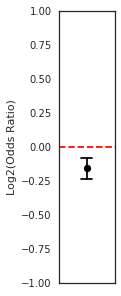

In [1042]:
plt.figure(figsize=(1, 5))
plt.plot([0, 0], [up, low], color="k")
plt.plot([-0.1, 0.1], [up, up], color="k")
plt.plot([-0.1, 0.1], [low, low], color="k")
plt.scatter([0], [OR], color="k")
plt.ylim(-1, 1)
plt.plot([-0.5, 0.5], [0, 0], color="r", linestyle="--")
plt.xlim(-0.5, 0.5)
plt.xticks([0], [""])
plt.ylabel("Log2(Odds Ratio)")

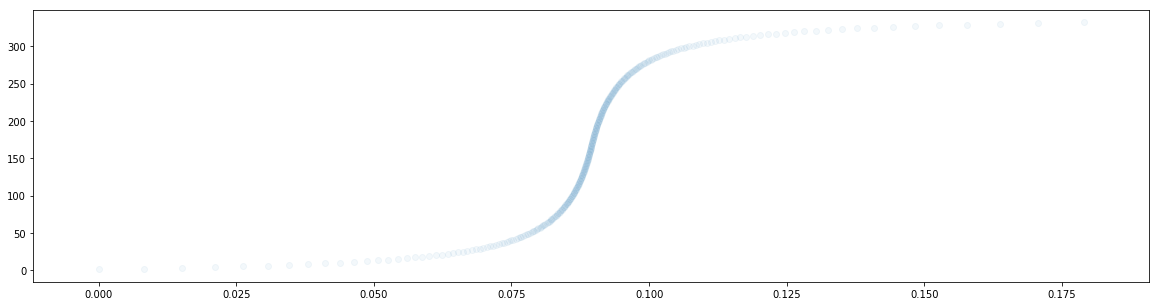

In [360]:
fig, ax = plt.subplots(1, figsize=(20, 5))

xs = []
ys = []
x = 0
for i in range(1, 1+len(summary)):
    xs.append(x)
    j = min([abs(0 - i), abs(i - len(summary))])
    j = max([j, 1])
    x += 1/(10+float(j))**2
    ys.append(i)
plt.scatter(xs, ys, alpha=0.05)

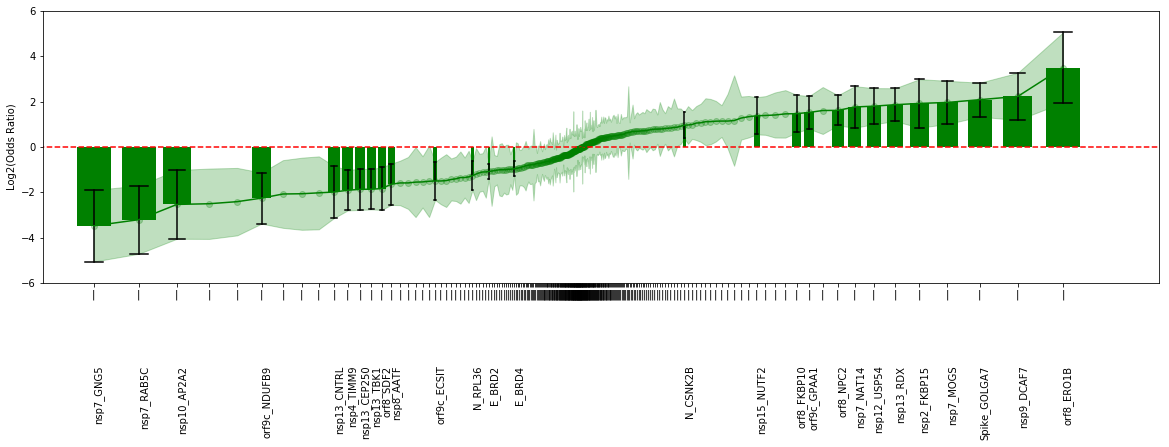

In [383]:
fig, ax = plt.subplots(1, figsize=(20, 5))

i = 0
labels = []
xs = []
ys = []
ys_low = []
ys_high = []
ticks = []
labels = []
labels2 = []
count = 1
for p1, p2, OR, up, low, p in summary.sort_values("LogOdds")[["P1", "P2", "LogOdds", "CI_Low", "CI_Up", "P-value"]].values:
    if(pd.isnull(OR)):
        continue
    xs.append(i)
    ys.append(OR)
    ys_low.append(low)
    ys_high.append(up)
    if(p <= 0.05):
        color = "k"
        ax.plot([i, i], [up, low], color=color)
        delta = 1/(10+float(j))**2
        ax.plot([i-0.20*delta, i+0.20*delta], [up, up], color=color)
        ax.plot([i-0.20*delta, i+0.20*delta], [low, low], color=color)
        ax.bar(i, height=OR, width=0.75*delta, color="g")
        #ax.scatter([i], [OR], color=color)
        labels.append("_".join([p1, uni2gene[p2]]).replace("COVID19", ""))
        ax.text(i, -10, labels[-1], rotation=90)
        #ticks.append(i)
    #    i += 1
    #else:
    #    i += 5 / float(len(summary))
    j = min([abs(0 - count), abs(count - len(summary[~pd.isnull(summary["LogOdds"])]))])
    j = max([j, 1])
    if(True):#, count % 2 == 1):#in [1, 10, 25, 50, 140, 230, 265, 280]):
        ticks.append(i)
        labels2.append("|")
    i += 1/(10+float(j))**2
    #i += 100000000000*(1 / (1 + len(summary) - (abs(count - (len(summary) / 2.0)))))**5
    
    count += 1
plt.plot([-0.5, i+0.5], [0, 0], color="r", linestyle="--")

ax.fill_between(xs, ys_low, ys_high, color="g", alpha=0.25)
ax.plot(xs, ys, color="g")
ax.scatter(xs, ys, color="g", alpha=0.25)
#plt.ylim(summary["CI_Low"].min()*1.1, summary["CI_Up"].max()*1.1)
plt.ylim(-6, 6)
plt.xlim(0 - i*0.05, i + i*0.05)
plt.xticks(ticks, labels2)
plt.ylabel("Log2(Odds Ratio)")
plt.savefig("Figures/Figure_4/Human_Enrichments.svg")

In [1000]:
len(xs)

282

Text(0,0.5,'Log2(Odds Ratio)')

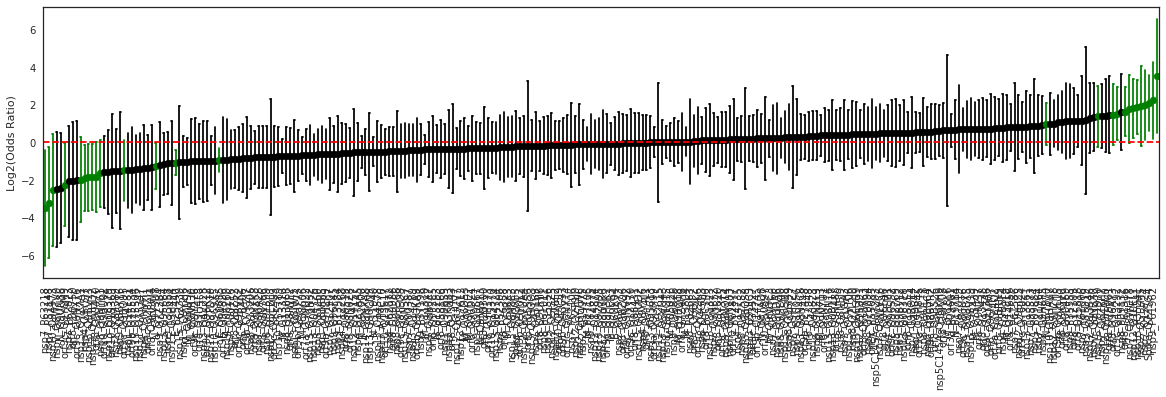

In [342]:
plt.figure(figsize=(20, 5))

i = 0
labels = []
for p1, p2, OR, up, low, p in summary.sort_values("LogOdds")[["P1", "P2", "LogOdds", "CI_Low", "CI_Up", "P-value"]].values:
    if(pd.isnull(OR)):
        continue
    color = "k"
    if(p <= 0.05):
        color = "g"
    plt.plot([i, i], [up, low], color=color)
    plt.plot([i-0.1, i+0.1], [up, up], color=color)
    plt.plot([i-0.1, i+0.1], [low, low], color=color)
    plt.scatter([i], [OR], color=color)
    labels.append("_".join([p1, p2]).replace("COVID19", ""))
    i += 1
i -= 1
plt.plot([-0.5, i+0.5], [0, 0], color="r", linestyle="--")    
plt.ylim(summary["CI_Low"].min()*1.1, summary["CI_Up"].max()*1.1)
plt.xlim(-0.5, 0.5+i)
plt.xticks(range(i), labels, rotation=90)
plt.ylabel("Log2(Odds Ratio)")

In [343]:
summary[(summary["P-value"] <= 0.05)].sort_values("P-value")

P1      P2   LogOdds    CI_Low     CI_Up   P-value  Ires_NoVar  \
2        COVID19E  P25440 -1.078056 -1.728209 -0.427903  0.000577        80.0   
1        COVID19E  O60885 -0.955397 -1.586583 -0.324211  0.001505        94.0   
51   COVID19Spike  Q7Z5G4  2.091700  0.623677  3.559722  0.002614        10.0   
93   COVID19nsp13  P35241  1.870091  0.445525  3.294656  0.005042         9.0   
260   COVID19orf8  P61916  1.619520  0.311497  2.927543  0.007618        11.0   
267   COVID19orf8  Q86YB8  3.511899  0.475891  6.547908  0.011689         1.0   
78   COVID19nsp12  Q70EL1  1.805243  0.242696  3.367790  0.011775         5.0   
168   COVID19nsp7  P63218 -3.478047 -6.571935 -0.384160  0.013786         9.0   
214   COVID19nsp9  P61962  2.234465  0.186729  4.282202  0.016230        17.0   
145   COVID19nsp4  Q9Y5J7 -1.906891 -3.657587 -0.156194  0.016388        20.0   
159   COVID19nsp7  P51148 -3.205299 -6.156172 -0.254427  0.016629        17.0   
307  COVID19orf9c  O43292  1.527603  0.111945  2.943262  0.017217         6.0   
122  COVID19nsp13  Q9UHD2 -1.861087 -3.604556 -0.117618  0.018211        15.0   
170   COVID19nsp7  Q13724  1.969626  0.098377  3.840875  0.019556         4.0   
121  COVID19nsp13  Q9BV73 -1.866191 -3.646975 -0.085407  0.019990        17.0   
50       COVID19N  Q9Y3U8 -1.267664 -2.503458 -0.031869  0.022189        38.0   
331  COVID19orf9c  Q9Y6M9 -2.254814 -4.461421 -0.048206  0.022600        12.0   
279   COVID19orf8  Q99470 -1.833428 -3.678040  0.011183  0.025703        15.0   
178   COVID19nsp7  Q8WUY8  1.769387 -0.024600  3.563374  0.026613         4.0   
206   COVID19nsp8  Q9NY61 -1.643856 -3.425808  0.138096  0.035298        14.0   
136   COVID19nsp2  Q5T1M5  1.925999 -0.172699  4.024698  0.036035         3.0   
322  COVID19orf9c  Q9BQ95 -1.497500 -3.140801  0.145801  0.037044        12.0   
274   COVID19orf8  Q96AY3  1.474539 -0.155650  3.104727  0.038129         5.0   
106  COVID19nsp13  Q7Z7A1 -1.985500 -4.245283  0.274282  0.042528        11.0   
128  COVID19nsp15  P61970  1.381871 -0.229529  2.993271  0.046402        18.0   
59   COVID19nsp10  O94973 -2.532983 -5.504916  0.438951  0.047412        10.0   
39       COVID19N  P67870  0.963220 -0.168431  2.094872  0.047633        38.0   

     Ires_Var  NoIres_Var  NoIres_NoVar  
2        29.0       300.0         392.0  
1        28.0       454.0         786.0  
51       11.0        16.0          62.0  
93       14.0        20.0          47.0  
260      13.0        30.0          78.0  
267       7.0       162.0         264.0  
78       10.0       293.0         512.0  
168       1.0        26.0          21.0  
214       5.0         4.0          64.0  
145       4.0        21.0          28.0  
159       1.0        51.0          94.0  
307      13.0       248.0         330.0  
122       4.0        31.0          32.0  
170       8.0        24.0          47.0  
121       3.0       368.0         572.0  
50       11.0        23.0          33.0  
331       2.0        70.0          88.0  
279       3.0        67.0          94.0  
178      10.0        33.0          45.0  
206       4.0        25.0          28.0  
136       6.0        30.0          57.0  
322       5.0        40.0          34.0  
274      12.0        38.0          44.0  
106       2.0        36.0          50.0  
128       6.0        11.0          86.0  
59        1.0       338.0         584.0  
39       12.0        23.0         142.0

In [344]:
summary[((summary["Ires_NoVar"] + summary["Ires_Var"]) > 0)&(pd.isnull(summary["LogOdds"]))].drop_duplicates("P2")

P1      P2  LogOdds  CI_Low  CI_Up  P-value  Ires_NoVar  \
19       COVID19M  Q6PML9      NaN     NaN    NaN      NaN         3.0   
26       COVID19M  Q96HW7      NaN     NaN    NaN      NaN         0.0   
42       COVID19N  Q6PKG0      NaN     NaN    NaN      NaN        27.0   
55    COVID19nsp1  P49643      NaN     NaN    NaN      NaN         6.0   
62   COVID19nsp10  Q96CW1      NaN     NaN    NaN      NaN        17.0   
68   COVID19nsp12  O75592      NaN     NaN    NaN      NaN        26.0   
82   COVID19nsp12  Q99081      NaN     NaN    NaN      NaN         8.0   
133   COVID19nsp2  P16435      NaN     NaN    NaN      NaN        16.0   
157   COVID19nsp7  P11233      NaN     NaN    NaN      NaN        15.0   
160   COVID19nsp7  P51149      NaN     NaN    NaN      NaN         8.0   
163   COVID19nsp7  P61026      NaN     NaN    NaN      NaN        11.0   
166   COVID19nsp7  P62820      NaN     NaN    NaN      NaN        13.0   
171   COVID19nsp7  Q5JTV8      NaN     NaN    NaN      NaN        19.0   
188   COVID19nsp8  O96028      NaN     NaN    NaN      NaN        11.0   
239  COVID19orf3a  Q9H270      NaN     NaN    NaN      NaN         1.0   
258   COVID19orf8  P29122      NaN     NaN    NaN      NaN        26.0   
306  COVID19orf9c  O00124      NaN     NaN    NaN      NaN        17.0   

     Ires_Var  NoIres_Var  NoIres_NoVar  
19        0.0       201.0         364.0  
26        1.0       371.0         591.0  
42        0.0       253.0         816.0  
55        0.0         0.0         163.0  
62        0.0        18.0         184.0  
68        0.0         2.0         224.0  
82        4.0         0.0           6.0  
133       0.0         6.0         144.0  
157       0.0        24.0         134.0  
160       0.0        29.0         138.0  
163       0.0        20.0         140.0  
166       0.0        21.0         121.0  
171       0.0         1.0         204.0  
188       0.0        25.0         190.0  
239       0.0         0.0         940.0  
258       0.0         1.0          66.0  
306       0.0         0.0          78.0

In [345]:
interactions = pd.read_csv("../../Haiyuan/2020_03_27_COVID19_3DInteractome/COVID19_Interactome.txt", sep="\t")
tmp = summary[(summary["P-value"] <= 0.05)].sort_values("LogOdds").copy()
tmp = tmp.join(interactions.set_index("Preys"), on=["P2"], how="inner")
tmp = tmp[["PreyGene", "P2", "P1", "Uniprot Protein Description", "Uniprot Function", "LogOdds", "CI_Low", "CI_Up", "P-value"]]
tmp.columns = ["Human Gene", "UniProt ID", "Viral Interactor", "Protein Description", "Protein Function", "LogOdds", "CI_Low", "CI_Up", "P-value"]
tmp
#print "\n".join(["\t".join([str(x) for x in list(tmp)])] + ["\t".join([str(x)[:100] for x in y]) for y in tmp.values])

Human Gene UniProt ID Viral Interactor  \
168       GNG5     P63218      COVID19nsp7   
159      RAB5C     P51148      COVID19nsp7   
59       AP2A2     O94973     COVID19nsp10   
331     NDUFB9     Q9Y6M9     COVID19orf9c   
106      CNTRL     Q7Z7A1     COVID19nsp13   
145      TIMM9     Q9Y5J7      COVID19nsp4   
121     CEP250     Q9BV73     COVID19nsp13   
122       TBK1     Q9UHD2     COVID19nsp13   
279       SDF2     Q99470      COVID19orf8   
206       AATF     Q9NY61      COVID19nsp8   
322      ECSIT     Q9BQ95     COVID19orf9c   
50       RPL36     Q9Y3U8         COVID19N   
2         BRD2     P25440         COVID19E   
1         BRD4     O60885         COVID19E   
39      CSNK2B     P67870         COVID19N   
128      NUTF2     P61970     COVID19nsp15   
274     FKBP10     Q96AY3      COVID19orf8   
307      GPAA1     O43292     COVID19orf9c   
260       NPC2     P61916      COVID19orf8   
178      NAT14     Q8WUY8      COVID19nsp7   
78       USP54     Q70EL1     COVID19nsp12   
93         RDX     P35241     COVID19nsp13   
136     FKBP15     Q5T1M5      COVID19nsp2   
170       MOGS     Q13724      COVID19nsp7   
51      GOLGA7     Q7Z5G4     COVID19Spike   
214      DCAF7     P61962      COVID19nsp9   
267      ERO1B     Q86YB8      COVID19orf8   

                                   Protein Description  \
168  Guanine nucleotide-binding protein G(I)/G(S)/G...   
159         Ras-related protein Rab-5C (L1880) (RAB5L)   
59   AP-2 complex subunit alpha-2 (100 kDa coated v...   
331  NADH dehydrogenase [ubiquinone] 1 beta subcomp...   
106  Centriolin (Centrosomal protein 1) (Centrosoma...   
145  Mitochondrial import inner membrane translocas...   
121  Centrosome-associated protein CEP250 (250 kDa ...   
122  Serine/threonine-protein kinase TBK1 (EC 2.7.1...   
279              Stromal cell-derived factor 2 (SDF-2)   
206  Protein AATF (Apoptosis-antagonizing transcrip...   
322  Evolutionarily conserved signaling intermediat...   
50   60S ribosomal protein L36 (Large ribosomal sub...   
2    Bromodomain-containing protein 2 (O27.1.1) (Re...   
1     Bromodomain-containing protein 4 (Protein HUNK1)   
39   Casein kinase II subunit beta (CK II beta) (Ph...   
128  Nuclear transport factor 2 (NTF-2) (Placental ...   
274  Peptidyl-prolyl cis-trans isomerase FKBP10 (PP...   
307  Glycosylphosphatidylinositol anchor attachment...   
260  NPC intracellular cholesterol transporter 2 (E...   
178  N-acetyltransferase 14 (EC 2.3.1.-) (K562 cell...   
78   Inactive ubiquitin carboxyl-terminal hydrolase...   
93                                             Radixin   
136  FK506-binding protein 15 (FKBP-15) (133 kDa FK...   
170  Mannosyl-oligosaccharide glucosidase (EC 3.2.1...   
51   Golgin subfamily A member 7 (Golgi complex-ass...   
214  DDB1- and CUL4-associated factor 7 (WD repeat-...   
267  ERO1-like protein beta (ERO1-L-beta) (EC 1.8.4...   

                                      Protein Function   LogOdds    CI_Low  \
168   Guanine nucleotide-binding proteins (G protei... -3.478047 -6.571935   
159   Protein transport. Probably involved in vesic... -3.205299 -6.156172   
59    Component of the adaptor protein complex 2 (A... -2.532983 -5.504916   
331   Accessory subunit of the mitochondrial membra... -2.254814 -4.461421   
106   Involved in cell cycle progression and cytoki... -1.985500 -4.245283   
145   Mitochondrial intermembrane chaperone that pa... -1.906891 -3.657587   
121   May be involved in ciliogenesis (PubMed:28005... -1.866191 -3.646975   
122   Serine/threonine kinase that plays an essenti... -1.861087 -3.604556   
279                                                NaN -1.833428 -3.678040   
206   May function as a general inhibitor of the hi... -1.643856 -3.425808   
322   Adapter protein of the Toll-like and IL-1 rec... -1.497500 -3.140801   
50    Component of the large ribosomal subunit. {EC... -1.267664 -2.503458   
2     May play a role in spermatogenesis or follicu... -1.078056 -1.728209  

In [346]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

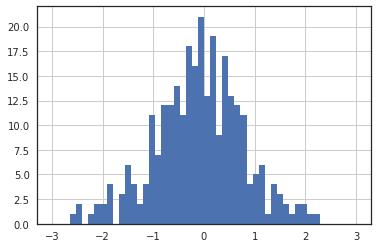

In [347]:
summary["LogOdds"].hist(range=(-3, 3), bins=50)

# Compile Viral Mutations

In [615]:
from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()

In [616]:
# Obtained From https://www.uniprot.org/proteomes/UP000000354
SARS1_fasta = ["Q7TFA1", "P59595", "P0C6X7", "P0C6U8", "P59636", "Q7TFA0", "P59634", "P59633", "Q80H93", "P59635", "P59632", "P59594", "P59637", "P59596", "Q7TLC7"]
SARS1_fasta = {x:my.get_Fasta(x) for x in tqdm_notebook(SARS1_fasta)}

In [559]:
COVID_fasta = pd.read_csv("Data/Proteins.txt", sep="\t").set_index("ID")["Sequence"].to_dict()
COVID_fasta = {k:v for k, v in COVID_fasta.iteritems() if "COVID" in k}

In [560]:
# Perform Mapping to Determine Best Hits
sars2covid = dict()
for p2, s1 in tqdm_notebook(SARS1_fasta.iteritems()):
    for p1, s2 in COVID_fasta.iteritems():
        align = my.NWSeqAlignment(s1, s2)
        alpha = 0.95
        score = alpha*align["Pident"]*align["Coverage1"] + (1-alpha)*align["Coverage1"] + alpha*align["Pident"]*align["Coverage2"] + (1-alpha)*align["Coverage2"]
        if(not p1 in sars2covid):
            sars2covid[p1] = (p2, score, align["Pident"], align["Coverage1"], align["Coverage2"])
        elif(score > sars2covid[p1][1]):
            sars2covid[p1] = (p2, score, align["Pident"], align["Coverage1"], align["Coverage2"])

In [569]:
# Manually Screen Alignments for Bad Alignments
blacklist = [("P0C6U8", "COVID19orf3b"), ("P0C6X7", "COVID19orf8"), ("P0C6U8", "COVID19orf10")]
all_muts = []
for p2 in sars2covid:
    p1 = sars2covid[p2][0]
    if((p1, p2) in blacklist):
        continue
    print p1, p2
    align, posmap = my.NWSeqAlignment(SARS1_fasta[p1], COVID_fasta[p2], show_align=True, genPosMap=True)
    print "\n"*10
    
    muts = posmap[(posmap["Align2_AA"] != "")&(posmap["Align2_AA"] != posmap["Align1_AA"])].copy()
    muts.columns = ["SARS_Pos", "SARS_AA", "COVID_Pos", "COVID_AA"]
    muts["SARS_ID"] = p1
    muts["COVID_ID"] = p2
    muts = muts[["COVID_ID", "SARS_ID", "COVID_Pos", "COVID_AA", "SARS_Pos", "SARS_AA"]]
    
    all_muts.append(muts)
all_muts = pd.concat(all_muts)

P59632 COVID19orf3a
Align1:    1 MDLFMRFFTL GSITAQPVKI DNASPASTVH ATATIPLQAS LPFGWLVIGV AFLAVFQSAT 60  
             ||||||-||+ |++|-+--+| -+|+|+--|- ||||||+||| ||||||++|| |-|||||||+     
Align2:    1 MDLFMRIFTI GTVTLKQGEI KDATPSDFVR ATATIPIQAS LPFGWLIVGV ALLAVFQSAS 60  

Align1:   61 KIIALNKRWQ LALYKGFQFI CNLLLLFVTI YSHLLLVAAG MEAQFLYLYA LIYFLQCINA 120 
             |||-|-|||| |||-||--|+ |||||||||+ |||||||||| +||-|||||| |+||||-||-     
Align2:   61 KIITLKKRWQ LALSKGVHFV CNLLLLFVTV YSHLLLVAAG LEAPFLYLYA LVYFLQSINF 120 

Align1:  121 CRIIMRCWLC WKCKSKNPLL YDANYFVCWH THNYDYCIPY NSVTDTIVVT EGDGISTPKL 180 
             -|||||-||| |||+|||||| ||||||+||| |+-||||||| ||||-+||+| -|||-++|--     
Align2:  121 VRIIMRLWLC WKCRSKNPLL YDANYFLCWH TNCYDYCIPY NSVTSSIVIT SGDGTTSPIS 180 

Align1:  181 KEDYQIGGYS EDRHSGVKDY VVVHGYFTEV YYQLESTQIT TDTGIENATF FIFNKLVKDP 240 
             +-|||||||+ |---|||||- ||+|-|||-- ||||-|||++ ||||+|+-|| ||+||+|-+|     
Align2:  181 EHDYQIGGYT EKWESGVKDC VVLHSYFTSD YYQLYST

Align1:    1 MSDNGPQSNQ RSAPRITFGG PTDSTDNNQN GGRNGARPKQ RRPQGLPNNT ASWFTALTQH 60  
             ||||||| || |+|||||||| |+|||-+||| |-|+|||-|| |||||||||| ||||||||||     
Align2:    1 MSDNGPQ-NQ RNAPRITFGG PSDSTGSNQN GERSGARSKQ RRPQGLPNNT ASWFTALTQH 59  

Align1:   61 GKEELRFPRG QGVPINTNSG PDDQIGYYRR ATRRVRGGDG KMKELSPRWY FYYLGTGPEA 120 
             |||+|+|||| |||||||||- |||||||||| ||||+||||| |||+|||||| ||||||||||     
Align2:   60 GKEDLKFPRG QGVPINTNSS PDDQIGYYRR ATRRIRGGDG KMKDLSPRWY FYYLGTGPEA 119 

Align1:  121 SLPYGANKEG IVWVATEGAL NTPKDHIGTR NPNNNAATVL QLPQGTTLPK GFYAEGSRGG 180 
             -|||||||+| |+|||||||| |||||||||| ||-||||-|| |||||||||| ||||||||||     
Align2:  120 GLPYGANKDG IIWVATEGAL NTPKDHIGTR NPANNAAIVL QLPQGTTLPK GFYAEGSRGG 179 

Align1:  181 SQASSRSSSR SRGNSRNSTP GSSRGNSPAR MASGGGETAL ALLLLDRLNQ LESKVSGKGQ 240 
             |||||||||| ||-+|||||| |||||-|||| ||--||+-|| |||||||||| ||||+|||||     
Align2:  180 SQASSRSSSR SRNSSRNSTP GSSRGTSPAR MAGNGGDAAL ALLLLDRLNQ LESKM

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----












P0C6X7 COVID19nsp12
Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ------

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MFIFLLFLTL TSGSDLDRCT TFDDVQAPNY TQHTSSMRGV YYPDEIFRSD TLYLTQDLFL 60   
              ||+||+-|-| -| |-----| |---+ -|-| |  -|--||| ||||++|||- -|+-||||||      
Align2:     1 MFVFLVLLPL VS-SQCVNLT TRTQL-PPAY T--NSFTRGV YYPDKVFRSS VLHSTQDLFL 56   

Align1:    61 PFYSNVTGFH TI-----NHT --FGNPVIPF KDGIYFAATE KSNVVRGWVF GSTMNNKSQS 113  
              ||+||||-|| -|     |-|   |-|||+|| -||+|||+|| |||++|||+| |+|+++|+||      
Align2:    57 PFFSNVTWFH AIHVSGTNGT KRFDNPVLPF NDGVYFASTE KSNIIRGWIF GTTLDSKTQS 116  

Align1:   114 VIIINNSTNV VIRACNFELC DNPFFAV--- -SKPMGTQTH TMIFDNAFNC TFEYISDAFS 169  
              ++|+||+||| ||+-|-|+-| ++||--|     +-----++- --++-+|-|| ||||+|--|-      
Align2:   117 LLIVNNATNV VIKVCEFQFC NDPFLGVYYH KNNKSWMESE FRVYSSANNC TFEYVSQPFL 176  

Align1:   170 LDVSEKSGNF KHLREFVFKN KDGFLYVYKG YQPIDVVRDL PSGFNTLKPI FKLPLGINIT 229  
              +|+--|-||| |+|||||||| -||+--+|-- +-||++|||| |-||+-|+|+ --||+|||||      
Align2:   177 MDLEGKQGNF KNLREFVFKN IDGYFKIYSK HTPI

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
              |-|||||||| ||||||||+| |||-|||||| +-|||||||| +|++|||||| ||+|||||||      
Align2:     1 AYTRYVDNNF CGPDGYPLEC IKDLLARAGK ASCT

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
              |||||-|-|| |||||||||| |||||||||| |||||||-|| |||+|||+|| |||||+||||      
Align2:     1 MESLVPGFNE KTHVQLSLPV LQVRDVLVRG FGDSVEEVLS EARQHLKDGT CGLVEVEKGV 60   

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
              |||||||||| ||||||-+-- |||-+||||| |++||||||| |-|||||||| |||-|+|||-      
Align2:    61 LPQLEQPYVF IKRSDARTAP HGHVMVELVA ELEGIQYGRS GETLGVLVPH VGEIPVAYRK 120  

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
              |||||||||| |||||||-|| ||+||||||| |||-||+++| |||||-||-- |||-||||||      
Align2:   121 VLLRKNGNKG AGGHSYGADL KSFDLGDELG TDPYEDFQEN WNTKHSSGVT RELMRELNGG 180  

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:   181 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

Align1:     1 MESLVLGVNE KTHVQLSLPV LQVRDVLVRG FGDSVEEALS EAREHLKNGT CGLVELEKGV 60   
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:    61 LPQLEQPYVF IKRSDALSTN HGHKVVELVA EMDGIQYGRS GITLGVLVPH VGETPIAYRN 120  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   121 VLLRKNGNKG AGGHSYGIDL KSYDLGDELG TDPIEDYEQN WNTKHGSGAL RELTRELNGG 180  
                                                                                     
Align2:     1 ---------- ---------- ---------- ---------- ---------- ---------- 0    

Align1:   181 AVTRYVDNNF CGPDGYPLDC IKDFLARAGK SMCTLSEQLD YIESKRGVYC CRDHEHEIAW 240  
                                                                                     
Align2:     1 ---------- ---------- ---------- ----

In [575]:
all_muts.to_csv("Data/Viral_Muts.txt", sep="\t", index=None)

# Calculate Enrichment on Viral Mutations

In [617]:
import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np

import helper as my

In [618]:
# Read in IRES Info Summary
ires_df = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

# Read in Viral Mutations Summary
viral_mut_df = pd.read_csv("Data/Viral_Muts.txt", sep="\t")

In [619]:
# Generate Coverage Masks
uni2seq = pd.read_csv("Data/Proteins.txt", sep="\t").set_index("ID")["Sequence"].to_dict()
uni2coverage_mask = dict()
for uni in uni2seq:
    uni2coverage_mask[uni] = np.zeros(len(uni2seq[uni]))
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    pdb_df = my.pdb2df(uni_f)
    resis = list(pdb_df["Residue ID"].unique() - 1)
    resis = [x for x in resis if x >= 0]
    
    uni2coverage_mask[uni][resis] = 1
    
    if(sum(uni2coverage_mask[uni][resis]) == len(uni2seq[uni]) - 1):
        print uni
        uni2coverage_mask[uni][:] = 1

P62873
Q99519
COVID19nsp5C145A
COVID19nsp13
COVID19nsp15
COVID19nsp14
COVID19nsp7
COVID19nsp5
COVID19nsp4
COVID19nsp2
Q9H2H8
COVID19orf6


In [620]:
# Calculate Odds Ratios
summary = []
uni2iresmask = dict()
uni2mutmask = dict()
for p1, p2, uni_len, ires, source in ires_df[["P1", "P2", "P1_Len", "P1_Ires", "Source"]].values:
    if(not p1 in viral_mut_df["COVID_ID"].unique()):
        print p1, "Has no detectable muts"
        summary.append([p1, p2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        continue
    if(pd.isnull(ires)):
        ires = []
    else:
        ires = [int(x)-1 for x in ires.split(",")]
    
    ires_mask = np.zeros(uni_len)
    ires_mask[ires] = 1
    
    muts = [x-1 for x in viral_mut_df[(viral_mut_df["COVID_ID"] == p1)]["COVID_Pos"].unique()]
    
    mutmask = np.zeros(uni_len)
    mutmask[muts] = 1
    
    if(source == "Docking"):
        coverage_mask = uni2coverage_mask[p1]
        ires_mask = ires_mask[coverage_mask == True]
        mutmask = mutmask[coverage_mask == True]
    
    OR, up, low, p = my.odds_ratio(ires_mask, mutmask, error="CI", two_sided=False)
    #OR, up, low, p = my.odds_ratio(ires_mask, mutmask, error="SE", two_sided=False)
    OR, up, low = np.log2([OR, up, low])
    
    if(not source == "Docking" and any(ires_df[ires_df["P1"] == p1]["Source"] == "Docking")):
        coverage_mask = uni2coverage_mask[p1]
        ires_mask = ires_mask[coverage_mask == True]
        mutmask = mutmask[coverage_mask == True]
    
    
    if(not p1 in uni2iresmask.keys()):
        uni2iresmask[p1] = ires_mask
        uni2mutmask[p1] = mutmask
    else:
        print "HERE"
        uni2iresmask[p1] = uni2iresmask[p1] + ires_mask
        uni2mutmask[p1] = uni2mutmask[p1] + mutmask
    
    summary.append([p1, p2, OR, low, up, p, sum(ires_mask*(1-mutmask)), sum(ires_mask*mutmask), sum((1-ires_mask)*mutmask), sum((1-ires_mask)*(1-mutmask))])
summary = pd.DataFrame(summary, columns=["P1", "P2", "LogOdds", "CI_Low", "CI_Up", "P-value", "Ires_NoVar", "Ires_Var", "NoIres_Var", "NoIres_NoVar"])

HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE


In [621]:
summary.to_csv("Data/Viral_Mut_Enrichment.txt", sep="\t", index=None)

In [1047]:
summary = pd.read_csv("Data/Viral_Mut_Enrichment.txt", sep="\t")

In [376]:
# Overall Enrichment Across all Genes
ires_mask = np.concatenate([uni2iresmask[uni]>0 for uni in uni2iresmask.keys()])
pop_mask = np.concatenate([uni2mutmask[uni]>0 for uni in uni2iresmask.keys()])

OR, up, low, p = my.odds_ratio(ires_mask, pop_mask, error="SE", two_sided=False)
OR, up, low = np.log2([OR, up, low])
    
print OR, up, low, p

-0.366161699727 -0.209375292721 -0.522948106734 0.00976081370567


Text(0,0.5,'Log2(Odds Ratio)')

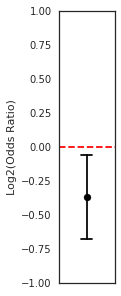

In [1049]:
plt.figure(figsize=(1, 5))
plt.plot([0, 0], [up, low], color="k")
plt.plot([-0.1, 0.1], [up, up], color="k")
plt.plot([-0.1, 0.1], [low, low], color="k")
plt.scatter([0], [OR], color="k")
plt.ylim(-1, 1)
plt.plot([-0.5, 0.5], [0, 0], color="r", linestyle="--")
plt.xlim(-0.5, 0.5)
plt.xticks([0], [""])
plt.ylabel("Log2(Odds Ratio)")

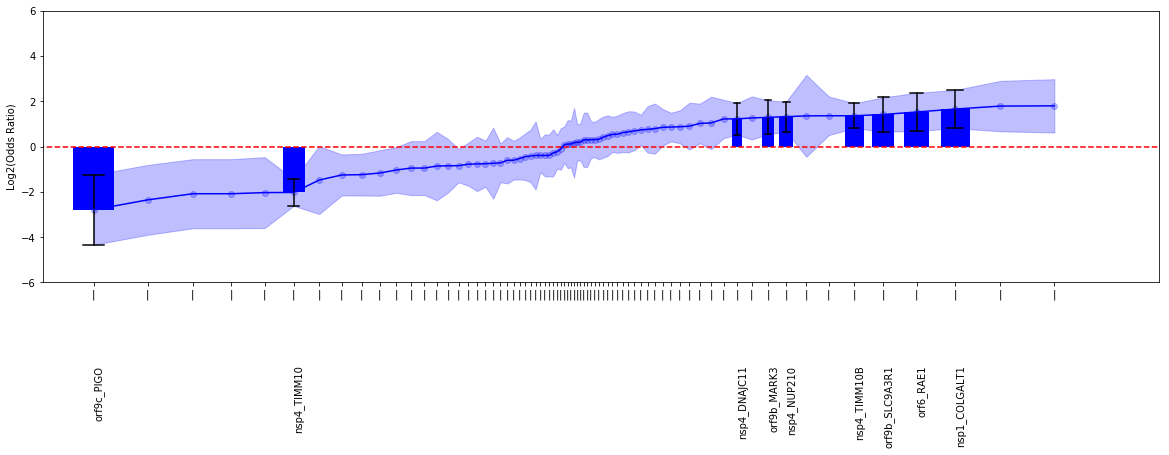

In [385]:
fig, ax = plt.subplots(1, figsize=(20, 5))

i = 0
labels = []
xs = []
ys = []
ys_low = []
ys_high = []
ticks = []
labels = []
labels2 = []
count = 1
for p1, p2, OR, up, low, p in summary.sort_values("LogOdds")[["P1", "P2", "LogOdds", "CI_Low", "CI_Up", "P-value"]].values:
    if(pd.isnull(OR)):
        continue
    xs.append(i)
    ys.append(OR)
    ys_low.append(low)
    ys_high.append(up)
    if(p <= 0.05):
        color = "k"
        ax.plot([i, i], [up, low], color=color)
        delta = 1/(10+float(j))**2
        ax.plot([i-0.20*delta, i+0.20*delta], [up, up], color=color)
        ax.plot([i-0.20*delta, i+0.20*delta], [low, low], color=color)
        ax.bar(i, height=OR, width=0.75*delta, color="b")
        #ax.scatter([i], [OR], color=color)
        labels.append("_".join([p1, uni2gene[p2]]).replace("COVID19", ""))
        ax.text(i, -10, labels[-1], rotation=90)
        #ticks.append(i)
    #    i += 1
    #else:
    #    i += 5 / float(len(summary))
    j = min([abs(0 - count), abs(count - len(summary[~pd.isnull(summary["LogOdds"])]))])
    j = max([j, 1])
    if(True):#, count % 2 == 1):#in [1, 10, 25, 50, 140, 230, 265, 280]):
        ticks.append(i)
        labels2.append("|")
    i += 1/(10+float(j))**2
    #i += 100000000000*(1 / (1 + len(summary) - (abs(count - (len(summary) / 2.0)))))**5
    
    count += 1
plt.plot([-0.5, i+0.5], [0, 0], color="r", linestyle="--")

ax.fill_between(xs, ys_low, ys_high, color="b", alpha=0.25)
ax.plot(xs, ys, color="b")
ax.scatter(xs, ys, color="b", alpha=0.25)
#plt.ylim(summary["CI_Low"].min()*1.1, summary["CI_Up"].max()*1.1)
plt.ylim(-6, 6)
plt.xlim(0 - i*0.05, i + i*0.05)
plt.xticks(ticks, labels2)
plt.ylabel("Log2(Odds Ratio)")
plt.savefig("Figures/Figure_4/Viral_Enrichments.svg")

Text(0,0.5,'Log2(Odds Ratio)')

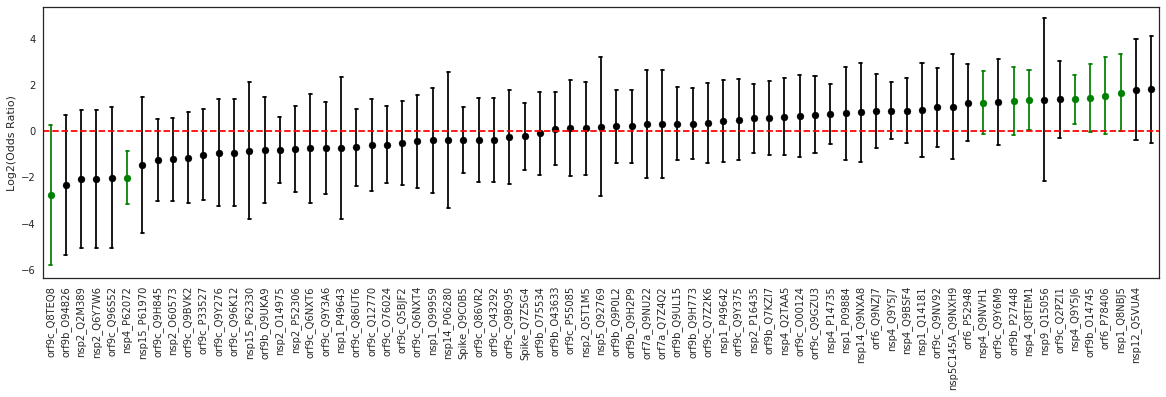

In [1034]:
plt.figure(figsize=(20, 5))

i = 0
labels = []
for p1, p2, OR, up, low, p in summary.sort_values("LogOdds")[["P1", "P2", "LogOdds", "CI_Low", "CI_Up", "P-value"]].values:
    if(pd.isnull(OR)):
        continue
    color = "k"
    if(p <= 0.05):
        color = "g"
    plt.plot([i, i], [up, low], color=color)
    plt.plot([i-0.1, i+0.1], [up, up], color=color)
    plt.plot([i-0.1, i+0.1], [low, low], color=color)
    plt.scatter([i], [OR], color=color)
    labels.append("_".join([p1, p2]).replace("COVID19", ""))
    i += 1
i -= 1
plt.plot([-0.5, i+0.5], [0, 0], color="r", linestyle="--")    
plt.ylim(summary["CI_Low"].min()*1.1, summary["CI_Up"].max()*1.1)
plt.xlim(-0.5, 0.5+i)
plt.xticks(range(i), labels, rotation=90)
plt.ylabel("Log2(Odds Ratio)")

In [741]:
summary[((summary["Ires_NoVar"] + summary["Ires_Var"]) > 0)&(pd.isnull(summary["LogOdds"]))].drop_duplicates("P1")

P1      P2  LogOdds  CI_Low  CI_Up  P-value  Ires_NoVar  \
59   COVID19nsp10  O94973      NaN     NaN    NaN      NaN        16.0   
65   COVID19nsp12  A3KN83      NaN     NaN    NaN      NaN        16.0   
85   COVID19nsp13  A7MCY6      NaN     NaN    NaN      NaN        29.0   
126  COVID19nsp14  P12268      NaN     NaN    NaN      NaN        22.0   
130  COVID19nsp15  Q9H4P4      NaN     NaN    NaN      NaN        18.0   
153   COVID19nsp7  O00116      NaN     NaN    NaN      NaN        19.0   
185   COVID19nsp8  O00566      NaN     NaN    NaN      NaN        13.0   
209   COVID19nsp9  P13984      NaN     NaN    NaN      NaN        18.0   
325  COVID19orf9c  Q9H3K2      NaN     NaN    NaN      NaN        11.0   

     Ires_Var  NoIres_Var  NoIres_NoVar  
59        0.0         2.0         113.0  
65        0.0        24.0         763.0  
85        0.0         1.0         571.0  
126       0.0        26.0         479.0  
130       0.0        39.0         289.0  
153       0.0         1.0          63.0  
185       0.0         5.0         174.0  
209       0.0         3.0          92.0  
325       0.0        19.0          43.0

In [742]:
summary[summary["P-value"] <= 0.05].sort_values("P-value")

P1      P2   LogOdds    CI_Low     CI_Up   P-value  Ires_NoVar  \
139   COVID19nsp4  P62072 -2.027023 -3.184438 -0.869608  0.000299        97.0   
144   COVID19nsp4  Q9Y5J6  1.360683  0.282711  2.438655  0.006681        21.0   
141   COVID19nsp4  Q8TEM1  1.320538  0.024029  2.617046  0.022951        14.0   
57    COVID19nsp1  Q8NBJ5  1.655352  0.003978  3.306725  0.024725        16.0   
295  COVID19orf9b  O14745  1.415037 -0.071524  2.901599  0.031044        18.0   
244   COVID19orf6  P78406  1.526069 -0.128424  3.180561  0.035317        10.0   
319  COVID19orf9c  Q8TEQ8 -2.791413 -5.820891  0.238064  0.035463        15.0   
143   COVID19nsp4  Q9NVH1  1.222392 -0.143840  2.588625  0.039748        13.0   
299  COVID19orf9b  P27448  1.289507 -0.180323  2.759336  0.042761        22.0   

     Ires_Var  NoIres_Var  NoIres_NoVar  
139       7.0        90.0         306.0  
144      12.0        85.0         382.0  
141       8.0        89.0         389.0  
57        6.0        10.0          84.0  
295      10.0        10.0          48.0  
244       9.0        10.0          32.0  
319       1.0        18.0          39.0  
143       7.0        90.0         390.0  
299      11.0         9.0          44.0

In [743]:
tmp = summary[(summary["P-value"] <= 0.05)].sort_values("LogOdds").copy()
tmp = tmp.join(interactions.set_index("Preys"), on=["P2"], how="inner")
tmp = tmp[["P1", "PreyGene", "P2", "Uniprot Protein Description", "Uniprot Function", "LogOdds", "CI_Low", "CI_Up", "P-value"]]
tmp.columns = ["Viral Protein", "Human Interactor", "UniProt ID", "Protein Description", "Protein Function", "LogOdds", "CI_Low", "CI_Up", "P-value"]
tmp
#print "\n".join(["\t".join([str(x) for x in list(tmp)])] + ["\t".join([str(x)[:100] for x in y]) for y in tmp.values])

Viral Protein Human Interactor UniProt ID  \
319  COVID19orf9c             PIGO     Q8TEQ8   
139   COVID19nsp4           TIMM10     P62072   
143   COVID19nsp4          DNAJC11     Q9NVH1   
299  COVID19orf9b            MARK3     P27448   
141   COVID19nsp4           NUP210     Q8TEM1   
144   COVID19nsp4          TIMM10B     Q9Y5J6   
295  COVID19orf9b         SLC9A3R1     O14745   
244   COVID19orf6             RAE1     P78406   
57    COVID19nsp1         COLGALT1     Q8NBJ5   

                                   Protein Description  \
319  GPI ethanolamine phosphate transferase 3 (EC 2...   
139  Mitochondrial import inner membrane translocas...   
143                 DnaJ homolog subfamily C member 11   
299  MAP/microtubule affinity-regulating kinase 3 (...   
141  Nuclear pore membrane glycoprotein 210 (Nuclea...   
144  Mitochondrial import inner membrane translocas...   
295  Na(+)/H(+) exchange regulatory cofactor NHE-RF...   
244  mRNA export factor (Rae1 protein homolog) (mRN...   
57   Procollagen galactosyltransferase 1 (EC 2.4.1....   

                                      Protein Function   LogOdds    CI_Low  \
319   Ethanolamine phosphate transferase involved i... -2.791413 -5.820891   
139   Mitochondrial intermembrane chaperone that pa... -2.027023 -3.184438   
143   [Isoform 1]: Required for mitochondrial inner...  1.222392 -0.143840   
299   Serine/threonine-protein kinase (PubMed:23666...  1.289507 -0.180323   
141   Nucleoporin essential for nuclear pore assemb...  1.320538  0.024029   
144   Component of the TIM22 complex, a complex tha...  1.360683  0.282711   
295   Scaffold protein that connects plasma membran...  1.415037 -0.071524   
244   Plays a role in mitotic bipolar spindle forma...  1.526069 -0.128424   
57    Beta-galactosyltransferase that transfers bet...  1.655352  0.003978   

        CI_Up   P-value  
319  0.238064  0.035463  
139 -0.869608  0.000299  
143  2.588625  0.039748  
299  2.759336  0.042761  
141  2.617046  0.022951  
144  2.438655  0.006681  
295  2.901599  0.031044  
244  3.180561  0.035317  
57   3.306725  0.024725

In [744]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

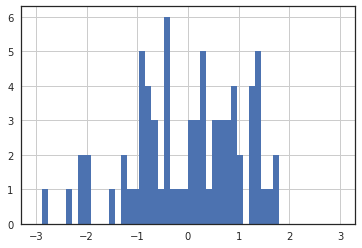

In [745]:
summary["LogOdds"].hist(range=(-3, 3), bins=50)

# Compile Interface Similarity (Viral)

In [746]:
# Read in IRES Info Summary
ires_df = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

In [747]:
#ires_df = ires_df[ires_df["P1"] == "COVID19orf8"]
ires_similarities = []
names = []
dm = np.zeros((len(ires_df), len(ires_df)))
for i in range(len(ires_df)):
    p1A, p2A, iresA = ires_df[["P1", "P2", "P1_Ires"]].values[i]
    
    if(not pd.isnull(iresA)):
        iresA = set([int(x) for x in iresA.split(",")])
    else:
        iresA = set()
    for j in range(i, len(ires_df)):
        p1B, p2B, iresB = ires_df[["P1", "P2", "P1_Ires"]].values[j]
        
        if(p1A != p1B):
            ires_similarities.append([p1A, p2A, p1B, p2B, -1])
        elif(p2A == p2B):
            ires_similarities.append([p1A, p2A, p1B, p2B, 1])
        else:
            if(not pd.isnull(iresB)):
                iresB = set([int(x) for x in iresB.split(",")])
            else:
                iresB = set()
            
            if(len(iresA) + len(iresB) == 0):
                ires_similarities.append([p1A, p2A, p1B, p2B, 1])
            elif(len(iresA) == 0 or len(iresB) == 0):
                ires_similarities.append([p1A, p2A, p1B, p2B, 0])
            else:
                jaccard = len(iresA.intersection(iresB)) / float(len(iresA.union(iresB)))
                ires_similarities.append([p1A, p2A, p1B, p2B, jaccard])
        #print i, j
        if(i == 0 and j == 0):
            print ires_similarities[-1]
        dm[i,j] = ires_similarities[-1][-1]
        dm[j,i] = ires_similarities[-1][-1]
    names.append("_".join([p1A.replace("COVID19", ""), p2A]))
    #print i, i, i, i
ires_similarities = pd.DataFrame(ires_similarities, columns=["P1A", "P2A", "P1B", "P2B", "Jaccard"])

['COVID19E', 'O00203', 'COVID19E', 'O00203', 1]


In [748]:
#ires_similarities = ires_similarities.sort_values(["P1A", "P2A", "P1B", "P2B"])

In [749]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

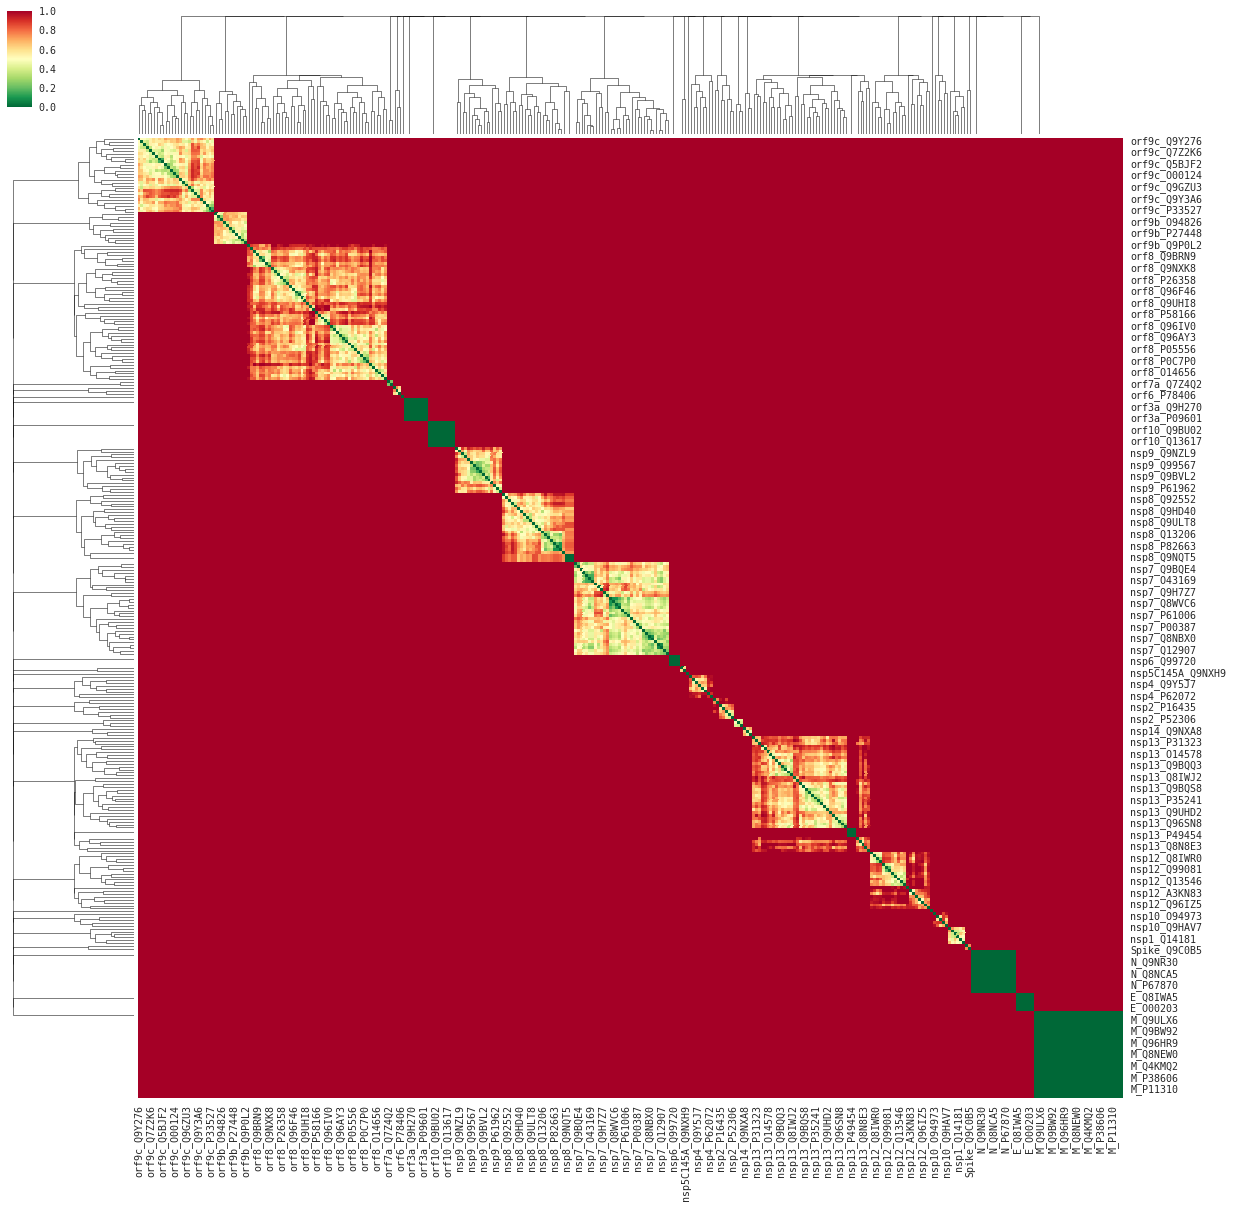

In [750]:
sns.set(font="monospace")

# Reformat distance matrix to include kmer name
dm_df = pd.DataFrame(1-dm, columns=names, index=names)

# Generate linkage from distance matrix
linkage = hierarchy.linkage(distance.squareform(dm_df), method="complete")

# Generate cluster map
# Modify size based on number of rows as needed
# Modify the vmin, center, and vmax based on RMSD range (I have set it up so that anything about 4 will just be a flat color)
m = sns.clustermap(dm_df, row_linkage=linkage, col_linkage=linkage, figsize=(20, 20), vmin=0, center=0.5, vmax=1, cmap="RdYlGn_r")

In [765]:
# Compile Ordering for Interface Residue Comparisons
from collections import defaultdict

# Reformat Linkages
i = 0
new_linkage = []
cluster2height = defaultdict(int)
for c1, c2, d, n in linkage:
    c1, c2 = int(c1), int(c2)
    if(c1) < len(dm_df):
        c1 = list(dm_df)[c1]
    if(c2) < len(dm_df):
        c2 = list(dm_df)[c2]
    new_linkage.append([c1, c2, d, n, len(dm_df) + i])
    cluster2height[len(dm_df) + i] = d
    i += 1

import networkx as nx

# Convert Linkages into graph
g = nx.Graph()
for child1, child2, dist, n, node in new_linkage[::-1]:
    g.add_edge(node, child1, weight=cluster2height[node] - cluster2height[child1])
    g.add_edge(node, child2, weight=cluster2height[node] - cluster2height[child2])

# Store distance between all nodes from same protein
data = []
for n1 in list(dm_df):
    p1A, p2A = n1.split("_")
    p1A = "COVID19" + p1A
    for n2 in list(dm_df):
        p1B, p2B = n2.split("_")
        p1B = "COVID19" + p1B
        if(p1A != p1B):
            continue
        data.append([p1A, p2A, 0, p2B, (nx.shortest_path_length(g, n1, n2, weight="weight"), nx.shortest_path_length(g, n1, n2))])
ires_orders = pd.DataFrame(data, columns=["P1", "P2", "Prot", "Interactor", "Dist"]).sort_values(["P1", "P2", "Dist"])

# Reformat / Assign Order
ires_orders["Order"] = 0
keys = ires_orders[["P1", "P2"]].apply(lambda x: tuple(x), axis=1)
for inter, g_df in ires_orders.groupby(["P1", "P2"]):
    ires_orders.ix[keys == inter, "Order"] = range(len(g_df))

ires_orders = ires_orders.drop("Dist", axis=1)

# Set Ires
inter2ires = ires_df.set_index(["P1", "P2"])[["P1_Ires", "P2_Ires"]].to_dict(orient="index")
inter2similarity = ires_similarities.set_index(["P1A", "P2A", "P1B", "P2B"])["Jaccard"].to_dict()
for k, v in list(inter2similarity.iteritems()):
    inter2similarity[k[0], k[3], k[2], k[1]] = v
ires_orders["Similarity"] = ires_orders[["P1", "P2", "Interactor"]].apply(lambda x: inter2similarity[(x[0], x[1], x[0], x[2])], axis=1)
ires_orders["Ires"] = ires_orders[["P1", "Interactor"]].apply(lambda x: inter2ires[tuple(x)]["P1_Ires"], axis=1)

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [781]:
ires_similarities[ires_similarities["P1A"] == ires_similarities["P1B"]].to_csv("Data/Viral_Interface_Similarities.txt", sep="\t", index=None)

In [782]:
ires_similarities[ires_similarities["P1A"] == ires_similarities["P1B"]]

P1A     P2A           P1B     P2B   Jaccard
0          COVID19E  O00203      COVID19E  O00203  1.000000
1          COVID19E  O00203      COVID19E  O60885  1.000000
2          COVID19E  O00203      COVID19E  P25440  1.000000
3          COVID19E  O00203      COVID19E  Q6UX04  1.000000
4          COVID19E  O00203      COVID19E  Q86VM9  1.000000
5          COVID19E  O00203      COVID19E  Q8IWA5  1.000000
332        COVID19E  O60885      COVID19E  O60885  1.000000
333        COVID19E  O60885      COVID19E  P25440  1.000000
334        COVID19E  O60885      COVID19E  Q6UX04  1.000000
335        COVID19E  O60885      COVID19E  Q86VM9  1.000000
336        COVID19E  O60885      COVID19E  Q8IWA5  1.000000
663        COVID19E  P25440      COVID19E  P25440  1.000000
664        COVID19E  P25440      COVID19E  Q6UX04  1.000000
665        COVID19E  P25440      COVID19E  Q86VM9  1.000000
666        COVID19E  P25440      COVID19E  Q8IWA5  1.000000
993        COVID19E  Q6UX04      COVID19E  Q6UX04  1.000000
994        COVID19E  Q6UX04      COVID19E  Q86VM9  1.000000
995        COVID19E  Q6UX04      COVID19E  Q8IWA5  1.000000
1322       COVID19E  Q86VM9      COVID19E  Q86VM9  1.000000
1323       COVID19E  Q86VM9      COVID19E  Q8IWA5  1.000000
1650       COVID19E  Q8IWA5      COVID19E  Q8IWA5  1.000000
1977       COVID19M  O75439      COVID19M  O75439  1.000000
1978       COVID19M  O75439      COVID19M  O95070  1.000000
1979       COVID19M  O75439      COVID19M  P05026  1.000000
1980       COVID19M  O75439      COVID19M  P11310  1.000000
1981       COVID19M  O75439      COVID19M  P13804  1.000000
1982       COVID19M  O75439      COVID19M  P27105  1.000000
1983       COVID19M  O75439      COVID19M  P38435  1.000000
1984       COVID19M  O75439      COVID19M  P38606  1.000000
1985       COVID19M  O75439      COVID19M  P48556  1.000000
...             ...     ...           ...     ...       ...
55248  COVID19orf9c  Q9GZU3  COVID19orf9c  Q9Y3A6  0.307692
55249  COVID19orf9c  Q9GZU3  COVID19orf9c  Q9Y6M9  0.578947
55250  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9H3K2  1.000000
55251  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9H845  0.440000
55252  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9NV92  0.080000
55253  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9Y276  0.277778
55254  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9Y375  0.080000
55255  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9Y3A6  0.588235
55256  COVID19orf9c  Q9H3K2  COVID19orf9c  Q9Y6M9  0.095238
55257  COVID19orf9c  Q9H845  COVID19orf9c  Q9H845  1.000000
55258  COVID19orf9c  Q9H845  COVID19orf9c  Q9NV92  0.205882
55259  COVID19orf9c  Q9H845  COVID19orf9c  Q9Y276  0.321429
55260  COVID19orf9c  Q9H845  COVID19orf9c  Q9Y375  0.242424
55261  COVID19orf9c  Q9H845  COVID19orf9c  Q9Y3A6  0.464286
55262  COVID19orf9c  Q9H845  COVID19orf9c  Q9Y6M9  0.233333
55263  COVID19orf9c  Q9NV92  COVID19orf9c  Q9NV92  1.000000
55264  COVID19orf9c  Q9NV92  COVID19orf9c  Q9Y276  0.272727
55265  COVID19orf9c  Q9NV92  COVID19orf9c  Q9Y375  0.684211
55266  COVID19orf9c  Q9NV92  COVID19orf9c  Q9Y3A6  0.185185
55267  COVID19orf9c  Q9NV92  COVID19orf9c  Q9Y6M9  0.555556
55268  COVID19orf9c  Q9Y276  COVID19orf9c  Q9Y276  1.000000
55269  COVID19orf9c  Q9Y276  COVID19orf9c  Q9Y375  0.333333
55270  COVID19orf9c  Q9Y276  COVID19orf9c  Q9Y3A6  0.272727
55271  COVID19orf9c  Q9Y276  COVID19orf9c  Q9Y6M9  0.333333
55272  COVID19orf9c  Q9Y375  COVID19orf9c  Q9Y375  1.000000
55273  COVID19orf9c  Q9Y375  COVID19orf9c  Q9Y3A6  0.142857
55274  COVID19orf9c  Q9Y375  COVID19orf9c  Q9Y6M9  0.647059
55275  COVID19orf9c  Q9Y3A6  COVID19orf9c  Q9Y3A6  1.000000
55276  COVID19orf9c  Q9Y3A6  COVID19orf9c  Q9Y6M9  0.076923
55277  COVID19orf9c  Q9Y6M9  COVID19orf9c  Q9Y6M9  1.000000

[4366 rows x 5 columns]

# Compile Interface Similarity (Human)

In [783]:
# Read in IRES Info Summary
ires_df = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

In [784]:
human_unis = set(ires_df["P2"].unique())

In [785]:
insider = pd.read_csv("H_sapiens_interfacesHQ.txt", sep="\t")

In [786]:
tmp1 = insider[(insider["P1"].map(lambda x: x in human_unis))]
tmp2 = insider[(insider["P2"].map(lambda x: x in human_unis))&~(insider["P1"] == insider["P2"])]
tmp2.columns = ["P2", "P1", "Source", "P2_IRES", "P1_IRES"]
tmp2 = tmp2[list(tmp1)]

insider = pd.concat([tmp1, tmp2])

In [787]:
from mjm_tools import unzip_res_range, zip_res_range
insider["P1_IRES"] = insider["P1_IRES"].map(lambda x: ",".join(unzip_res_range(x)) if not x == "[]" else np.nan)
insider["P2_IRES"] = insider["P2_IRES"].map(lambda x: ",".join(unzip_res_range(x)) if not x == "[]" else np.nan)

In [788]:
ires_similarities = []
human2dm = dict()
for human, covid, ires in tqdm_notebook(ires_df[["P2", "P1", "P2_Ires"]].values):
    tmp = pd.DataFrame([[human, covid, ires]], columns=["P1", "P2", "P1_IRES"])
    tmp2 = insider[insider["P2"] == human].copy()
    tmp3 = tmp2["P2"].copy()
    tmp2["P2"] = tmp2["P1"]
    tmp2["P1"] = tmp3
    
    tmp3 = tmp2["P2_IRES"].copy()
    tmp2["P2_IRES"] = tmp2["P1_IRES"]
    tmp2["P1_IRES"] = tmp3
    tmp = pd.concat([tmp, insider[insider["P1"] == human][["P1", "P2", "P1_IRES"]], tmp2[["P1", "P2", "P1_IRES"]]])
    
    
    names = []
    dm = np.zeros((len(tmp), len(tmp)))
    i = 0
    
    for i in range(len(tmp)):
        p1A, p2A, iresA = tmp[["P1", "P2", "P1_IRES"]].values[i]
        
        if(not pd.isnull(iresA)):
            iresA = set([int(x) for x in iresA.split(",")])
        else:
            iresA = set()
        
        for j in range(i, len(tmp)):
            p1B, p2B, iresB = tmp[["P1", "P2", "P1_IRES"]].values[j]
            
            if(p1A != p1B):
                ires_similarities.append([p1A, p2A, p1B, p2B, -1])
            elif(p2A == p2B):
                ires_similarities.append([p1A, p2A, p1B, p2B, 1])
            else:
                if(not pd.isnull(iresB)):
                    iresB = set([int(x) for x in iresB.split(",")])
                else:
                    iresB = set()

                if(len(iresA) + len(iresB) == 0):
                    ires_similarities.append([p1A, p2A, p1B, p2B, 1])
                elif(len(iresA) == 0 or len(iresB) == 0):
                    ires_similarities.append([p1A, p2A, p1B, p2B, 0])
                else:
                    jaccard = len(iresA.intersection(iresB)) / float(len(iresA.union(iresB)))
                    ires_similarities.append([p1A, p2A, p1B, p2B, jaccard])
            #print i, j
            #if(i == 0 and j == 0):
            #    print ires_similarities[-1]
            dm[i,j] = ires_similarities[-1][-1]
            dm[j,i] = ires_similarities[-1][-1]
            j += 1
        i += 1
        names.append("_".join([p1A, p2A]).replace("COVID19", ""))
        #print i, i, i, i
    human2dm[human] = (dm, names)
ires_similarities = pd.DataFrame(ires_similarities, columns=["P1A", "P2A", "P1B", "P2B", "Jaccard"])

36/|/ 11%|| 36/332 [00:40<05:29,  1.11s/it]


In [789]:
ires_similarities[~ires_similarities["P1A"].map(lambda x: "COVID" in x)]

P1A       P2A     P1B       P2B  Jaccard
0       O00203  COVID19E  O00203  COVID19E      1.0
1       O00203  COVID19E  O00203    O14617      1.0
2       O00203  COVID19E  O00203    O43683      1.0
3       O00203  COVID19E  O00203    O60566      1.0
4       O00203  COVID19E  O00203    P59780      1.0
5       O00203  COVID19E  O00203    Q12955      1.0
6       O00203  COVID19E  O00203    Q13315      1.0
7       O00203  COVID19E  O00203    Q6NYC1      1.0
8       O00203  COVID19E  O00203    Q6P1J9      1.0
9       O00203  COVID19E  O00203    Q8IZL8      1.0
10      O00203  COVID19E  O00203    Q92572      1.0
11      O00203  COVID19E  O00203    Q96JB2      1.0
12      O00203  COVID19E  O00203    Q9UQ88      1.0
13      O00203  COVID19E  O00203    Q9Y2T2      1.0
14      O00203  COVID19E  O00203    Q9Y496      1.0
15      O00203    O14617  O00203    O14617      1.0
16      O00203    O14617  O00203    O43683      1.0
17      O00203    O14617  O00203    O60566      1.0
18      O00203    O14617  O00203    P59780      1.0
19      O00203    O14617  O00203    Q12955      1.0
20      O00203    O14617  O00203    Q13315      1.0
21      O00203    O14617  O00203    Q6NYC1      1.0
22      O00203    O14617  O00203    Q6P1J9      1.0
23      O00203    O14617  O00203    Q8IZL8      1.0
24      O00203    O14617  O00203    Q92572      1.0
25      O00203    O14617  O00203    Q96JB2      1.0
26      O00203    O14617  O00203    Q9UQ88      1.0
27      O00203    O14617  O00203    Q9Y2T2      1.0
28      O00203    O14617  O00203    Q9Y496      1.0
29      O00203    O43683  O00203    O43683      1.0
...        ...       ...     ...       ...      ...
250553  Q9Y6M9    Q99963  Q9Y6M9    P33527      1.0
250554  Q9Y6M9    Q99963  Q9Y6M9    P62820      1.0
250555  Q9Y6M9    Q9UHA4  Q9Y6M9    Q9UHA4      1.0
250556  Q9Y6M9    Q9UHA4  Q9Y6M9    Q9UI09      1.0
250557  Q9Y6M9    Q9UHA4  Q9Y6M9    Q9Y2Q9      1.0
250558  Q9Y6M9    Q9UHA4  Q9Y6M9    Q9Y6C9      1.0
250559  Q9Y6M9    Q9UHA4  Q9Y6M9    P16435      1.0
250560  Q9Y6M9    Q9UHA4  Q9Y6M9    P33527      1.0
250561  Q9Y6M9    Q9UHA4  Q9Y6M9    P62820      1.0
250562  Q9Y6M9    Q9UI09  Q9Y6M9    Q9UI09      1.0
250563  Q9Y6M9    Q9UI09  Q9Y6M9    Q9Y2Q9      1.0
250564  Q9Y6M9    Q9UI09  Q9Y6M9    Q9Y6C9      1.0
250565  Q9Y6M9    Q9UI09  Q9Y6M9    P16435      1.0
250566  Q9Y6M9    Q9UI09  Q9Y6M9    P33527      1.0
250567  Q9Y6M9    Q9UI09  Q9Y6M9    P62820      1.0
250568  Q9Y6M9    Q9Y2Q9  Q9Y6M9    Q9Y2Q9      1.0
250569  Q9Y6M9    Q9Y2Q9  Q9Y6M9    Q9Y6C9      1.0
250570  Q9Y6M9    Q9Y2Q9  Q9Y6M9    P16435      1.0
250571  Q9Y6M9    Q9Y2Q9  Q9Y6M9    P33527      1.0
250572  Q9Y6M9    Q9Y2Q9  Q9Y6M9    P62820      1.0
250573  Q9Y6M9    Q9Y6C9  Q9Y6M9    Q9Y6C9      1.0
250574  Q9Y6M9    Q9Y6C9  Q9Y6M9    P16435      1.0
250575  Q9Y6M9    Q9Y6C9  Q9Y6M9    P33527      1.0
250576  Q9Y6M9    Q9Y6C9  Q9Y6M9    P62820      1.0
250577  Q9Y6M9    P16435  Q9Y6M9    P16435      1.0
250578  Q9Y6M9    P16435  Q9Y6M9    P33527      1.0
250579  Q9Y6M9    P16435  Q9Y6M9    P62820      1.0
250580  Q9Y6M9    P33527  Q9Y6M9    P33527      1.0
250581  Q9Y6M9    P33527  Q9Y6M9    P62820      1.0
250582  Q9Y6M9    P62820  Q9Y6M9    P62820      1.0

[250583 rows x 5 columns]

In [790]:
ires_similarities.to_csv("Data/Human_Interface_Similarities.txt", sep="\t", index=None)

In [791]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [792]:
cluster_sizes = []
cluster_fractions = []
viral_sizes = []
viral_fractions = []
for human in tqdm_notebook(human2dm.keys()):
    dm, names = human2dm[human]
    
    if(dm.shape[0] == 1):
        continue
    #print dm.shape, names[0]
    #continue
    
    sns.set(font="monospace")

    # Reformat distance matrix to include kmer name
    dm_df = pd.DataFrame(1-dm, columns=names, index=names)

    # Generate linkage from distance matrix
    linkage = hierarchy.linkage(distance.squareform(dm_df), method="complete")
    
    clusters = hierarchy.cut_tree(linkage, height=0.8)
    vcs = pd.DataFrame(clusters)[0].value_counts()
    viral_cluster = clusters[0]
    
    if(len(vcs) == 1):
        continue
    
    cluster_sizes += list(vcs.values)
    cluster_fractions += list([x / float(len(clusters)) for x in vcs.values])
    viral_sizes.append(int(vcs[viral_cluster]))
    viral_fractions.append(int(vcs[viral_cluster]) / float(len(clusters)))
    
    continue
    # Generate cluster map
    # Modify size based on number of rows as needed
    # Modify the vmin, center, and vmax based on RMSD range (I have set it up so that anything about 4 will just be a flat color)
    sns.clustermap(dm_df, row_linkage=linkage, col_linkage=linkage, figsize=(20, 20), vmin=0, center=0.5, vmax=1, cmap="RdYlGn_r")
    
    plt.title(human)
    
    plt.show()
    
    #break

([<matplotlib.axis.XTick at 0x7f930b7b94d0>,
 <a list of 2 Text xticklabel objects>)

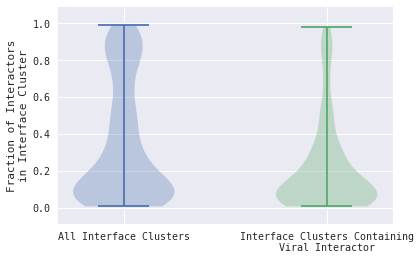

In [793]:
plt.violinplot([cluster_fractions, [-1]])
plt.violinplot([[-1], viral_fractions])
plt.ylim(-0.09, 1.09)
plt.ylabel("Fraction of Interactors\nin Interface Cluster")
plt.xticks([1, 2], ["All Interface Clusters", "Interface Clusters Containing\nViral Interactor"])

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([ 5.23809524,  3.96825397,  2.53968254,  0.71428571,  1.26984127,
         1.34920635,  1.26984127,  0.23809524,  0.23809524,  0.        ,
         0.95238095,  0.15873016,  0.23809524,  0.15873016,  0.07936508,
         0.23809524,  0.23809524,  0.63492063,  0.31746032,  0.15873016]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

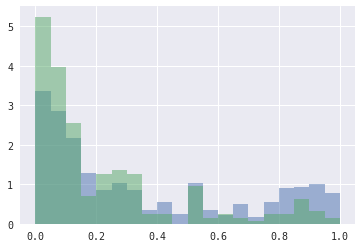

In [794]:
plt.hist(cluster_fractions, range=(0, 1), bins=20, alpha=0.5, normed=True)
plt.hist(viral_fractions, range=(0, 1), bins=20, alpha=0.5, normed=True)

In [799]:
# Determine Order for Similarity Comparisons for all human side
ires_orders2 = []
for human in tqdm_notebook(human2dm.keys()):
    dm, names = human2dm[human]
    
    if(dm.shape[0] == 1):
        p2, p1 = names[0].split("_")
        p1 = "COVID19" + p1
        ires = inter2ires[(p1, p2)]["P2_Ires"]
        ires_orders2.append(pd.DataFrame([[p1, p2, 1, p1, 0, 1, ires]], columns=list(ires_orders)))
        continue
    #print dm.shape, names[0]
    #continue
    
    # Reformat distance matrix to include kmer name
    dm_df = pd.DataFrame(1-dm, columns=names, index=names)

    # Generate linkage from distance matrix
    linkage = hierarchy.linkage(distance.squareform(dm_df), method="complete")
    
    
    # Compile Ordering for Interface Residue Comparisons
    from collections import defaultdict

    # Reformat Linkages
    i = 0
    new_linkage = []
    cluster2height = defaultdict(int)
    for c1, c2, d, n in linkage:
        c1, c2 = int(c1), int(c2)
        if(c1) < len(dm_df):
            c1 = list(dm_df)[c1]
        if(c2) < len(dm_df):
            c2 = list(dm_df)[c2]
        new_linkage.append([c1, c2, d, n, len(dm_df) + i])
        cluster2height[len(dm_df) + i] = d
        i += 1

    import networkx as nx

    # Convert Linkages into graph
    g = nx.Graph()
    for child1, child2, dist, n, node in new_linkage[::-1]:
        g.add_edge(node, child1, weight=cluster2height[node] - cluster2height[child1])
        g.add_edge(node, child2, weight=cluster2height[node] - cluster2height[child2])

    # Store distance between all nodes from same protein
    data = []
    for n1 in list(dm_df):
        p2A, p1A = n1.split("_")
        if((not p1A.upper() == p1A) or len(p1A) == 1):
            p1A = "COVID19" + p1A
        else:
            continue
        for n2 in list(dm_df):
            p2B, p1B = n2.split("_")
            if((not p1B.upper() == p1B) or len(p1B) == 1):
                p1B = "COVID19" + p1B
            if(p2A != p2B):
                continue
            
            data.append([p1A, p2A, 1, p1B, (nx.shortest_path_length(g, n1, n2, weight="weight"), nx.shortest_path_length(g, n1, n2))])
    ires_orders_tmp = pd.DataFrame(data, columns=["P1", "P2", "Prot", "Interactor", "Dist"]).sort_values(["P1", "P2", "Dist"])

    # Reformat / Assign Order
    ires_orders_tmp["Order"] = 0
    keys = ires_orders_tmp[["P1", "P2"]].apply(lambda x: tuple(x), axis=1)
    for inter, g_df in ires_orders_tmp.groupby(["P1", "P2"]):
        ires_orders_tmp.ix[keys == inter, "Order"] = range(len(g_df))

    ires_orders_tmp = ires_orders_tmp.drop("Dist", axis=1)
    
    # Set Ires
    inter2ires = ires_df.set_index(["P1", "P2"])[["P1_Ires", "P2_Ires"]].to_dict(orient="index")
    inter2similarity = ires_similarities.set_index(["P1A", "P2A", "P1B", "P2B"])["Jaccard"].to_dict()
    for k, v in list(inter2similarity.iteritems()):
        inter2similarity[k[0], k[3], k[2], k[1]] = v
    ires_orders_tmp["Similarity"] = ires_orders_tmp[["P1", "P2", "Interactor"]].apply(lambda x: inter2similarity[(x[1], x[0], x[1], x[2])], axis=1)
    
    tmp = insider[(insider["P1"] == p2A)|(insider["P2"] == p2A)]
    def do(p1, p2):
        if("COVID" in p1):
            return inter2ires[(p1, p2)]["P2_Ires"]
        else:
            try:
                return tmp[tmp["P1"] == p1]["P2_IRES"].values[0]
            except:
                try:
                    return tmp[tmp["P2"] == p1]["P1_IRES"].values[0]
                except:
                    print p1, p2
                    raise
    ires_orders_tmp["Ires"] = ires_orders_tmp[["Interactor", "P2"]].apply(lambda x: do(*x), axis=1)
    
    ires_orders2.append(ires_orders_tmp)

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:69: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [800]:
ires_orders2 = pd.concat(ires_orders2)

In [801]:
len(ires_orders2)

7344

In [802]:
ires_orders2

P1      P2  Prot   Interactor  Order  Similarity  \
0   COVID19nsp7  P51149     1  COVID19nsp7      0    1.000000   
29  COVID19nsp7  P51149     1       Q96NA2      1    0.130435   
49  COVID19nsp7  P51149     1       P24386      2    0.121212   
2   COVID19nsp7  P51149     1       P51991      3    0.200000   
19  COVID19nsp7  P51149     1       Q2TU89      4    0.142857   
1   COVID19nsp7  P51149     1       P51149      5    0.041667   
41  COVID19nsp7  P51149     1       P02751      6    0.111111   
56  COVID19nsp7  P51149     1       P51149      7    0.041667   
24  COVID19nsp7  P51149     1       Q6MZF9      8    0.111111   
25  COVID19nsp7  P51149     1       Q7Z3C6      9    0.066667   
35  COVID19nsp7  P51149     1       Q9UL26     10    0.225806   
39  COVID19nsp7  P51149     1       O14964     11    0.062500   
3   COVID19nsp7  P51149     1       P60369     12    0.111111   
4   COVID19nsp7  P51149     1       P60411     13    0.111111   
43  COVID19nsp7  P51149     1       P07741     14    0.230769   
53  COVID19nsp7  P51149     1       P50570     15    0.222222   
5   COVID19nsp7  P51149     1       P61006     16    0.208333   
6   COVID19nsp7  P51149     1       P61018     17    0.217391   
9   COVID19nsp7  P51149     1       P61026     18    0.260870   
13  COVID19nsp7  P51149     1       P62820     19    0.217391   
33  COVID19nsp7  P51149     1       Q9NVJ2     20    0.217391   
57  COVID19nsp7  P51149     1       P61006     21    0.208333   
59  COVID19nsp7  P51149     1       P61026     22    0.260870   
61  COVID19nsp7  P51149     1       P62820     23    0.217391   
7   COVID19nsp7  P51149     1       P61019     24    0.260870   
32  COVID19nsp7  P51149     1       Q9H0U4     25    0.217391   
50  COVID19nsp7  P51149     1       P38646     26    0.208333   
58  COVID19nsp7  P51149     1       P61019     27    0.260870   
8   COVID19nsp7  P51149     1       P61020     28    0.217391   
16  COVID19nsp7  P51149     1       Q13404     29    0.217391   
..          ...     ...   ...          ...    ...         ...   
13  COVID19nsp9  Q9BVL2     1       P37198      8    0.323077   
11  COVID19nsp9  Q9BVL2     1       Q13077      9    0.323077   
10  COVID19nsp9  Q9BVL2     1       Q12906     10    0.323077   
5   COVID19nsp9  Q9BVL2     1       P25054     11    0.323077   
9   COVID19nsp9  Q9BVL2     1       P42858     12    0.323077   
3   COVID19nsp9  Q9BVL2     1       Q9UMX0     13    0.323077   
4   COVID19nsp9  Q9BVL2     1       O96008     14    0.323077   
0   COVID19nsp8  P82675     1  COVID19nsp8      0    1.000000   
16  COVID19nsp8  P82675     1       P82673      1    0.000000   
15  COVID19nsp8  P82675     1       P82664      2    0.000000   
14  COVID19nsp8  P82675     1       P62829      3    0.000000   
13  COVID19nsp8  P82675     1       P51398      4    0.000000   
12  COVID19nsp8  P82675     1       P49411      5    0.000000   
11  COVID19nsp8  P82675     1       P21912      6    0.000000   
10  COVID19nsp8  P82675     1       P18621      7    0.000000   
9   COVID19nsp8  P82675     1       P13639      8    0.000000   
8   COVID19nsp8  P82675     1       O75955      9    0.000000   
7   COVID19nsp8  P82675     1       O75844     10    0.000000   
6   COVID19nsp8  P82675     1       Q9ULV4     11    0.000000   
5   COVID19nsp8  P82675     1       Q9BTV4     12    0.000000   
4   COVID19nsp8  P82675     1       Q96A35     13    0.000000   
3   COVID19nsp8  P82675     1       Q92731     14    0.000000   
1   COVID19nsp8  P82675     1       Q10471     15    0.000000   
2   COVID19nsp8  P82675     1       Q12906     16    0.000000   
0   COVID19nsp8  Q13206     1  COVID19nsp8      0    1.000000   
5   COVID19nsp8  Q13206     1       V9HWH2      1    0.172414   
4   COVID19nsp8  Q13206     1       Q9NY93      2    0.172414   
3   COVID19nsp8  Q13206     1       Q8TDD1      3    0.172414   
1   COVID19nsp8  Q13206     1       Q13610      4    0.172414   
2   COVID19nsp8  Q13206     1       Q15397      

In [803]:
ires_orders_final = pd.concat([ires_orders, ires_orders2])

In [807]:
def do(p1, p2, prot, ires):
    mask = np.zeros(len(uni2seq[[p1, p2][prot]]))
    if(pd.isnull(ires)):
        return ";".join([str(int(x)) for x in mask])
    
    mask[[int(x)-1 for x in ires.split(",")]] = 1
    return ";".join([str(int(x)) for x in mask])
# FUNCTION END
ires_orders_final["Ires_Mask"] = ires_orders_final[["P1", "P2", "Prot", "Ires"]].apply(lambda x: do(*x), axis=1)

In [812]:
ires_orders_final.sort_values(["P1", "P2", "Prot"]).to_csv("Data/Ordered_Ires_Comparisons.txt", sep="\t", index=None)

In [2]:
ires_orders_final = pd.read_csv("Data/Ordered_Ires_Comparisons.txt", sep="\t")

In [3]:
from jfb_tools import batchUniProtAPI

In [5]:
s = [x for x in set(ires_orders_final["P1"].to_list() + ires_orders_final["P2"].to_list() + ires_orders_final["Interactor"].to_list()) if not "COVID19" in x]
tmp = dict(zip(s, batchUniProtAPI(s, source_id="ACC", target_id="GENENAME")))
s = set(s)

In [17]:
tmp2 = dict(zip(list(s), batchUniProtAPI(list(s), source_id="ACC", target_id="GENENAME", batch_size=1)))
tmp == tmp2

False

In [13]:
set(batchUniProtAPI([k for k, v in tmp.iteritems() if v == ""], source_id="ACC", target_id="GENENAME", batch_size=1))

{''}

In [8]:
ires_orders_final["P1 (Gene)"] = ires_orders_final["P1"].map(lambda x: tmp[x] if x in s else "")
ires_orders_final["P2 (Gene)"] = ires_orders_final["P2"].map(lambda x: tmp[x] if x in s else "")
ires_orders_final["Interactor (Gene)"] = ires_orders_final["Interactor"].map(lambda x: tmp[x] if x in s else "")

In [10]:
ires_orders_final[(ires_orders_final["Interactor"].map(lambda x: not "COVID" in x))&(ires_orders_final["Interactor (Gene)"] == "")].drop_duplicates("Interactor")

P1 P1 (Gene)      P2 P2 (Gene)  Prot Interactor  \
71         COVID19E            P25440      BRD2     1     Q9BSD8   
80         COVID19E            Q6UX04     CWC27     1     Q7Z763   
105        COVID19E            Q86VM9    ZC3H18     1     Q96BA7   
184        COVID19M            O75439     PMPCB     1     Q86U11   
283        COVID19M            P05026    ATP1B1     1     Q8IZH9   
284        COVID19M            P05026    ATP1B1     1     B7Z8L6   
299        COVID19M            P05026    ATP1B1     1     Q86SZ9   
405        COVID19M            P11310     ACADM     1     Q8TAS0   
460        COVID19M            P13804      ETFA     1     Q59H77   
493        COVID19M            P13804      ETFA     1     Q53ET8   
554        COVID19M            P27105      STOM     1     Q59ES8   
644        COVID19M            P38606   ATP6V1A     1     Q53ES0   
814        COVID19M            Q10713     PMPCA     1     Q59EL2   
1024       COVID19M            Q96CW5   TUBGCP3     1     Q96BE0   
1354       COVID19M            Q9NQC3      RTN4     1     Q6ZMM6   
1521       COVID19M            Q9Y312      AAR2     1     A8K1F4   
1604       COVID19N            O43818      RRP9     1     Q6LBS5   
1644       COVID19N            P11940    PABPC1     1     Q59GJ0   
1648       COVID19N            P11940    PABPC1     1     Q7KZX8   
1674       COVID19N            P11940    PABPC1     1     Q59GL1   
1712       COVID19N            P11940    PABPC1     1     Q96B14   
1734       COVID19N            P11940    PABPC1     1     Q6ZP53   
1743       COVID19N            P11940    PABPC1     1     Q53FC3   
1870       COVID19N            P67870    CSNK2B     1     Q53EU0   
1872       COVID19N            P67870    CSNK2B     1     Q53GA5   
1874       COVID19N            P67870    CSNK2B     1     Q59EF7   
1876       COVID19N            P67870    CSNK2B     1     Q59FP7   
1878       COVID19N            P67870    CSNK2B     1     Q59FV0   
1880       COVID19N            P67870    CSNK2B     1     Q59GY7   
1882       COVID19N            P67870    CSNK2B     1     Q59H80   
...             ...       ...     ...       ...   ...        ...   
7653    COVID19nsp7            O00116      AGPS     1     Q59HG9   
7794    COVID19nsp7            P00387    CYB5R3     1     Q59ES3   
8057    COVID19nsp7            P51149     RAB7A     1     Q5JPT6   
8434    COVID19nsp7            P61586      RHOA     1     B3KNU0   
8455    COVID19nsp7            P61586      RHOA     1     Q59EA4   
8523    COVID19nsp7            P62820     RAB1A     1     Q53EV1   
8539    COVID19nsp7            P62820     RAB1A     1     Q59ED0   
8685    COVID19nsp7            P62873      GNB1     1     Q53FC7   
9534    COVID19nsp8            O96028      NSD2     1     Q9UBT1   
9806    COVID19nsp8            Q4G0J3     LARP7     1     Q5JB53   
10275   COVID19nsp8            Q9NY61      AATF     1     Q9P0T0   
10504   COVID19nsp9            P35658    NUP214     1     Q6XYD1   
10511   COVID19nsp9            P35658    NUP214     1     Q08G24   
10690   COVID19nsp9            Q15056     EIF4H     1     Q59FF7   
10696   COVID19nsp9            Q15056     EIF4H     1     Q59HH3   
10777   COVID19nsp9            Q86YT6      MIB1     1     Q99740   
10899   COVID19nsp9            Q99567     NUP88     1     Q59H94   
11167  COVID19orf10            Q15369      ELOC     1     Q8WVM9   
11432  COVID19orf3a            Q9H270     VPS11     1     Q8NC57   
11480  COVID19orf3b            Q9UJZ1    STOML2     1     Q9H4N1   
11615  COVID19orf7a            Q9NU22      MDN1     1     Q53G92   
11873   COVID19orf8            P00750      PLAT     1     Q59FG2   
12870   COVID19orf8            Q8IV08      PLD3     1     Q53F48   
13997   COVID19orf8            Q9H8W4   PLEKHF2     1     Q15559   
14228   COVID19orf8            Q9UHI8   ADAMTS1     1     Q59FG9   
14292   COVID19orf8            Q9Y4L1     HYOU1     1     Q59FD4   
14438  COVID19orf9b            O14745  SLC9A3R1     1     Q59F04   
14467

In [11]:
ires_orders_final[["P1", "P1 (Gene)", "P2", "P2 (Gene)", "Prot", "Interactor", "Interactor (Gene)", "Order", "Similarity", "Ires", "Ires_Mask"]].to_csv("Data/Ordered_Ires_Comparisons.txt", sep="\t", index=None)

In [7]:
tmp["Q9UF11"]

'PLEKHB1'

In [4]:
batchUniProtAPI(["Q9UF11"], source_id="ACC", target_id="GENENAME")

['PLEKHB1']

# Parse and Clean Drug List

In [354]:
drugs = pd.read_csv("[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/Krogan_Drug_Candidates.txt", sep="\t")

In [355]:
# Clean entries with multiple gene names in one row
rows = []
for row in drugs.values:
    row = list(row)
    if("/" in row[1]):
        targets = row[1].split("/")
        if(len(targets[1]) <= 2):
            targets = (targets[0], targets[0][:-1] + targets[-1])
            targets = [x if x != "EIF4EH" else "EIF4H" for x in targets]
        else:
            pass
    elif(" " in row[1]):
        if("NUPs" in row[1]):
            targets = ['NUP210', 'NUP214', 'NUP62', 'NUP54', 'NUP88', 'NUP58', 'NUP98', 'RAE1']
        else:
            targets = [row[1]]
    else:
        targets = [row[1]]
    if(targets == ["NDUFs"]):
        targets = ["NDUFAF2", "NDUFAF1", "NDUFB9"]
    targets = set(my.flatten([x.strip().split("\n") for x in targets]))
    for t in targets:
        rows.append([row[0], t] + row[2:])
drugs = pd.DataFrame(rows, columns=list(drugs))

In [356]:
len(drugs.drop_duplicates("Compound Name"))

69

In [357]:
# Match by human interacting gene name
interactions = pd.read_csv("[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/COVID19_Interactome.txt", sep="\t")

m = drugs.join(interactions.set_index("PreyGene"), on="Human Gene", how="left")

# Select / Rename columns and save
m = m[["Compound Name", "Human Gene", "Preys", "Bait", "Structures (PDB)", "Drug Status", "Activity Description", "Activity Description.1", "Reference", "Smiles", "ZINC_ID", "Purchase notes", "Source"]]
m.columns = ["Compound Name", "Human Gene", "Human ID", "Viral ID", "Human PDBs", "Drug Status", "Activity Type", "Activity", "Reference", "Smiles", "ZINC_ID", "Purchase Notes", "Source"]

m.to_csv("Data/Krogan_Drug_Candidates.txt", sep="\t", index=None)

In [272]:
print len(m[~pd.isnull(m["Human ID"])].drop_duplicates("Compound Name"))
print len(m[~pd.isnull(m["Human ID"])])

50
76


In [847]:
# Look for PDB files with these ligands
# Doesn't seem to work because the Smiles strings are not reconized by PDB?

In [848]:
pdbliginfo = pd.read_csv("[REDACTED_PATH]/Collaborators/Resource_Maintenance/2019_01_11_PDB_Rest_Services/pdb2ligands.txt", sep="\t")

In [849]:
human_pdbs = set(my.flatten(m["Human PDBs"].map(lambda x: x.split(";") if not pd.isnull(x) else []).to_list()))
tmp = pdbliginfo[pdbliginfo["PDB_ID"].map(lambda x: x in human_pdbs)]

In [850]:
tmp

PDB_ID  Chain chemicalID  \
1840     1B3O    NaN        CPR   
1841     1B3O    NaN        SAE   
1842     1B3O    NaN        UNX   
3331     1DS5    NaN        AMP   
3332     1DS5    NaN         MG   
15320    1JWH    NaN        ANP   
15321    1JWH    NaN        PO4   
15322    1JWH    NaN         ZN   
23562    1R47    NaN        EDO   
23563    1R47    NaN        FUC   
23564    1R47    NaN        GAL   
23565    1R47    NaN        MAN   
23566    1R47    NaN        NAG   
25224    1QF8    NaN         MG   
25225    1QF8    NaN        MSE   
25226    1QF8    NaN         ZN   
30595    1R46    NaN        EDO   
30596    1R46    NaN        FUC   
30597    1R46    NaN        MAN   
30598    1R46    NaN        NAG   
32852    1NF7    NaN          K   
32853    1NF7    NaN        MYD   
32854    1NF7    NaN        RVP   
32855    1NF7    NaN        UNK   
33086    1NFB    NaN        CPR   
33087    1NFB    NaN        NAD   
35082    1X0J    NaN        DTT   
35083    1X0J    NaN        MES   
35084    1X0J    NaN        MSE   
49812    2CBZ    NaN        ATP   
...       ...    ...        ...   
285164   6FNX    NaN        EDO   
285863   6AFR    NaN        9E3   
286104   6CD4    NaN        EDO   
286105   6CD4    NaN        EX1   
286366   6C4D    NaN        EJP   
288599   6FT4    NaN        E5W   
288615   6FT3    NaN        E5T   
288616   6FT3    NaN        EDO   
289075   6G0Q    NaN        ALY   
289076   6G0Q    NaN        EDO   
289102   6G0O    NaN        ALY   
289103   6G0O    NaN        EDO   
289301   6HHO    NaN        G4W   
289995   6G3O    NaN        1PE   
289996   6G3O    NaN         CA   
289997   6G3O    NaN        EL8   
289998   6G3O    NaN        NaN   
289999   6G3O    NaN        PG4   
290000   6G3O    NaN        SO4   
290001   6G3O    NaN         ZN   
290362   6G0P    NaN        ALY   
290363   6G0P    NaN        EDO   
290364   6G0S    NaN        ALY   
290365   6G0S    NaN        EDO   
290793   6G0R    NaN        ALY   
290794   6G0R    NaN        EDO   
290869   6HDQ    NaN        EDO   
290870   6HDQ    NaN        FZE   
291328   6FSY    NaN        E5Q   
291329   6FSY    NaN        EDO   

                                             chemicalName               type  \
1840            6-CHLOROPURINE RIBOSIDE, 5'-MONOPHOSPHATE        non-polymer   
1841       SELENAZOLE-4-CARBOXYAMIDE-ADENINE DINUCLEOTIDE        non-polymer   
1842                                  UNKNOWN ATOM OR ION        non-polymer   
3331                              ADENOSINE MONOPHOSPHATE        non-polymer   
3332                                        MAGNESIUM ION        non-polymer   
15320         PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER        non-polymer   
15321                                       PHOSPHATE ION        non-polymer   
15322                                            ZINC ION        non-polymer   
23562                                      1,2-ETHANEDIOL        non-polymer   
23563                                      ALPHA-L-FUCOSE         saccharide   
23564                                    BETA-D-GALACTOSE       D-saccharide   
23565                                     ALPHA-D-MANNOSE       D-saccharide   
23566                              N-ACETYL-D-GLUCOSAMINE       D-saccharide   
25224                                       MAGNESIUM ION        non-polymer   
25225                                    SELENOMETHIONINE  L-peptide linking   
25226                                            ZINC ION        non-polymer   
30595                                      1,2-ETHANEDIOL        non-polymer   
30596                                      ALPHA-L-FUCOSE         saccharide   
30597                                     ALPHA-D-MANNOSE       D-saccharide   
30598                              N-ACETYL-D-GLUCOSAMINE       D-saccharide   
32852                                       POTASSIUM ION        non-polymer   
32853   {[5-(6-AMINO-PURIN-7-YL)-3,4-DIHYDROXY-TETRAHY...        non-polymer

In [851]:
m[m["Compound Name"].map(lambda x: "daun" in x.lower())]

Compound Name Human Gene Human ID         Viral ID Human PDBs  \
55  Daunorubicin      ABCC1   P33527  SARS-CoV2 orf9c  2CBZ;4C3Z   

          Drug Status             Activity Type Activity Reference  \
55  Approved (Cancer)  Topoisomerase inhibitor   Ki = 70   9647783   

                                               Smiles      ZINC_ID  \
55  C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  ZINC3917708   

            Purchase Notes      Source  
55  Cayman Chemicals 14159  Literature

In [852]:
smiles = set(m["Smiles"].map(lambda x: x.upper()).to_list())

In [853]:
pdbliginfo[pdbliginfo["smiles"].map(lambda x: x.upper() in smiles)]

PDB_ID  Chain chemicalID chemicalName         type      MW  \
4098     110D    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
6445     1D11    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
7699     152D    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
7887     1D10    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
8444     1D33    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
8518     1DA0    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
13247    1JO2    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
22899    1O0K    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
34234    1VTI    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
34235    1VTH    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
48324    2D34    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
91423    308D    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
102716   3F8F    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
133150   3TVB    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
158498   427D    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   
185822   4KR8    NaN        DM1   DAUNOMYCIN  non-polymer  527.52   

              formula                                              InChI  \
4098    C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
6445    C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
7699    C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
7887    C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
8444    C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
8518    C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
13247   C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
22899   C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
34234   C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
34235   C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
48324   C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
91423   C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
102716  C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
133150  C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
158498  C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   
185822  C27 H29 N O10  InChI=1S/C27H29NO10/c1-10-22(30)14(28)7-17(37-...   

                           InChIKey  \
4098    STQGQHZAVUOBTE-VGBVRHCVSA-N   
6445    STQGQHZAVUOBTE-VGBVRHCVSA-N   
7699    STQGQHZAVUOBTE-VGBVRHCVSA-N   
7887    STQGQHZAVUOBTE-VGBVRHCVSA-N   
8444    STQGQHZAVUOBTE-VGBVRHCVSA-N   
8518    STQGQHZAVUOBTE-VGBVRHCVSA-N   
13247   STQGQHZAVUOBTE-VGBVRHCVSA-N   
22899   STQGQHZAVUOBTE-VGBVRHCVSA-N   
34234   STQGQHZAVUOBTE-VGBVRHCVSA-N   
34235   STQGQHZAVUOBTE-VGBVRHCVSA-N   
48324   STQGQHZAVUOBTE-VGBVRHCVSA-N   
91423   STQGQHZAVUOBTE-VGBVRHCVSA-N   
102716  STQGQHZAVUOBTE-VGBVRHCVSA-N   
133150  STQGQHZAVUOBTE-VGBVRHCVSA-N   
158498  STQGQHZAVUOBTE-VGBVRHCVSA-N   
185822  STQGQHZAVUOBTE-VGBVRHCVSA-N   

                                                   smiles  
4098    C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
6445    C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
7699    C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
7887    C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
8444    C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
8518    C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
13247   C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
22899   C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
34234   C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
34235   C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
48324   C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
91423   C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
102716  C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](Cc...  
133150  C[C@H]1[C@H]([C@H](C[C@@H](O

In [842]:
s = "".join(sorted(tmp[tmp["MW"] > 100]["chemicalName"].unique())).lower()

In [846]:
m[m["Compound Name"].map(lambda x: x.lower() in s)]

Compound Name Human Gene Human ID         Viral ID  \
10      CPI-0610       BRD4   O60885      SARS-CoV2 E   
11      CPI-0610       BRD2   P25440      SARS-CoV2 E   
78     Ribavirin     IMPDH2   P12268  SARS-CoV2 nsp14   

                                           Human PDBs  \
10  2I8N;2LSP;2MJV;2N3K;2NCZ;2ND0;2ND1;2NNU;2OSS;2...   
11  1X0J;2DVQ;2DVR;2DVS;2DVV;2E3K;2G4A;2YDW;2YEK;3...   
78                           1B3O;1NF7;1NFB;6I0M;6I0O   

                   Drug Status    Activity Type  \
10              Clinical Trial    BRD inhibitor   
11              Clinical Trial    BRD inhibitor   
78  Approved (Viral infection)  IMPDH inhibitor   

                         Activity Reference  \
10  BRD2 IC50 = 25 BRD4 IC50 = 18  26815195   
11  BRD2 IC50 = 25 BRD4 IC50 = 18  26815195   
78                 IC50 = 100-250  22555152   

                                               Smiles        ZINC_ID  \
10  CC1=NOC2=C1C3=CC=CC=C3C(=N[C@H]2CC(=O)N)C4=CC=...  ZINC200480149   
11  CC1=NOC2=C1C3=CC=CC=C3C(=N[C@H]2CC(=O)N)C4=CC=...  ZINC200480149   
78   NC(=O)c1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)n1   ZINC1035331    

            Purchase Notes      Source  
10          Abcam ab230374      Expert  
11          Abcam ab230374      Expert  
78  Cayman Chemicals 16757  Literature

In [1519]:
0

0

# Generate PDB files for each of the ligands

In [1518]:
for name, smiles in drugs.drop_duplicates(["Compound Name"])[["Compound Name", "Smiles"]].values:
    # This SMILES String is improperly formatted. I looked up the "correct" string here...
    # https://www.medchemexpress.com/dBET6.html?src=google-product&gclid=EAIaIQobChMIqYf5m5ul6QIVT8DICh20VQh-EAAYASAAEgLmkPD_BwE
    if(name == "dBET6"):
        smiles = "O=C(NCCCCCCCCNC(COC1=CC=CC(C(N2C(CC3)C(NC3=O)=O)=O)=C1C2=O)=O)C[C@H]4C5=NN=C(C)N5C6=C(C(C)=C(C)S6)C(C7=CC=C(Cl)C=C7)=N4"
    print os.system("obabel -:\"{0}\" --gen3d -opdb -O Data/Ligands/{1}.pdb -d".format(smiles, name.replace("-", "_").replace(" ", "_").split("(")[0]))
    print os.system("obabel -:\"{0}\" --gen3d -osvg -O Data/Ligands/Images/{1}.svg -d".format(smiles, name.replace("-", "_").replace(" ", "_").split("(")[0]))
    #os.system("obabel -i pdb {0} -o pdb -O {0} -d".format(smiles, name.replace("-", "_").replace(" ", "_").split("(")[0]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [863]:
len(m[~pd.isnull(m["Viral ID"])])

76

In [856]:
import os

In [864]:
m.values[81]

array(['Ruxolitinib', 'MARK3', 'P27448', 'SARS-CoV2 orf9b', '2QNJ;3FE3',
       'Approved (Myelofibrosis)',
       'Multi-targeted protein kinase inhibitor ',
       'MARK1 KD = 660 MARK3 KD > 10000', '22037378',
       'C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3',
       'ZINC43207851\xc2\xa0', 'Cayman Chemicals 11609', 'Literature'], dtype=object)

In [917]:
!ls [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/reindexed_structures/* | wc

    386     386   48464


# Generate Reindexed Structures for all Human Proteins

In [920]:
import glob

In [924]:
sifts = pd.read_csv("[REDACTED_PATH]/sifts/parsed_files/pdbresiduemapping.txt", sep="\t")
pos_maps = sifts.set_index(["PDB", "Chain", "UniProt"])[["MappableResInPDBChainOnUniprotBasis", "MappableResInPDBChainOnPDBBasis"]].apply(lambda x: dict(zip(unzip_res_range(x[1]), unzip_res_range(x[0]))), axis=1).to_dict()

In [921]:
# Read ECLAIR Preds
inter2preds = glob.glob("[REDACTED_PATH]/Collaborators/Eclair_Runs/2020_04_22_COVID19_Human_Interactome/Predictions/*")
inter2preds = {os.path.basename(x).split(".")[0]:pd.read_pickle(x) for x in inter2preds}

In [688]:
# Read Interactions
interactions = pd.read_csv("[REDACTED_PATH]/Collaborators/Eclair_Runs/2020_04_22_COVID19_Human_Interactome/Interactions.txt", names=["P1", "P2"], sep="\t")

In [923]:
# Select Homology Models for COVID Protein
#interactions["P1 PDB"] = interactions["P1"].map(lambda x: glob.glob("[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/modelling_test/{0}.*pdb".format(x.replace("COVID19", "")))[0] if glob.glob("[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/modelling_test/{0}.*pdb".format(x.replace("COVID19", ""))) else np.nan)
#interactions.ix[interactions["P1"] == "COVID19nsp5C145A", "P1 PDB"] = "[REDACTED_PATH]/Collaborators/Lab_Member_Requests/Haiyuan/2020_03_27_COVID19_3DInteractome/modelling_test/nsp5_C145A.B99990001.pdb"

interactions["P1 PDB"] = interactions["P1"].map(lambda x: glob.glob("[REDACTED_PATH]/eclair/data/modbase/models/hash/{0}.pdb".format(x.replace("COVID19", "")))[0] if glob.glob("[REDACTED_PATH]/eclair/data/modbase/models/hash/{0}.pdb".format(x.replace("COVID19", ""))) else np.nan)
interactions.ix[interactions["P1"] == "COVID19nsp5C145A", "P1 PDB"] = glob.glob("[REDACTED_PATH]/eclair/data/modbase/models/hash/nsp5_C145A.pdb")[0]

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [925]:
# Select Best PDB Model for Human Protein (best overlap with ECLAIR Predictions)
def get_best_pdb(cov, uni):
    # First Fetch ECLAIR Predictions
    pair = "_".join(sorted([cov, uni]))
    preds = inter2preds[pair]
    preds = preds[preds["Prot"] == (uni > cov)].set_index("Pos")["Pred"].to_dict()
    
    
    tmp = sifts[sifts["UniProt"] == uni][["PDB", "Chain", "UniProt", "MappableResInPDBChainOnUniprotBasis"]].copy()
    if(len(tmp) == 0):
        return np.nan, np.nan
    elif(len(tmp) == 1):
        return tmp[["PDB", "Chain"]].values[0]
    
    
    tmp["Len"] = tmp["MappableResInPDBChainOnUniprotBasis"].map(lambda x: len(unzip_res_range(x)))
    tmp["Weighted_Len"] = tmp["MappableResInPDBChainOnUniprotBasis"].map(lambda x:sum([preds[int(x)] for x in unzip_res_range(x)]))
    
    tmp.sort_values(["Weighted_Len", "Len"], ascending=False)
    
    return tmp[["PDB", "Chain"]].values[0]    
# FUNCTION END
tmp = interactions[["P1", "P2"]].apply(lambda x: get_best_pdb(*x), axis=1)
interactions["P2 PDB"] = [x[0] for x in tmp]
interactions["P2 Chain"] = [x[1] for x in tmp]

In [926]:
# Add in Modbase Models where no PDB structure available
modbase = pd.read_csv("[REDACTED_PATH]/modbase/parsed_files/all_modbase_models.txt", sep="\t")
modbase[modbase["modpipe_quality_score"] >= 1.1].drop_duplicates("uniprot")

uni2modbase = modbase.set_index("uniprot")["modbase_modelID"].map(lambda x: ("[REDACTED_PATH]/modbase/data/hash/{0}.pdb".format(x))).to_dict()

interactions.ix[pd.isnull(interactions["P2 PDB"]), "P2 Chain"] = " "
interactions.ix[pd.isnull(interactions["P2 PDB"]), "P2 PDB"] = interactions.ix[pd.isnull(interactions["P2 PDB"]), "P2"].map(lambda x: uni2modbase[x] if x in uni2modbase else np.nan)

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [927]:
interactions

P1      P2                                             P1 PDB  \
0        COVID19E  O00203                                                NaN   
1        COVID19E  O60885                                                NaN   
2        COVID19E  P25440                                                NaN   
3        COVID19E  Q6UX04                                                NaN   
4        COVID19E  Q86VM9                                                NaN   
5        COVID19E  Q8IWA5                                                NaN   
6        COVID19M  O75439                                                NaN   
7        COVID19M  O95070                                                NaN   
8        COVID19M  P05026                                                NaN   
9        COVID19M  P11310                                                NaN   
10       COVID19M  P13804                                                NaN   
11       COVID19M  P27105                                                NaN   
12       COVID19M  P38435                                                NaN   
13       COVID19M  P38606                                                NaN   
14       COVID19M  P48556                                                NaN   
15       COVID19M  Q00765                                                NaN   
16       COVID19M  Q10713                                                NaN   
17       COVID19M  Q4KMQ2                                                NaN   
18       COVID19M  Q5JRX3                                                NaN   
19       COVID19M  Q6PML9                                                NaN   
20       COVID19M  Q7L8L6                                                NaN   
21       COVID19M  Q8NEW0                                                NaN   
22       COVID19M  Q96CW5                                                NaN   
23       COVID19M  Q96D53                                                NaN   
24       COVID19M  Q96ER3                                                NaN   
25       COVID19M  Q96HR9                                                NaN   
26       COVID19M  Q96HW7                                                NaN   
27       COVID19M  Q9BQT8                                                NaN   
28       COVID19M  Q9BSJ2                                                NaN   
29       COVID19M  Q9BW92                                                NaN   
..            ...     ...                                                ...   
302  COVID19orf9b  Q9H773  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
303  COVID19orf9b  Q9P0L2  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
304  COVID19orf9b  Q9UKA9  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
305  COVID19orf9b  Q9UL15  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
306  COVID19orf9c  O00124  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
307  COVID19orf9c  O43292  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
308  COVID19orf9c  O76024  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
309  COVID19orf9c  P33527  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
310  COVID19orf9c  P55085  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
311  COVID19orf9c  Q12770  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
312  COVID19orf9c  Q2PZI1  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
313  COVID19orf9c  Q5BJF2  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
314  COVID19orf9c  Q6NXT4  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
315  COVID19orf9c  Q6NXT6  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
316  COVID19orf9c  Q7Z2K6  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
317  COVID19orf9c  Q86UT6  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
318  COVID19orf9c  Q86VR2  [REDACTED_PATH]/eclair/data/modbase/models/hash/or...   
319  COVID19orf9c  Q8TEQ8  

In [929]:
# Reindex structures so they are numbered by Uniprot pos
f2f = dict()
for uni, pdb, chain in tqdm_notebook(interactions[["P2", "P2 PDB", "P2 Chain"]].values):
    if(pd.isnull(pdb)):
        continue
    
    # Handle Modbase Structures (should already be indexed, just copy)
    if(chain == " "):
        os.system("cp {0} Data/Undocked_Structures/{1}_{2}".format(pdb, uni, os.path.basename(pdb)))
        f2f[pdb] = "Data/Undocked_Structures/{0}".format(os.path.basename(pdb))
        continue
    
    pos_map = pos_maps[pdb, chain, uni]
    
    pdb_df = my.pdb2df(pdb)
    pdb_df = pdb_df[pdb_df["Data Type"] == "ATOM"]
    pdb_df = pdb_df[pdb_df["Chain"] == chain]
    def do(x):
        chain, pos = x
        try:
            return pos_map[str(pos)]
        except:
            return -pos
    pdb_df["Residue ID"] = pdb_df[["Chain", "Residue ID"]].apply(do, axis=1)
    
    my.df2pdb("Data/Undocked_Structures/{0}_{1}_{2}.pdb".format(uni, pdb, chain), pdb_df)
    f2f[pdb] = "Data/Undocked_Structures/{0}_{1}_{2}.pdb".format(uni, pdb, chain)

[REDACTED_PATH]/bin/helper.py:3759: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.header = header
[REDACTED_PATH]/bin/helper.py:3760: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.tailer = tailer


In [930]:
# Make sure there are no hydrogens in the proteins
for f in glob.glob("Data/Undocked_Structures/*"):
    os.system("obabel -i pdb {0} -o pdb -O {0} -d".format(f))

# Run Ligand Docking

In [700]:
drug_pairs = pd.read_csv("Data/Krogan_Drug_Candidates.txt", sep="\t")

In [944]:
for drug, uni in drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values:
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    
    drug_f = glob.glob("Data/Ligands/{0}*".format(drug))[0]
    uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    
    pdb_df = my.pdb2df(uni_f)
    
    #pdb_df = my.pdb2df(uni_f)
    #
    #size_x, size_y, size_z = (pdb_df[["X", "Y", "Z"]].max() - pdb_df[["X", "Y", "Z"]].min())
    #center_x = pdb_df["X"].min() + size_x
    #center_y = pdb_df["Y"].min() + size_y
    #center_z = pdb_df["Z"].min() + size_z
    #
    #border = 10
    #size_x, size_y, size_z = size_x + border, size_y + border, size_z + border
    #
    #print "smina -r {0} -l {1} -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1 --center_x {4} --center_y {5} --center_z {6} --size_x {7} --size_y {8} --size_z {9}".format(uni_f, drug_f, uni, drug, center_x, center_y, center_z, size_x, size_y, size_z)
    #print os.system("smina -r {0} -l {1} -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1 --center_x {4} --center_y {5} --center_z {6} --size_x {7} --size_y {8} --size_z {9}".format(uni_f, drug_f, uni, drug), center_x, center_y, center_z, size_x, size_y, size_z)
    
    print "smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1".format(uni_f, drug_f, uni, drug)
    print os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1".format(uni_f, drug_f, uni, drug))
    break

smina -r Data/Undocked_Structures/O60885_2I8N_A.pdb -l Data/Ligands/ABBV_744.pdb --autobox_ligand Data/Undocked_Structures/O60885_2I8N_A.pdb --autobox_add 10 -o Data/Docked_Ligands/O60885_ABBV_744.pdb --exhaustiveness 8 --num_modes 10 --cpu 1
0


In [949]:
%%time
os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 1 --cpu 1".format(uni_f, drug_f, uni, drug))

CPU times: user 0 ns, sys: 532 ms, total: 532 ms
Wall time: 2min 31s


0

In [950]:
%%time
os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1".format(uni_f, drug_f, uni, drug))

CPU times: user 0 ns, sys: 502 ms, total: 502 ms
Wall time: 2min 24s


0

In [951]:
%%time
os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}.pdb --exhaustiveness 8 --num_modes 50 --cpu 1".format(uni_f, drug_f, uni, drug))

CPU times: user 7.58 ms, sys: 497 ms, total: 504 ms
Wall time: 2min 33s


0

In [955]:
%%time
os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}_ex8.pdb --exhaustiveness 8 --num_modes 100 --cpu 1 --seed 0 ".format(uni_f, drug_f, uni, drug))

CPU times: user 3.74 ms, sys: 544 ms, total: 548 ms
Wall time: 2min 26s


0

In [956]:
%%time
os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}_ex40.pdb --exhaustiveness 40 --num_modes 100 --cpu 1 --seed 0".format(uni_f, drug_f, uni, drug))

CPU times: user 25.5 ms, sys: 501 ms, total: 526 ms
Wall time: 11min 57s


0

In [957]:
%%time
os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/{2}_{3}_ex40_CPU.pdb --exhaustiveness 40 --num_modes 100 --cpu 5 --seed 0".format(uni_f, drug_f, uni, drug))

CPU times: user 7.54 ms, sys: 515 ms, total: 523 ms
Wall time: 2min 36s


0

In [960]:
import subprocess as sp

In [977]:
# Run Ligand Docking in Loop
i_num = 1
finished_processes = []
processes = []

max_processes = 5
os.system("rm [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/docking_outputs/*_in_progress*")
while(True):
    print "Docking Iteration", i_num
    
    # Iterate over all Docking Inputs
    for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
        if(os.path.exists("Data/Docked_Ligands/sub_batches/{0}_{1}_{2}.pdb".format(uni, drug, i_num))):
            continue
        
        drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
                
        drug_f = glob.glob("Data/Ligands/{0}*".format(drug))[0]
        try:
            uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
        except IndexError:
            #raise
            print uni
        
        
        # Make Block new jobs if too many running already
        while(True):
            if(len(processes) <= max_processes):
                cmd = "nice smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o Data/Docked_Ligands/sub_batches/{2}_{3}_{4}_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed {4}".format(uni_f, drug_f, uni, drug, i_num)
                p = sp.Popen(cmd, shell=True)
                processes.append({"p":p, "cmd":cmd, "start_time":time.time(), "end_time":None, "in":(drug, uni), "out_f":"Data/Docked_Ligands/sub_batches/{2}_{3}_{4}_in_progress.pdb".format(uni_f, drug_f, uni, drug, i_num)})
                break
            else:
                new_processes = []
                for p in processes:
                    if(p["p"].poll() is None):
                        new_processes.append(p)
                    elif(p["p"].poll() != 0):
                        p["end_time"] = time.time()
                        print "Error", p["p"].poll()
                        print "cmd:", p["cmd"]
                        print "RunTime:", (p["end_time"] - p["start_time"])
                        print
                        finished_processes.append(p)
                    else:
                        p["end_time"] = time.time()
                        print "Finished Docking", p["in"], "in", (p["end_time"] - p["start_time"])
                        os.system("mv {0} {1}".format(p["out_f"], p["out_f"].replace("_in_progress", "")))
                        finished_processes.append(p)
                processes = new_processes
                time.sleep(30)
    i_num += 1

Docking Iteration 1


Finished Docking ('Chloroquine', 'Q99720') in 93.0869550705
Finished Docking ('CPI_0610', 'O60885') in 93.1598799229
Finished Docking ('CPI_0610', 'P25440') in 93.1456370354
Finished Docking ('Minoxidil', 'O00469') in 30.0431530476
Finished Docking ('ABBV_744', 'P25440') in 192.247977972
Finished Docking ('Dabrafenib', 'Q8TD19') in 189.240182161
Q9Y680
Finished Docking ('ABBV_744', 'O60885') in 227.201964855
Finished Docking ('Pevonedistat', 'Q13617') in 152.10731101
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.286497831
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.442340136
Finished Docking ('Rapamycin_', 'Q5T1M5') in 332.296669006
Finished Docking ('dBET6', 'O60885') in 888.852515936
Finished Docking ('dBET6', 'P25440') in 888.898150921
Q9Y680
Finished Docking ('Sapanisertib_', 'Q6PKG0') in 61.1127049923
Finished Docking ('Rapamycin_', 'Q96AY3') in 368.533579826
Finished Docking ('FK_506_', 'Q9Y680') in 364.344027996
Finished Docking ('Verdinexor', 'Q99567') in 212.168694019


Finished Docking ('ZINC4511851', 'Q9H773') in 64.1212608814
Finished Docking ('ZINC4326719', 'Q9H773') in 97.092705965
Finished Docking ('S_verapamil', 'P33527') in 263.301570892
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.114352942
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.137254
Finished Docking ('ZINC95559591', 'P27448') in 220.171016932
Finished Docking ('Chloroquine', 'Q99720') in 94.0341100693
Finished Docking ('CPI_0610', 'O60885') in 94.0188169479
Finished Docking ('ABBV_744', 'O60885') in 224.055327892
Finished Docking ('ABBV_744', 'P25440') in 224.096852064
Finished Docking ('CPI_0610', 'P25440') in 99.0341959
Finished Docking ('Minoxidil', 'O00469') in 34.1531398296
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.303925991
Finished Docking ('Pevonedistat', 'Q13617') in 152.220499992
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.356143951
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.336011171
Finished Docking ('dBET6', 'P25440') in 887.0125920

Finished Docking ('ZINC4326719', 'Q9H773') in 95.0897769928
Finished Docking ('ZINC4511851', 'Q9H773') in 95.111686945
Finished Docking ('S_verapamil', 'P33527') in 263.460012197
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.231770039
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.377110958
Finished Docking ('ZINC95559591', 'P27448') in 220.444249868
Finished Docking ('Chloroquine', 'Q99720') in 94.1442968845
Finished Docking ('CPI_0610', 'O60885') in 94.0805289745
Finished Docking ('ABBV_744', 'O60885') in 193.139225006
Finished Docking ('ABBV_744', 'P25440') in 224.093867064
Finished Docking ('CPI_0610', 'P25440') in 99.002879858
Finished Docking ('Minoxidil', 'O00469') in 34.0807869434
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.125478029
Finished Docking ('Pevonedistat', 'Q13617') in 152.14804101
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.218981981
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.327253819
Finished Docking ('Rapamycin_', 'Q5T1M5') in 42

Finished Docking ('ZINC1775962367', 'Q9H773') in 128.060736895
Finished Docking ('ZINC4326719', 'Q9H773') in 95.1668758392
Finished Docking ('ZINC4511851', 'Q9H773') in 95.234703064
Finished Docking ('S_verapamil', 'P33527') in 264.28557992
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.454746962
Finished Docking ('Chloroquine', 'Q99720') in 94.0977630615
Finished Docking ('ZINC95559591', 'P27448') in 222.588320971
Finished Docking ('CPI_0610', 'O60885') in 95.1033711433
Finished Docking ('CPI_0610', 'P25440') in 66.11835289
Finished Docking ('ABBV_744', 'O60885') in 194.411034822
Finished Docking ('ABBV_744', 'P25440') in 225.472030163
Finished Docking ('Minoxidil', 'O00469') in 33.0345020294
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 222.248636961
Finished Docking ('Pevonedistat', 'Q13617') in 182.194684982
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.359579086
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.352690935
Finished Docking ('dBET6', 'P25440') in 856.8546

Finished Docking ('ZINC1775962367', 'Q9H773') in 128.337232828
Finished Docking ('ZINC4326719', 'Q9H773') in 95.2501330376
Finished Docking ('ZINC4511851', 'Q9H773') in 95.3010370731
Finished Docking ('S_verapamil', 'P33527') in 264.783288956
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.440294027
Finished Docking ('Chloroquine', 'Q99720') in 93.1071028709
Finished Docking ('ZINC95559591', 'P27448') in 222.48053813
Finished Docking ('CPI_0610', 'O60885') in 95.1774220467
Finished Docking ('ABBV_744', 'P25440') in 191.248851061
Finished Docking ('ABBV_744', 'O60885') in 224.365061998
Finished Docking ('CPI_0610', 'P25440') in 98.0793290138
Finished Docking ('Minoxidil', 'O00469') in 34.1646840572
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.28091383
Finished Docking ('Pevonedistat', 'Q13617') in 152.234500885
Finished Docking ('Rapamycin_', 'Q9Y680') in 422.382506132
Finished Docking ('Rapamycin_', 'Q6PKG0') in 452.45598793
Finished Docking ('dBET6', 'P25440') in 887.074

Finished Docking ('ZINC1775962367', 'Q9H773') in 128.281322956
Finished Docking ('ZINC4326719', 'Q9H773') in 95.2993700504
Finished Docking ('ZINC4511851', 'Q9H773') in 95.2333421707
Finished Docking ('S_verapamil', 'P33527') in 263.492642164
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.37533617
Finished Docking ('Chloroquine', 'Q99720') in 94.170058012
Finished Docking ('ZINC95559591', 'P27448') in 222.379866838
Finished Docking ('CPI_0610', 'O60885') in 95.0970511436
Finished Docking ('CPI_0610', 'P25440') in 96.0810749531
Finished Docking ('ABBV_744', 'O60885') in 254.414425135
Finished Docking ('ABBV_744', 'P25440') in 254.41198802
Finished Docking ('Minoxidil', 'O00469') in 32.0422320366
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.255089998
Finished Docking ('Pevonedistat', 'Q13617') in 152.06080389
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.26343298
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.407667875
Finished Docking ('dBET6', 'P25440') in 856.87108

Finished Docking ('ZINC4326719', 'Q9H773') in 95.2409250736
Finished Docking ('ZINC4511851', 'Q9H773') in 95.2614581585
Finished Docking ('S_verapamil', 'P33527') in 264.866187096
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.34098506
Finished Docking ('ZINC95559591', 'Q9UHD2') in 219.254405022
Finished Docking ('Chloroquine', 'Q99720') in 92.0004417896
Finished Docking ('CPI_0610', 'O60885') in 92.0354828835
Finished Docking ('ZINC95559591', 'P27448') in 254.297209024
Finished Docking ('ABBV_744', 'P25440') in 192.171925783
Finished Docking ('ABBV_744', 'O60885') in 225.285753965
Finished Docking ('CPI_0610', 'P25440') in 98.2467029095
Finished Docking ('Minoxidil', 'O00469') in 32.9950838089
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.205043077
Finished Docking ('Pevonedistat', 'Q13617') in 152.151220083
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.471698046
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.43079114
Finished Docking ('dBET6', 'O60885') in 919.09

Finished Docking ('ZINC4326719', 'Q9H773') in 94.1779351234
Finished Docking ('ZINC4511851', 'Q9H773') in 94.1784820557
Finished Docking ('S_verapamil', 'P33527') in 292.811007023
Finished Docking ('ZINC1775962367', 'Q9H773') in 160.402160168
Finished Docking ('ZINC95559591', 'Q9UHD2') in 250.355870008
Finished Docking ('ZINC95559591', 'P27448') in 250.356822968
Finished Docking ('CPI_0610', 'O60885') in 93.0407152176
Finished Docking ('Chloroquine', 'Q99720') in 126.956798077
Finished Docking ('ABBV_744', 'O60885') in 253.100269079
Finished Docking ('ABBV_744', 'P25440') in 253.103882074
Finished Docking ('CPI_0610', 'P25440') in 98.0027768612
Finished Docking ('Minoxidil', 'O00469') in 31.9987368584
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 221.183446169
Finished Docking ('Pevonedistat', 'Q13617') in 182.20076704
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.494432926
Finished Docking ('Rapamycin_', 'Q6PKG0') in 482.667440176
Finished Docking ('Rapamycin_', 'Q5T1M5') in 

Finished Docking ('ZINC4326719', 'Q9H773') in 93.254196167
Finished Docking ('ZINC4511851', 'Q9H773') in 93.278167963
Finished Docking ('ZINC1775962367', 'Q9H773') in 162.565644979
Finished Docking ('S_verapamil', 'P33527') in 325.002705097
Finished Docking ('ZINC95559591', 'P27448') in 218.448699951
Finished Docking ('ZINC95559591', 'Q9UHD2') in 251.660572052
Finished Docking ('Chloroquine', 'Q99720') in 95.2605001926
Finished Docking ('CPI_0610', 'O60885') in 96.2867898941
Finished Docking ('ABBV_744', 'O60885') in 193.558949947
Finished Docking ('CPI_0610', 'P25440') in 67.1901619434
Finished Docking ('ABBV_744', 'P25440') in 256.747389078
Finished Docking ('Minoxidil', 'O00469') in 63.2368888855
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.705806971
Finished Docking ('Pevonedistat', 'Q13617') in 182.30086112
Finished Docking ('Rapamycin_', 'Q9Y680') in 452.590675116
Finished Docking ('Rapamycin_', 'Q6PKG0') in 452.599519968
Finished Docking ('dBET6', 'P25440') in 857.696

Finished Docking ('ZINC4326719', 'Q9H773') in 66.3537321091
Finished Docking ('ZINC4511851', 'Q9H773') in 65.3454480171
Finished Docking ('S_verapamil', 'P33527') in 263.914252996
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.655575037
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.626645088
Finished Docking ('CPI_0610', 'O60885') in 92.1417078972
Finished Docking ('ZINC95559591', 'P27448') in 222.705770969
Finished Docking ('Chloroquine', 'Q99720') in 126.335920095
Finished Docking ('ABBV_744', 'O60885') in 224.62984395
Finished Docking ('ABBV_744', 'P25440') in 193.548660994
Finished Docking ('CPI_0610', 'P25440') in 68.1310698986
Finished Docking ('Minoxidil', 'O00469') in 32.0994691849
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.329024076
Finished Docking ('Pevonedistat', 'Q13617') in 152.317709923
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.413537979
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.541051865
Finished Docking ('dBET6', 'O60885') in 948.2

Finished Docking ('ZINC4326719', 'Q9H773') in 96.2730298042
Finished Docking ('ZINC4511851', 'Q9H773') in 63.1894550323
Finished Docking ('S_verapamil', 'P33527') in 263.662124157
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.57113719
Finished Docking ('ZINC95559591', 'Q9UHD2') in 219.418224812
Finished Docking ('ZINC95559591', 'P27448') in 219.446157932
Finished Docking ('Chloroquine', 'Q99720') in 93.1867699623
Finished Docking ('CPI_0610', 'O60885') in 93.1463880539
Finished Docking ('ABBV_744', 'O60885') in 223.490469933
Finished Docking ('ABBV_744', 'P25440') in 223.516406059
Finished Docking ('CPI_0610', 'P25440') in 97.3073270321
Finished Docking ('Minoxidil', 'O00469') in 33.09060812
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.445559978
Finished Docking ('Pevonedistat', 'Q13617') in 182.207525015
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.347447872
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.368930817
Finished Docking ('dBET6', 'P25440') in 887.275

Finished Docking ('ZINC4326719', 'Q9H773') in 94.1712369919
Finished Docking ('ZINC4511851', 'Q9H773') in 94.1722128391
Finished Docking ('S_verapamil', 'P33527') in 293.717202187
Finished Docking ('ZINC1775962367', 'Q9H773') in 160.302492857
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.3358109
Finished Docking ('CPI_0610', 'O60885') in 92.0651900768
Finished Docking ('ZINC95559591', 'P27448') in 252.333873034
Finished Docking ('Chloroquine', 'Q99720') in 126.13093996
Finished Docking ('ABBV_744', 'O60885') in 223.16336894
Finished Docking ('ABBV_744', 'P25440') in 223.221316099
Finished Docking ('CPI_0610', 'P25440') in 98.1300258636
Finished Docking ('Minoxidil', 'O00469') in 32.0022511482
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.132871151
Finished Docking ('Pevonedistat', 'Q13617') in 152.233814955
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.274344206
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.301173925
Finished Docking ('dBET6', 'O60885') in 977.9210

Finished Docking ('ZINC4511851', 'Q9H773') in 64.0725297928
Finished Docking ('ZINC4326719', 'Q9H773') in 97.1768410206
Finished Docking ('S_verapamil', 'P33527') in 264.421267033
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.238026142
Finished Docking ('ZINC95559591', 'Q9UHD2') in 219.257661104
Finished Docking ('ZINC95559591', 'P27448') in 219.26798296
Finished Docking ('CPI_0610', 'O60885') in 92.0538680553
Finished Docking ('Chloroquine', 'Q99720') in 127.044425964
Finished Docking ('ABBV_744', 'O60885') in 224.113027096
Finished Docking ('ABBV_744', 'P25440') in 223.998266935
Finished Docking ('CPI_0610', 'P25440') in 66.998595953
Finished Docking ('Minoxidil', 'O00469') in 33.9243879318
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 160.994421959
Finished Docking ('Pevonedistat', 'Q13617') in 152.120799065
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.314121962
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.32873106
Finished Docking ('dBET6', 'O60885') in 858.509

Finished Docking ('ZINC4511851', 'Q9H773') in 64.1684060097
Finished Docking ('ZINC4326719', 'Q9H773') in 97.3738098145
Finished Docking ('S_verapamil', 'P33527') in 264.941216946
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.51934886
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.501152992
Finished Docking ('ZINC95559591', 'P27448') in 220.536135912
Finished Docking ('Chloroquine', 'Q99720') in 94.093159914
Finished Docking ('CPI_0610', 'O60885') in 94.1300120354
Finished Docking ('ABBV_744', 'O60885') in 224.38250494
Finished Docking ('ABBV_744', 'P25440') in 224.317889929
Finished Docking ('CPI_0610', 'P25440') in 99.1551380157
Finished Docking ('Minoxidil', 'O00469') in 34.0353717804
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.359318972
Finished Docking ('Pevonedistat', 'Q13617') in 152.21647501
Finished Docking ('Rapamycin_', 'Q9Y680') in 422.391464949
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.399493933
Finished Docking ('dBET6', 'O60885') in 888.0971

Finished Docking ('ZINC4511851', 'Q9H773') in 63.2169229984
Finished Docking ('ZINC4326719', 'Q9H773') in 96.3269679546
Finished Docking ('S_verapamil', 'P33527') in 263.736136913
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.344115973
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.357592106
Finished Docking ('ZINC95559591', 'P27448') in 220.401712179
Finished Docking ('Chloroquine', 'Q99720') in 94.2363271713
Finished Docking ('CPI_0610', 'O60885') in 94.2460570335
Finished Docking ('CPI_0610', 'P25440') in 66.1505260468
Finished Docking ('ABBV_744', 'O60885') in 226.460950851
Finished Docking ('ABBV_744', 'P25440') in 226.41388917
Finished Docking ('Minoxidil', 'O00469') in 33.0132470131
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.297777891
Finished Docking ('Pevonedistat', 'Q13617') in 152.199648142
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.463291883
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.47258997
Finished Docking ('dBET6', 'O60885') in 918.27

Finished Docking ('ZINC4326719', 'Q9H773') in 64.055355072
Finished Docking ('ZINC4511851', 'Q9H773') in 64.1039910316
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.206492901
Finished Docking ('S_verapamil', 'P33527') in 263.548021078
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.249885082
Finished Docking ('Chloroquine', 'Q99720') in 94.1107499599
Finished Docking ('ZINC95559591', 'P27448') in 222.352678061
Finished Docking ('CPI_0610', 'O60885') in 95.1194829941
Finished Docking ('ABBV_744', 'P25440') in 192.384823084
Finished Docking ('ABBV_744', 'O60885') in 225.394855976
Finished Docking ('CPI_0610', 'P25440') in 99.262583971
Finished Docking ('Minoxidil', 'O00469') in 34.0276229382
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.293595076
Finished Docking ('Pevonedistat', 'Q13617') in 182.279621124
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.271095037
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.328667164
Finished Docking ('Rapamycin_', 'Q5T1M5') in 3

Finished Docking ('ZINC4326719', 'Q9H773') in 66.0524399281
Finished Docking ('ZINC4511851', 'Q9H773') in 64.0739250183
Finished Docking ('S_verapamil', 'P33527') in 263.301939011
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.083773136
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.20511508
Finished Docking ('ZINC95559591', 'P27448') in 189.24990797
Finished Docking ('Chloroquine', 'Q99720') in 95.169798851
Finished Docking ('CPI_0610', 'O60885') in 95.1987910271
Finished Docking ('ABBV_744', 'O60885') in 224.392357111
Finished Docking ('ABBV_744', 'P25440') in 224.493723869
Finished Docking ('CPI_0610', 'P25440') in 98.2858550549
Finished Docking ('Minoxidil', 'O00469') in 34.0816938877
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 222.497376919
Finished Docking ('Pevonedistat', 'Q13617') in 152.131985903
Finished Docking ('Rapamycin_', 'Q9Y680') in 422.370913029
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.299431086
Finished Docking ('dBET6', 'O60885') in 887.998

Finished Docking ('ZINC4326719', 'Q9H773') in 66.0787370205
Finished Docking ('ZINC4511851', 'Q9H773') in 64.0741889477
Finished Docking ('S_verapamil', 'P33527') in 231.328669071
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.179346085
Finished Docking ('ZINC95559591', 'Q9UHD2') in 219.266993046
Finished Docking ('ZINC95559591', 'P27448') in 219.316745996
Finished Docking ('Chloroquine', 'Q99720') in 93.1129329205
Finished Docking ('CPI_0610', 'O60885') in 93.1025660038
Finished Docking ('ABBV_744', 'O60885') in 194.290546894
Finished Docking ('ABBV_744', 'P25440') in 194.27197504
Finished Docking ('Minoxidil', 'O00469') in 32.0600969791
Finished Docking ('CPI_0610', 'P25440') in 99.14747715
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.215866089
Finished Docking ('Pevonedistat', 'Q13617') in 152.217094898
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.410848141
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.499340057
Finished Docking ('dBET6', 'P25440') in 857.035

Finished Docking ('ZINC4326719', 'Q9H773') in 94.2220640182
Finished Docking ('ZINC4511851', 'Q9H773') in 94.2019279003
Finished Docking ('S_verapamil', 'P33527') in 263.629383087
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.179537058
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.318469048
Finished Docking ('Chloroquine', 'Q99720') in 93.2743630409
Finished Docking ('CPI_0610', 'O60885') in 93.2768719196
Finished Docking ('ZINC95559591', 'P27448') in 254.47331214
Finished Docking ('ABBV_744', 'O60885') in 193.421387911
Finished Docking ('ABBV_744', 'P25440') in 193.427609921
Finished Docking ('CPI_0610', 'P25440') in 100.114285946
Finished Docking ('Minoxidil', 'O00469') in 33.0000958443
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 221.304312944
Finished Docking ('Pevonedistat', 'Q13617') in 152.111189127
Finished Docking ('Rapamycin_', 'Q9Y680') in 422.358448982
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.421018124
Finished Docking ('dBET6', 'O60885') in 979.0

Finished Docking ('ZINC4326719', 'Q9H773') in 64.0678310394
Finished Docking ('ZINC4511851', 'Q9H773') in 64.0206530094
Finished Docking ('S_verapamil', 'P33527') in 263.444185019
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.091860056
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.066462994
Finished Docking ('ZINC95559591', 'P27448') in 220.204440117
Finished Docking ('Chloroquine', 'Q99720') in 94.1960670948
Finished Docking ('CPI_0610', 'O60885') in 94.2428941727
Finished Docking ('ABBV_744', 'O60885') in 223.359232903
Finished Docking ('ABBV_744', 'P25440') in 223.383584976
Finished Docking ('CPI_0610', 'P25440') in 98.2271251678
Finished Docking ('Minoxidil', 'O00469') in 32.0092570782
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.140187979
Finished Docking ('Pevonedistat', 'Q13617') in 152.088055849
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.33853817
Finished Docking ('Rapamycin_', 'Q6PKG0') in 452.451426029
Finished Docking ('dBET6', 'O60885') in 857.7

Finished Docking ('ZINC4326719', 'Q9H773') in 65.0604460239
Finished Docking ('ZINC4511851', 'Q9H773') in 65.1153540611
Finished Docking ('S_verapamil', 'P33527') in 264.187626839
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.146226883
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.29865098
Finished Docking ('ZINC95559591', 'P27448') in 190.366701841
Finished Docking ('Chloroquine', 'Q99720') in 94.1892921925
Finished Docking ('CPI_0610', 'O60885') in 94.2081949711
Finished Docking ('ABBV_744', 'O60885') in 193.499104977
Finished Docking ('ABBV_744', 'P25440') in 193.505738974
Finished Docking ('CPI_0610', 'P25440') in 70.2078580856
Finished Docking ('Minoxidil', 'O00469') in 33.0038080215
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.054936171
Finished Docking ('Pevonedistat', 'Q13617') in 182.283676863
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.292725086
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.470076084
Finished Docking ('Rapamycin_', 'Q5T1M5') in 

Finished Docking ('ZINC1775962367', 'Q9H773') in 128.064807892
Finished Docking ('ZINC4326719', 'Q9H773') in 95.2056000233
Finished Docking ('ZINC4511851', 'Q9H773') in 95.194576025
Finished Docking ('S_verapamil', 'P33527') in 264.391450167
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.266180038
Finished Docking ('Chloroquine', 'Q99720') in 93.9965240955
Finished Docking ('ZINC95559591', 'P27448') in 222.21626997
Finished Docking ('CPI_0610', 'O60885') in 95.0008718967
Finished Docking ('CPI_0610', 'P25440') in 66.0086410046
Finished Docking ('ABBV_744', 'P25440') in 192.992959023
Finished Docking ('ABBV_744', 'O60885') in 226.100402832
Finished Docking ('Minoxidil', 'O00469') in 33.1530950069
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.227363825
Finished Docking ('Pevonedistat', 'Q13617') in 152.247714996
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.429402828
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.453865051
Finished Docking ('dBET6', 'P25440') in 857.12

Finished Docking ('ZINC4511851', 'Q9H773') in 64.2308549881
Finished Docking ('ZINC4326719', 'Q9H773') in 97.2516050339
Finished Docking ('S_verapamil', 'P33527') in 263.201276064
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.244005919
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.250272036
Finished Docking ('Chloroquine', 'Q99720') in 92.2048261166
Finished Docking ('CPI_0610', 'O60885') in 92.1705539227
Finished Docking ('ZINC95559591', 'P27448') in 224.271546841
Finished Docking ('ABBV_744', 'O60885') in 224.267913818
Finished Docking ('ABBV_744', 'P25440') in 224.404132128
Finished Docking ('CPI_0610', 'P25440') in 67.2232041359
Finished Docking ('Minoxidil', 'O00469') in 34.0305230618
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.410356998
Finished Docking ('Pevonedistat', 'Q13617') in 152.182579041
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.393090963
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.43957305
Finished Docking ('dBET6', 'P25440') in 887.1

Finished Docking ('ZINC4326719', 'Q9H773') in 65.2826778889
Finished Docking ('ZINC4511851', 'Q9H773') in 65.2728438377
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.364077091
Finished Docking ('S_verapamil', 'P33527') in 263.724709988
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.266542912
Finished Docking ('Chloroquine', 'Q99720') in 94.1071357727
Finished Docking ('ZINC95559591', 'P27448') in 222.277743101
Finished Docking ('CPI_0610', 'O60885') in 95.1186749935
Finished Docking ('ABBV_744', 'O60885') in 223.175431013
Finished Docking ('ABBV_744', 'P25440') in 223.177115917
Finished Docking ('CPI_0610', 'P25440') in 68.0945279598
Finished Docking ('Minoxidil', 'O00469') in 32.1386179924
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 162.47427702
Finished Docking ('Pevonedistat', 'Q13617') in 152.197788
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.362626076
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.555750847
Finished Docking ('Rapamycin_', 'Q5T1M5') in 332

Finished Docking ('ZINC4326719', 'Q9H773') in 96.1746180058
Finished Docking ('ZINC4511851', 'Q9H773') in 64.1390459538
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.234910965
Finished Docking ('S_verapamil', 'P33527') in 264.595827818
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.432275057
Finished Docking ('Chloroquine', 'Q99720') in 94.0736851692
Finished Docking ('ZINC95559591', 'P27448') in 222.327336073
Finished Docking ('CPI_0610', 'O60885') in 94.9734787941
Finished Docking ('ABBV_744', 'P25440') in 192.200273037
Finished Docking ('ABBV_744', 'O60885') in 225.281151056
Finished Docking ('CPI_0610', 'P25440') in 99.0614469051
Finished Docking ('Minoxidil', 'O00469') in 33.9586911201
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.187092066
Finished Docking ('Pevonedistat', 'Q13617') in 152.098424911
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.440032959
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.503917933
Finished Docking ('dBET6', 'P25440') in 856.

Finished Docking ('ZINC4326719', 'Q9H773') in 64.0468268394
Finished Docking ('ZINC4511851', 'Q9H773') in 64.0427649021
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.20404911
Finished Docking ('S_verapamil', 'P33527') in 265.500197887
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.387255192
Finished Docking ('Chloroquine', 'Q99720') in 93.1837069988
Finished Docking ('ZINC95559591', 'P27448') in 222.56317997
Finished Docking ('CPI_0610', 'O60885') in 95.253002882
Finished Docking ('ABBV_744', 'O60885') in 193.407891989
Finished Docking ('ABBV_744', 'P25440') in 224.46510601
Finished Docking ('CPI_0610', 'P25440') in 99.2799289227
Finished Docking ('Minoxidil', 'O00469') in 33.1041040421
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.350959063
Finished Docking ('Pevonedistat', 'Q13617') in 182.205043077
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.383317947
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.362504005
Finished Docking ('dBET6', 'O60885') in 858.0774

Finished Docking ('ZINC4511851', 'Q9H773') in 63.0934309959
Finished Docking ('ZINC4326719', 'Q9H773') in 96.1191160679
Finished Docking ('S_verapamil', 'P33527') in 263.409623146
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.174063921
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.227679014
Finished Docking ('ZINC95559591', 'P27448') in 190.243510008
Finished Docking ('Chloroquine', 'Q99720') in 95.2087140083
Finished Docking ('CPI_0610', 'O60885') in 95.176707983
Finished Docking ('ABBV_744', 'O60885') in 194.310614824
Finished Docking ('CPI_0610', 'P25440') in 67.2050931454
Finished Docking ('ABBV_744', 'P25440') in 196.314768076
Finished Docking ('Minoxidil', 'O00469') in 32.9970850945
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.233422995
Finished Docking ('Pevonedistat', 'Q13617') in 152.170300007
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.411266088
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.377963066
Finished Docking ('dBET6', 'P25440') in 887.0

Finished Docking ('ZINC4511851', 'Q9H773') in 62.0604538918
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.226456881
Finished Docking ('ZINC4326719', 'Q9H773') in 96.1075959206
Finished Docking ('S_verapamil', 'P33527') in 264.314026117
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.189008951
Finished Docking ('ZINC95559591', 'P27448') in 189.211552858
Finished Docking ('Chloroquine', 'Q99720') in 96.1491770744
Finished Docking ('CPI_0610', 'O60885') in 96.2289729118
Finished Docking ('ABBV_744', 'O60885') in 224.298858166
Finished Docking ('ABBV_744', 'P25440') in 192.337107897
Finished Docking ('CPI_0610', 'P25440') in 97.3220059872
Finished Docking ('Minoxidil', 'O00469') in 32.0773870945
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.436934948
Finished Docking ('Pevonedistat', 'Q13617') in 152.208545208
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.36156702
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.362535954
Finished Docking ('dBET6', 'O60885') in 889.0

Finished Docking ('ZINC4326719', 'Q9H773') in 65.1893978119
Finished Docking ('ZINC4511851', 'Q9H773') in 65.2189059258
Finished Docking ('S_verapamil', 'P33527') in 263.446708918
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.305106878
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.303271055
Finished Docking ('ZINC95559591', 'P27448') in 220.414741993
Finished Docking ('Chloroquine', 'Q99720') in 94.1560759544
Finished Docking ('CPI_0610', 'O60885') in 94.1102108955
Finished Docking ('ABBV_744', 'O60885') in 193.270019054
Finished Docking ('CPI_0610', 'P25440') in 68.1008088589
Finished Docking ('ABBV_744', 'P25440') in 256.419148922
Finished Docking ('Minoxidil', 'O00469') in 32.9937541485
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 220.33031106
Finished Docking ('Pevonedistat', 'Q13617') in 152.220939875
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.335907936
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.356967926
Finished Docking ('dBET6', 'P25440') in 857.0

Finished Docking ('ZINC4326719', 'Q9H773') in 66.2322368622
Finished Docking ('S_verapamil', 'P33527') in 261.634643078
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.278985977
Finished Docking ('ZINC4511851', 'Q9H773') in 97.1134839058
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.222916126
Finished Docking ('CPI_0610', 'O60885') in 92.1024241447
Finished Docking ('ZINC95559591', 'P27448') in 222.348007917
Finished Docking ('ABBV_744', 'O60885') in 191.247569084
Finished Docking ('Chloroquine', 'Q99720') in 127.173326969
Finished Docking ('CPI_0610', 'P25440') in 68.1748280525
Finished Docking ('Minoxidil', 'O00469') in 32.122823
Finished Docking ('ABBV_744', 'P25440') in 226.438385963
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.386215925
Finished Docking ('Pevonedistat', 'Q13617') in 182.127393007
Finished Docking ('Rapamycin_', 'Q9Y680') in 422.441845894
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.474285126
Finished Docking ('dBET6', 'P25440') in 916.0996

Finished Docking ('ZINC1775962367', 'Q9H773') in 128.079993963
Finished Docking ('ZINC4326719', 'Q9H773') in 95.0951189995
Finished Docking ('ZINC4511851', 'Q9H773') in 95.1501739025
Finished Docking ('S_verapamil', 'P33527') in 264.53809309
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.456398964
Finished Docking ('Chloroquine', 'Q99720') in 93.2017161846
Finished Docking ('ZINC95559591', 'P27448') in 222.417793989
Finished Docking ('CPI_0610', 'O60885') in 95.0538499355
Finished Docking ('ABBV_744', 'O60885') in 192.291282892
Finished Docking ('ABBV_744', 'P25440') in 192.306637049
Finished Docking ('CPI_0610', 'P25440') in 99.1206479073
Finished Docking ('Minoxidil', 'O00469') in 33.0907049179
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.228468895
Finished Docking ('Pevonedistat', 'Q13617') in 152.182511091
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.304687023
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.339259148
Finished Docking ('dBET6', 'P25440') in 857.0

Finished Docking ('ZINC4326719', 'Q9H773') in 64.1778709888
Finished Docking ('ZINC4511851', 'Q9H773') in 64.176076889
Finished Docking ('ZINC1775962367', 'Q9H773') in 99.3248898983
Finished Docking ('S_verapamil', 'P33527') in 265.736541986
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.312696934
Finished Docking ('Chloroquine', 'Q99720') in 94.1518959999
Finished Docking ('ZINC95559591', 'P27448') in 222.367388964
Finished Docking ('CPI_0610', 'O60885') in 95.1328289509
Finished Docking ('ABBV_744', 'O60885') in 193.270571947
Finished Docking ('ABBV_744', 'P25440') in 224.297441006
Finished Docking ('CPI_0610', 'P25440') in 99.1749620438
Finished Docking ('Minoxidil', 'O00469') in 34.1471869946
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 222.5160079
Finished Docking ('Pevonedistat', 'Q13617') in 152.335747957
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.266991138
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.291822195
Finished Docking ('dBET6', 'O60885') in 888.134

Finished Docking ('ZINC4326719', 'Q9H773') in 65.2150299549
Finished Docking ('ZINC4511851', 'Q9H773') in 96.3632290363
Finished Docking ('S_verapamil', 'P33527') in 265.206179857
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.604887962
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.549026012
Finished Docking ('ZINC95559591', 'P27448') in 220.695429087
Finished Docking ('Chloroquine', 'Q99720') in 94.2992870808
Finished Docking ('CPI_0610', 'O60885') in 94.2287890911
Finished Docking ('ABBV_744', 'O60885') in 224.633620977
Finished Docking ('ABBV_744', 'P25440') in 224.57563591
Finished Docking ('CPI_0610', 'P25440') in 99.2404899597
Finished Docking ('Minoxidil', 'O00469') in 33.9408960342
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.109308004
Finished Docking ('Pevonedistat', 'Q13617') in 152.2935009
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.379563808
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.332942963
Finished Docking ('dBET6', 'P25440') in 886.936

Finished Docking ('ZINC4326719', 'Q9H773') in 96.3184988499
Finished Docking ('S_verapamil', 'P33527') in 262.382714033
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.610315084
Finished Docking ('ZINC4511851', 'Q9H773') in 96.4940757751
Finished Docking ('ZINC95559591', 'Q9UHD2') in 219.747647047
Finished Docking ('ZINC95559591', 'P27448') in 219.788702965
Finished Docking ('Chloroquine', 'Q99720') in 93.1894168854
Finished Docking ('CPI_0610', 'O60885') in 93.1191279888
Finished Docking ('ABBV_744', 'O60885') in 224.69794488
Finished Docking ('ABBV_744', 'P25440') in 222.519839048
Finished Docking ('CPI_0610', 'P25440') in 96.1929199696
Finished Docking ('Minoxidil', 'O00469') in 34.1719739437
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.007663012
Finished Docking ('Pevonedistat', 'Q13617') in 152.395019054
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.600420952
Finished Docking ('Rapamycin_', 'Q6PKG0') in 452.577070951
Finished Docking ('dBET6', 'P25440') in 978.3

Finished Docking ('ZINC4511851', 'Q9H773') in 64.5506289005
Finished Docking ('ZINC4326719', 'Q9H773') in 97.6594481468
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.818821907
Finished Docking ('S_verapamil', 'P33527') in 293.409710169
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.895266771
Finished Docking ('Chloroquine', 'Q99720') in 94.4639031887
Finished Docking ('ZINC95559591', 'P27448') in 222.927038908
Finished Docking ('ABBV_744', 'O60885') in 222.916311026
Finished Docking ('ABBV_744', 'P25440') in 191.82354188
Finished Docking ('CPI_0610', 'O60885') in 98.3790798187
Finished Docking ('CPI_0610', 'P25440') in 100.414276123
Finished Docking ('Minoxidil', 'O00469') in 33.1312689781
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 222.530838013
Finished Docking ('Pevonedistat', 'Q13617') in 152.274931908
Finished Docking ('Rapamycin_', 'Q9Y680') in 422.476888895
Finished Docking ('Rapamycin_', 'Q6PKG0') in 452.570988178
Finished Docking ('dBET6', 'O60885') in 1069.

Finished Docking ('ZINC4326719', 'Q9H773') in 65.1362128258
Finished Docking ('ZINC4511851', 'Q9H773') in 65.232227087
Finished Docking ('S_verapamil', 'P33527') in 264.829289913
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.51511097
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.62567091
Finished Docking ('ZINC95559591', 'P27448') in 220.726125002
Finished Docking ('Chloroquine', 'Q99720') in 94.2416410446
Finished Docking ('CPI_0610', 'O60885') in 94.2268271446
Finished Docking ('ABBV_744', 'O60885') in 193.591789961
Finished Docking ('ABBV_744', 'P25440') in 193.601069212
Finished Docking ('CPI_0610', 'P25440') in 70.1799659729
Finished Docking ('Minoxidil', 'O00469') in 33.0406239033
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.254883051
Finished Docking ('Pevonedistat', 'Q13617') in 152.177015066
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.41676712
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.561350107
Finished Docking ('dBET6', 'O60885') in 888.2419

Finished Docking ('ZINC1775962367', 'Q9H773') in 128.053189993
Finished Docking ('ZINC4326719', 'Q9H773') in 94.1068320274
Finished Docking ('ZINC4511851', 'Q9H773') in 94.1850719452
Finished Docking ('S_verapamil', 'P33527') in 264.418557167
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.388735056
Finished Docking ('ZINC95559591', 'P27448') in 220.491484165
Finished Docking ('Chloroquine', 'Q99720') in 95.1784260273
Finished Docking ('CPI_0610', 'O60885') in 96.1974179745
Finished Docking ('ABBV_744', 'O60885') in 192.385652065
Finished Docking ('CPI_0610', 'P25440') in 97.2403020859
Finished Docking ('ABBV_744', 'P25440') in 225.497214079
Finished Docking ('Minoxidil', 'O00469') in 33.0195689201
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.473999023
Finished Docking ('Pevonedistat', 'Q13617') in 152.23494792
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.534090996
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.485129833
Finished Docking ('dBET6', 'O60885') in 889.4

Finished Docking ('ZINC4326719', 'Q9H773') in 66.3646659851
Finished Docking ('ZINC4511851', 'Q9H773') in 64.3572790623
Finished Docking ('ZINC1775962367', 'Q9H773') in 131.627457857
Finished Docking ('S_verapamil', 'P33527') in 264.007685184
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.575613022
Finished Docking ('ZINC95559591', 'P27448') in 220.591470003
Finished Docking ('Chloroquine', 'Q99720') in 95.2398018837
Finished Docking ('ABBV_744', 'O60885') in 192.52788806
Finished Docking ('CPI_0610', 'O60885') in 97.3282699585
Finished Docking ('ABBV_744', 'P25440') in 194.652862072
Finished Docking ('CPI_0610', 'P25440') in 69.423842907
Finished Docking ('Minoxidil', 'O00469') in 34.2164750099
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.662286043
Finished Docking ('Pevonedistat', 'Q13617') in 152.295127869
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.55459404
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.647732973
Finished Docking ('dBET6', 'O60885') in 919.901

Finished Docking ('ZINC4326719', 'Q9H773') in 65.0701768398
Finished Docking ('ZINC4511851', 'Q9H773') in 65.1266510487
Finished Docking ('S_verapamil', 'P33527') in 233.724020958
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.428617001
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.610540152
Finished Docking ('ZINC95559591', 'P27448') in 189.568259001
Finished Docking ('Chloroquine', 'Q99720') in 94.1975548267
Finished Docking ('CPI_0610', 'O60885') in 96.2835969925
Finished Docking ('ABBV_744', 'O60885') in 193.645853996
Finished Docking ('ABBV_744', 'P25440') in 224.559442997
Finished Docking ('CPI_0610', 'P25440') in 98.2035040855
Finished Docking ('Minoxidil', 'O00469') in 33.0841360092
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.380013943
Finished Docking ('Pevonedistat', 'Q13617') in 152.279497147
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.422513008
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.55170083
Finished Docking ('dBET6', 'O60885') in 889.6

Finished Docking ('ZINC4326719', 'Q9H773') in 94.256180048
Finished Docking ('ZINC4511851', 'Q9H773') in 94.3455450535
Finished Docking ('S_verapamil', 'P33527') in 264.002146959
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.568500996
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.761784077
Finished Docking ('Chloroquine', 'Q99720') in 93.0867938995
Finished Docking ('CPI_0610', 'O60885') in 93.1384749413
Finished Docking ('ZINC95559591', 'P27448') in 224.676251888
Finished Docking ('ABBV_744', 'O60885') in 193.379884958
Finished Docking ('CPI_0610', 'P25440') in 97.1602761745
Finished Docking ('ABBV_744', 'P25440') in 226.613038063
Finished Docking ('Minoxidil', 'O00469') in 33.191740036
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.470018148
Finished Docking ('Pevonedistat', 'Q13617') in 152.27869606
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.387904882
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.466380835
Finished Docking ('dBET6', 'O60885') in 889.396

Finished Docking ('ZINC4326719', 'Q9H773') in 64.1164910793
Finished Docking ('ZINC4511851', 'Q9H773') in 64.1210930347
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.333381891
Finished Docking ('S_verapamil', 'P33527') in 264.646037102
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.319993973
Finished Docking ('Chloroquine', 'Q99720') in 94.0946691036
Finished Docking ('CPI_0610', 'O60885') in 94.0928709507
Finished Docking ('ZINC95559591', 'P27448') in 224.347626925
Finished Docking ('ABBV_744', 'O60885') in 192.177986145
Finished Docking ('ABBV_744', 'P25440') in 224.268688917
Finished Docking ('CPI_0610', 'P25440') in 99.1689331532
Finished Docking ('Minoxidil', 'O00469') in 34.189622879
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.513306856
Finished Docking ('Pevonedistat', 'Q13617') in 152.273906946
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.402509928
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.492806911
Finished Docking ('dBET6', 'P25440') in 856.4

Finished Docking ('ZINC4326719', 'Q9H773') in 64.264272213
Finished Docking ('ZINC4511851', 'Q9H773') in 64.1613299847
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.38270998
Finished Docking ('S_verapamil', 'P33527') in 264.928328991
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.464689016
Finished Docking ('Chloroquine', 'Q99720') in 94.1798079014
Finished Docking ('ZINC95559591', 'P27448') in 192.341002941
Finished Docking ('CPI_0610', 'O60885') in 95.1050519943
Finished Docking ('ABBV_744', 'O60885') in 193.631132126
Finished Docking ('ABBV_744', 'P25440') in 193.584491014
Finished Docking ('CPI_0610', 'P25440') in 68.3938689232
Finished Docking ('Minoxidil', 'O00469') in 32.057487011
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.609602928
Finished Docking ('Pevonedistat', 'Q13617') in 152.168476105
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.403188944
Finished Docking ('Rapamycin_', 'Q6PKG0') in 392.527789116
Finished Docking ('dBET6', 'P25440') in 947.299

Finished Docking ('ZINC4326719', 'Q9H773') in 65.0826101303
Finished Docking ('ZINC4511851', 'Q9H773') in 65.1387279034
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.242133141
Finished Docking ('S_verapamil', 'P33527') in 263.408593178
Finished Docking ('ZINC95559591', 'Q9UHD2') in 219.311334133
Finished Docking ('ZINC95559591', 'P27448') in 219.324506998
Finished Docking ('Chloroquine', 'Q99720') in 94.2238841057
Finished Docking ('ABBV_744', 'O60885') in 191.264559031
Finished Docking ('ABBV_744', 'P25440') in 191.264665127
Finished Docking ('CPI_0610', 'O60885') in 98.1472599506
Finished Docking ('CPI_0610', 'P25440') in 68.0284929276
Finished Docking ('Minoxidil', 'O00469') in 32.0322229862
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.199847937
Finished Docking ('Pevonedistat', 'Q13617') in 152.126235962
Finished Docking ('Rapamycin_', 'Q9Y680') in 392.353954077
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.42353797
Finished Docking ('dBET6', 'P25440') in 854.7

Finished Docking ('ZINC4326719', 'Q9H773') in 66.2363259792
Finished Docking ('ZINC4511851', 'Q9H773') in 65.1100480556
Finished Docking ('S_verapamil', 'P33527') in 232.483547926
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.290470123
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.217574835
Finished Docking ('Chloroquine', 'Q99720') in 92.9992480278
Finished Docking ('CPI_0610', 'O60885') in 93.0063300133
Finished Docking ('ZINC95559591', 'P27448') in 224.126085043
Finished Docking ('ABBV_744', 'O60885') in 193.09095192
Finished Docking ('ABBV_744', 'P25440') in 194.263581991
Finished Docking ('CPI_0610', 'P25440') in 69.1968691349
Finished Docking ('Minoxidil', 'O00469') in 33.991382122
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.33941102
Finished Docking ('Pevonedistat', 'Q13617') in 152.198750019
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.434025049
Finished Docking ('Rapamycin_', 'Q6PKG0') in 422.430804968
Finished Docking ('dBET6', 'O60885') in 859.176

Finished Docking ('ZINC4326719', 'Q9H773') in 64.0687282085
Finished Docking ('ZINC4511851', 'Q9H773') in 64.109513998
Finished Docking ('ZINC1775962367', 'Q9H773') in 132.227679968
Finished Docking ('S_verapamil', 'P33527') in 264.280483007
Finished Docking ('ZINC95559591', 'Q9UHD2') in 190.200157881
Finished Docking ('Chloroquine', 'Q99720') in 94.1249070168
Finished Docking ('ZINC95559591', 'P27448') in 222.246490955
Finished Docking ('CPI_0610', 'O60885') in 95.1458768845
Finished Docking ('ABBV_744', 'O60885') in 193.224524021
Finished Docking ('ABBV_744', 'P25440') in 193.211760998
Finished Docking ('CPI_0610', 'P25440') in 100.169802904
Finished Docking ('Minoxidil', 'O00469') in 33.0808281898
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 192.390137196
Finished Docking ('Pevonedistat', 'Q13617') in 152.188983917
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.287900925
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.286473989
Finished Docking ('dBET6', 'O60885') in 857.9

Finished Docking ('ZINC4511851', 'Q9H773') in 64.0501351357
Finished Docking ('ZINC4326719', 'Q9H773') in 97.0995049477
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.032235861
Finished Docking ('S_verapamil', 'P33527') in 263.243381977
Finished Docking ('ZINC95559591', 'Q9UHD2') in 189.182981968
Finished Docking ('ZINC95559591', 'P27448') in 220.203228951
Finished Docking ('Chloroquine', 'Q99720') in 95.1297299862
Finished Docking ('CPI_0610', 'O60885') in 96.0870399475
Finished Docking ('ABBV_744', 'O60885') in 224.132346869
Finished Docking ('ABBV_744', 'P25440') in 193.157731056
Finished Docking ('CPI_0610', 'P25440') in 100.018414974
Finished Docking ('Minoxidil', 'O00469') in 33.0324311256
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 191.088019133
Finished Docking ('Pevonedistat', 'Q13617') in 152.128828049
Finished Docking ('Rapamycin_', 'Q9Y680') in 362.461531162
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.429491997
Finished Docking ('dBET6', 'O60885') in 858.

Finished Docking ('ZINC4326719', 'Q9H773') in 64.2095570564
Finished Docking ('ZINC4511851', 'Q9H773') in 95.1862959862
Finished Docking ('S_verapamil', 'P33527') in 263.416594982
Finished Docking ('ZINC1775962367', 'Q9H773') in 130.244233847
Finished Docking ('ZINC95559591', 'Q9UHD2') in 220.128717184
Finished Docking ('ZINC95559591', 'P27448') in 220.25049901
Finished Docking ('Chloroquine', 'Q99720') in 94.1146700382
Finished Docking ('CPI_0610', 'O60885') in 94.1176950932
Finished Docking ('ABBV_744', 'O60885') in 194.134927988
Finished Docking ('ABBV_744', 'P25440') in 194.188688993
Finished Docking ('CPI_0610', 'P25440') in 69.0952529907
Finished Docking ('Minoxidil', 'O00469') in 34.1417500973
Q9Y680
Finished Docking ('Dabrafenib', 'Q8TD19') in 190.381994009
Finished Docking ('Pevonedistat', 'Q13617') in 152.059694052
Finished Docking ('Rapamycin_', 'Q9Y680') in 332.374031067
Finished Docking ('Rapamycin_', 'Q6PKG0') in 362.360436916
Finished Docking ('dBET6', 'O60885') in 888.0

KeyboardInterrupt: 

In [ ]:
# Parse Ligand Docking Results
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("Data/Ligands/{0}*".format(drug))[0]
    
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    # Load all docking sub-batches
    outs = glob.glob("Data/Docked_Ligands/sub_batches/{0}_{1}_*.pdb".format(uni, drug))
    
    # Read in all docked poses
    model2data = dict()
    for out in outs:
        with open(out, "r") as f:
            for l in f:
                if(l[:6] == "MODEL "):
                    model = (out, int(l.strip().split()[-1]))
                    lines = ["MODELSTART\n"]
                    socre = 0
                    centroid = np.zeros(3)
                    n_atoms = 0
                elif(l[:6] == "REMARK"):
                    score = float(l.strip().split()[-1])
                    lines.append(l)
                elif(l[:6] == "COMPND"):
                    lines.append(l.replace("UNNAMED", drug.upper()))
                elif(l[:6] == "HETATM"):
                    lines.append(l)
                    centroid += np.array([float(l[30:38]), float(l[38:46]), float(l[46:54])])
                    n_atoms += 1
                elif(l[:6] == "END   "):
                    lines.append(l)
                elif(l[:6] == "ENDMDL"):
                    lines.append(l)
                    model2data[model] = (lines, score, centroid / float(n_atoms))
                else:
                    pass
    
    # Select top poses from "distinct" binding sites
    #out = open("Data/Docked_Ligands/{0}_{1}.pdb".format(uni, drug), "w+")
    model_num = 1
    cur_centroids = []
    for k, v in sorted(model2data.iteritems(), key=lambda (k, v): v[1]):
        if(len(cur_centroids) == 0):
            #out2 = open("Data/Docked_Ligands/ranked_poses/{0}_{1}_{2}.pdb".format(uni, drug, model_num), "w+")
            #out.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            #out2.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            #out2.close()
            model_num += 1
            cur_centroids.append(v[2])
        elif(min([distance.euclidean(v[2], x) for x in cur_centroids]) >= 1):
            #out2 = open("Data/Docked_Ligands/ranked_poses/{0}_{1}_{2}.pdb".format(uni, drug, model_num), "w+")
            #out.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            #out2.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            #out2.close()
            model_num += 1
            cur_centroids.append(v[2])
        if(model_num > 100):
            break
    #out.close()

In [708]:
# Parse Ligand Docking Results
pair2scores = dict()
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("Data/Ligands/{0}*".format(drug))[0]
    
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    # Load all docking sub-batches
    outs = glob.glob("Data/Docked_Ligands/sub_batches/{0}_{1}_*.pdb".format(uni, drug))
    
    scores = sorted(my.flatten([[float(x.split()[-1]) for x in my.call("grep minimizedAffinity " + out)] for out in outs]))
    
    pair2scores[(drug, uni)] = scores

('WDB002', 'Q9BV73')
('Midostaurin', 'P27448')
('Midostaurin', 'Q7KZI7')


{u'bodies': [<matplotlib.collections.PolyCollection at 0x7f930e742450>,
 u'cbars': <matplotlib.collections.LineCollection at 0x7f930921d410>,
 u'cmaxes': <matplotlib.collections.LineCollection at 0x7f930e742310>,
 u'cmins': <matplotlib.collections.LineCollection at 0x7f930921d0d0>}

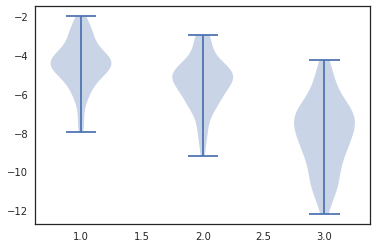

In [724]:
best_scores = []
worst_scores = []
all_scores = []
for k in pair2scores:
    scores = pair2scores[k]
    if(len(scores) == 0):
        print k
        continue
    #plt.plot([x / float(len(scores)) for x in range(len(scores))], scores[::-1])
    best_scores.append(scores[0])
    worst_scores.append(scores[-1])
    all_scores.append(np.mean(scores))
plt.violinplot([worst_scores, all_scores, best_scores])

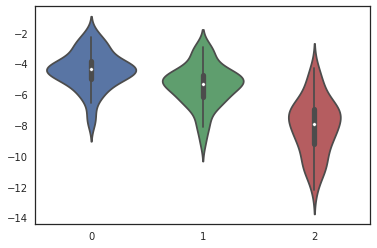

In [725]:
sns.violinplot(data=[worst_scores, all_scores, best_scores])

# Calculate Ligand Interface Residues

In [1036]:
summary = []
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug_orig = drug
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("Data/Ligands/{0}*".format(drug))[0]
    
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    # Load all ranked docking poses
    outs = glob.glob("Data/Docked_Ligands/ranked_poses/{0}_{1}_*.pdb".format(uni, drug))
    
    for f in outs:
        rank = int(f.split("_")[-1].split(".")[0])
        #print drug, uni, rank
        #continue
        if(not rank <= 10):
            continue
        score = float(open(f, "r").readlines()[1].split()[-1])
        ires = sp.check_output("python irescalc_ligand.py {0} {1}".format(uni_f, f), shell=True).strip()
        
        summary.append([uni, drug_orig, rank, score, ires])
    print
    print
    print
summary = pd.DataFrame(summary, columns=["Human_Protein", "Compound_Name", "Rank", "Score", "Ires"])

In [1040]:
summary = summary.sort_values(["Human_Protein", "Compound_Name", "Rank"])

In [1041]:
summary.to_csv("Data/Drug_Docking_Ires_Summary.txt", sep="\t", index=None)

# Calculate Overlap Between Protein and Ligand IRES

In [622]:
p_ires = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
#p_ires = p_ires.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#p_ires = p_ires[p_ires["Source"] == "ECLAIR"]
p_ires = p_ires[p_ires["Source"] == "Docking"]

l_ires = pd.read_csv("Data/Drug_Docking_Ires_Summary.txt", sep="\t")

In [623]:
p_ires

P1      P2   Source  P1_Len  P1_N_Ires  \
51   COVID19Spike  Q7Z5G4  Docking    1273         22   
53   COVID19Spike  Q9C0B5  Docking    1273         24   
55    COVID19nsp1  P09884  Docking     180         15   
57    COVID19nsp1  P49642  Docking     180         24   
59    COVID19nsp1  P49643  Docking     180         11   
61    COVID19nsp1  Q14181  Docking     180         14   
63    COVID19nsp1  Q8NBJ5  Docking     180         22   
65    COVID19nsp1  Q99959  Docking     180         18   
67   COVID19nsp10  O94973  Docking     139         16   
69   COVID19nsp10  P55789  Docking     139         18   
71   COVID19nsp10  Q969X5  Docking     139         13   
73   COVID19nsp10  Q96CW1  Docking     139         14   
75   COVID19nsp10  Q9HAV7  Docking     139         21   
78   COVID19nsp12  A3KN83  Docking     932         16   
80   COVID19nsp12  O14874  Docking     932         20   
82   COVID19nsp12  O43823  Docking     932         22   
84   COVID19nsp12  O75592  Docking     932         26   
86   COVID19nsp12  O95391  Docking     932         34   
88   COVID19nsp12  Q13546  Docking     932         14   
90   COVID19nsp12  Q14157  Docking     932         15   
92   COVID19nsp12  Q2T9J0  Docking     932         21   
94   COVID19nsp12  Q5EBL8  Docking     932         18   
96   COVID19nsp12  Q5JSZ5  Docking     932          8   
98   COVID19nsp12  Q5T6F2  Docking     932         27   
100  COVID19nsp12  Q5VUA4  Docking     932         22   
102  COVID19nsp12  Q6UUV7  Docking     932         31   
104  COVID19nsp12  Q70EL1  Docking     932         15   
106  COVID19nsp12  Q8IWR0  Docking     932         18   
108  COVID19nsp12  Q92615  Docking     932         21   
110  COVID19nsp12  Q96IZ5  Docking     932         16   
..            ...     ...      ...     ...        ...   
522  COVID19orf9b  Q9H773  Docking      97         27   
524  COVID19orf9b  Q9P0L2  Docking      97         24   
526  COVID19orf9b  Q9UKA9  Docking      97         13   
528  COVID19orf9b  Q9UL15  Docking      97         23   
530  COVID19orf9c  O00124  Docking      73         15   
532  COVID19orf9c  O43292  Docking      73         18   
534  COVID19orf9c  O76024  Docking      73         24   
536  COVID19orf9c  P33527  Docking      73         18   
538  COVID19orf9c  P55085  Docking      73         11   
540  COVID19orf9c  Q12770  Docking      73         15   
542  COVID19orf9c  Q2PZI1  Docking      73         17   
544  COVID19orf9c  Q5BJF2  Docking      73         19   
546  COVID19orf9c  Q6NXT4  Docking      73         14   
548  COVID19orf9c  Q6NXT6  Docking      73         11   
550  COVID19orf9c  Q7Z2K6  Docking      73         17   
552  COVID19orf9c  Q86UT6  Docking      73         25   
554  COVID19orf9c  Q86VR2  Docking      73         18   
556  COVID19orf9c  Q8TEQ8  Docking      73         16   
558  COVID19orf9c  Q96K12  Docking      73         12   
560  COVID19orf9c  Q96S52  Docking      73         11   
562  COVID19orf9c  Q9BQ95  Docking      73         13   
564  COVID19orf9c  Q9BVK2  Docking      73         19   
566  COVID19orf9c  Q9GZU3  Docking      73         18   
568  COVID19orf9c  Q9H3K2  Docking      73         11   
570  COVID19orf9c  Q9H845  Docking      73         25   
572  COVID19orf9c  Q9NV92  Docking      73         16   
574  COVID19orf9c  Q9Y276  Docking      73         12   
576  COVID19orf9c  Q9Y375  Docking      73         16   
578  COVID19orf9c  Q9Y3A6  Docking      73         16   
580  COVID19orf9c  Q9Y6M9  Docking      73         12   

                                               P1_Ires  P2_Len  P2_N_Ires  \
51   41,42,43,44,45,46,47,49,281,282,283,836,837,84...     137         21   
53   45,46,48,278,280,281,282,812,813,815,820,821,8...     715         16   
55    55,56,57,58,73,80,81,82,83,84,99,100,101,104,119    1462         10   
57   15,22,24,55,57,58,59,73,75,80,81,82,83,84,95,9...     420         30   
59                55,56,57,58,61,73,99,100,101,104,119     509          6   
61      55,56,57,5

In [624]:
merged = l_ires.join(p_ires[["P1", "P2", "Source", "P2_Ires"]].set_index("P2"), on="Human_Protein", how="left")

In [625]:
uni2seq = pd.read_csv("Data/Proteins.txt", sep="\t").set_index("ID")["Sequence"].to_dict()

In [626]:
def do(x):
    iresA, iresB = x
    if(pd.isnull(iresA)):
        iresA = set()
    else:
        iresA = set([int(x)-1 for x in iresA.split(",")])
    if(pd.isnull(iresB)):
        iresB = set()
    else:
        iresB = set([int(x)-1 for x in iresB.split(",")])
    
    return len(iresA.intersection(iresB)) / float(len(iresA.union(iresB))), len(iresA.intersection(iresB)) / float(len(iresA))
# FUNCTION END
tmp = merged[["Ires", "P2_Ires"]].apply(do, axis=1)

merged["Jaccard"] = [x[0] for x in tmp]
merged["Ligand Recall"] = [x[1] for x in tmp]

In [627]:
uni2coverage_mask = dict()
for uni in uni2seq:
    uni2coverage_mask[uni] = np.zeros(len(uni2seq[uni]))
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(uni))[0]
    except IndexError:
        continue
    
    pdb_df = my.pdb2df(uni_f)
    resis = list(pdb_df["Residue ID"].unique() - 1)
    resis = [x for x in resis if x >= 0]
    
    uni2coverage_mask[uni][resis] = 1

In [628]:
my = reload(my)

In [629]:
uni2piresmask = dict()
uni2liresmask = dict()
def do(x):
    uni, iresA, iresB, rank = x
    mask1 = np.zeros(len(uni2seq[uni]))
    mask2 = np.zeros(len(uni2seq[uni]))
    
    if(pd.isnull(iresA)):
        iresA = set()
    else:
        iresA = set([int(x)-1 for x in iresA.split(",")])
    if(pd.isnull(iresB)):
        iresB = set()
    else:
        iresB = set([int(x)-1 for x in iresB.split(",")])
    
    mask1[sorted(iresA)] = 1
    mask2[sorted(iresB)] = 1
    
    coverage_mask = uni2coverage_mask[uni] == 1
    
    #print mask1[coverage_mask]
    #print type(mask1[coverage_mask])
    #print set(mask1[coverage_mask])
    #print set(mask2[coverage_mask])
    #1/0
    
    #OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], verbose=True, expose_label="Protein", case_label="Drug")
    OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], two_sided=False, error="CI")
    #OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], two_sided=False, error="SE")
    OR, up, low = np.log2([OR, up, low])
    
    if(rank == 1 and sum(mask2) != 0):
        if(not uni in uni2piresmask.keys()):
            uni2piresmask[uni] = mask1[coverage_mask] == 1
            uni2liresmask[uni] = mask2[coverage_mask] == 1
        else:
            print "HERE"
            uni2piresmask[uni] = uni2piresmask[uni] | (mask1[coverage_mask] == 1)
            uni2liresmask[uni] = uni2liresmask[uni] | (mask2[coverage_mask] == 1)
    elif(rank == 1):
        print uni
    return OR, up, low, p
# FUNCTION END
tmp = merged[["Human_Protein", "Ires", "P2_Ires", "Rank"]].progress_apply(do, axis=1)
merged["Log2 Odds Ratio"] = [x[0] for x in tmp]
merged["Lower CI"] = [x[2] for x in tmp]
merged["Upper CI"] = [x[1] for x in tmp]
merged["p-value"] = [x[3] for x in tmp]

O60885
O60885
O60885
O60885
O60885
O60885
HERE
HERE
HERE
P19784
P19784
P25440
P25440
P25440
P25440
P25440
P25440
HERE
HERE
HERE
HERE
HERE
P67870
Q13617
Q15904
HERE
Q6PKG0
Q6PKG0
HERE
HERE
Q99720
Q99720
Q99720
Q99720
Q99720
Q99720
HERE
HERE


In [26]:
def do(x):
    uni, iresA, iresB, rank = x
    mask1 = np.zeros(len(uni2seq[uni]))
    mask2 = np.zeros(len(uni2seq[uni]))
    
    if(pd.isnull(iresA)):
        iresA = set()
    else:
        iresA = set([int(x)-1 for x in iresA.split(",")])
    if(pd.isnull(iresB)):
        iresB = set()
    else:
        iresB = set([int(x)-1 for x in iresB.split(",")])
    
    mask1[sorted(iresA)] = 1
    mask2[sorted(iresB)] = 1
    
    coverage_mask = uni2coverage_mask[uni] == 1
    
    #print mask1[coverage_mask]
    #print type(mask1[coverage_mask])
    #print set(mask1[coverage_mask])
    #print set(mask2[coverage_mask])
    #1/0
    
    OR, up, low, p = my.odds_ratio(mask1[coverage_mask], mask2[coverage_mask], verbose=True, expose_label="Protein", case_label="Drug")
    OR, up, low = np.log2([OR, up, low])
    
    if(rank == 1 and sum(mask2) != 0):
        if(not uni in uni2piresmask.keys()):
            uni2piresmask[uni] = mask1[coverage_mask] == 1
            uni2liresmask[uni] = mask2[coverage_mask] == 1
        else:
            print "HERE"
            uni2piresmask[uni] = uni2piresmask[uni] | (mask1[coverage_mask] == 1)
            uni2liresmask[uni] = uni2liresmask[uni] | (mask2[coverage_mask] == 1)
    elif(rank == 1):
        print uni
    return OR, up, low, p
# FUNCTION END

In [590]:
ires1, ires2 = merged[(merged["Rank"] == 1)&(merged["Compound_Name"] == "Verdinexor")&(merged["Human_Protein"] == "P52948")][["Ires", "P2_Ires"]].values[0]
do(("P52948", ires2, ires1, 1))

HERE


(2.7842713089445628,
 4.4000538480662632,
 1.1684887698228621,
 0.0022958369833069314)

In [604]:
# Overall Enrichment Across all Genes
pires_mask = np.concatenate([uni2piresmask[uni] for uni in uni2piresmask.keys()])
lires_mask = np.concatenate([uni2liresmask[uni] for uni in uni2piresmask.keys()])

OR, up, low, p = my.odds_ratio(pires_mask, lires_mask, two_sided=False, error="SE")
OR, up, low = np.log2([OR, up, low])
    
print OR, up, low, p

1.02148572584 1.21922896469 0.823742486993 1.1975910752e-07


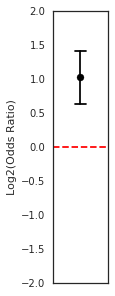

In [827]:
sns.set_style("white")
plt.figure(figsize=(1, 5))
plt.plot([0, 0], [up, low], color="k")
plt.plot([-0.1, 0.1], [up, up], color="k")
plt.plot([-0.1, 0.1], [low, low], color="k")
plt.scatter([0], [OR], color="k")
plt.ylim(-2, 2)
plt.plot([-0.5, 0.5], [0, 0], color="r", linestyle="--")
plt.xlim(-0.5, 0.5)
plt.xticks([0], [""])
plt.ylabel("Log2(Odds Ratio)")
plt.savefig("Figures/Figure_5/Fig_5b_Overall_Enrichment.svg")

In [598]:
merged[(pd.isnull(merged["Log2 Odds Ratio"]))*(merged["Ligand Recall"] != 0)]

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Human_Protein          Compound_Name  Rank     Score  \
314        P52948             Verdinexor     5 -7.832831   
316        P52948             Verdinexor     7 -7.716162   
317        P52948             Verdinexor     8 -7.666520   
318        P52948             Verdinexor     9 -7.634746   
446        Q5T1M5  Rapamycin (Sirolimus)     7 -8.075341   
482        Q7Z3B4             Verdinexor     3 -7.698810   

                                                  Ires           P1   Source  \
314            797,798,799,800,803,808,855,859,879,880  COVID19orf6  Docking   
316            799,800,803,805,808,859,860,878,879,880  COVID19orf6  Docking   
317        797,798,799,800,803,808,859,860,878,879,880  COVID19orf6  Docking   
318            797,798,799,800,803,808,855,859,879,880  COVID19orf6  Docking   
446  203,205,207,211,212,213,216,217,222,223,225,22...  COVID19nsp2  Docking   
482                    469,470,472,473,474,476,477,480  COVID19nsp9  Docking   

                                               P2_Ires   Jaccard  \
314  795,796,797,798,799,800,803,804,805,808,811,82...  0.434783   
316  795,796,797,798,799,800,803,804,805,808,811,82...  0.434783   
317  795,796,797,798,799,800,803,804,805,808,811,82...  0.478261   
318  795,796,797,798,799,800,803,804,805,808,811,82...  0.434783   
446                205,207,211,212,217,222,223,225,283  0.600000   
482  463,465,466,467,469,470,472,473,474,476,477,47...  0.421053   

     Ligand Recall  Log2 Odds Ratio  Lower CI  Upper CI  p-value  
314            1.0              NaN       NaN       NaN      NaN  
316            1.0              NaN       NaN       NaN      NaN  
317            1.0              NaN       NaN       NaN      NaN  
318            1.0              NaN       NaN       NaN      NaN  
446            0.6              NaN       NaN       NaN      NaN  
482            1.0              NaN       NaN       NaN      NaN

Text(0,0.5,'Ligand Recall')

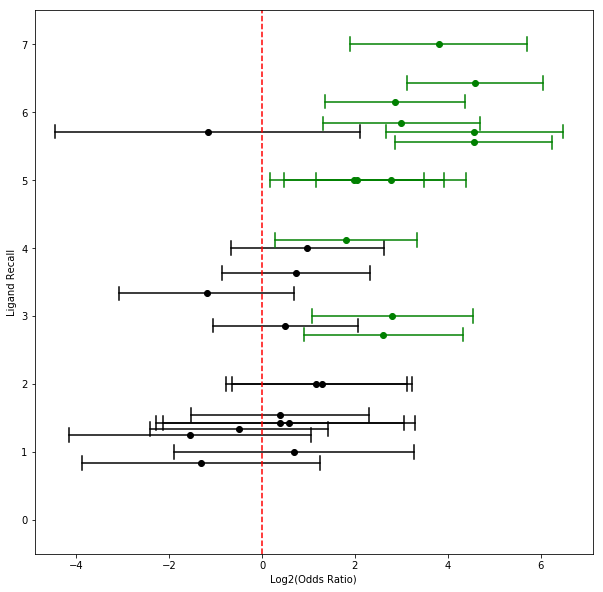

In [599]:
plt.figure(figsize=(10, 10))

i = 0
labels = []
s_min = 0.5
s_max = 0.5
merged["No Overlap"] = pd.isnull(merged["Log2 Odds Ratio"]) & (~pd.isnull(merged["P2_Ires"]))
for p1, p2, OR, up, low, p, p2ires, score in merged[merged["Rank"] == 1].sort_values(["No Overlap", "Log2 Odds Ratio"], ascending=[False, True])[["Human_Protein", "Compound_Name", "Log2 Odds Ratio", "Lower CI", "Upper CI", "p-value", "P2_Ires", "Ligand Recall"]].values:
    score = score*10
    if(not pd.isnull(p2ires) and pd.isnull(OR)):
        OR = -5
        up = -5
        low = -5
        p = 0.06
    if(pd.isnull(OR)):
        continue
    color = "k"
    if(p <= 0.05):
        color = "g"
    plt.plot([up, low], [score, score], color=color)
    plt.plot([up, up], [score-0.1, score+0.1], color=color)
    plt.plot([low, low], [score-0.1, score+0.1], color=color)
    plt.scatter([OR], [score], color=color)
    labels.append("_".join([p1, p2]).replace("COVID19", ""))
    i += 1
    s_min = min([s_min, score])
    s_max = max([s_max, score])
merged = merged.drop("No Overlap", axis=1)
plt.plot([0, 0], [s_min-0.5, s_max+0.5], color="r", linestyle="--")    
plt.xlim(merged[merged["Rank"] == 1]["Lower CI"].min()*1.1, merged[merged["Rank"] == 1]["Upper CI"].max()*1.1)
plt.ylim(s_min-0.5, s_max+0.5)
#plt.xticks(range(i), labels, rotation=90)
plt.xlabel("Log2(Odds Ratio)")
plt.ylabel("Ligand Recall")

Text(5.5,-3,'No Binding Site Overlap')

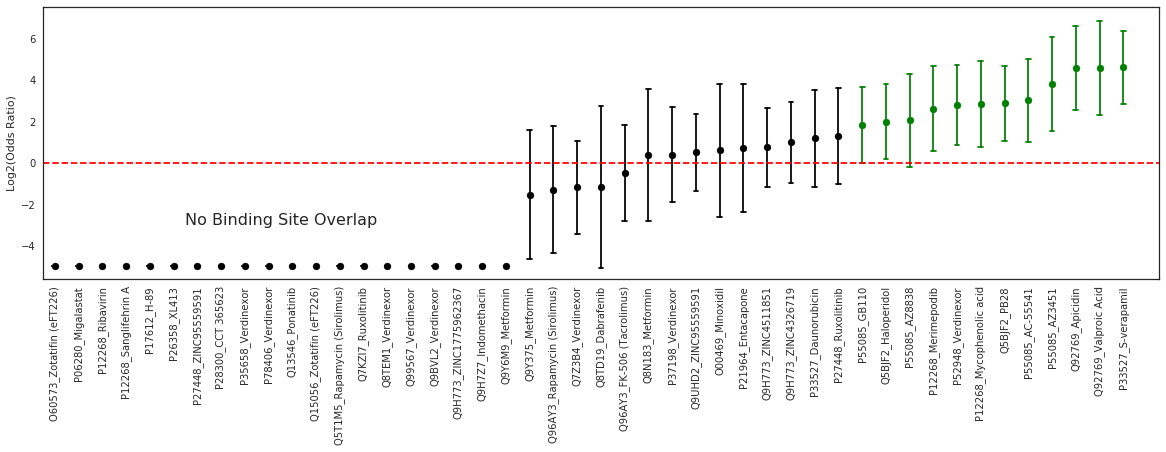

In [830]:
plt.figure(figsize=(20, 5))

i = 0
labels = []
merged["No Overlap"] = pd.isnull(merged["Log2 Odds Ratio"]) & (~pd.isnull(merged["P2_Ires"]))
for p1, p2, OR, up, low, p, p2ires in merged[merged["Rank"] == 1].sort_values(["No Overlap", "Log2 Odds Ratio"], ascending=[False, True])[["Human_Protein", "Compound_Name", "Log2 Odds Ratio", "Lower CI", "Upper CI", "p-value", "P2_Ires"]].values:
    if(not pd.isnull(p2ires) and pd.isnull(OR)):
        OR = -5
        up = -5
        low = -5
        p = 0.06
    if(pd.isnull(OR)):
        continue
    color = "k"
    if(p <= 0.05):
        color = "g"
    plt.plot([i, i], [up, low], color=color)
    plt.plot([i-0.1, i+0.1], [up, up], color=color)
    plt.plot([i-0.1, i+0.1], [low, low], color=color)
    plt.scatter([i], [OR], color=color)
    labels.append("_".join([p1, p2]).replace("COVID19", ""))
    i += 1
merged = merged.drop("No Overlap", axis=1)
plt.plot([-0.5, i+0.5], [0, 0], color="r", linestyle="--")    
plt.ylim(merged[merged["Rank"] == 1]["Lower CI"].min()*1.1, merged[merged["Rank"] == 1]["Upper CI"].max()*1.1)
plt.xlim(-0.5, 0.5+i)
plt.xticks(range(i), labels, rotation=90)
plt.ylabel("Log2(Odds Ratio)")
plt.text(5.5, -3, "No Binding Site Overlap", fontdict={"fontsize":16})

F2RL1 : GB110
TMEM97 : Haloperidol
F2RL1 : AZ8838
IMPDH2 : Merimepodib
NUP98 : Verdinexor
IMPDH2 : Mycophenolic acid
TMEM97 : PB28
F2RL1 : AC-55541
F2RL1 : AZ3451
HDAC2 : Apicidin
HDAC2 : Valproic Acid
ABCC1 : S-verapamil


(0, 6)

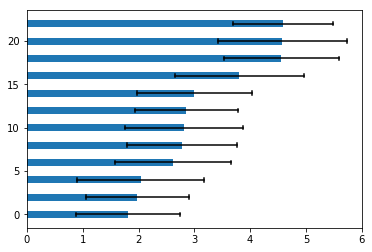

In [607]:
uni2gene = interactions.set_index("Preys")["PreyGene"].to_dict()
ORs = merged[(merged["Rank"] == 1)&(merged["p-value"] <= 0.05)].sort_values("Log2 Odds Ratio", ascending=True)["Log2 Odds Ratio"]
plt.barh(y=[2*x for x in range(len(ORs))], width=ORs)
y = 0
for uni, drug, OR, low, up, in merged[(merged["Rank"] == 1)&(merged["p-value"] <= 0.05)].sort_values("Log2 Odds Ratio", ascending=True)[["Human_Protein", "Compound_Name", "Log2 Odds Ratio", "Lower CI", "Upper CI"]].values:
    plt.plot([low, up], [y, y], color="k")
    plt.plot([low, low], [y-0.2, y+0.2], color="k")
    plt.plot([up, up], [y-0.2, y+0.2], color="k")
    y += 2
    print uni2gene[uni] + " : " + drug
plt.xlim(0, 6)

In [635]:
merged[merged["Rank"] == 1].sort_values("Log2 Odds Ratio", ascending=False)

Human_Protein                 Compound_Name  Rank      Score  \
280        P33527                   S-verapamil     1  -6.435490   
530        Q92769                 Valproic Acid     1  -5.002583   
520        Q92769                      Apicidin     1  -7.647250   
330        P55085                        AZ3451     1  -7.006188   
320        P55085                      AC-55541     1  -6.471908   
430        Q5BJF2                          PB28     1  -8.293610   
100        P12268             Mycophenolic acid     1  -7.262971   
310        P52948                    Verdinexor     1  -8.379586   
90         P12268                   Merimepodib     1  -8.223710   
340        P55085                        AZ8838     1  -5.745646   
420        Q5BJF2                   Haloperidol     1  -7.954349   
350        P55085                         GB110     1  -7.268305   
240        P27448                   Ruxolitinib     1  -7.011948   
270        P33527                  Daunorubicin     1  -8.289081   
650        Q9H773                   ZINC4326719     1  -6.630785   
660        Q9H773                   ZINC4511851     1  -6.774463   
160        P21964                    Entacapone     1  -7.216914   
0          O00469                     Minoxidil     1  -5.766031   
680        Q9UHD2                  ZINC95559591     1  -6.917160   
300        P37198                    Verdinexor     1  -5.244903   
490        Q8N183                     Metformin     1  -4.468033   
540        Q96AY3           FK-506 (Tacrolimus)     1  -7.242668   
500        Q8TD19                    Dabrafenib     1  -4.262865   
480        Q7Z3B4                    Verdinexor     1  -7.790700   
550        Q96AY3         Rapamycin (Sirolimus)     1  -8.911320   
690        Q9Y375                     Metformin     1  -5.351443   
10         O60573            Zotatifin (eFT226)     1  -8.971642   
20         O60885                      ABBV-744     1  -7.903728   
30         O60885                      CPI-0610     1  -7.553031   
40         O60885                           JQ1     1  -6.044140   
..            ...                           ...   ...        ...   
190        P25440                           JQ1     1  -8.500958   
200        P25440                           MZ1     1 -11.108444   
210        P25440                       RVX-208     1  -9.663433   
220        P25440                         dBET6     1 -12.188757   
230        P26358                         XL413     1  -8.762288   
250        P27448                  ZINC95559591     1  -7.301856   
260        P28300                    CCT 365623     1  -8.016825   
290        P35658                    Verdinexor     1  -9.390509   
360        P67870                Silmitasertib      1  -6.777084   
370        P78406                    Verdinexor     1 -10.667676   
380        Q13546                     Ponatinib     1  -8.857823   
390        Q13617                  Pevonedistat     1  -8.878250   
400        Q15056            Zotatifin (eFT226)     1  -7.576054   
410        Q15904                Bafilomycin A1     1  -9.732771   
440        Q5T1M5         Rapamycin (Sirolimus)     1  -8.971765   
450        Q6PKG0         Rapamycin (Sirolimus)     1 -10.568593   
460        Q6PKG0  Sapanisertib (INK128/MlN128)     1  -6.987176   
470        Q7KZI7                   Ruxolitinib     1  -7.013640   
510        Q8TEM1                    Verdinexor     1 -10.787348   
560        Q99567                    Verdinexor     1 -10.281797   
570        Q99720                   Chloroquine     1  -8.845473   
580        Q99720                       E-52862     1 -10.856113   
590        Q99720                   Haloperidol     1 -11.109549   
600        Q99720                          PB28     1 -10.059945   
610        Q99720                     PD-144418     1  -9.933073   
620        Q99720                       RS-PPCC     1 -10.802169   
630        Q9BVL2                    Verdinexor     1  -7.17

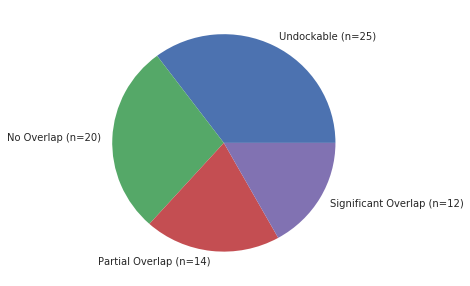

In [861]:
plt.figure(figsize=(5, 5))
merged["No Overlap"] = pd.isnull(merged["Log2 Odds Ratio"]) & (~pd.isnull(merged["P2_Ires"]))
a = len(merged[(merged["Rank"] == 1)&(pd.isnull(merged["p-value"]))&(~merged["No Overlap"])])
b = merged[merged["Rank"] == 1]["No Overlap"].sum()
c = (merged[(merged["Rank"] == 1)&(~merged["No Overlap"])]["p-value"] > 0.05).sum()
d = (merged[(merged["Rank"] == 1)&(~merged["No Overlap"])]["p-value"] <= 0.05).sum()
plt.pie([a, b, c, d], labels=["Undockable (n={0})".format(a), "No Overlap (n={0})".format(b), "Partial Overlap (n={0})".format(c), "Significant Overlap (n={0})".format(d)])
merged = merged.drop("No Overlap", axis=1)


In [694]:
merged[merged["Human_Protein"] == "P0"]

Human_Protein Compound_Name  Rank     Score  \
390        Q13617  Pevonedistat     1 -8.878250   
391        Q13617  Pevonedistat     2 -8.810932   
392        Q13617  Pevonedistat     3 -8.733370   
393        Q13617  Pevonedistat     4 -8.696181   
394        Q13617  Pevonedistat     5 -8.653007   
395        Q13617  Pevonedistat     6 -8.623037   
396        Q13617  Pevonedistat     7 -8.539443   
397        Q13617  Pevonedistat     8 -8.486038   
398        Q13617  Pevonedistat     9 -8.391539   
399        Q13617  Pevonedistat    10 -8.383532   

                                              Ires   P1 Source P2_Ires  \
390    73,77,79,81,83,84,87,88,151,154,155,157,158  NaN    NaN     NaN   
391            27,28,29,30,32,35,36,39,100,103,106  NaN    NaN     NaN   
392      73,77,83,84,87,88,148,151,152,154,155,158  NaN    NaN     NaN   
393              1,2,3,6,35,36,39,40,43,44,106,107  NaN    NaN     NaN   
394              27,28,29,30,32,35,89,92,93,96,100  NaN    NaN     NaN   
395        73,77,79,81,83,84,87,88,151,154,155,157  NaN    NaN     NaN   
396           73,77,79,83,84,87,88,151,154,155,157  NaN    NaN     NaN   
397      77,83,84,87,88,91,148,151,154,155,157,158  NaN    NaN     NaN   
398   73,77,83,84,87,88,91,148,151,154,155,157,158  NaN    NaN     NaN   
399  73,77,83,84,87,88,151,153,154,155,156,157,158  NaN    NaN     NaN   

     Jaccard  Ligand Recall  Log2 Odds Ratio  Lower CI  Upper CI  p-value  
390      0.0            0.0              NaN       NaN       NaN      NaN  
391      0.0            0.0              NaN       NaN       NaN      NaN  
392      0.0            0.0              NaN       NaN       NaN      NaN  
393      0.0            0.0              NaN       NaN       NaN      NaN  
394      0.0            0.0              NaN       NaN       NaN      NaN  
395      0.0            0.0              NaN       NaN       NaN      NaN  
396      0.0            0.0              NaN       NaN       NaN      NaN  
397      0.0            0.0              NaN       NaN       NaN      NaN  
398      0.0            0.0              NaN       NaN       NaN      NaN  
399      0.0            0.0              NaN       NaN       NaN      NaN

In [667]:
len(merged[merged["Rank"] == 1])

71

In [668]:
len(merged[(merged["Rank"] == 1)&(~pd.isnull(merged["P1"]))]["Compound_Name"].unique())

33

In [1234]:
for f in ["P17612", "P12268", "P78406", "P25440", "Q92769", "P33527"] + tmp["Human Protein"].to_list():
    if(glob.glob("Data/Docked_Structures/*{0}*".format(f))):
        print os.system("cp {0} TMP_Transfer/".format(glob.glob("Data/Docked_Structures/*{0}*".format(f))[0]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [468]:
merged[(merged["Rank"] == 1)&(merged["Ligand Recall"] >= 0.3)].sort_values("Log2 Odds Ratio")

Human_Protein      Compound_Name  Rank     Score  \
480        Q7Z3B4         Verdinexor     1 -7.790700   
500        Q8TD19         Dabrafenib     1 -4.262865   
660        Q9H773        ZINC4511851     1 -6.774463   
650        Q9H773        ZINC4326719     1 -6.630785   
350        P55085              GB110     1 -7.268305   
420        Q5BJF2        Haloperidol     1 -7.954349   
340        P55085             AZ8838     1 -5.745646   
310        P52948         Verdinexor     1 -8.379586   
100        P12268  Mycophenolic acid     1 -7.262971   
430        Q5BJF2               PB28     1 -8.293610   
320        P55085           AC-55541     1 -6.471908   
330        P55085             AZ3451     1 -7.006188   
520        Q92769           Apicidin     1 -7.647250   
530        Q92769      Valproic Acid     1 -5.002583   
280        P33527        S-verapamil     1 -6.435490   

                                                  Ires            P1   Source  \
480                458,459,461,462,463,464,465,466,468   COVID19nsp9  Docking   
500                        940,941,942,943,944,945,947   COVID19nsp9  Docking   
660            31,32,35,39,108,109,111,112,113,114,115  COVID19orf9b  Docking   
650               31,32,35,108,109,111,112,113,114,115  COVID19orf9b  Docking   
350  46,48,53,54,55,57,58,59,60,61,63,64,66,68,70,8...  COVID19orf9c  Docking   
420      86,90,104,106,107,110,111,114,151,154,155,157  COVID19orf9c  Docking   
340                            46,48,53,54,55,59,66,68  COVID19orf9c  Docking   
310            797,828,829,830,831,842,846,847,851,855   COVID19orf6  Docking   
100             70,274,275,276,327,365,366,368,387,388  COVID19nsp14  Docking   
430    86,89,90,94,101,104,106,107,110,154,155,156,157  COVID19orf9c  Docking   
320                52,53,55,68,70,84,87,88,89,90,91,93  COVID19orf9c  Docking   
330                      53,54,55,68,70,84,87,88,89,93  COVID19orf9c  Docking   
520                  28,99,100,150,151,206,271,272,302   COVID19nsp5  Docking   
530                        100,150,151,205,206,272,302   COVID19nsp5  Docking   
280  795,796,800,804,808,826,827,828,829,830,831,83...  COVID19orf9c  Docking   

                                               P2_Ires   Jaccard  \
480  463,465,466,467,469,470,472,473,474,476,477,47...  0.120000   
500                        943,944,945,946,947,948,950  0.400000   
660  48,49,52,53,54,57,60,61,62,64,65,66,68,69,72,9...  0.121212   
650  48,49,52,53,54,57,60,61,62,64,65,66,68,69,72,9...  0.125000   
350          55,58,59,66,68,70,82,83,84,85,86,87,88,89  0.291667   
420  74,75,76,77,78,79,80,82,83,86,87,90,91,94,97,1...  0.206897   
340          55,58,59,66,68,70,82,83,84,85,86,87,88,89  0.222222   
310  795,796,797,798,799,800,803,804,805,808,811,82...  0.178571   
100  71,72,75,93,94,95,96,97,99,253,255,258,274,275...  0.111111   
430  74,75,76,77,78,79,80,82,83,86,87,90,91,94,97,1...  0.285714   
320          55,58,59,66,68,70,82,83,84,85,86,87,88,89  0.368421   
330          55,58,59,66,68,70,82,83,84,85,86,87,88,89  0.411765   
520  27,28,30,100,201,203,204,205,206,230,231,269,2...  0.185185   
530  27,28,30,100,201,203,204,205,206,230,231,269,2...  0.153846   
280  679,680,713,714,769,770,771,795,796,797,799,80...  0.310345   

     Ligand Recall  Log2 Odds Ratio  Lower CI  Upper CI       p-value  
480       0.333333        -1.192645 -3.443994  1.058704  1.495687e-01  
500       0.571429        -1.169925 -5.084602  2.744752  2.790227e-01  
660       0.363636         0.733213 -1.171897  2.638324  2.253272e-01  
650       0.400000         0.977974 -0.975970  2.931917  1.632996e-01  
350       0.411765         1.807355 -0.012650  3.627360  2.580690e-02  
420       0.500000         1.978626  0.174513  3.782739  1.579529e-02  
340       0.500000         2.035624 -0.198723  4.269971  3.707844e-02  
310       0.500000         2.784271  0.858948  4.709595  2.295837e-03  
100       0.300000         2.809086  0.733884  4.884287  3.987871e-03  
4

In [469]:
merged[merged["p-value"] <= 0.05].sort_values("p-value").drop_duplicates(["Human_Protein", "Compound_Name"])

Human_Protein          Compound_Name  Rank      Score  \
98         P12268            Merimepodib     9  -7.542053   
281        P33527            S-verapamil     2  -6.362858   
525        Q92769               Apicidin     6  -7.240957   
126        P12268         Sanglifehrin A     7 -11.530031   
248        P27448            Ruxolitinib     9  -6.498491   
118        P12268              Ribavirin     9  -6.032985   
276        P33527           Daunorubicin     7  -7.880933   
109        P12268      Mycophenolic acid    10  -6.745049   
429        Q5BJF2            Haloperidol    10  -7.491281   
431        Q5BJF2                   PB28     2  -8.139565   
534        Q92769          Valproic Acid     5  -4.562490   
448        Q5T1M5  Rapamycin (Sirolimus)     9  -8.056230   
557        Q96AY3  Rapamycin (Sirolimus)     8  -8.415750   
84         P06280             Migalastat     5  -5.297186   
333        P55085                 AZ3451     4  -6.450992   
355        P55085                  GB110     6  -6.952127   
546        Q96AY3    FK-506 (Tacrolimus)     7  -6.902197   
315        P52948             Verdinexor     6  -7.794888   
322        P55085               AC-55541     3  -6.268126   
341        P55085                 AZ8838     2  -5.428430   
695        Q9Y375              Metformin     6  -4.442484   
306        P37198             Verdinexor     7  -4.941297   
169        P21964             Entacapone    10  -6.210096   
381        Q13546              Ponatinib     2  -8.574136   
501        Q8TD19             Dabrafenib     2  -4.234424   
485        Q7Z3B4             Verdinexor     6  -7.599862   

                                                  Ires            P1   Source  \
98     70,71,93,94,251,252,253,274,275,276,277,280,282  COVID19nsp14  Docking   
281    795,796,799,800,804,826,827,828,829,830,831,871  COVID19orf9c  Docking   
525                204,205,206,207,208,231,271,272,274   COVID19nsp5  Docking   
126  93,94,251,252,253,254,257,274,275,276,277,280,...  COVID19nsp14  Docking   
248  99,177,178,200,201,202,211,212,215,216,223,224...  COVID19orf9b  Docking   
118                    70,71,93,94,274,275,276,327,365  COVID19nsp14  Docking   
276            680,681,685,713,714,796,797,827,869,871  COVID19orf9c  Docking   
109        70,71,93,94,274,275,276,327,365,366,387,388  COVID19nsp14  Docking   
429  77,79,82,83,86,87,90,106,107,110,114,151,154,1...  COVID19orf9c  Docking   
431  77,79,82,83,86,87,90,106,107,110,111,114,151,1...  COVID19orf9c  Docking   
534                            100,150,151,205,206,272   COVID19nsp5  Docking   
448  205,207,217,218,219,222,223,251,252,253,272,28...   COVID19nsp2  Docking   
557              51,53,104,105,107,115,116,118,120,123   COVID19orf8  Docking   
84                                         60,61,67,71  COVID19nsp14  Docking   
333                46,48,53,55,57,58,59,66,68,82,83,84  COVID19orf9c  Docking   
355       46,48,53,55,59,60,61,66,68,70,82,84,87,89,93  COVID19orf9c  Docking   
546                 51,104,105,107,115,116,118,120,123   COVID19orf8  Docking   
315        797,828,829,830,831,842,846,847,851,855,859   COVID19orf6  Docking   
322                   46,48,53,55,57,58,59,66,68,82,84  COVID19orf9c  Docking   
341                            46,48,53,55,58,59,66,68  COVID19orf9c  Docking   
695            105,120,126,127,128,129,147,148,149,150  COVID19orf9c  Docking   
306    459,460,462,463,466,467,468,469,472,473,475,476   COVID19nsp9  Docking   
169                          88,90,191,193,194,223,224   COVID19nsp7  Docking   
381  228,230,231,232,236,-240,244,245,246,248,249,2...  COVID19nsp12  Docking   
501                        944,945,946,947,948,949,950   COVID19nsp9  Docking   
485                        457,458,461,462,464,465,468   COVID19nsp9  Docking   

                                               P2_Ires   Jaccard  \
98   71,72,75,93,94,95,96,97,99,253,255,258,274,275...  0.320000   
281  679,680,713,714,769,770,771

In [684]:
merged[(merged["Rank"] == 1)].sort_values("Ligand Recall", ascending=False)

Human_Protein                 Compound_Name  Rank      Score  \
330        P55085                        AZ3451     1  -7.006188   
280        P33527                   S-verapamil     1  -6.435490   
430        Q5BJF2                          PB28     1  -8.293610   
320        P55085                      AC-55541     1  -6.471908   
530        Q92769                 Valproic Acid     1  -5.002583   
500        Q8TD19                    Dabrafenib     1  -4.262865   
520        Q92769                      Apicidin     1  -7.647250   
340        P55085                        AZ8838     1  -5.745646   
310        P52948                    Verdinexor     1  -8.379586   
420        Q5BJF2                   Haloperidol     1  -7.954349   
350        P55085                         GB110     1  -7.268305   
650        Q9H773                   ZINC4326719     1  -6.630785   
660        Q9H773                   ZINC4511851     1  -6.774463   
480        Q7Z3B4                    Verdinexor     1  -7.790700   
100        P12268             Mycophenolic acid     1  -7.262971   
680        Q9UHD2                  ZINC95559591     1  -6.917160   
90         P12268                   Merimepodib     1  -8.223710   
240        P27448                   Ruxolitinib     1  -7.011948   
270        P33527                  Daunorubicin     1  -8.289081   
300        P37198                    Verdinexor     1  -5.244903   
490        Q8N183                     Metformin     1  -4.468033   
0          O00469                     Minoxidil     1  -5.766031   
540        Q96AY3           FK-506 (Tacrolimus)     1  -7.242668   
690        Q9Y375                     Metformin     1  -5.351443   
160        P21964                    Entacapone     1  -7.216914   
550        Q96AY3         Rapamycin (Sirolimus)     1  -8.911320   
220        P25440                         dBET6     1 -12.188757   
580        Q99720                       E-52862     1 -10.856113   
80         P06280                    Migalastat     1  -5.624798   
70         O60885                         dBET6     1  -7.848419   
..            ...                           ...   ...        ...   
640        Q9H773                ZINC1775962367     1  -8.170834   
40         O60885                           JQ1     1  -6.044140   
30         O60885                      CPI-0610     1  -7.553031   
670        Q9H7Z7                  Indomethacin     1  -7.265197   
20         O60885                      ABBV-744     1  -7.903728   
110        P12268                     Ribavirin     1  -6.756629   
460        Q6PKG0  Sapanisertib (INK128/MlN128)     1  -6.987176   
230        P26358                         XL413     1  -8.762288   
140        P19784                Silmitasertib      1 -11.000352   
210        P25440                       RVX-208     1  -9.663433   
250        P27448                  ZINC95559591     1  -7.301856   
260        P28300                    CCT 365623     1  -8.016825   
200        P25440                           MZ1     1 -11.108444   
190        P25440                           JQ1     1  -8.500958   
290        P35658                    Verdinexor     1  -9.390509   
180        P25440                      CPI-0610     1  -9.425997   
170        P25440                      ABBV-744     1 -10.063470   
150        P19784                          TMCB     1  -7.196832   
10         O60573            Zotatifin (eFT226)     1  -8.971642   
450        Q6PKG0         Rapamycin (Sirolimus)     1 -10.568593   
360        P67870                Silmitasertib      1  -6.777084   
370        P78406                    Verdinexor     1 -10.667676   
380        Q13546                     Ponatinib     1  -8.857823   
390        Q13617                  Pevonedistat     1  -8.878250   
400        Q15056            Zotatifin (eFT226)     1  -7.576054   
410        Q15904                Bafilomycin A1     1  -9.732771   
130        P17612                          H-89     1  -9.00

In [672]:
tmp = merged[(merged["p-value"] <= 0.05)&(merged["Rank"] == 1)].sort_values("Log2 Odds Ratio").copy()
tmp = tmp.join(interactions.set_index("Preys"), on=["Human_Protein"], how="inner")
tmp = tmp[["Compound_Name", "Human_Protein", "PreyGene", "P1", "Uniprot Protein Description", "Uniprot Function", "Log2 Odds Ratio", "Lower CI", "Upper CI", "p-value", "Ligand Recall"]].sort_values("Log2 Odds Ratio")
tmp.columns = ["Compound Name", "Human Protein", "UniProt ID", "Viral Interactor", "Protein Description", "Protein Function", "LogOdds", "CI_Low", "CI_Up", "P-value", "Ligand Recall"]
tmp
#print "\n".join(["\t".join([str(x) for x in list(tmp)])] + ["\t".join([str(x)[:100] for x in y]) for y in tmp.values])

Compound Name Human Protein UniProt ID Viral Interactor  \
350              GB110        P55085      F2RL1     COVID19orf9c   
420        Haloperidol        Q5BJF2     TMEM97     COVID19orf9c   
340             AZ8838        P55085      F2RL1     COVID19orf9c   
90         Merimepodib        P12268     IMPDH2     COVID19nsp14   
310         Verdinexor        P52948      NUP98      COVID19orf6   
100  Mycophenolic acid        P12268     IMPDH2     COVID19nsp14   
430               PB28        Q5BJF2     TMEM97     COVID19orf9c   
320           AC-55541        P55085      F2RL1     COVID19orf9c   
330             AZ3451        P55085      F2RL1     COVID19orf9c   
520           Apicidin        Q92769      HDAC2      COVID19nsp5   
530      Valproic Acid        Q92769      HDAC2      COVID19nsp5   
280        S-verapamil        P33527      ABCC1     COVID19orf9c   

                                   Protein Description  \
350  Proteinase-activated receptor 2 (PAR-2) (Coagu...   
420  Sigma intracellular receptor 2 (Sigma-2 recept...   
340  Proteinase-activated receptor 2 (PAR-2) (Coagu...   
90   Inosine-5'-monophosphate dehydrogenase 2 (IMP ...   
310  Nuclear pore complex protein Nup98-Nup96 (EC 3...   
100  Inosine-5'-monophosphate dehydrogenase 2 (IMP ...   
430  Sigma intracellular receptor 2 (Sigma-2 recept...   
320  Proteinase-activated receptor 2 (PAR-2) (Coagu...   
330  Proteinase-activated receptor 2 (PAR-2) (Coagu...   
520          Histone deacetylase 2 (HD2) (EC 3.5.1.98)   
530          Histone deacetylase 2 (HD2) (EC 3.5.1.98)   
280  Multidrug resistance-associated protein 1 (EC ...   

                                      Protein Function   LogOdds    CI_Low  \
350   Receptor for trypsin and trypsin-like enzymes...  1.807355 -0.012650   
420   Intracellular orphan receptor that binds nume...  1.978626  0.174513   
340   Receptor for trypsin and trypsin-like enzymes...  2.035624 -0.198723   
90    Catalyzes the conversion of inosine 5'-phosph...  2.611242  0.570705   
310   Plays a role in the nuclear pore complex (NPC...  2.784271  0.858948   
100   Catalyzes the conversion of inosine 5'-phosph...  2.809086  0.733884   
430   Intracellular orphan receptor that binds nume...  2.858644  1.056105   
320   Receptor for trypsin and trypsin-like enzymes...  3.000000  0.979254   
330   Receptor for trypsin and trypsin-like enzymes...  3.807355  1.540207   
520   Responsible for the deacetylation of lysine r...  4.557145  2.540774   
530   Responsible for the deacetylation of lysine r...  4.576501  2.316331   
280   Mediates export of organic anions and drugs f...  4.592158  2.842787   

        CI_Up       P-value  Ligand Recall  
350  3.627360  2.580690e-02       0.411765  
420  3.782739  1.579529e-02       0.500000  
340  4.269971  3.707844e-02       0.500000  
90   4.651778  6.068521e-03       0.272727  
310  4.709595  2.295837e-03       0.500000  
100  4.884287  3.987871e-03       0.300000  
430  4.661184  9.408246e-04       0.615385  
320  5.020746  1.808511e-03       0.583333  
330  6.074503  4.983036e-04       0.700000  
520  6.573515  4.719069e-06       0.555556  
530  6.836671  3.614366e-05       0.571429  
280  6.341529  1.337802e-07       0.642857

In [681]:
"Data/Docked_Structures/*{0}_{1}*".format(p1, p2)

'Data/Docked_Structures/*P33527_COVID19orf9c*'

In [682]:
import __main__
__main__.pymol_argv = ['pymol','-cqk'] # Pymol: quiet and no GUI

import pymol
pymol.finish_launching()
from pymol import cmd as pymolCmd
pymolCmd.reinitialize()

for drug, p1, p2 in tmp[["Compound Name", "Human Protein", "Viral Interactor"]].values:
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("Data/Docked_Ligands/{0}_{1}.pdb".format(p1, drug))[0]
    
    try:
        uni_f = glob.glob("Data/Undocked_Structures/{0}*".format(p1))[0]
    except IndexError:
        continue
    
    try:
        docked_f = glob.glob("Data/Docked_Structures/*{0}_{1}*".format(p2, p1))[0]
    except:
        docked_f = None
    
    # Get Eclair Preds
    preds = pd.read_csv("Data/Eclair_Predictions/{0}_{1}.txt".format(p2, p1), sep="\t")
    preds = preds.set_index(["Prot", "Pos"])["Pred"].to_dict()
    
    # Create Pymol Session
    pymolCmd.reinitialize()
    
    # Load Original Structure / Docked Structure
    pymolCmd.load(uni_f, p1)
    pymolCmd.load(drug_f, drug)
    if(docked_f):
        pymolCmd.load(docked_f, "{0}_Docked".format(p1))
        pymolCmd.align("{0}_Docked".format(p1), p1)
    else:
        print drug, p1, p2
        continue
    
    print "A", docked_f
    
    # Color By Prediction
    cmapA = matplotlib.cm.get_cmap('Greens')
    cmapB = matplotlib.cm.get_cmap('Blues')
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(float(0))[:3]).replace("#", "0x"), "{0}".format(p1))
    for k, pred in preds.iteritems():
        prot, resi = k
        if(np.isnan(pred)):
            pred = 0
        if(0 <= pred < 0.12):
            pred = 0
        elif(0.12 <= pred < 0.24):
            pred = 0.12
        elif(0.24 <= pred < 0.36):
            pred = 0.24
        elif(0.36 <= pred < 0.48):
            pred = 0.60
        else:
            pred = 0.90
        if(prot == 0):
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(float(pred))[:3]).replace("#", "0x"), "{0}_Docked and chain A and resi {2}".format(p1, p2, int(resi)))
        else:
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(float(pred))[:3]).replace("#", "0x"), "{0} and resi {1}".format(p1, int(resi)))
            if(docked_f):
                pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(float(pred))[:3]).replace("#", "0x"), "{0}_Docked and chain B and resi {2}".format(p1, p2, int(resi)))
    
    if(docked_f):
        pymolCmd.extract(p2 + "_Docked", "{0}_Docked and chain A".format(p1))
    
    # Save the Sessions
    pymolCmd.save("Data/PyMolSessions/Docked_Drugs/{0}_{1}.pse".format(p1, drug))

A Data/Docked_Structures/COVID19orf9c_P55085_top_dock.pdb
A Data/Docked_Structures/COVID19orf9c_Q5BJF2_top_dock.pdb
A Data/Docked_Structures/COVID19orf9c_P55085_top_dock.pdb
A Data/Docked_Structures/COVID19nsp14_P12268_top_dock.pdb
A Data/Docked_Structures/COVID19orf6_P52948_top_dock.pdb
A Data/Docked_Structures/COVID19nsp14_P12268_top_dock.pdb
A Data/Docked_Structures/COVID19orf9c_Q5BJF2_top_dock.pdb
A Data/Docked_Structures/COVID19orf9c_P55085_top_dock.pdb
A Data/Docked_Structures/COVID19orf9c_P55085_top_dock.pdb
A Data/Docked_Structures/COVID19nsp5_Q92769_top_dock.pdb
A Data/Docked_Structures/COVID19nsp5_Q92769_top_dock.pdb
A Data/Docked_Structures/COVID19orf9c_P33527_top_dock.pdb


In [1009]:
0

0

Text(0,0.5,'Number of Drug:Targer Pairs')

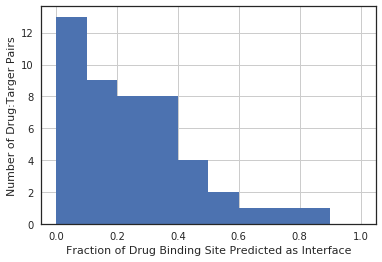

In [1017]:
merged[(~pd.isnull(merged["P2_Ires"]))&(merged["Rank"] == 1)]["Ligand Recall"].hist(range=(0, 1))
plt.xlabel("Fraction of Drug Binding Site Predicted as Interface")
plt.ylabel("Number of Drug:Targer Pairs")

In [1011]:
merged[(merged["Ligand Recall"] == 0.0)&(merged["Rank"] == 1)].sort_values("Ligand Recall")

Human_Protein          Compound_Name  Rank      Score  \
0          O00469              Minoxidil     1  -5.766031   
680        Q9UHD2           ZINC95559591     1  -6.917160   
620        Q99720                RS-PPCC     1 -10.802169   
610        Q99720              PD-144418     1  -9.933073   
600        Q99720                   PB28     1 -10.059945   
590        Q99720            Haloperidol     1 -11.109549   
580        Q99720                E-52862     1 -10.856113   
570        Q99720            Chloroquine     1  -8.845473   
560        Q99567             Verdinexor     1 -10.281797   
550        Q96AY3  Rapamycin (Sirolimus)     1  -8.911320   
540        Q96AY3    FK-506 (Tacrolimus)     1  -7.242668   
510        Q8TEM1             Verdinexor     1 -10.787348   
500        Q8TD19             Dabrafenib     1  -4.262865   
490        Q8N183              Metformin     1  -4.468033   
440        Q5T1M5  Rapamycin (Sirolimus)     1  -8.971765   
690        Q9Y375              Metformin     1  -5.351443   
430        Q5BJF2                   PB28     1  -8.293610   
410        Q15904         Bafilomycin A1     1  -9.732771   
390        Q13617           Pevonedistat     1  -8.878250   
350        P55085                  GB110     1  -7.268305   
340        P55085                 AZ8838     1  -5.745646   
330        P55085                 AZ3451     1  -7.006188   
320        P55085               AC-55541     1  -6.471908   
300        P37198             Verdinexor     1  -5.244903   
290        P35658             Verdinexor     1  -9.390509   
260        P28300             CCT 365623     1  -8.016825   
250        P27448           ZINC95559591     1  -7.301856   
230        P26358                  XL413     1  -8.762288   
110        P12268              Ribavirin     1  -6.756629   
100        P12268      Mycophenolic acid     1  -7.262971   
80         P06280             Migalastat     1  -5.624798   
420        Q5BJF2            Haloperidol     1  -7.954349   
700        Q9Y6M9              Metformin     1  -4.787828   

                                                  Ires            P1  Source  \
0                          656,657,659,661,719,730,732   COVID19orf8  ECLAIR   
680  333,336,337,340,346,347,348,351,358,359,360,36...  COVID19nsp13  ECLAIR   
620                         93,172,182,184,185,202,206   COVID19nsp6  ECLAIR   
610                             93,172,182,184,185,202   COVID19nsp6  ECLAIR   
600                             93,172,182,185,202,206   COVID19nsp6  ECLAIR   
590                         93,172,182,184,185,202,206   COVID19nsp6  ECLAIR   
580                         93,172,182,184,185,202,206   COVID19nsp6  ECLAIR   
570                         93,172,182,184,185,202,206   COVID19nsp6  ECLAIR   
560               57,59,62,115,174,180,256,315,397,470   COVID19nsp9  ECLAIR   
550                62,64,66,84,85,87,88,89,90,92,95,97   COVID19orf8  ECLAIR   
540  80,85,96,97,98,99,100,122,124,125,126,127,128,...   COVID19orf8  ECLAIR   
510            158,236,245,246,369,372,425,426,428,431   COVID19nsp4  ECLAIR   
500                        940,941,942,943,944,945,947   COVID19nsp9  ECLAIR   
490                          78,79,101,102,105,113,118   COVID19nsp7  ECLAIR   
440    218,219,228,236,237,238,264,269,270,271,272,273   COVID19nsp2  ECLAIR   
690                    105,108,129,130,131,132,133,149  COVID19orf9c  ECLAIR   
430    86,89,90,94,101,104,106,107,110,154,155,156,157  COVID19orf9c  ECLAIR   
410  71,72,74,75,77,80,81,84,262,263,264,265,266,26...   COVID19nsp6  ECLAIR   
390        73,77,79,81,83,84,87,88,151,154,155,157,158  COVID19orf10  ECLAIR   
350  46,48,53,54,55,57,58,59,60,61,63,64,66,68,70,8...  COVID19orf9c  ECLAIR   
340                            46,48,53,54,55,59,66,68  COVID19orf9c  ECLAIR   
330                      53,54,55,68,70,84,87,88,89,93  COVID19orf9c  ECLAIR   
320                52,53,55,68,70,84,87,88,89,90,91,93  COVID19orf9c  ECLAIR   
300  458,

In [1012]:
merged[(merged["p-value"] <= 0.05)&(merged["Rank"] == 1)].sort_values("p-value")

Human_Protein Compound_Name  Rank      Score  \
270        P33527  Daunorubicin     1  -8.289081   
520        Q92769      Apicidin     1  -7.647250   
190        P25440           JQ1     1  -8.500958   
130        P17612          H-89     1  -9.000765   
210        P25440       RVX-208     1  -9.663433   
660        Q9H773   ZINC4511851     1  -6.774463   
650        Q9H773   ZINC4326719     1  -6.630785   
370        P78406    Verdinexor     1 -10.667676   
90         P12268   Merimepodib     1  -8.223710   

                                                  Ires            P1  Source  \
270            653,654,657,658,659,660,680,681,685,713  COVID19orf9c  ECLAIR   
520                  28,99,100,150,151,206,271,272,302   COVID19nsp5  ECLAIR   
190  95,97,98,99,101,102,103,104,107,108,160,161,16...      COVID19E  ECLAIR   
130  51,52,53,54,56,58,85,122,128,169,171,184,185,1...  COVID19nsp13  ECLAIR   
210  88,91,98,99,100,103,120,122,124,127,144,145,14...      COVID19E  ECLAIR   
660            31,32,35,39,108,109,111,112,113,114,115  COVID19orf9b  ECLAIR   
650               31,32,35,108,109,111,112,113,114,115  COVID19orf9b  ECLAIR   
370                       40,43,62,131,216,337,338,345   COVID19orf6  ECLAIR   
90         252,253,254,257,275,277,280,282,285,288,289  COVID19nsp14  ECLAIR   

                                               P2_Ires   Jaccard  \
270  653,680,681,694,713,714,716,718,728,752,763,76...  0.166667   
520  24,71,99,100,105,145,166,167,186,190,191,202,2...  0.097561   
190  73,74,75,76,77,80,88,92,94,95,97,101,102,103,1...  0.098214   
130  24,28,32,34,40,42,43,52,64,65,83,84,85,88,128,...  0.089744   
210  73,74,75,76,77,80,88,92,94,95,97,101,102,103,1...  0.016393   
660  26,27,29,36,37,40,41,43,44,45,46,47,48,49,50,5...  0.041667   
650  26,27,29,36,37,40,41,43,44,45,46,47,48,49,50,5...  0.042254   
370  62,80,119,149,159,172,208,212,213,214,236,252,...  0.064516   
90   36,41,94,112,117,120,139,140,141,142,144,161,1...  0.022222   

     Ligand Recall  Log2 Odds Ratio  Lower CI  Upper CI   p-value  
270       0.400000         3.294183  1.308893  5.279473  0.000573  
520       0.444444         3.072604  1.102726  5.042481  0.001117  
190       0.785714         2.669649  0.729880  4.609419  0.003494  
130       0.437500         1.672477  0.191377  3.153577  0.013441  
210       0.133333        -2.511995 -4.739527 -0.284462  0.013544  
660       0.272727        -2.242201 -4.259103 -0.225299  0.014669  
650       0.300000        -2.003752 -4.053779  0.046275  0.027700  
370       0.250000         2.226866 -0.161169  4.614901  0.033798  
90        0.181818         2.047306 -0.286752  4.381363  0.042792

In [1013]:
len(merged.drop_duplicates(["Human_Protein", "Compound_Name"]))

71

In [601]:
to_save = merged.copy()
to_save.columns = ["Human_Protein", "Compound_Name", "Docking_Rank", "Score", "Drug_Ires", "Viral_Interactor", "Source", "Protein_Ires", "Jaccard_Similarity", "Drug_Ires_Coverage", "Log2OR", "LowerCI", "UpperCI", "p-value"]
to_save = to_save[["Human_Protein", "Compound_Name", "Viral_Interactor", "Docking_Rank", "Score", "Drug_Ires", "Protein_Ires", "Source", "Jaccard_Similarity", "Drug_Ires_Coverage", "Log2OR", "LowerCI", "UpperCI", "p-value"]]

In [602]:
to_save.to_csv("Data/Drug_Interface_Enrichmet.txt", sep="\t", index=None)

# Predict ddG between SARS1 and COVID Interactions

In [2]:
from collections import defaultdict

In [3]:
ppi_docking = pd.read_csv("Data/Docking_Summary.txt", sep="\t")

In [4]:
ppi_docking = ppi_docking.groupby(["P1", "P2"]).head(10)

In [9]:
viral2muts = defaultdict(set)

viral_muts = pd.read_csv("Data/Viral_Muts.txt", sep="\t")
for prot, pos, aa_ref, aa_alt in viral_muts[["COVID_ID", "COVID_Pos", "COVID_AA", "SARS_AA"]].values:
    if(not (aa_alt == "" or pd.isnull(aa_alt))):
        viral2muts[prot].add((pos, aa_alt))

In [48]:
from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()

import helper as my
import time

In [49]:
def run_ddg_calc(p1, p2, pdb, rank, muts, trials, interface_cutoff):
    cmd = "nice python Mutant_ddG_Calc.py {0} {1} {2} {3} {4} {5} {6}".format(p1, p2, pdb, rank, muts, trials, interface_cutoff)
    p = sp.Popen(cmd, shell=True)
    return {"p":p, "cmd":cmd, "start_time":time.time(), "end_time":None, "in":(p1, p2, rank)}
# FUNCTION END

In [ ]:
import subprocess as sp
# Run Ligand Docking in Loop
i_num = 1
finished_processes = []
processes = []

max_processes = 50

trials = 10
interface_cutoff = 8.0
# Iterate over all Docking Inputs
for p1, p2, pdb, rank in tqdm_notebook(ppi_docking.sort_values(["Rank", "P1", "P2"])[["P1", "P2", "File", "Rank"]].values):
    if(os.path.exists("Data/ddG_Mutated_Structures/Summary_Logs/{0}_{1}_{2}".format(p1, p2, rank))):
        continue
    
    muts = viral2muts[p1]
    
    pdb_df = my.pdb2df(pdb)
    resis = set(pdb_df[pdb_df["Chain"] == "A"]["Residue ID"].unique())
    
    muts = [x for x in muts if x[0] in resis]
    
    if(len(muts) == 0):
        continue
    
    muts = ",".join("_".join([str(y) for y in x]) for x in muts)
    
    # Make Block new jobs if too many running already
    while(True):
        if(len(processes) <= max_processes):
            p = run_ddg_calc(p1, p2, pdb, rank, muts, trials, interface_cutoff)
            processes.append(p)
            break
        else:
            new_processes = []
            for p in processes:
                if(p["p"].poll() is None):
                    new_processes.append(p)
                elif(p["p"].poll() != 0):
                    p["end_time"] = time.time()
                    print "Error", p["p"].poll()
                    print "cmd:", p["cmd"]
                    print "RunTime:", (p["end_time"] - p["start_time"])
                    print
                    finished_processes.append(p)
                else:
                    p["end_time"] = time.time()
                    print "Finished ddG", p["in"], "in", (p["end_time"] - p["start_time"])
                    finished_processes.append(p)
            processes = new_processes
            time.sleep(5)
# Wait to completion
while(True):
    if(len(processes) == 0):
        break
    else:
        new_processes = []
        for p in processes:
            if(p["p"].poll() is None):
                new_processes.append(p)
            elif(p["p"].poll() != 0):
                p["end_time"] = time.time()
                print "Error", p["p"].poll()
                print "cmd:", p["cmd"]
                print "RunTime:", (p["end_time"] - p["start_time"])
                print
                finished_processes.append(p)
            else:
                p["end_time"] = time.time()
                print "Finished ddG", p["in"], "in", (p["end_time"] - p["start_time"])
                finished_processes.append(p)
        processes = new_processes
        time.sleep(5)

Finished ddG ('COVID19nsp10', 'P55789', 1) in 28.3112030029
Finished ddG ('COVID19nsp10', 'Q969X5', 1) in 28.1904549599
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 33.9461832047
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 33.8344268799
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 32.245885849
Finished ddG ('COVID19nsp13', 'O75506', 1) in 31.4779119492
Finished ddG ('COVID19nsp13', 'P31323', 1) in 30.0791828632
Finished ddG ('COVID19nsp13', 'O95684', 1) in 37.0555651188
Finished ddG ('COVID19nsp13', 'P17612', 1) in 36.5402870178
Finished ddG ('COVID19nsp13', 'Q04724', 1) in 35.7957081795
Finished ddG ('COVID19nsp13', 'Q08117', 1) in 35.2811551094
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 32.8852610588
Finished ddG ('COVID19nsp13', 'P13861', 1) in 43.4074118137
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 42.0695710182
Finished ddG ('COVID19nsp13', 'P35241', 1) in 48.1472160816
Finished ddG ('COVID19nsp13', 'Q5VT06', 1) in 45.5998859406
Finished ddG ('COVID19nsp13', 'O14578', 1

Finished ddG ('COVID19nsp14', 'P06280', 1) in 242.090858936
Finished ddG ('COVID19nsp15', 'P61970', 1) in 241.342775822
Finished ddG ('COVID19nsp8', 'Q9BSC4', 1) in 72.5807058811
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 57.129940033
Finished ddG ('COVID19nsp15', 'P62330', 1) in 246.684405088
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 45.3569641113
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 40.0630731583
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 34.9219238758
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 34.7888050079
Finished ddG ('COVID19orf6', 'P52948', 1) in 50.5912549496
Finished ddG ('COVID19orf9b', 'O14745', 1) in 50.0201699734
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 43.9638850689
Finished ddG ('COVID19orf9b', 'O43633', 1) in 55.1831240654
Finished ddG ('COVID19orf9b', 'O75534', 1) in 50.0448250771
Finished ddG ('COVID19orf9b', 'Q9UKA9', 1) in 48.7619228363
Finished ddG ('COVID19orf9c', 'P55085', 1) in 42.8701138496
Finished ddG ('COVID19orf9b', 'O94826', 1) in 5

Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 2) in 90.4574580193
Finished ddG ('COVID19nsp7', 'Q8N183', 2) in 21.3546319008
Finished ddG ('COVID19nsp7', 'Q8NBX0', 2) in 16.1925759315
Finished ddG ('COVID19nsp12', 'Q5JSZ5', 2) in 365.299731016
Finished ddG ('COVID19nsp12', 'Q70EL1', 2) in 353.629332066
Finished ddG ('COVID19nsp7', 'Q7LGA3', 2) in 27.0344648361
Finished ddG ('COVID19nsp7', 'Q8WTV0', 2) in 21.6027770042
Finished ddG ('COVID19nsp7', 'Q8WUY8', 2) in 21.4602828026
Finished ddG ('COVID19nsp7', 'Q8WVC6', 2) in 22.4734668732
Finished ddG ('COVID19nsp15', 'Q9H4P4', 2) in 187.821883917
Finished ddG ('COVID19nsp7', 'Q96A26', 2) in 17.5169830322
Finished ddG ('COVID19nsp7', 'Q9BQE4', 2) in 17.2243440151
Finished ddG ('COVID19nsp7', 'Q9H7Z7', 2) in 17.0752751827
Finished ddG ('COVID19nsp7', 'Q96DA6', 2) in 23.1519780159
Finished ddG ('COVID19nsp7', 'Q9NP72', 2) in 22.8587729931
Finished ddG ('COVID19nsp5', 'Q92769', 2) in 128.938393116
Finished ddG ('COVID19nsp14', 'P12268', 2) in 22

Finished ddG ('COVID19nsp13', 'Q04724', 3) in 51.4649009705
Finished ddG ('COVID19nsp13', 'Q08117', 3) in 35.800839901
Finished ddG ('COVID19nsp12', 'Q99081', 3) in 201.380256891
Finished ddG ('COVID19nsp13', 'Q04726', 3) in 46.9350259304
Finished ddG ('COVID19nsp12', 'Q9H2H8', 3) in 216.85116601
Finished ddG ('COVID19nsp13', 'Q5VT06', 3) in 40.0902309418
Finished ddG ('COVID19nsp13', 'Q66GS9', 3) in 39.3579819202
Finished ddG ('COVID19nsp13', 'Q76N32', 3) in 39.0814788342
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 3) in 38.8034908772
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 3) in 27.8145232201
Finished ddG ('COVID19nsp12', 'Q5EBL8', 3) in 258.143519163
Finished ddG ('COVID19nsp12', 'Q9HAU0', 3) in 223.560369015
Finished ddG ('COVID19nsp13', 'Q08378', 3) in 58.6433551311
Finished ddG ('COVID19nsp13', 'Q92995', 3) in 29.1285691261
Finished ddG ('COVID19nsp12', 'O75592', 3) in 276.503036976
Finished ddG ('COVID19nsp13', 'Q4V328', 3) in 64.0984520912
Finished ddG ('COVID19nsp13', 'Q5VU43', 3)

Finished ddG ('COVID19orf9b', 'P27448', 3) in 74.135488987
Finished ddG ('COVID19orf9b', 'Q7KZI7', 3) in 79.2151260376
Finished ddG ('COVID19orf9b', 'Q9P0L2', 3) in 73.6627151966
Finished ddG ('COVID19nsp4', 'P14735', 2) in 1028.67390609
Finished ddG ('COVID19orf9c', 'P33527', 3) in 57.8606750965
Finished ddG ('COVID19orf7a', 'Q9NU22', 3) in 101.554295063
Finished ddG ('COVID19orf9c', 'P55085', 3) in 58.031111002
Finished ddG ('COVID19orf9c', 'Q12770', 3) in 58.5937139988
Finished ddG ('COVID19orf9c', 'Q5BJF2', 3) in 53.7963359356
Finished ddG ('COVID19orf9c', 'Q6NXT4', 3) in 53.6520040035
Finished ddG ('COVID19orf9c', 'Q6NXT6', 3) in 48.5082979202
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 3) in 48.3840379715
Finished ddG ('COVID19orf9c', 'O43292', 3) in 100.680768967
Finished ddG ('COVID19orf9c', 'Q96K12', 3) in 53.7243139744
Finished ddG ('COVID19orf9c', 'Q96S52', 3) in 53.9300599098
Finished ddG ('COVID19orf9c', 'Q9BQ95', 3) in 53.7704329491
Finished ddG ('COVID19orf9c', 'Q9GZU3', 3) 

In [60]:
for p in processes:
    p["p"].kill()

# Parse whole interaction ddG values

In [537]:
import glob
import scipy

In [538]:
ddGs = pd.concat([pd.read_csv(x, sep="\t") for x in tqdm_notebook(glob.glob("Data/ddG_Mutated_Structures/Summary_Logs/*"))])
ddGs = ddGs.sort_values(["P1", "P2", "Docking_Rank", "ddG_Trial"])
ddGs.head()

P1      P2  Docking_Rank  ddG_Trial     WT_Score      WT_dG  \
0  COVID19Spike  Q7Z5G4             1          0  3050.254014  -6.964773   
1  COVID19Spike  Q7Z5G4             1          1  3041.837249  -9.927116   
2  COVID19Spike  Q7Z5G4             1          2  3047.236335   0.125067   
3  COVID19Spike  Q7Z5G4             1          3  3043.368722 -32.250698   
4  COVID19Spike  Q7Z5G4             1          4  3052.180480   6.644206   

     Mut_Score     Mut_dG        ddG  \
0  3216.585672 -12.025582  -5.060809   
1  3208.580289  -2.739947   7.187169   
2  3225.587113  20.673383  20.548316   
3  3206.457628  -2.510094  29.740604   
4  3206.668221 -12.739536 -19.383742   

                                             pdbfile  
0  Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G...  
1  Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G...  
2  Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G...  
3  Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G...  
4  Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G...

In [539]:
#ddGs.to_csv("Data/ddG_All.txt", sep="\t", index=None)

In [540]:
ddGs = pd.read_csv("Data/ddG_All.txt", sep="\t")

In [541]:
summary = []
for g in tqdm_notebook(ddGs[ddGs["Docking_Rank"] <= 1].groupby(["P1", "P2"])):
    p1, p2 = g[0]
    if(p2 == "ACE2"):
        continue
    
    #tmp = g[1][g[1]["ddG"] != 0]
    #if(len(tmp) == 0):
    tmp = g[1]
    wt_score, wt_dg, mut_score, mut_dg, ddg = tmp[["WT_Score", "WT_dG", "Mut_Score", "Mut_dG", "ddG"]].mean(axis=0)
    ddg = -ddg
    wt_score_std, wt_dg_std, mut_score_std, mut_dg_std, ddg_std = tmp[["WT_Score", "WT_dG", "Mut_Score", "Mut_dG", "ddG"]].std(axis=0)
    best_file = g[1][(g[1]["ddG"] - ddg) == (g[1]["ddG"] - ddg).min()]["pdbfile"].values[0]
    try:
        p = scipy.stats.norm.sf(abs(ddg / ddg_std))
    except ZeroDivisionError:
        p = 1
    summary.append([p1.replace("COVID19", ""), p2, wt_score, wt_score_std, wt_dg, wt_dg_std, mut_score, mut_score_std, mut_dg, mut_dg_std, ddg, ddg_std, p, best_file])
summary = pd.DataFrame(summary, columns=["P1", "P2", "WT_Score", "WT_Score_Std", "WT_dG", "WT_dG_Std", "Mut_Score", "Mut_Score_Std", "Mut_dG", "Mut_dG_Std", "ddG", "ddG_Std", "p-value", "pdbfile"])

In [542]:
summary[summary["P2"] == "Q8TEM1"]

P1      P2     WT_Score  WT_Score_Std      WT_dG  WT_dG_Std   Mut_Score  \
85  nsp4  Q8TEM1  6084.328787     25.172205  36.532844  31.845088  6241.67285   

    Mut_Score_Std    Mut_dG  Mut_dG_Std        ddG    ddG_Std   p-value  \
85      20.215875  8.535837   27.291862  27.997006  43.836068  0.261517   

                                              pdbfile  
85  Data/ddG_Mutated_Structures/COVID19nsp4_Q8TEM1...

In [488]:
uni2seq["COVID19orf9c"]

'MLQSCYNFLKEQHCQKASTQKGAEAAVKPLLVPHHVVATVQEIQLQAAVGELLLLEWLAMAVMLLLLCCCLTD'

In [1068]:
summary[(summary["p-value"] <= 0.05)&(summary["ddG"].abs() > 0.1)].sort_values("ddG")

P1      P2     WT_Score  WT_Score_Std      WT_dG     WT_dG_Std  \
76        nsp2  O14975  2925.261221  1.292067e+01  11.813350  1.856774e+01   
201      orf9c  Q9Y375   305.139102  7.310284e-01  -6.359432  1.054646e+00   
202      orf9c  Q9Y3A6   607.135625  5.142046e-01  -0.239288  1.038316e+00   
170      orf9b  O94826   245.013533  5.952468e-01   1.399465  7.139554e-01   
184      orf9c  Q2PZI1   348.417904  5.905619e-01  -1.077319  1.098407e+00   
190      orf9c  Q86VR2   381.747575  4.396691e-01   0.910780  7.228755e-01   
176      orf9b  Q9UKA9   114.311969  5.142082e-01  -0.001801  7.929487e-01   
179      orf9c  O43292  1238.304145  5.805857e-01  -3.729355  8.662764e-01   
188      orf9c  Q7Z2K6   256.444204  3.190124e-01  -1.606500  8.473311e-01   
180      orf9c  O76024   354.763031  2.876226e-01   5.204502  7.040174e-01   
181      orf9c  P33527   294.109389  8.562674e-01  -0.470424  9.972507e-01   
6         nsp1  Q8NBJ5   173.615201  2.314679e-01  10.033363  2.568443e-01   
91   nsp5C145A  P07203   422.851802  6.667718e-01   1.208292  8.683685e-01   
194      orf9c  Q9BQ95   365.647964  6.803884e-01  -0.670901  1.082057e+00   
2         nsp1  P09884   180.903808  1.721268e-01   5.896759  2.976744e-01   
193      orf9c  Q96S52   237.653243  8.459869e-01  -5.485922  1.056780e+00   
169      orf9b  O75534   117.273709  4.913486e-01  -0.230320  7.383523e-01   
182      orf9c  P55085   213.748827  5.668439e-01  -4.923519  1.123467e+00   
197      orf9c  Q9H3K2   402.966939  5.813875e-01  -5.468853  1.155130e+00   
178      orf9c  O00124   251.286249  5.636993e-01  -0.550042  9.240909e-01   
185      orf9c  Q5BJF2   341.696336  6.580080e-01  -3.900547  9.966103e-01   
191      orf9c  Q8TEQ8   275.608541  6.094885e-01 -11.914325  1.182135e+00   
3         nsp1  P49642   477.628474  4.811245e-01  21.410461  5.557518e-01   
175      orf9b  Q9P0L2   330.845953  5.172329e-01   8.283525  8.223997e-01   
90        nsp5  Q92769   588.738051  5.429428e-01   4.877689  7.641920e-01   
171      orf9b  P27448   344.990307  6.578447e-01   6.089603  8.882963e-01   
174      orf9b  Q9H773   193.755457  2.272864e-01  -2.202055  4.415321e-01   
5         nsp1  Q14181   134.920678  2.156605e-01   0.881150  2.634243e-01   
164       orf6  Q9NZJ7   111.816667  2.718583e-01  -8.891056  4.302136e-01   
152       nsp9  Q15056   249.020469  8.613079e-14  -2.874609  3.140185e-15   
163       orf6  P78406   271.064820  1.968569e-01   0.863446  3.115311e-01   
72       nsp14  Q9NXA8   588.658327  5.070117e-01   2.865716  6.911804e-01   
162       orf6  P52948   234.605440  3.290942e-01  13.610992  3.957417e-01   

       Mut_Score  Mut_Score_Std     Mut_dG    Mut_dG_Std        ddG  \
76   3237.760891   8.803356e+00  79.185038  1.331172e+01 -67.371688   
201   389.611031   4.072211e-01  15.366340  5.251748e-01 -21.725772   
202   684.327194   1.575699e+00  20.850724  2.166253e+00 -21.090012   
170   262.823798   9.106316e-01  12.694544  1.050349e+00 -11.295079   
184   423.004620   1.606909e+00  10.181490  2.106636e+00 -11.258809   
190   444.841793   1.676228e+00  10.485695  2.331640e+00  -9.574915   
176   130.131997   5.033880e-01   9.442128  6.502232e-01  -9.443929   
179  1307.455964   5.129410e-01   5.585817  5.441790e-01  -9.315172   
188   317.435663   1.279545e+00   7.523617  2.130109e+00  -9.130117   
180   421.257294   2.034814e+00  14.328606  2.447865e+00  -9.124104   
181   361.200949   3.758241e-01   7.696855  5.619220e-01  -8.167280   
6     172.792984   2.481985e-01  16.684659  3.676690e-01  -6.651297   
91    424.497722   5.906430e-01   7.674551  8.457779e-01  -6.466259   
194   433.172455   4.706869e-01   5.758613  5.470851e-01  -6.429514   
2     179.607288   3.938662e-01  12.230638  4.080485e-01  -6.333879   
193   301.375682   8.075332e-01   0.693281  9.853340e-01  -6.179203   
169   129.762751   5.646342e-01   5.659417  1.015065e+00  -5.889737   
182   279.386984   3.048637e-01   0.607940  3.904539e-01  -5.531458   
197   468.

In [483]:
summary["ddG"].min()

-67.371687951601004

In [484]:
#summary["p-value"] <= 0.05

In [544]:
summary["z-score"] = (summary["ddG"] - summary["ddG"].mean()) / summary["ddG"].std()

In [562]:
summary[((summary["z-score"].abs() >= 1)&(summary["p-value"] <= 0.05))].sort_values("ddG")

P1      P2     WT_Score  WT_Score_Std      WT_dG  WT_dG_Std  \
76    nsp2  O14975  2925.261221     12.920665  11.813350  18.567739   
201  orf9c  Q9Y375   305.139102      0.731028  -6.359432   1.054646   
202  orf9c  Q9Y3A6   607.135625      0.514205  -0.239288   1.038316   
170  orf9b  O94826   245.013533      0.595247   1.399465   0.713955   
184  orf9c  Q2PZI1   348.417904      0.590562  -1.077319   1.098407   
190  orf9c  Q86VR2   381.747575      0.439669   0.910780   0.722876   
176  orf9b  Q9UKA9   114.311969      0.514208  -0.001801   0.792949   
179  orf9c  O43292  1238.304145      0.580586  -3.729355   0.866276   
188  orf9c  Q7Z2K6   256.444204      0.319012  -1.606500   0.847331   
180  orf9c  O76024   354.763031      0.287623   5.204502   0.704017   
181  orf9c  P33527   294.109389      0.856267  -0.470424   0.997251   
162   orf6  P52948   234.605440      0.329094  13.610992   0.395742   

       Mut_Score  Mut_Score_Std     Mut_dG  Mut_dG_Std        ddG    ddG_Std  \
76   3237.760891       8.803356  79.185038   13.311721 -67.371688  24.507008   
201   389.611031       0.407221  15.366340    0.525175 -21.725772   1.105586   
202   684.327194       1.575699  20.850724    2.166253 -21.090012   2.416274   
170   262.823798       0.910632  12.694544    1.050349 -11.295079   1.291835   
184   423.004620       1.606909  10.181490    2.106636 -11.258809   2.364507   
190   444.841793       1.676228  10.485695    2.331640  -9.574915   2.367712   
176   130.131997       0.503388   9.442128    0.650223  -9.443929   0.968432   
179  1307.455964       0.512941   5.585817    0.544179  -9.315172   1.023123   
188   317.435663       1.279545   7.523617    2.130109  -9.130117   2.229695   
180   421.257294       2.034814  14.328606    2.447865  -9.124104   2.588765   
181   361.200949       0.375824   7.696855    0.561922  -8.167280   1.154098   
162   261.274887       0.207725   8.814703    0.256257   4.796290   0.411746   

          p-value                                            pdbfile  \
76   2.988154e-03  Data/ddG_Mutated_Structures/COVID19nsp2_O14975...   
201  2.838885e-86  Data/ddG_Mutated_Structures/COVID19orf9c_Q9Y37...   
202  1.292403e-18  Data/ddG_Mutated_Structures/COVID19orf9c_Q9Y3A...   
170  1.130639e-18  Data/ddG_Mutated_Structures/COVID19orf9b_O9482...   
184  9.603754e-07  Data/ddG_Mutated_Structures/COVID19orf9c_Q2PZI...   
190  2.627885e-05  Data/ddG_Mutated_Structures/COVID19orf9c_Q86VR...   
176  9.063762e-23  Data/ddG_Mutated_Structures/COVID19orf9b_Q9UKA...   
179  4.327438e-20  Data/ddG_Mutated_Structures/COVID19orf9c_O4329...   
188  2.112825e-05  Data/ddG_Mutated_Structures/COVID19orf9c_Q7Z2K...   
180  2.121402e-04  Data/ddG_Mutated_Structures/COVID19orf9c_O7602...   
181  7.378097e-13  Data/ddG_Mutated_Structures/COVID19orf9c_P3352...   
162  1.165481e-31  Data/ddG_Mutated_Structures/COVID19orf6_P52948...   

       z-score  
76  -10.707578  
201  -3.299163  
202  -3.195978  
170  -1.606242  
184  -1.600356  
190  -1.327057  
176  -1.305797  
179  -1.284900  
188  -1.254865  
180  -1.253889  
181  -1.098595  
162   1.005416

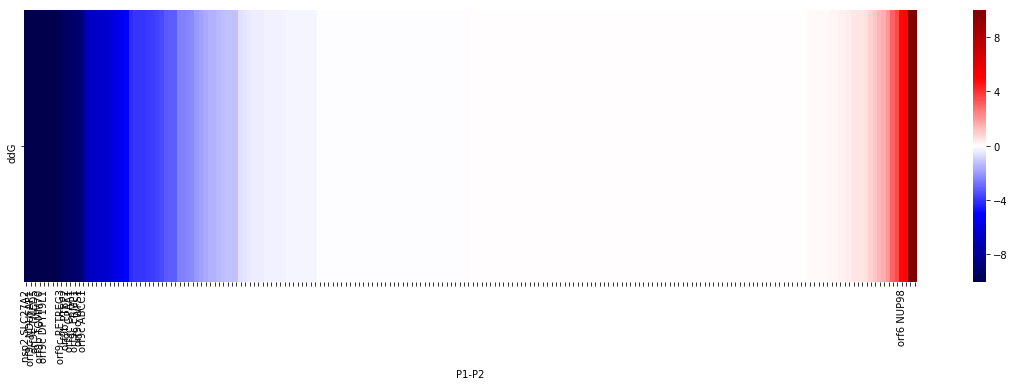

In [560]:
plt.figure(figsize=(20, 5))
plot_df = summary[summary["p-value"] <= 10.05].sort_values("ddG")[["P1", "P2", "ddG", "ddG_Std", "p-value"]].set_index(["P1", "P2"])[["ddG"]].T
#labels = summary[summary["p-value"] <= 10.05].sort_values("ddG")[["P1", "P2", "ddG", "ddG_Std", "p-value"]][["P1", "P2"]].apply(lambda x: " ".join([x[0].replace("COVID19", ""), uni2gene[x[1]]]), axis=1)
#labels = [x[0] if x[1] else "" for x in zip(labels, list((summary[summary["p-value"] <= 10.05].sort_values("ddG")["p-value"] <= 0.05)&(summary[summary["p-value"] <= 10.05].sort_values("ddG")["ddG"].abs() >= 0.1)))]
labels = summary.sort_values("ddG")[["P1", "P2"]].apply(lambda x: " ".join([x[0].replace("COVID19", ""), uni2gene[x[1]]]), axis=1)
labels = [x[0] if x[1] else "" for x in zip(labels, ((summary.sort_values("ddG")["z-score"].abs() >= 1)&(summary.sort_values("ddG")["p-value"] <= 0.05)).values)]

sns.heatmap(plot_df, annot=False, cmap="seismic", center=0, vmin=-10, vmax=10, xticklabels=labels)
plt.savefig("Figures/Figure_4/ddG_Heatmap.svg")

In [578]:
summary[summary["z-score"] <= 0.05]["ddG"].mean()

-7.0545047023029221

In [1084]:
interactions[interactions["PreyGene"] == "NDUFAF1"]

Bait   Preys PreyGene      MIST  Saint_BFDR  AvgSpec  \
328  SARS-CoV2 orf9c  Q9Y375  NDUFAF1  0.762046         0.0     3.67   

     FoldChange Uniprot Protein ID  \
328       36.67        CIA30_HUMAN   

                           Uniprot Protein Description  \
328  Complex I intermediate-associated protein 30, ...   

                                      Uniprot Function Structures (PDB)  \
328   Chaperone protein involved in early stages of...              NaN   

                           Uniprot Function in Disease  
328   Mitochondrial complex I deficiency, nuclear t...

In [571]:
x = zip([x for x in labels if not x == ""], summary[(summary["p-value"] <= 0.05)&(summary["ddG"].abs() > 0.1)].sort_values("ddG")["ddG"].values)
print "; ".join(["{0}_{1}, ΔΔG={2} REU".format(y[0].split()[0], y[0].split()[1], np.round(y[1], 1)) for y in x])

nsp2_SLC27A2, ΔΔG=-67.4 REU; orf9c_NDUFAF1, ΔΔG=-21.7 REU; orf9c_TMED5, ΔΔG=-21.1 REU; orf9b_TOMM70, ΔΔG=-11.3 REU; orf9c_DPY19L1, ΔΔG=-11.3 REU; orf9c_RETREG3, ΔΔG=-9.6 REU; orf9b_PTBP2, ΔΔG=-9.4 REU; orf9c_GPAA1, ΔΔG=-9.3 REU; orf9c_ERMP1, ΔΔG=-9.1 REU; orf9c_WFS1, ΔΔG=-9.1 REU; orf9c_ABCC1, ΔΔG=-8.2 REU; orf6_NUP98, ΔΔG=-6.7 REU


In [1059]:
plot_df

P1        nsp2      orf9c                 orf9b      orf9c       nsp4  \
P2      O14975     Q9Y375     Q9Y3A6     O94826     Q2PZI1     Q9NVH1   
ddG -67.371688 -21.725772 -21.090012 -11.295079 -11.258809 -11.005193   

P1       Spike       nsp4     orf9c     orf9b     orf9c                      \
P2      Q9C0B5     Q2TAA5    Q86VR2    Q9UKA9    O43292    Q7Z2K6    O76024   
ddG -10.931322 -10.678562 -9.574915 -9.443929 -9.315172 -9.130117 -9.124104   

P1               nsp2      nsp1 nsp5C145A     orf9c      nsp1     orf9c  \
P2    P33527   P52306    Q8NBJ5    P07203    Q9BQ95    P09884    Q96S52   
ddG -8.16728 -6.70656 -6.651297 -6.466259 -6.429514 -6.333879 -6.179203   

P1      orf9b     orf9c                                                    \
P2     O75534    P55085    Q9H3K2    O00124    Q9Y276    Q5BJF2    Q8TEQ8   
ddG -5.889737 -5.531458 -5.525927 -4.990522 -4.103045 -3.978596 -3.949444   

P1                Spike      nsp2     orf9c      nsp2      nsp1     orf9b  \
P2     Q9GZU3    Q7Z5G4    O60573    Q9NV92    Q2M389    P49642    Q9P0L2   
ddG -3.933389 -3.866439 -3.779901 -3.725904 -3.551203 -3.257503 -3.144084   

P1       nsp5     orf9b     orf9c      nsp2     orf9c     nsp12     orf9c  \
P2     Q92769    P27448    Q96K12    P16435    Q9BVK2    Q5VUA4    Q9H845   
ddG -3.140414 -2.450516 -2.442187 -2.355892 -2.327644 -1.957425 -1.849401   

P1                orf9b     orf9c     orf9b      nsp1     orf9b      orf6  \
P2     Q9Y6M9    Q9H773    Q12770    Q9H2P9    Q14181    O43633    Q9NZJ7   
ddG -1.652139 -1.549079 -1.532008 -1.363613 -1.309599 -1.235738 -1.206402   

P1      orf9c      nsp9     nsp12     orf9b     nsp12             orf9b  \
P2     Q6NXT6    Q15056    Q6UUV7    Q9UL15    Q5JSZ5    A3KN83  Q7KZI7   
ddG -1.192857 -0.596925 -0.520039 -0.431063 -0.364004 -0.324818 -0.3188   

P1      orf9c     nsp12      nsp1     nsp15     nsp12              orf9b  \
P2     Q86UT6    O14874    P49643    Q9H4P4    Q96IZ5    Q2T9J0   O14745   
ddG -0.302333 -0.300799 -0.290571 -0.288727 -0.271015 -0.225024 -0.21699   

P1      nsp14    nsp15    nsp12                                   nsp10  \
P2     P12268   P61970   Q70EL1    Q9H2H8    O95391    Q14157    Q9HAV7   
ddG -0.215161 -0.18434 -0.18225 -0.179906 -0.159863 -0.068759 -0.066892   

P1      nsp13                nsp8     nsp13                               \
P2     Q9UJC3    Q08117    Q9Y399    P17612   Q66GS9    O75506    O95684   
ddG -0.035168 -0.030842 -0.029637 -0.026853 -0.02215 -0.018953 -0.018436   

P1       nsp8               nsp13                                          \
P2     P82663    Q9BSC4    Q5VU43    O14578    Q76N32    Q8IUD2    P31323   
ddG -0.017867 -0.017346 -0.016771 -0.015006 -0.013344 -0.012734 -0.011851   

P1                                                                  nsp9  \
P2     Q92995    Q96N16   Q9BQQ3    Q8N3C7    Q9Y2I6    Q8N8E3    Q9NZL9   
ddG -0.008082 -0.007369 -0.00532 -0.004814 -0.003657 -0.002055 -0.001775   

P1                nsp13     nsp8                                       \
P2     Q9BVL2    Q04726   P82675    Q13868   Q9H6F5   O00566   Q13206   
ddG -0.000699 -0.000335 -0.00026 -0.000232 -0.00013 -0.00013 -0.00013   

P1                     nsp9                                      nsp7         \
P2     Q9HD40        P61962        Q8N0X7        Q7Z3B4        O95573 Q96A26   
ddG -0.000116 -2.273737e-13 -1.136868e-13 -5.684342e-14 -5.684342e-14   -0.0   

P1                                nsp9                                     \
P2  Q96DA6 Q9H7Z7 Q9NP72 Q9BQE4 P35556 P37198 Q86YT6 Q8TD19 Q96F45 Q9UBX5   
ddG   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   

P1    nsp7  nsp10   nsp9   nsp7                                            \
P2  Q8WVC6 P55789 P13984 Q8WUY8 P61006 Q8NBX0 P61586 P61019 P51149 P51148   
ddG   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   

P1                                                                         \
P2  P62820 P628

In [1528]:
summary.to_csv("Data/ddG_Summary.txt", sep="\t", index=None)

In [1529]:
summary

P1      P2     WT_Score  WT_Score_Std      WT_dG     WT_dG_Std  \
0    Spike  Q7Z5G4  3051.234048  6.829502e+00  -5.623792  1.175974e+01   
1    Spike  Q9C0B5  2870.359616  7.023421e+00   2.470355  1.057938e+01   
2     nsp1  P09884   180.903808  1.721268e-01   5.896759  2.976744e-01   
3     nsp1  P49642   477.628474  4.811245e-01  21.410461  5.557518e-01   
4     nsp1  P49643   257.120881  1.513332e-01   4.529541  2.504445e-01   
5     nsp1  Q14181   134.920678  2.156605e-01   0.881150  2.634243e-01   
6     nsp1  Q8NBJ5   173.615201  2.314679e-01  10.033363  2.568443e-01   
7     nsp1  Q99959   330.959649  2.527619e-01   4.075671  3.692727e-01   
8    nsp10  O94973  2321.514854  2.011504e-02  -0.213331  2.780036e-02   
9    nsp10  P55789   293.021533  4.019437e-13  -0.799726  2.242989e-16   
10   nsp10  Q969X5   230.769955  2.806812e-02   0.323581  2.945117e-02   
11   nsp10  Q96CW1   244.942083  1.300439e-02  -1.516534  1.751663e-02   
12   nsp10  Q9HAV7   309.938412  2.871026e-13   3.245981  5.873216e-02   
13   nsp12  A3KN83   984.239413  1.008445e+00   0.036995  1.463343e+00   
14   nsp12  O14874  1687.819910  9.567121e-01  -0.327416  1.731269e+00   
15   nsp12  O43823  2321.102245  1.251233e+00  -0.481709  1.552137e+00   
16   nsp12  O75592  1052.851522  9.397933e-01  -0.485758  1.305114e+00   
17   nsp12  O95391  1154.277775  9.227542e-01  -0.397925  1.561889e+00   
18   nsp12  Q13546  1061.721805  8.864854e-01   0.097794  1.134917e+00   
19   nsp12  Q14157  1020.377412  1.143648e+00  -1.212055  1.508034e+00   
20   nsp12  Q2T9J0   959.094196  9.315043e-01  -0.347127  1.420727e+00   
21   nsp12  Q5EBL8   980.468587  9.538780e-01  -2.604261  1.407953e+00   
22   nsp12  Q5JSZ5  3636.249055  7.524766e-01  -0.256073  1.261878e+00   
23   nsp12  Q5T6F2  1021.775476  1.039303e+00  -0.342825  1.107194e+00   
24   nsp12  Q5VUA4  1142.036739  1.193978e+00   5.033964  1.589897e+00   
25   nsp12  Q6UUV7  2138.212190  8.289833e-01  -2.370367  1.302007e+00   
26   nsp12  Q70EL1  3207.827472  9.343187e-01  -2.953483  1.483651e+00   
27   nsp12  Q8IWR0   967.435972  9.742778e-01  -0.217181  1.305260e+00   
28   nsp12  Q92615   892.296511  8.043996e-01  -0.078241  1.184888e+00   
29   nsp12  Q96IZ5   945.423918  9.008654e-01  -0.198673  1.272709e+00   
..     ...     ...          ...           ...        ...           ...   
174  orf9b  Q9H773   193.755457  2.272864e-01  -2.202055  4.415321e-01   
175  orf9b  Q9P0L2   330.845953  5.172329e-01   8.283525  8.223997e-01   
176  orf9b  Q9UKA9   114.311969  5.142082e-01  -0.001801  7.929487e-01   
177  orf9b  Q9UL15   169.410890  5.032075e-01   4.564564  8.830700e-01   
178  orf9c  O00124   251.286249  5.636993e-01  -0.550042  9.240909e-01   
179  orf9c  O43292  1238.304145  5.805857e-01  -3.729355  8.662764e-01   
180  orf9c  O76024   354.763031  2.876226e-01   5.204502  7.040174e-01   
181  orf9c  P33527   294.109389  8.562674e-01  -0.470424  9.972507e-01   
182  orf9c  P55085   213.748827  5.668439e-01  -4.923519  1.123467e+00   
183  orf9c  Q12770   288.850564  8.709888e-01   4.541022  1.343871e+00   
184  orf9c  Q2PZI1   348.417904  5.905619e-01  -1.077319  1.098407e+00   
185  orf9c  Q5BJF2   341.696336  6.580080e-01  -3.900547  9.966103e-01   
186  orf9c  Q6NXT4   314.012806  4.977842e-01  -4.402697  8.691541e-01   
187  orf9c  Q6NXT6   179.870010  5.311246e-01  -0.294992  8.921029e-01   
188  orf9c  Q7Z2K6   256.444204  3.190124e-01  -1.606500  8.473311e-01   
189  orf9c  Q86UT6   520.864871  1.227675e+00  32.532249  1.583430e+00   
190  orf9c  Q86VR2   381.747575  4.396691e-01   0.910780  7.228755e-01   
191  orf9c  Q8TEQ8   275.608541  6.094885e-01 -11.914325  1.182135e+00   
192  orf9c  Q96K12   267.086667  4.945566e-01   5.058127  1.092325e+00   
193  orf9c  Q96S52   237.653243  8.459869e-01  -5.485922  1.056780e+00   
194  orf9c  Q9BQ95   365.647964  6.803884e-01  -0.670901  1.082057e+00   
195  orf9c  Q9BVK2   267.799985  4.916527e-01  -4.634314  6.469750e-01   
196  orf9c  

In [207]:
"sele chain A and (resi " + " or resi ".join([str(x[0]) for x in viral2muts["COVID19nsp4"]]) + ")"

'sele chain A and (resi 37 or resi 272 or resi 247 or resi 99 or resi 50 or resi 353 or resi 102 or resi 9 or resi 40 or resi 23 or resi 380 or resi 408 or resi 13 or resi 91 or resi 458 or resi 35 or resi 110 or resi 363 or resi 58 or resi 181 or resi 261 or resi 26 or resi 180 or resi 332 or resi 284 or resi 87 or resi 11 or resi 379 or resi 90 or resi 94 or resi 24 or resi 370 or resi 252 or resi 483 or resi 312 or resi 372 or resi 114 or resi 382 or resi 345 or resi 390 or resi 307 or resi 231 or resi 235 or resi 265 or resi 290 or resi 5 or resi 10 or resi 184 or resi 246 or resi 328 or resi 280 or resi 297 or resi 32 or resi 41 or resi 113 or resi 39 or resi 62 or resi 319 or resi 267 or resi 233 or resi 387 or resi 303 or resi 264 or resi 403 or resi 395 or resi 83 or resi 433 or resi 163 or resi 28 or resi 434 or resi 183 or resi 38 or resi 250 or resi 17 or resi 27 or resi 383 or resi 70 or resi 366 or resi 334 or resi 19 or resi 20 or resi 391 or resi 73 or resi 33 or resi 27

In [208]:
ddGs[ddGs["P2"] == "Q8TEM1"]

P1      P2  Docking_Rank  ddG_Trial     WT_Score       WT_dG  \
0   COVID19nsp4  Q8TEM1             1          0  6109.679957   88.533325   
1   COVID19nsp4  Q8TEM1             1          1  6074.243432   51.950925   
2   COVID19nsp4  Q8TEM1             1          2  6139.168760  108.160458   
3   COVID19nsp4  Q8TEM1             1          3  6087.695136   38.420417   
4   COVID19nsp4  Q8TEM1             1          4  6089.213366   60.259979   
5   COVID19nsp4  Q8TEM1             1          5  6057.209450    6.681003   
6   COVID19nsp4  Q8TEM1             1          6  6093.100251   60.723914   
7   COVID19nsp4  Q8TEM1             1          7  6105.122904   67.011121   
8   COVID19nsp4  Q8TEM1             1          8  6054.463666   26.643378   
9   COVID19nsp4  Q8TEM1             1          9  6094.757909   69.973197   
0   COVID19nsp4  Q8TEM1             2          0  6038.007187   10.517555   
1   COVID19nsp4  Q8TEM1             2          1  6076.824815    3.056076   
2   COVID19nsp4  Q8TEM1             2          2  6111.199396   60.296521   
3   COVID19nsp4  Q8TEM1             2          3  6084.967325   59.737957   
4   COVID19nsp4  Q8TEM1             2          4  6074.360956   23.202399   
5   COVID19nsp4  Q8TEM1             2          5  6062.002539   12.092549   
6   COVID19nsp4  Q8TEM1             2          6  6091.376892   31.629893   
7   COVID19nsp4  Q8TEM1             2          7  6057.008714    2.917848   
8   COVID19nsp4  Q8TEM1             2          8  6105.793267   67.595138   
9   COVID19nsp4  Q8TEM1             2          9  6053.045742   21.712106   
0   COVID19nsp4  Q8TEM1             3          0  6053.185052   19.761329   
1   COVID19nsp4  Q8TEM1             3          1  6070.586510   23.690302   
2   COVID19nsp4  Q8TEM1             3          2  6079.205118    4.668097   
3   COVID19nsp4  Q8TEM1             3          3  6055.415571   18.936444   
4   COVID19nsp4  Q8TEM1             3          4  6082.471516   15.578312   
5   COVID19nsp4  Q8TEM1             3          5  6083.789374   18.025963   
6   COVID19nsp4  Q8TEM1             3          6  6075.975515   33.933157   
7   COVID19nsp4  Q8TEM1             3          7  6092.690943   50.766736   
8   COVID19nsp4  Q8TEM1             3          8  6049.529827   10.225987   
9   COVID19nsp4  Q8TEM1             3          9  6079.263367   34.489116   
..          ...     ...           ...        ...          ...         ...   
0   COVID19nsp4  Q8TEM1             8          0  6090.583177   10.262028   
1   COVID19nsp4  Q8TEM1             8          1  6115.775695   17.762549   
2   COVID19nsp4  Q8TEM1             8          2  6099.978592   30.542203   
3   COVID19nsp4  Q8TEM1             8          3  6052.791676   11.595468   
4   COVID19nsp4  Q8TEM1             8          4  6039.755681   -7.195749   
5   COVID19nsp4  Q8TEM1             8          5  6071.762949   23.101183   
6   COVID19nsp4  Q8TEM1             8          6  6042.709662  -18.408043   
7   COVID19nsp4  Q8TEM1             8          7  6083.163453    1.197978   
8   COVID19nsp4  Q8TEM1             8          8  6058.929526   14.814838   
9   COVID19nsp4  Q8TEM1             8          9  6050.784518   22.109505   
0   COVID19nsp4  Q8TEM1             9          0  6043.304398   12.112368   
1   COVID19nsp4  Q8TEM1             9          1  6040.942979    2.008451   
2   COVID19nsp4  Q8TEM1             9          2  6084.854784   39.389366   
3   COVID19nsp4  Q8TEM1             9          3  6043.807728  -21.625544   
4   COVID19nsp4  Q8TEM1             9          4  6043.246661   16.585133   
5   COVID19nsp4  Q8TEM1             9          5  6045.241392  -16.785241   
6   COVID19nsp4  Q8TEM1             9          6  6063.512625    1.400756   
7   COVID19nsp4  Q8TEM1             9          7  6120.512959    4.035393   
8   COVID19nsp4  Q8TEM1             9          8  6037.219912    0.358891   
9   COVID19nsp4  Q8TEM1             9          9  6082.743542   51.914550   
0   COVID

In [96]:
g[1][["WT_Score", "WT_dG", "Mut_dG", "ddG"]].std(axis=0)

WT_Score    11.747875
WT_dG       11.697371
Mut_dG      11.612656
ddG         14.965672
dtype: float64

P1      P2  Docking_Rank  ddG_Trial     WT_Score      WT_dG  \
1  COVID19Spike  Q7Z5G4             4          1  3095.361617  22.586207   

    Mut_Score     Mut_dG        ddG  \
1  3206.84518 -19.983902 -42.570109   

                                             pdbfile  
1  Data/ddG_Mutated_Structures/COVID19Spike_Q7Z5G...

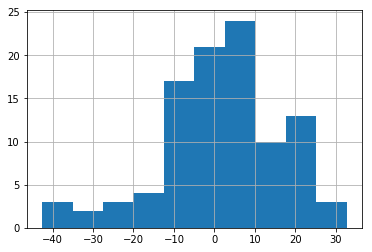

In [100]:
g[1]["ddG"].hist()

In [105]:
import scipy

In [ ]:
scipy.stats.norm.sf(abs(z_scores))

In [109]:
scipy.stats.norm.sf(2)

0.022750131948179195

# Run ddG for Interface Scanning

In [262]:
from collections import defaultdict

In [263]:
ppi_docking = pd.read_csv("Data/Docking_Summary.txt", sep="\t")

In [264]:
ppi_docking = ppi_docking.groupby(["P1", "P2"]).head(10)

In [265]:
from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()

import helper as my
import time

In [333]:
def run_ddg_scanning(p1, p2, pdb, rank, iresA, iresB, trials, interface_cutoff):
    #os.system("rm Data/ddG_Single_Mutants/Raw_Outputs/{0}_{1}/*".format(p1, p2))
    cmd = "nice python Ires_ddG_Scanning.py --pdb_filename {0} --partners A_B --mutant_aa {1} --trials {2} --output True --trial_output Raw_Outputs/{7}_{8}/ddG_{3}_mut_to_{1} --iresA {4} --iresB {5} --interface_cutoff {6}".format(pdb, mut, trials, os.path.basename(pdb.split(".")[0]) ,iresA, iresB, interface_cutoff, p1, p2)
    p = sp.Popen(cmd, shell=True)
    return {"p":p, "cmd":cmd, "start_time":time.time(), "end_time":None, "in":(p1, p2, rank)}
# FUNCTION END

In [335]:
import subprocess as sp
# Run Ligand Docking in Loop
i_num = 1
finished_processes = []
processes = []

max_processes = 30

trials = 10
interface_cutoff = 8.0
# Iterate over all Docking Inputs
for p1, p2, pdb, rank, ires1, ires2, attempt in tqdm_notebook(ppi_docking[ppi_docking["Rank"] == 1].sort_values(["Rank", "P1", "P2"])[["P1", "P2", "File", "Rank", "P1_Ires", "P2_Ires", "Attempt"]].values):
    if(attempt < 39):
        continue
    for mut in tqdm_notebook("ARNDCEQGHILKMFPSTWYV"):
        #if(os.path.exists("Data/ddG_Mutated_Structures/Summary_Logs/{0}_{1}_{2}".format(p1, p2, rank))):
        #    continue
        if(len(glob.glob("Data/ddG_Single_Mutants/Raw_Outputs/{0}_{1}/*_to_{2}*".format(p1, p2, mut))) == 10):
            continue
        #break

        # Make Block new jobs if too many running already
        while(True):
            if(len(processes) <= max_processes):
                p = run_ddg_scanning(p1, p2, pdb, rank, ires1, ires2, trials, interface_cutoff)
                processes.append(p)
                break
            else:
                new_processes = []
                for p in processes:
                    if(p["p"].poll() is None):
                        new_processes.append(p)
                    elif(p["p"].poll() != 0):
                        p["end_time"] = time.time()
                        print "Error", p["p"].poll()
                        print "cmd:", p["cmd"]
                        print "RunTime:", (p["end_time"] - p["start_time"])
                        print
                        finished_processes.append(p)
                    else:
                        p["end_time"] = time.time()
                        print "Finished ddG", p["in"], "in", (p["end_time"] - p["start_time"])
                        finished_processes.append(p)
                processes = new_processes
                time.sleep(5)
        #break
    #break
# Wait to completion
while(True):
    if(len(processes) == 0):
        break
    else:
        new_processes = []
        for p in processes:
            if(p["p"].poll() is None):
                new_processes.append(p)
            elif(p["p"].poll() != 0):
                p["end_time"] = time.time()
                print "Error", p["p"].poll()
                print "cmd:", p["cmd"]
                print "RunTime:", (p["end_time"] - p["start_time"])
                print
                finished_processes.append(p)
            else:
                p["end_time"] = time.time()
                print "Finished ddG", p["in"], "in", (p["end_time"] - p["start_time"])
                finished_processes.append(p)
        processes = new_processes
        time.sleep(5)

17/|/  7%|| 17/250 [00:20<04:35,  1.18s/it]Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 497.134213924
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 503.223452091
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 501.855429888
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 508.053028107
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 507.913311958


Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 513.544831991
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 520.50731802
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 517.760454893
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 525.569577932
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 525.445930958
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 525.308209181
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 524.908029079
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 524.479880095
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 535.87350297
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 535.324970007
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 534.299683094
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 539.610312939
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 546.344830036


Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 554.709091187
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 571.438357115
Finished ddG ('COVID19nsp10', 'Q9HAV7', 1) in 580.967017174
Finished ddG ('COVID19nsp10', 'Q96CW1', 1) in 592.688855886
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 724.235132933
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 724.129236937
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 729.275652885
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 734.753904104
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 740.030524015
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 745.41643095
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 775.462090969


Finished ddG ('COVID19nsp12', 'Q99081', 1) in 744.933881998
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 744.828655958
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 749.827319145
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 749.688166857
Finished ddG ('COVID19nsp12', 'Q99081', 1) in 775.41707015
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 773.006269932
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 767.705574989


Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 793.167831182
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 818.474051952
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 772.767146111
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 767.648220062
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 793.345106125
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 798.63780117
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 803.581675053
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 768.167553902
Finished ddG ('COVID19nsp12', 'Q9HAU0', 1) in 813.674298048
Finished ddG ('COVID19nsp12', 'O75592', 1) in 1955.00965095
Finished ddG ('COVID19nsp13', 'P31323', 1) in 657.179330826
Finished ddG ('COVID19nsp12', 'O75592', 1) in 2055.32034898
Finished ddG ('COVID19nsp13', 'P31323', 1) in 702.403236151
Finished ddG ('COVID19nsp13', 'P31323', 1) in 652.339442015
Finished ddG ('COVID19nsp13', 'P31323', 1) in 657.3922472
Finished ddG ('COVID19nsp13', 'P31323', 1) in 642.02858305


Finished ddG ('COVID19nsp13', 'P31323', 1) in 662.63990593
Finished ddG ('COVID19nsp13', 'P31323', 1) in 642.254007101
Finished ddG ('COVID19nsp13', 'P31323', 1) in 672.809237957
Finished ddG ('COVID19nsp13', 'P31323', 1) in 672.460974932
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1769.80342603
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1778.67712092


Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1794.66428089
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1805.13907909
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1788.96595502
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1805.2069571
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1804.92935991
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1810.0146122
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1830.34745908
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1814.6390841
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1845.43481612
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1855.16704607
Finished ddG ('COVID19nsp12', 'Q9H2H8', 1) in 1886.79542089


Finished ddG ('COVID19nsp13', 'P31323', 1) in 634.742014885
Finished ddG ('COVID19nsp13', 'P31323', 1) in 629.781111956
Finished ddG ('COVID19nsp13', 'P31323', 1) in 709.894199133
Finished ddG ('COVID19nsp13', 'P31323', 1) in 664.688790083
Finished ddG ('COVID19nsp13', 'P31323', 1) in 654.80610013
Finished ddG ('COVID19nsp13', 'P31323', 1) in 669.763768196
Finished ddG ('COVID19nsp13', 'P31323', 1) in 664.582058191
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1614.45521712


Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1604.34721518
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1604.35928988
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1574.28598905
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1654.93861699
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1685.26582098
Finished ddG ('COVID19nsp13', 'A7MCY6', 1) in 1584.58541489
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1054.91194201
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1059.60111308
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1070.04915285
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1069.68109488
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1049.47870016
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1090.700845
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1044.53681397
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1150.65008211


Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1150.17845201
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1114.81560683
Finished ddG ('COVID19nsp13', 'Q08378', 1) in 1134.93392015
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 2058.76115704
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 2023.35210514
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 2008.26800394
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 2129.080194
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 2139.0080359
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1484.17646885
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1539.50806594
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1569.80905604
Finished ddG ('COVID19nsp13', 'Q04726', 1) in 2134.06335378


Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1609.84188509
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1579.54938602
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1619.99859095
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2242.61602306
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2202.52496505
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1479.70390582
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1495.05897713
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1499.81676912
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1519.72156405


Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2173.07657099
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1514.90932202
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2183.21679592
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1540.37718606
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1444.59928012
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1485.04592705
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1611.23131895
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2198.76178908
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2178.41203809
Finished ddG ('COVID19nsp13', 'Q4V328', 1) in 1580.89494395
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1575.69226193
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2319.18732691
Finished ddG ('COVID19nsp13', 'Q14789', 1) in 2329.47750592
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1054.00681591
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1074.02132583


Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1134.39842701
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1431.32703805
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1426.32326102
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1466.32648683
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1481.37204504
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1461.21734691
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1471.36369991
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1425.98746109
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 938.917485952
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1471.64709783
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 948.933789968
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 964.626358032
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1085.74147797
Finished ddG ('COVID19nsp13', 'Q66GS9', 1) in 1476.84348893
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1020.39977598
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 939.43799305


Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1076.08103395
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1010.4102242
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1101.52902102
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1106.44292498
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 970.024935007
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1010.47453594
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 944.870100021
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 980.359076977
Finished ddG ('COVID19nsp13', 'Q76N32', 1) in 1096.85593104
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1035.92199612


Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1015.55260897
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1005.56109405
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1000.55373096
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 990.267854929
Finished ddG ('COVID19nsp13', 'Q7Z7A1', 1) in 1075.65663409
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1335.67992306
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1240.216748
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1340.6603229
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1230.45227003
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1436.18129396
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1214.86393595
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1270.63577199
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1219.63096285
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1381.18504715
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1330.98779702


Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1315.40389895
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1351.01142097
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1365.94875789
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1416.7578721
Finished ddG ('COVID19nsp13', 'Q8IWJ2', 1) in 1421.50735188
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1494.49119282
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1489.56881094
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1569.68632603
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2127.35819292
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2167.25467587
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2162.12833214
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1525.17051506
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2187.63049912


Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2238.24977303
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1535.65495205
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2202.66785812
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2318.26008916
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2323.27100396
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2328.157655
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2348.24713278
Finished ddG ('COVID19nsp13', 'Q8N4C6', 1) in 2338.28283715
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1461.54452991
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1476.59323692
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1537.10643697
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1451.49386406


Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1542.09933496
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1502.07289386
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1486.44264102
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1567.12849903
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1431.01408005
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1582.2780149
Finished ddG ('COVID19nsp13', 'Q8N8E3', 1) in 1557.21981192
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1521.91104412
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1536.920362
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1516.67670417
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1506.63096619
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1491.604846
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1406.2872951
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1501.71609497


Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 947.995920897
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1426.52871203
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1496.91743684
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1426.62322497
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1436.15490103
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1425.953794
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 1018.63673115
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 953.422571898
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1482.03945184
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 973.869278908
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 953.711303949


Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 984.060081005
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1396.77271581
Finished ddG ('COVID19nsp13', 'Q96N16', 1) in 1563.04905891
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 979.224117994
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1532.68778992
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 989.309724092
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 939.11670208
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 939.08307004
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1457.62622404
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 1024.71728206
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1492.73812079
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1462.50413799


Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1462.71022391
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1487.7054739
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1462.66687179
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1477.63911414
Finished ddG ('COVID19nsp13', 'Q96SN8', 1) in 1492.62936616
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 925.215065956
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 1020.60694098
Finished ddG ('COVID19nsp13', 'Q9BV19', 1) in 950.31469512
Finished ddG ('COVID19nsp15', 'P61970', 1) in 945.228644133
Finished ddG ('COVID19nsp15', 'P61970', 1) in 975.146347046
Finished ddG ('COVID19nsp15', 'P61970', 1) in 1010.18427801
Finished ddG ('COVID19nsp15', 'P61970', 1) in 959.99763608
Finished ddG ('COVID19nsp15', 'P61970', 1) in 954.855655193
Finished ddG ('COVID19nsp15', 'P61970', 1) in 990.265068054
Finished ddG ('COVID19nsp15', 'P61970', 1) in 1086.04633617


Finished ddG ('COVID19nsp15', 'P61970', 1) in 1015.48407006
Finished ddG ('COVID19nsp15', 'P61970', 1) in 979.99007678
Finished ddG ('COVID19nsp15', 'P61970', 1) in 1030.45738792
Finished ddG ('COVID19nsp15', 'P61970', 1) in 1000.44052291
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1083.63392401
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1330.76858091
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1093.81711316
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1088.79229784
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1043.79540706
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1375.9719038
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1391.25868201
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1411.18407297
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1370.88677001
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1406.31006384


Finished ddG ('COVID19nsp2', 'P52306', 1) in 1094.58918285
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1064.45395494
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1346.27361393
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1130.273386
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1075.07407284
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1498.22208118


Finished ddG ('COVID19nsp2', 'O14975', 1) in 1422.43776584
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1452.86017895
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1417.58109808
Finished ddG ('COVID19nsp2', 'O14975', 1) in 1457.47973204
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1095.93704796
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1050.89099312
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1070.92084599
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1005.35002184
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1076.01148582
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1040.84717894
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1101.41730094
Finished ddG ('COVID19nsp2', 'P52306', 1) in 1086.32542491
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1045.85035086
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1040.71813393
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1081.31303191


Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1031.06784201
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1041.07441497
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1025.95162392
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 868.405447006
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1041.38303685
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1056.22763586
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 888.782649994
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1031.47014904


Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1031.65911388
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 919.513722897
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1021.65944695
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 869.445398092
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1031.79407191
Finished ddG ('COVID19nsp2', 'Q2M389', 1) in 1077.28599
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 859.80907011
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 864.83445096
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 864.666863918
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 859.518435001
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 885.150527
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 859.693695068
Finished ddG ('COVID19nsp4', 'Q8TEM1', 1) in 1388.04106998
Finished ddG ('COVID19nsp4', 'Q8TEM1', 1) in 1397.86971188
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 910.373005152
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 870.050135136
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 849.910475016


Finished ddG ('COVID19nsp4', 'Q8TEM1', 1) in 1418.39352298
Finished ddG ('COVID19nsp4', 'Q8TEM1', 1) in 1418.33922505
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 895.791596889
Finished ddG ('COVID19nsp4', 'Q9NVH1', 1) in 890.493982077
Finished ddG ('COVID19nsp4', 'Q8TEM1', 1) in 1418.6338501
Finished ddG ('COVID19nsp4', 'Q8TEM1', 1) in 1474.59929395
Finished ddG ('COVID19nsp7', 'O43169', 1) in 346.160203218
Finished ddG ('COVID19nsp7', 'O43169', 1) in 345.908083916
Finished ddG ('COVID19nsp7', 'O43169', 1) in 351.168925047
Finished ddG ('COVID19nsp7', 'O43169', 1) in 345.996175051
Finished ddG ('COVID19nsp7', 'O43169', 1) in 350.953741074
Finished ddG ('COVID19nsp7', 'O43169', 1) in 396.753022909
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1232.08607697
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1080.60375619
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1080.43356013
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1095.49745297
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9'

Finished ddG ('COVID19nsp7', 'O43169', 1) in 362.187020063
Finished ddG ('COVID19nsp7', 'O43169', 1) in 356.947169065
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1206.88399601
Finished ddG ('COVID19nsp7', 'O43169', 1) in 372.240532875
Finished ddG ('COVID19nsp7', 'O43169', 1) in 347.214243889
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1288.53138804
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1293.52507806
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1308.97707915
Finished ddG ('COVID19nsp7', 'O43169', 1) in 377.700282097
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1288.42876792
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1309.02341199
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1323.9338131
Finished ddG ('COVID19nsp4', 'Q9Y5J6', 1) in 1404.99893379
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1072.49295712
Finished ddG ('COVID19nsp7', 'O43169', 1) in 358.441590071
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1138.02107286
Finished ddG ('COVID19nsp7', 'O43169', 1) 

Finished ddG ('COVID19nsp7', 'O43169', 1) in 348.666133165
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1083.02805495
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1082.99897885
Finished ddG ('COVID19nsp7', 'O43169', 1) in 363.94114399
Finished ddG ('COVID19nsp7', 'O43169', 1) in 378.918678999
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1087.74665904
Finished ddG ('COVID19nsp7', 'O95573', 1) in 353.661998987
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1149.05001688
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1113.46279788
Finished ddG ('COVID19nsp7', 'O95573', 1) in 353.854463816
Finished ddG ('COVID19nsp7', 'O43169', 1) in 389.526104212
Finished ddG ('COVID19nsp7', 'O95573', 1) in 358.822730064


Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1128.89355016
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1123.70824099
Finished ddG ('COVID19nsp7', 'O95573', 1) in 369.193625927
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1174.65890002
Finished ddG ('COVID19nsp7', 'O95573', 1) in 364.409833908
Finished ddG ('COVID19nsp7', 'O95573', 1) in 405.161246777
Finished ddG ('COVID19nsp7', 'O95573', 1) in 359.431095123
Finished ddG ('COVID19nsp7', 'O95573', 1) in 374.726339102
Finished ddG ('COVID19nsp5C145A', 'Q9NXH9', 1) in 1149.51672006
Finished ddG ('COVID19nsp7', 'O95573', 1) in 354.379992008
Finished ddG ('COVID19nsp7', 'O95573', 1) in 354.509077072
Finished ddG ('COVID19nsp7', 'O95573', 1) in 390.022136927
Finished ddG ('COVID19nsp7', 'O95573', 1) in 389.669317961
Finished ddG ('COVID19nsp7', 'O95573', 1) in 374.65686202
Finished ddG ('COVID19nsp7', 'O95573', 1) in 379.673696995
Finished ddG ('COVID19nsp7', 'O95573', 1) in 339.481528997


Finished ddG ('COVID19nsp7', 'O95573', 1) in 379.725046873
Finished ddG ('COVID19nsp7', 'P61006', 1) in 222.395319939
Finished ddG ('COVID19nsp7', 'O95573', 1) in 384.856053829
Finished ddG ('COVID19nsp7', 'P61006', 1) in 242.587007999
Finished ddG ('COVID19nsp7', 'P61006', 1) in 237.472856998
Finished ddG ('COVID19nsp7', 'P61006', 1) in 232.319852829
Finished ddG ('COVID19nsp7', 'P61006', 1) in 253.12067008
Finished ddG ('COVID19nsp7', 'P61006', 1) in 237.58415103
Finished ddG ('COVID19nsp7', 'P61006', 1) in 222.291628838
Finished ddG ('COVID19nsp7', 'P61006', 1) in 232.823474884


Finished ddG ('COVID19nsp7', 'P61006', 1) in 237.756608009
Finished ddG ('COVID19nsp7', 'P61006', 1) in 237.616637945
Finished ddG ('COVID19nsp7', 'O95573', 1) in 411.146083117
Finished ddG ('COVID19nsp7', 'P61006', 1) in 227.850799084
Finished ddG ('COVID19nsp7', 'P61006', 1) in 237.856313944
Finished ddG ('COVID19nsp7', 'P61006', 1) in 232.837738037
Finished ddG ('COVID19nsp7', 'P61006', 1) in 237.82958889
Finished ddG ('COVID19nsp7', 'P61006', 1) in 227.845932961
Finished ddG ('COVID19nsp7', 'P61006', 1) in 232.866411924
Finished ddG ('COVID19nsp7', 'P00387', 1) in 627.089062929
Finished ddG ('COVID19nsp7', 'P00387', 1) in 636.987132072
Finished ddG ('COVID19nsp7', 'P00387', 1) in 631.871654987
Finished ddG ('COVID19nsp7', 'P00387', 1) in 606.875351906


Finished ddG ('COVID19nsp7', 'P00387', 1) in 632.247277975
Finished ddG ('COVID19nsp7', 'P00387', 1) in 611.870803118
Finished ddG ('COVID19nsp7', 'P00387', 1) in 677.982032061
Finished ddG ('COVID19nsp7', 'P00387', 1) in 647.437098026
Finished ddG ('COVID19nsp7', 'P00387', 1) in 632.252573013
Finished ddG ('COVID19nsp7', 'P00387', 1) in 652.512090921
Finished ddG ('COVID19nsp7', 'P00387', 1) in 632.399590015
Finished ddG ('COVID19nsp7', 'P61026', 1) in 424.680031061
Finished ddG ('COVID19nsp7', 'P00387', 1) in 662.575984001
Finished ddG ('COVID19nsp7', 'P61026', 1) in 424.556032181
Finished ddG ('COVID19nsp7', 'P61026', 1) in 434.839148998
Finished ddG ('COVID19nsp7', 'P61026', 1) in 429.564301014
Finished ddG ('COVID19nsp7', 'P61026', 1) in 419.164311171
Finished ddG ('COVID19nsp7', 'P61026', 1) in 439.884083033
Finished ddG ('COVID19nsp7', 'P61026', 1) in 424.360006809


Finished ddG ('COVID19nsp7', 'P61026', 1) in 475.841062069
Finished ddG ('COVID19nsp7', 'P61026', 1) in 450.278656006
Finished ddG ('COVID19nsp7', 'P61026', 1) in 450.029245138
Finished ddG ('COVID19nsp7', 'P61586', 1) in 660.195585966
Finished ddG ('COVID19nsp7', 'P61586', 1) in 665.110099077
Finished ddG ('COVID19nsp7', 'P61586', 1) in 660.126339912
Finished ddG ('COVID19nsp7', 'P61586', 1) in 665.148191929
Finished ddG ('COVID19nsp7', 'P62820', 1) in 398.467290163
Finished ddG ('COVID19nsp7', 'P62820', 1) in 408.480268955
Finished ddG ('COVID19nsp7', 'P62820', 1) in 398.417191029
Finished ddG ('COVID19nsp7', 'P62820', 1) in 393.28361392
Finished ddG ('COVID19nsp7', 'P61586', 1) in 731.316084862
Finished ddG ('COVID19nsp7', 'P61586', 1) in 670.734470129
Finished ddG ('COVID19nsp7', 'P62820', 1) in 408.752452135
Finished ddG ('COVID19nsp7', 'P61586', 1) in 655.929832935


Finished ddG ('COVID19nsp7', 'P62820', 1) in 464.817841053
Finished ddG ('COVID19nsp7', 'P61586', 1) in 696.499803066
Finished ddG ('COVID19nsp7', 'P62820', 1) in 419.197126865
Finished ddG ('COVID19nsp7', 'P62820', 1) in 394.028372049
Finished ddG ('COVID19nsp7', 'P62820', 1) in 404.164685011
Finished ddG ('COVID19nsp7', 'P62820', 1) in 399.024724007
Finished ddG ('COVID19nsp7', 'P62820', 1) in 388.394462109
Finished ddG ('COVID19nsp7', 'P61586', 1) in 707.08506012
Finished ddG ('COVID19nsp7', 'P62820', 1) in 414.357576847
Finished ddG ('COVID19nsp7', 'P62820', 1) in 429.675456047
Finished ddG ('COVID19nsp7', 'P62820', 1) in 419.354354143
Finished ddG ('COVID19nsp7', 'P62820', 1) in 460.417485952
Finished ddG ('COVID19nsp7', 'P61586', 1) in 667.613016129


Finished ddG ('COVID19nsp7', 'P61586', 1) in 682.689031839
Finished ddG ('COVID19nsp7', 'P61586', 1) in 682.558462143
Finished ddG ('COVID19nsp7', 'P61586', 1) in 712.849057913
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 740.37904191
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 755.300935984
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 825.656482935
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 598.34662509
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 598.191408157
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 603.227665901
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 578.220650911
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 577.90128994
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 746.173514128
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 710.51582408


Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 608.743340015
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 746.520471096
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 623.877851963
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 593.38944602
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 593.259371996
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 665.05777812
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 767.046859026
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 624.104730844
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 746.597244024
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 782.390585899
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 639.199905872
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 751.764400005


Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 762.372351885
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 736.703736067
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 782.865494967
Finished ddG ('COVID19nsp7', 'Q9NP72', 1) in 604.917066813
Finished ddG ('COVID19nsp8', 'O76094', 1) in 554.638520956
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 762.514247894
Finished ddG ('COVID19nsp7', 'Q5JTV8', 1) in 797.975992203
Finished ddG ('COVID19nsp8', 'O76094', 1) in 549.932982922
Finished ddG ('COVID19nsp8', 'O76094', 1) in 610.247642994
Finished ddG ('COVID19nsp8', 'P82663', 1) in 243.293658018
Finished ddG ('COVID19nsp8', 'P82663', 1) in 253.188747168
Finished ddG ('COVID19nsp8', 'P82663', 1) in 242.930256128


Finished ddG ('COVID19nsp8', 'P82663', 1) in 248.394670963
Finished ddG ('COVID19nsp8', 'P82663', 1) in 253.284190893
Finished ddG ('COVID19nsp8', 'P82663', 1) in 253.269262791
Finished ddG ('COVID19nsp8', 'P82663', 1) in 243.106893778
Finished ddG ('COVID19nsp8', 'P82663', 1) in 279.247092962
Finished ddG ('COVID19nsp8', 'P82663', 1) in 258.356106997
Finished ddG ('COVID19nsp8', 'O76094', 1) in 561.376906872
Finished ddG ('COVID19nsp8', 'P82663', 1) in 248.367844105
Finished ddG ('COVID19nsp8', 'P82663', 1) in 253.465159178
Finished ddG ('COVID19nsp8', 'O76094', 1) in 556.613874197
Finished ddG ('COVID19nsp8', 'P82663', 1) in 263.467021942
Finished ddG ('COVID19nsp8', 'P82663', 1) in 258.380547047


Finished ddG ('COVID19nsp8', 'O76094', 1) in 561.89993906
Finished ddG ('COVID19nsp8', 'O76094', 1) in 531.723464966
Finished ddG ('COVID19nsp8', 'O76094', 1) in 556.577152967
Finished ddG ('COVID19nsp8', 'O76094', 1) in 582.240407944
Finished ddG ('COVID19nsp8', 'O76094', 1) in 556.737903833
Finished ddG ('COVID19nsp8', 'O76094', 1) in 592.229888916
Finished ddG ('COVID19nsp8', 'O76094', 1) in 601.954085112
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 575.006348848
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 589.843739986
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 579.681412935
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 579.535418987


Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 589.980980873
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 574.841520071
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 655.880071878
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 620.123858929
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 427.806176901
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 615.262465
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 595.243924856
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 585.236049175
Finished ddG ('COVID19nsp8', 'Q8NEJ9', 1) in 640.298373938
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 493.283055067
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 433.383171082
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 443.390146017
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 438.233703136
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 433.064191103


Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 448.400134087
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 423.393211842
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 761.039529085
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 781.618561029
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 781.246451139
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 771.089831114
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 750.776808023
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 791.901365042
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 751.032037973
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 822.341424942


Finished ddG ('COVID19nsp8', 'Q92552', 1) in 771.27391696
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 424.403239965
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 797.150755882
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 429.514389038
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 460.095730066
Finished ddG ('COVID19nsp8', 'Q92552', 1) in 812.236572027
Finished ddG ('COVID19nsp8', 'Q9H6F5', 1) in 459.888077974
Finished ddG ('COVID19nsp9', 'P13984', 1) in 416.226211071
Finished ddG ('COVID19nsp9', 'P13984', 1) in 431.09424305
Finished ddG ('COVID19nsp9', 'P13984', 1) in 425.953680992


Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 573.547621012
Finished ddG ('COVID19nsp9', 'P13984', 1) in 441.666445971
Finished ddG ('COVID19nsp9', 'P13984', 1) in 441.427782774
Finished ddG ('COVID19nsp9', 'P13984', 1) in 482.102117777
Finished ddG ('COVID19nsp9', 'P13984', 1) in 446.448033094
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 588.956518888
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 578.959794044
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 573.956148863
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 639.618097067
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 583.867825985
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 589.293935061
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 573.882750034
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 609.457115173
Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 589.076505899


Finished ddG ('COVID19nsp8', 'Q9ULT8', 1) in 619.674643993
Finished ddG ('COVID19nsp9', 'P13984', 1) in 418.122024059
Finished ddG ('COVID19nsp9', 'P35556', 1) in 417.890833139
Finished ddG ('COVID19nsp9', 'P35556', 1) in 432.776933908
Finished ddG ('COVID19nsp9', 'P13984', 1) in 463.426929951
Finished ddG ('COVID19nsp9', 'P35556', 1) in 427.802211046
Finished ddG ('COVID19nsp9', 'P35556', 1) in 427.944194078
Finished ddG ('COVID19nsp9', 'P35556', 1) in 473.559932947
Finished ddG ('COVID19nsp9', 'P35556', 1) in 438.135677099
Finished ddG ('COVID19nsp9', 'P35556', 1) in 417.972566843
Finished ddG ('COVID19nsp9', 'P35556', 1) in 458.319674015
Finished ddG ('COVID19nsp9', 'P35556', 1) in 427.816235065
Finished ddG ('COVID19nsp9', 'P35556', 1) in 432.752177954
Finished ddG ('COVID19nsp9', 'P35556', 1) in 473.543308973
Finished ddG ('COVID19nsp9', 'P35556', 1) in 417.75188899
Finished ddG ('COVID19nsp9', 'P35556', 1) in 458.532521963
Finished ddG ('COVID19nsp9', 'P35556', 1) in 463.55940294

Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1436.41323996
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1431.034343
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1461.4496119
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1466.48812389
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1547.02189207
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1491.52954912
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1431.32593584
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1466.6212821
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1436.12860298
Finished ddG ('COVID19nsp9', 'P35658', 1) in 679.76958704
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1476.76795006


Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1531.91336679
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1461.36498809
Finished ddG ('COVID19nsp8', 'Q9HD40', 1) in 1506.86937284
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 185.50329113
Finished ddG ('COVID19nsp9', 'P35658', 1) in 685.4080441
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 220.647642851
Finished ddG ('COVID19nsp9', 'P35658', 1) in 675.542802095
Finished ddG ('COVID19nsp9', 'P37198', 1) in 553.265471935
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 195.784029007
Finished ddG ('COVID19nsp9', 'P35658', 1) in 736.294417858
Finished ddG ('COVID19nsp9', 'P35658', 1) in 690.951745987
Finished ddG ('COVID19nsp9', 'P35658', 1) in 690.782979965
Finished ddG ('COVID19nsp9', 'P35658', 1) in 685.614155054
Finished ddG ('COVID19nsp9', 'P35658', 1) in 706.249256849
Finished ddG ('COVID19nsp9', 'P35658', 1) in 675.602535009
Finished ddG ('COVID19nsp9', 'P35658', 1) in 701.058076143
Finished ddG ('COVID19nsp9', 'P35658', 1) in 670.862259865


Finished ddG ('COVID19nsp9', 'P37198', 1) in 554.364746094
Finished ddG ('COVID19nsp9', 'P37198', 1) in 634.893595934
Finished ddG ('COVID19nsp9', 'P37198', 1) in 559.361045837
Finished ddG ('COVID19nsp9', 'P35658', 1) in 670.905473948
Finished ddG ('COVID19nsp9', 'P35658', 1) in 686.372610807
Finished ddG ('COVID19nsp9', 'P35658', 1) in 681.199503899
Finished ddG ('COVID19nsp9', 'P35658', 1) in 711.808021069
Finished ddG ('COVID19nsp9', 'P35658', 1) in 696.342067957
Finished ddG ('COVID19nsp9', 'P35658', 1) in 696.327075958
Finished ddG ('COVID19nsp9', 'P37198', 1) in 575.207977057
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 193.327998877


Finished ddG ('COVID19nsp9', 'P37198', 1) in 565.312296152
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 188.577763796
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 193.687887907
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 178.492941141
Finished ddG ('COVID19nsp9', 'P37198', 1) in 590.995382071
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 198.961000919
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 188.701498985
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 198.997206926
Finished ddG ('COVID19nsp9', 'P37198', 1) in 581.321567059
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 184.013594866
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 183.519827843
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 193.936109066


Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 199.278079033
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 193.979266882
Finished ddG ('COVID19nsp9', 'P37198', 1) in 561.998081923
Finished ddG ('COVID19nsp9', 'P37198', 1) in 552.001385927
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 194.255650997
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 204.294852018
Finished ddG ('COVID19nsp9', 'Q8TD19', 1) in 204.133019924
Finished ddG ('COVID19nsp9', 'P37198', 1) in 612.438067913
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 526.545053005
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 531.260106087
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 536.242089987
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 551.670018911


Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 556.548250914
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 607.320803881
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 566.591651917
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 531.425971985
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 719.568370104
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 719.148088932
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 729.485459089
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 749.790232897
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 734.338314056


Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 734.296781063
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 744.609565973
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 719.228238821
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 760.114725113
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 744.700851917
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 811.153698921
Finished ddG ('COVID19nsp9', 'Q9NZL9', 1) in 774.926389933
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 948.221019983
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 968.139983177
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 953.018027782
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 932.706707001
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 973.458488941
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 947.667567968


Finished ddG ('COVID19nsp9', 'Q99567', 1) in 988.584180117
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 953.020535946
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 1019.42249608
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 998.82980299
Finished ddG ('COVID19nsp9', 'Q99567', 1) in 1018.74435091
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 343.107137918
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 347.768807888
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 347.781396151
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 530.470483065
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 363.247043133
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 363.109833002
Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 535.799213886


Finished ddG ('COVID19nsp9', 'Q9UBX5', 1) in 571.343245983
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 394.13953805
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 373.650074005
Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 343.482717991
Error 1
cmd: nice python Ires_ddG_Scanning.py --pdb_filename [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/docking_outputs/COVID19orf8_P00750_43_0.pdb --partners A_B --mutant_aa A --trials 10 --output True --trial_output Raw_Outputs/COVID19orf8_P00750/ddG_COVID19orf8_P00750_43_0_mut_to_A --iresA 37,38,40,41,42,43,105,114,115,118,119 --iresB 453,455,457,458,496A,496B,496C,496D,496E,496F,496G,496H,505,540 --interface_cutoff 8.0
RunTime: 10.142991066

Error 1
cmd: nice python Ires_ddG_Scanning.py --pdb_filename [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/docking_outputs/COVID19orf8_P00750_43_0.pdb --partners A_B --mutant_aa R --trials 10 --output True --trial_output Raw_Outputs/COVID19

Finished ddG ('COVID19orf6', 'Q9NZJ7', 1) in 381.177350044
Error 1
cmd: nice python Ires_ddG_Scanning.py --pdb_filename [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/docking_outputs/COVID19orf8_P00750_43_0.pdb --partners A_B --mutant_aa T --trials 10 --output True --trial_output Raw_Outputs/COVID19orf8_P00750/ddG_COVID19orf8_P00750_43_0_mut_to_T --iresA 37,38,40,41,42,43,105,114,115,118,119 --iresB 453,455,457,458,496A,496B,496C,496D,496E,496F,496G,496H,505,540 --interface_cutoff 8.0
RunTime: 10.8935630322

Error 1
cmd: nice python Ires_ddG_Scanning.py --pdb_filename [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/docking_outputs/COVID19orf8_P00750_43_0.pdb --partners A_B --mutant_aa W --trials 10 --output True --trial_output Raw_Outputs/COVID19orf8_P00750/ddG_COVID19orf8_P00750_43_0_mut_to_W --iresA 37,38,40,41,42,43,105,114,115,118,119 --iresB 453,455,457,458,496A,496B,496C,496D,496E,496F,496G,496H,505,540 --interf

Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 346.609514952
Finished ddG ('COVID19orf6', 'P78406', 1) in 761.045032024
Finished ddG ('COVID19orf6', 'P78406', 1) in 780.923064947
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 351.735946894
Finished ddG ('COVID19orf6', 'P78406', 1) in 796.312246084
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 331.708432913
Finished ddG ('COVID19orf8', 'P05556', 1) in 237.93303895
Finished ddG ('COVID19orf8', 'P05556', 1) in 227.896785975
Finished ddG ('COVID19orf8', 'P05556', 1) in 227.782245159
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 352.562777042
Finished ddG ('COVID19orf8', 'P05556', 1) in 243.320043087


Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 332.31704998
Finished ddG ('COVID19orf8', 'P05556', 1) in 238.331669092
Finished ddG ('COVID19orf8', 'P05556', 1) in 233.080894947
Finished ddG ('COVID19orf8', 'P05556', 1) in 243.614360094
Finished ddG ('COVID19orf6', 'P78406', 1) in 823.041380882
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 353.216696978
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 353.045530081
Finished ddG ('COVID19orf6', 'P78406', 1) in 788.174211979
Finished ddG ('COVID19orf8', 'P05556', 1) in 269.92478013
Finished ddG ('COVID19orf6', 'P78406', 1) in 752.969645977
Finished ddG ('COVID19orf8', 'P05556', 1) in 249.240828991
Finished ddG ('COVID19orf6', 'P78406', 1) in 778.574829102
Finished ddG ('COVID19orf8', 'P05556', 1) in 244.391569853
Finished ddG ('COVID19orf8', 'P05556', 1) in 234.089797974
Finished ddG ('COVID19orf8', 'P05556', 1) in 244.645389795
Finished ddG ('COVID19orf7a', 'Q7Z4Q2', 1) in 369.33614707
Finished ddG ('COVID19orf8', 'P05556', 1) in 249.659667

Finished ddG ('COVID19orf8', 'P05556', 1) in 234.717350006
Finished ddG ('COVID19orf6', 'P78406', 1) in 799.622649908
Finished ddG ('COVID19orf8', 'P28300', 1) in 238.019761086
Finished ddG ('COVID19orf8', 'P28300', 1) in 232.617547989
Finished ddG ('COVID19orf8', 'P28300', 1) in 243.061800003
Finished ddG ('COVID19orf8', 'P28300', 1) in 232.755040884
Finished ddG ('COVID19orf8', 'P28300', 1) in 237.58383894
Finished ddG ('COVID19orf8', 'P28300', 1) in 232.288370132
Finished ddG ('COVID19orf8', 'P28300', 1) in 258.751853943
Finished ddG ('COVID19orf8', 'P28300', 1) in 248.160795927
Finished ddG ('COVID19orf8', 'P28300', 1) in 248.004547834
Finished ddG ('COVID19orf8', 'P28300', 1) in 237.423453093


Finished ddG ('COVID19orf8', 'P28300', 1) in 248.32427597
Finished ddG ('COVID19orf8', 'P28300', 1) in 242.909868956
Finished ddG ('COVID19orf8', 'P28300', 1) in 237.777956009
Finished ddG ('COVID19orf8', 'P28300', 1) in 237.949179888
Finished ddG ('COVID19orf8', 'P28300', 1) in 258.462234974
Finished ddG ('COVID19orf8', 'P28300', 1) in 253.041445971
Finished ddG ('COVID19orf8', 'P28300', 1) in 252.892226934
Finished ddG ('COVID19orf8', 'P26358', 1) in 477.373622894
Finished ddG ('COVID19orf8', 'P26358', 1) in 462.075235128
Finished ddG ('COVID19orf8', 'P26358', 1) in 452.087165117
Finished ddG ('COVID19orf8', 'P26358', 1) in 477.564140081
Finished ddG ('COVID19orf8', 'P26358', 1) in 456.832613945
Finished ddG ('COVID19orf8', 'P26358', 1) in 512.991204023
Finished ddG ('COVID19orf8', 'P26358', 1) in 456.824233055
Finished ddG ('COVID19orf8', 'P26358', 1) in 456.684127092


Finished ddG ('COVID19orf8', 'P26358', 1) in 477.888798952
Finished ddG ('COVID19orf8', 'P26358', 1) in 487.906565905
Finished ddG ('COVID19orf8', 'P26358', 1) in 492.756416082
Finished ddG ('COVID19orf8', 'P58166', 1) in 317.81071496
Finished ddG ('COVID19orf8', 'P58166', 1) in 317.599446058
Finished ddG ('COVID19orf8', 'P58166', 1) in 312.494886875
Finished ddG ('COVID19orf8', 'P58166', 1) in 302.348875999
Finished ddG ('COVID19orf8', 'P58166', 1) in 328.209429026
Finished ddG ('COVID19orf8', 'P58166', 1) in 312.756137848
Finished ddG ('COVID19orf8', 'P58166', 1) in 327.781081915
Finished ddG ('COVID19orf8', 'P58166', 1) in 312.768153191
Finished ddG ('COVID19orf8', 'P29122', 1) in 616.103235006
Finished ddG ('COVID19orf8', 'P29122', 1) in 640.986066103
Finished ddG ('COVID19orf8', 'P29122', 1) in 691.359011889
Finished ddG ('COVID19orf8', 'P58166', 1) in 313.216801167


Finished ddG ('COVID19orf8', 'P58166', 1) in 313.26891017
Finished ddG ('COVID19orf8', 'P58166', 1) in 308.232830048
Finished ddG ('COVID19orf8', 'P58166', 1) in 318.259768009
Finished ddG ('COVID19orf8', 'P58166', 1) in 313.110666037
Finished ddG ('COVID19orf8', 'P29122', 1) in 606.877568007
Finished ddG ('COVID19orf8', 'P29122', 1) in 616.896378994
Finished ddG ('COVID19orf8', 'P29122', 1) in 601.485592127
Finished ddG ('COVID19orf8', 'P29122', 1) in 601.432374954
Finished ddG ('COVID19orf8', 'P29122', 1) in 637.143184185
Finished ddG ('COVID19orf8', 'P29122', 1) in 621.449651003
Finished ddG ('COVID19orf8', 'P29122', 1) in 621.178539991
Finished ddG ('COVID19orf8', 'P29122', 1) in 647.458455801
Finished ddG ('COVID19orf8', 'P29122', 1) in 667.365909815
Finished ddG ('COVID19orf8', 'P29122', 1) in 687.133121967
Finished ddG ('COVID19orf8', 'P61916', 1) in 554.87016201


Finished ddG ('COVID19orf8', 'P61916', 1) in 544.687665939
Finished ddG ('COVID19orf8', 'P61916', 1) in 564.977655172
Finished ddG ('COVID19orf8', 'P61916', 1) in 549.858377934
Finished ddG ('COVID19orf8', 'P61916', 1) in 630.465018988
Finished ddG ('COVID19orf8', 'Q08431', 1) in 343.020483017
Finished ddG ('COVID19orf8', 'Q08431', 1) in 347.753157139
Finished ddG ('COVID19orf8', 'Q08431', 1) in 363.080010176
Finished ddG ('COVID19orf8', 'P61916', 1) in 550.193099022
Finished ddG ('COVID19orf8', 'P61916', 1) in 539.944846869
Finished ddG ('COVID19orf8', 'P61916', 1) in 565.798633099
Finished ddG ('COVID19orf8', 'Q08431', 1) in 398.872127056
Finished ddG ('COVID19orf8', 'P61916', 1) in 585.971013069
Finished ddG ('COVID19orf8', 'P61916', 1) in 565.399557114
Finished ddG ('COVID19orf8', 'Q08431', 1) in 348.854331017
Finished ddG ('COVID19orf8', 'P61916', 1) in 616.181179047
Finished ddG ('COVID19orf8', 'P61916', 1) in 560.604353905
Finished ddG ('COVID19orf8', 'Q08431', 1) in 359.0256130

Finished ddG ('COVID19orf8', 'P61916', 1) in 581.07982111
Finished ddG ('COVID19orf8', 'Q08431', 1) in 364.239848137
Finished ddG ('COVID19orf8', 'Q08431', 1) in 359.10173893
Finished ddG ('COVID19orf8', 'Q08431', 1) in 344.230154037
Finished ddG ('COVID19orf8', 'P61916', 1) in 606.819067001
Finished ddG ('COVID19orf8', 'P61916', 1) in 551.444562912
Finished ddG ('COVID19orf8', 'Q08431', 1) in 364.528600931
Finished ddG ('COVID19orf8', 'Q08431', 1) in 379.98688817
Finished ddG ('COVID19orf8', 'Q08431', 1) in 389.687027931
Finished ddG ('COVID19orf8', 'Q08431', 1) in 359.494499922
Finished ddG ('COVID19orf8', 'Q08431', 1) in 364.540143967


Finished ddG ('COVID19orf8', 'P61916', 1) in 571.956357002
Finished ddG ('COVID19orf8', 'P61916', 1) in 587.265022993
Finished ddG ('COVID19orf8', 'Q08431', 1) in 364.86844492
Finished ddG ('COVID19orf8', 'Q13438', 1) in 369.788028955
Finished ddG ('COVID19orf8', 'Q13438', 1) in 379.690101147
Finished ddG ('COVID19orf8', 'Q13438', 1) in 430.035091162
Finished ddG ('COVID19orf8', 'Q13438', 1) in 379.866730928
Finished ddG ('COVID19orf8', 'Q13438', 1) in 379.875005007
Finished ddG ('COVID19orf8', 'Q13438', 1) in 359.720044851
Finished ddG ('COVID19orf8', 'Q13438', 1) in 354.64260602
Finished ddG ('COVID19orf8', 'Q13438', 1) in 394.995903015
Finished ddG ('COVID19orf8', 'Q13438', 1) in 379.692552805
Finished ddG ('COVID19orf8', 'Q13438', 1) in 395.001306057
Finished ddG ('COVID19orf8', 'Q13438', 1) in 384.821135044


Finished ddG ('COVID19orf8', 'Q13438', 1) in 379.709321976
Finished ddG ('COVID19orf8', 'Q13438', 1) in 374.724851131
Finished ddG ('COVID19orf8', 'Q13438', 1) in 364.573256016
Finished ddG ('COVID19orf8', 'Q13438', 1) in 400.321089029
Finished ddG ('COVID19orf8', 'Q13438', 1) in 374.807811975
Finished ddG ('COVID19orf8', 'Q13438', 1) in 409.873065948
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 578.544866085
Finished ddG ('COVID19orf8', 'Q15818', 1) in 695.274156094
Finished ddG ('COVID19orf8', 'Q15818', 1) in 709.887430906
Finished ddG ('COVID19orf8', 'Q15818', 1) in 725.344833136
Finished ddG ('COVID19orf8', 'Q15818', 1) in 730.360724926
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 583.810613871


Finished ddG ('COVID19orf8', 'Q15818', 1) in 705.078410864
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 599.134109974
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 689.65745616
Finished ddG ('COVID19orf8', 'Q15818', 1) in 775.80448103
Finished ddG ('COVID19orf8', 'Q15818', 1) in 806.544403791
Finished ddG ('COVID19orf8', 'Q15818', 1) in 785.951949835
Finished ddG ('COVID19orf8', 'Q15818', 1) in 720.431101084
Finished ddG ('COVID19orf8', 'Q15818', 1) in 755.775366068
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 634.869468927
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 569.314332962
Finished ddG ('COVID19orf8', 'Q15818', 1) in 786.35840416
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 615.107599974
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 635.132577181
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 599.669643879
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 579.798415899
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 569.297568798


Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 655.54537487
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 605.083357096
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 569.400313139
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 630.213346004
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 594.565092802
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 579.409386873
Finished ddG ('COVID19orf8', 'Q8IWF2', 1) in 650.923506975
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 615.373028994
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 604.960055113
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 443.857358932
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 433.613302946
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 443.899774075
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 438.74684906
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 428.371617079
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 494.5381639
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 449.004681826
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 459.167114019
F

Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 611.596487999
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 479.666382074
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 591.434163094
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 586.421669006
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 439.135441065
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 454.538655043
Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 617.108457088
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 459.574269056
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 490.213861942


Finished ddG ('COVID19orf8', 'Q8N0Z8', 1) in 612.320145845
Finished ddG ('COVID19orf8', 'Q96AY3', 1) in 470.022957087
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 474.963335991
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 484.829804897
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 469.694100857
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 469.558537006
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 475.099433184
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 459.546597004
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 520.694958925
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 500.136957169
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 510.048636913
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 475.069991112
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 480.11425519


Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 490.032064915
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 489.861132145
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 397.588160038
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 515.664731026
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 490.211500883
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 500.337927103
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 505.333178997
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 495.040480137
Finished ddG ('COVID19orf8', 'Q96DZ1', 1) in 505.468420029
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 403.296419859
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 403.330598831
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 443.768160105
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 398.18530488
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 392.90541482
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 408.736842871


Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 418.704560041
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 398.404101133
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 423.745580912
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 641.78125
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 398.521669865
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 641.737526894
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 631.620349169


Finished ddG ('COVID19orf8', 'Q96F46', 1) in 677.276489019
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 646.96500206
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 642.013264894
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 631.673930883
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 636.640941858
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 652.275089979
Finished ddG ('COVID19orf8', 'Q96F46', 1) in 662.118198872
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 419.904994965
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 369.602080107
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 364.47487092
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 364.472928047
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 364.341301918
Finished ddG ('COVID19orf8', 'Q96IV0', 1) in 410.431697845
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 354.341733932
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 400.411554098
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 374.837183952


Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 380.103863001
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 364.680334091
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 380.092588902
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 369.924782038
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 374.823092937
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 374.667326927
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 364.509940863
Finished ddG ('COVID19orf8', 'Q96MM7', 1) in 390.279282093
Finished ddG ('COVID19orf8', 'Q99470', 1) in 524.909340858
Finished ddG ('COVID19orf8', 'Q99470', 1) in 579.994357109
Finished ddG ('COVID19orf8', 'Q99470', 1) in 579.992289066
Finished ddG ('COVID19orf8', 'Q99470', 1) in 534.967566967
Finished ddG ('COVID19orf8', 'Q99470', 1) in 534.810311794
Finished ddG ('COVID19orf8', 'Q99470', 1) in 544.959933043
Finished ddG ('COVID19orf8', 'Q99470', 1) in 559.983805895
Finished ddG ('COVID19orf8', 'Q99519', 1) in 720.112053156
Finished ddG ('COVID19orf8', 'Q99519', 1) in 704.5522980

Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 648.85196805


Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 653.833459854
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 638.818377972
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 674.314188957
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 639.001338005
Finished ddG ('COVID19orf8', 'Q99519', 1) in 730.806596994
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 649.036877871
Finished ddG ('COVID19orf8', 'Q99519', 1) in 741.251782894
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 654.261699915
Finished ddG ('COVID19orf8', 'Q99519', 1) in 736.152002096
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 644.417608023
Finished ddG ('COVID19orf8', 'Q99519', 1) in 726.007726908
Finished ddG ('COVID19orf8', 'Q99519', 1) in 762.151489973
Finished ddG ('COVID19orf8', 'Q99519', 1) in 761.890180111
Finished ddG ('COVID19orf8', 'Q99519', 1) in 761.722018957
Finished ddG ('COVID19orf8', 'Q99519', 1) in 761.499385118
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 650.308978081
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 630.2716248

Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 640.538829088
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 650.38352704
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 272.760011911
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 272.93195796
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 661.014188051
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 273.05548811
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 303.694593191
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 278.086874962
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 278.064181089
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 272.789711952
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 626.421813965
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 651.746402979
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 288.662877798
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 278.074935198
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 288.836228848
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 273.365059137


Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 288.759481907
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 263.414633036
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 283.728117943
Finished ddG ('COVID19orf8', 'Q9BS26', 1) in 627.666271925
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 283.574483871
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 278.703883171
Finished ddG ('COVID19orf8', 'Q9H4F8', 1) in 293.723700047
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 738.200260878
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 738.07617712
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 722.929079056
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 778.580510139
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 733.253343105


Finished ddG ('COVID19orf8', 'Q9H488', 1) in 738.345172882
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 728.147800922
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 460.019253016
Finished ddG ('COVID19orf8', 'Q9H488', 1) in 763.659083128
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 470.001013041
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 459.70956707
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 475.147313118
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 464.690182924
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 475.130334139
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 464.552411079
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 464.661288023
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 464.500740051
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 459.2294209


Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 506.574746847
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 469.737895012
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 491.043354988
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 485.757796049
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 474.956175804
Finished ddG ('COVID19orf8', 'Q9H8W4', 1) in 505.731069088
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 540.119408131
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 560.000935078
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 640.396842957
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 555.010588169


Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 560.423418045
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 565.263927937
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 585.24752903
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 545.038300991
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 560.045032024
Finished ddG ('COVID19orf9b', 'O14745', 1) in 514.623746872
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 555.175884008
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 600.678933859
Finished ddG ('COVID19orf8', 'Q9NXK8', 1) in 605.358075857
Finished ddG ('COVID19orf9b', 'O14745', 1) in 529.760980129
Finished ddG ('COVID19orf9b', 'O14745', 1) in 524.935323
Finished ddG ('COVID19orf9b', 'O14745', 1) in 519.918051004
Finished ddG ('COVID19orf9b', 'O14745', 1) in 575.614881039
Finished ddG ('COVID19orf9b', 'O14745', 1) in 535.14703393
Finished ddG ('COVID19orf9b', 'O14745', 1) in 519.851433039


Finished ddG ('COVID19orf9b', 'O14745', 1) in 519.788365126
Finished ddG ('COVID19orf9b', 'O14745', 1) in 530.091683865
Finished ddG ('COVID19orf9b', 'O14745', 1) in 550.665844917
Finished ddG ('COVID19orf9b', 'O14745', 1) in 529.797025919
Finished ddG ('COVID19orf9b', 'O14745', 1) in 555.65699482
Finished ddG ('COVID19orf9b', 'O14745', 1) in 560.390097857
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 528.63619113
Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 820.596321821
Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 815.173662186
Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 835.474623919
Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 845.748295069


Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 825.527658939
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 544.052260876
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 549.378208876
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 539.658182144
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 544.661002159
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 534.168078184
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 580.308242083
Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 862.348127127


Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 565.021080971
Finished ddG ('COVID19orf9b', 'Q7KZI7', 1) in 822.509577036
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 570.005093098
Finished ddG ('COVID19orf9b', 'Q9H773', 1) in 590.618954897
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 760.261811018
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 760.151345015
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 770.182421923
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 755.022921801
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 760.168704987
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 453.968392849
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 806.048559904
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 449.056987047
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 449.075808048
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 464.103471041


Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 464.050844908
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 504.951841831
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 454.03808403
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 474.609447956
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 459.119127989
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 469.431782961
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 444.222075939
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 479.257849932
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 469.235355139
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 449.075607061
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 469.368274927
Finished ddG ('COVID19orf9b', 'Q9UL15', 1) in 459.160233974
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 767.662935019
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 757.664448977
Finished ddG ('COVID19orf9c', 'O76024', 1) in 519.502342224


Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 762.789511919
Finished ddG ('COVID19orf9c', 'O76024', 1) in 539.630381823
Finished ddG ('COVID19orf9c', 'O76024', 1) in 534.49148798
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 788.352514029
Finished ddG ('COVID19orf9b', 'Q9P0L2', 1) in 778.214421034
Finished ddG ('COVID19orf9c', 'O76024', 1) in 595.366200209
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 358.269748211
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 363.148122072
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 373.196316957
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 363.053554058
Finished ddG ('COVID19orf9c', 'O76024', 1) in 525.625306845
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 368.233239889


Finished ddG ('COVID19orf9c', 'O76024', 1) in 515.45806694
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 419.27511692
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 383.560586929
Finished ddG ('COVID19orf9c', 'O76024', 1) in 541.221053123
Finished ddG ('COVID19orf9c', 'O76024', 1) in 525.814142942
Finished ddG ('COVID19orf9c', 'O76024', 1) in 520.662582874
Finished ddG ('COVID19orf9c', 'O76024', 1) in 551.518136978
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 359.150571108
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 354.155663967
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 364.192561865
Finished ddG ('COVID19orf9c', 'O76024', 1) in 566.88219595
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 394.778360844
Finished ddG ('COVID19orf9c', 'O76024', 1) in 541.556464911
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 399.678092957
Finished ddG ('COVID19orf9c', 'O76024', 1) in 577.029030085
Finished ddG ('COVID19orf9c', 'O76024', 1) in 541.690394163
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) 

Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 354.749089003
Finished ddG ('COVID19orf9c', 'Q7Z2K6', 1) in 385.079746962
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 250.432528973
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 403.351127863
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 398.036067963
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 398.024250031
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 408.486337185
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 265.821529865
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 408.019942045
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 418.317671061
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 418.036145926
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 433.796878815
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 469.56378603
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 413.332294941
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 443.800421
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 388.016238928


Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 418.511358976
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 423.501658916
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 458.966528893
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 428.507212877
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 433.515832901
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 782.970155954
Finished ddG ('COVID19orf9c', 'Q8TEQ8', 1) in 473.704656124
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 792.909579992
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 813.172683954
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 803.027512074
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 243.65931201
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 243.644142866
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 238.646964073
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 228.231989145


Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 238.846910954
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 248.844389915
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 879.636711836
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 238.683120012
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 849.288295031
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 253.970363855
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 243.970144033
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 243.802808046
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 238.632282019
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 259.238353014
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 248.933133125
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 789.940379858
Finished ddG ('COVID19orf9c', 'Q96K12', 1) in 259.074965
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 789.774286985
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 825.09615016
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 294.266403198


Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 855.838871002
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 304.359691858
Finished ddG ('COVID19orf9c', 'Q86UT6', 1) in 875.82407403
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 299.491347075
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 294.330181122
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 340.102328062
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 314.658242941
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 289.349683046
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 319.834952116


Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 309.57535696
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 299.391063929
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 330.049398899
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 314.532736063
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 334.818866968
Finished ddG ('COVID19orf9c', 'Q96S52', 1) in 319.548473835
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 314.320309877
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 314.414608002
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 304.442261934
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 309.453909159
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 294.011610031
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 319.614042044
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 355.401521921
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 324.811763048
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 304.38190794

Finished ddG ('COVID19orf9c', 'Q9H3K2', 1) in 309.396224976
Finished ddG ('COVID19orf9c', 'Q9H3K2', 1

In [1406]:
ires1

'41,42,43,44,45,46,47,49,281,282,283,836,837,846,847,848,849,850,852,853,854,855'

In [1407]:
ires2

'17,20,23,24,27,28,30,34,45,48,49,96,98,99,100,102,103,104,105,106,107'

In [60]:
for p in processes:
    p["p"].kill()

In [270]:
0

0

In [1415]:
# Parse Results

In [581]:
inter2ddG = defaultdict()
fail = set()
for p1, p2, pdb, rank, ires1, ires2, attempt in tqdm_notebook(ppi_docking[ppi_docking["Rank"] == 1].sort_values(["Rank", "P1", "P2"])[["P1", "P2", "File", "Rank", "P1_Ires", "P2_Ires", "Attempt"]].values):
    #if(os.path.exists("Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_Mean.txt".format(p1, p2, rank))):
    #    print "Exists"
    #    continue
    
    fs = glob.glob("Data/ddG_Single_Mutants/Raw_Outputs/{0}_{1}/*".format(p1, p2))
    fs = [x for x in fs if int(os.path.basename(x).split("_")[3]) == attempt]
    
    if(len(fs) != 200):
        #print p1, p2, rank, attempt, len(fs)
        os.system("rm Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_*".format(p1, p2, rank))
        fail.add((p1, p2))
    #else:
    #    continue
    if(len(fs) == 0):
        print "ERROR", p1, p2
        continue
    
    m2tmp = defaultdict(lambda: None)
    for f in sorted(fs, key=lambda x: int(x.split("_")[-1].split(".")[0])):
        m = f.split("to_")[1].split("_")[0]
        r = int(f.split("_")[-1].split(".")[0])
        data = pd.read_csv(f, sep="\t", names=["Mut", "ddG_{0}_{1}".format(m, r)])
        
        data["Ref"] = data["Mut"].map(lambda x: x[0])
        data["Pos"] = data["Mut"].map(lambda x: int(x[1:-1]))
        data["Chain"] = ["A"]*len(ires1.split(",")) + ["B"]*len(ires2.split(","))

        data = data[["Chain", "Ref", "Pos", "ddG_{0}_{1}".format(m, r)]]
        
        if(m2tmp[m] is None):
            m2tmp[m] = data
        else:
            m2tmp[m] = m2tmp[m].join(data.set_index(["Ref", "Pos", "Chain"]), on=["Ref", "Pos", "Chain"])
    
    data = None
    if(len(m2tmp) != 20):
        print "ERROR:", p1, p2, len(m2tmp)
    for m in m2tmp:
        if(data is None):
            data = m2tmp[m]
        else:
            data = data.join(m2tmp[m].set_index(["Chain", "Ref", "Pos"]), on=["Chain", "Ref", "Pos"])
    data.to_csv("Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_Full.txt".format(p1, p2, rank), sep="\t", index=None)
    data2 = data.copy()
    for res in set([x.split("_")[1] for x in data if "ddG_" in x]):
        tmp = data[[x for x in data if "_{0}_".format(res) in x]]
        data["ddG_{0}_avg".format(res)] = tmp.mean(axis=1)
        data["ddG_{0}_std".format(res)] = tmp.std(axis=1)
        data["ddG_{0}_z".format(res)] = (tmp.mean(axis=1) - tmp.mean(axis=1).mean()) / tmp.mean(axis=1).std()
    data = data[list(data)[:3] + [x for x in data if "_avg" in x or "_std" in x or "_z" in x]]
    data.to_csv("Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_Mean.txt".format(p1, p2, rank), sep="\t", index=None)

ERROR COVID19orf8 P00750


In [580]:
len(fail)

1

In [332]:
[p for p in finished_processes if "Q99081" in p["cmd"] and "_mut_to_K" in p["cmd"]]

[{'cmd': 'nice python Ires_ddG_Scanning.py --pdb_filename [REDACTED_PATH]/Collaborators/Resource_Maintenance/2020_04_27_Guided_Docking_Test/docking_outputs/COVID19nsp12_Q99081_57_0.pdb --partners A_B --mutant_aa K --trials 10 --output True --trial_output Raw_Outputs/COVID19nsp12_Q99081/ddG_COVID19nsp12_Q99081_57_0_mut_to_K --iresA 407,409,411,412,413,415,440,442,443,444,445,446,546,552,843 --iresB 11,13,14,17,18,20,21,22,23,24,25,26 --interface_cutoff 8.0',
  'end_time': 1599150143.351243,
  'in': ('COVID19nsp12', 'Q99081', 1),
  'p': <subprocess.Popen at 0x7fdfbbaee910>,
  'start_time': 1599149398.963617}]

(None, None)

In [307]:
len(m2tmp.keys())

20

In [1517]:
inter2ddG = defaultdict()
for p1, p2, pdb, rank, ires1, ires2 in tqdm_notebook(ppi_docking[ppi_docking["Rank"] == 1].sort_values(["Rank", "P1", "P2"])[["P1", "P2", "File", "Rank", "P1_Ires", "P2_Ires"]].values):
    if(os.path.exists("Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_Mean.txt".format(p1, p2, rank))):
        continue
    
    fs = glob.glob("Data/ddG_Single_Mutants/ddG_{0}*".format(os.path.basename(pdb).split(".")[0]))
    if(len(fs) == 0):
        print "ERROR", p1, p2
        continue
    
    m2tmp = defaultdict(lambda: None)
    for f in sorted(fs, key=lambda x: int(x.split("_")[-1].split(".")[0])):
        m = f.split("to_")[1].split("_")[0]
        r = int(f.split("_")[-1].split(".")[0])
        data = pd.read_csv(f, sep="\t", names=["Mut", "ddG_{0}_{1}".format(m, r)])
        
        data["Ref"] = data["Mut"].map(lambda x: x[0])
        data["Pos"] = data["Mut"].map(lambda x: int(x[1:-1]))
        data["Chain"] = ["A"]*len(ires1.split(",")) + ["B"]*len(ires2.split(","))

        data = data[["Chain", "Ref", "Pos", "ddG_{0}_{1}".format(m, r)]]
        
        if(m2tmp[m] is None):
            m2tmp[m] = data
        else:
            m2tmp[m] = m2tmp[m].join(data.set_index(["Ref", "Pos", "Chain"]), on=["Ref", "Pos", "Chain"])
    
    data = None
    for m in m2tmp:
        if(data is None):
            data = m2tmp[m]
        else:
            data = data.join(m2tmp[m].set_index(["Chain", "Ref", "Pos"]), on=["Chain", "Ref", "Pos"])
    data.to_csv("Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_Full.txt".format(p1, p2, rank), sep="\t", index=None)
    
    for res in set([x.split("_")[1] for x in data if "ddG_" in x]):
        tmp = data[[x for x in data if "_{0}_".format(res) in x]]
        data["ddG_{0}_avg".format(res)] = tmp.mean(axis=1)
        data["ddG_{0}_std".format(res)] = tmp.std(axis=1)
    data = data[list(data)[:3] + [x for x in data if "_avg" in x or "_std" in x]]
    data.to_csv("Data/ddG_Single_Mutants/Summaries/{0}_{1}_{2}_Mean.txt".format(p1, p2, rank), sep="\t", index=None)

ERROR COVID19orf8 P00750
171/|/ 68%|| 171/250 [00:14<00:06, 11.70it/s]

In [1516]:
fs

[]

In [897]:
uni2coverage_mask["COVID19orf6"]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [895]:
uni2seq["COVID19orf6"]

61

# Parse COVID Variants (Strains)

In [497]:
strain_muts = pd.read_json("COVID_Strain_Missense_Variants.txt", orient="index")
strain_muts.columns = ["Clade", "Date", "Muts"]

In [507]:
p2strain_muts = defaultdict(set)
def do(x):
    for p in x:
        for mut in x[p]:
            if(p == "S"):
                p2 = "Spike"
            else:
                p2 = p.replace("ORF", "orf")
            p2strain_muts["COVID19" + p2].add((mut[0], int(mut[1:-1]), mut[-1]))
# FUNCTION END
strain_muts["Muts"].map(do)

Algeria/G0638_2264/2020             None
Algeria/G0860_2262/2020             None
Anhui/SZ005/2020                    None
Argentina/C1374/2020                None
Argentina/PAIS_A001/2020            None
Argentina/PAIS_A002/2020            None
Argentina/PAIS_A004/2020            None
Argentina/PAIS_A011/2020            None
Argentina/PAIS_A012/2020            None
Argentina/PAIS_A015/2020            None
Argentina/PAIS_A016/2020            None
Argentina/PAIS_A017/2020            None
Argentina/PAIS_A019/2020            None
Argentina/PAIS_A021/2020            None
Argentina/PAIS_A024/2020            None
Argentina/PAIS_A025/2020            None
Argentina/PAIS_A027/2020            None
Australia/NSW02/2020                None
Australia/NSW04/2020                None
Australia/NSW05/2020                None
Australia/NSW09/2020                None
Australia/NSW101/2020               None
Australia/NSW140/2020               None
Australia/NSW141/2020               None
Australia/NSW143

In [514]:
for k in p2strain_muts.keys():
    try:
        uni2seq[k]
    except:
        print k

COVID19orf14
COVID19orf7b
COVID19orf1b
COVID19orf1a


In [519]:
p2ires = defaultdict(set)
for p1, p1_ires in ires_df[["P1", "P1_Ires"]].values:
    if(pd.isnull(p1_ires)):
        continue
    else:
        p2ires[p1].update(set([int(x) for x in p1_ires.split(",")]))

# Check for Disease Muts on Interactors

In [1486]:
def foo(x):
    return "diabetes" in str(x).lower()
# FUNCTION END
print len(set(hgmd[hgmd["PHEN"].map(foo)]["UNIPROT_ACC"].to_list() + clinvar[clinvar["PHEN"].map(foo)]["UNIPROT_ACC"].to_list()))
print len(set(hgmd_sub[hgmd_sub["PHEN"].map(foo)]["UNIPROT_ACC"].to_list() + clinvar_sub[clinvar_sub["PHEN"].map(foo)]["UNIPROT_ACC"].to_list()))

149
2


In [1487]:
def foo(x):
    return "cardio" in str(x).lower() or "heart" in str(x).lower()
# FUNCTION END
print len(set(hgmd[hgmd["PHEN"].map(foo)]["UNIPROT_ACC"].to_list() + clinvar[clinvar["PHEN"].map(foo)]["UNIPROT_ACC"].to_list()))
print len(set(hgmd_sub[hgmd_sub["PHEN"].map(foo)]["UNIPROT_ACC"].to_list() + clinvar_sub[clinvar_sub["PHEN"].map(foo)]["UNIPROT_ACC"].to_list()))

383
14


In [1490]:
def foo(x):
    return "lung" in str(x).lower() or "pulmonary" in str(x).lower()
# FUNCTION END
print len(set(hgmd[hgmd["PHEN"].map(foo)]["UNIPROT_ACC"].to_list() + clinvar[clinvar["PHEN"].map(foo)]["UNIPROT_ACC"].to_list()))
print len(set(hgmd_sub[hgmd_sub["PHEN"].map(foo)]["UNIPROT_ACC"].to_list() + clinvar_sub[clinvar_sub["PHEN"].map(foo)]["UNIPROT_ACC"].to_list()))

274
3


In [1497]:
hgmd[hgmd["UNIPROT_ACC"] == "Q9Y375"]

ID CLASS           DB CHROM    POS_HG19  POS_HG38 REF ALT  \
59374  CM073220    DM  rs387906956    15  41687197.0  41394999   A   C   
59375  CM147238    DM          NaN    15  41688980.0  41396782   A   G   
59376  CM117654    DM  rs387906958    15  41687185.0  41394987   C   T   
59377  CM147239    DM  rs779073553    15  41689011.0  41396813   G   A   
59378  CM117655    DM  rs376344575    15  41687083.0  41394885   G   A   

          GENE  ENTREZ_GENE_ID                   DNA CODON_CHANGE  \
59374  NDUFAF1         51103.0  NM_016013.3:c.619A-C      ACT-CCT   
59375  NDUFAF1         51103.0  NM_016013.3:c.278A-G      CAT-CGT   
59376  NDUFAF1         51103.0  NM_016013.3:c.631C-T      CGT-TGT   
59377  NDUFAF1         51103.0  NM_016013.3:c.247G-A      GAT-AAT   
59378  NDUFAF1         51103.0  NM_016013.3:c.733G-A      GGG-AGG   

                      PROT UNIPROT_ACC  AA_POS AA_CHANGE  \
59374  NP_057097.2:p.T207P      Q9Y375     207        TP   
59375   NP_057097.2:p.H93R      Q9Y375      93        HR   
59376  NP_057097.2:p.R211C      Q9Y375     211        RC   
59377   NP_057097.2:p.D83N      Q9Y375      83        DN   
59378  NP_057097.2:p.G245R      Q9Y375     245        GR   

                                               PHEN      PMID  
59374                          Complex I deficiency  17557076  
59375                          Complex I deficiency  24963768  
59376  Hypertrophic cardiomyopathy, fatal infantile  21931170  
59377                          Complex I deficiency  24963768  
59378  Hypertrophic cardiomyopathy, fatal infantile  21931170

In [461]:
hgmd = pd.read_csv("[REDACTED_PATH]/resources/From_Charles/HGMD/2018.1/HGMD_201801_uniprotmapped.txt", sep="\t")
hgmd_sub = hgmd[hgmd["UNIPROT_ACC"].map(lambda x: x in uni2seq.keys())]

In [462]:
hgmd

ID CLASS            DB CHROM     POS_HG19   POS_HG38 REF ALT  \
0        CM940213    DM           NaN     6   31992338.0   32024561   C   T   
1        CM920135    DM           NaN     6   31992334.0   32024557   C   T   
2        CM013719    FP    rs55940927     6   10626785.0   10626552   G   A   
3        CM035044    FP   rs764139154     6   10557333.0   10557100   G   A   
4        CM024397    FP           NaN     6   10557466.0   10557233   G   C   
5        CM035043    FP           NaN     6   10557155.0   10556922   G   A   
6        CM024398    FP   rs774740944     6   10621664.0   10621431   G   A   
7        CM013718    FP    rs56141211     6   10626680.0   10626447   G   A   
8        CM170890    DM   rs786205577     6   10626656.0   10626423   A   G   
9       CM1212280    DM   rs148284531     6   10626677.0   10626444   A   G   
10      CM1713160    DM           NaN     6   10626722.0   10626489   T   C   
11       CM143662    DP    rs17878703     6   32552137.0   32584360   C   T   
12       CM143661    DP     rs9269955     6   32552138.0   32584361   C   T   
13       CM155998    DP    rs17885382     6   32552095.0   32584318   G   A   
14       CM167510    DP    rs17878857     6   32551951.0   32584174   C   G   
15       CM992170    DP    rs17885482     6   32551912.0   32584135   T   G   
16       CM066935   DM?           NaN     2   50573970.0   50346832   A   T   
17       CM139443    DM  rs1057517946     2   50574085.0   50346947   G   A   
18       CM124769    DM           NaN     2   50574085.0   50346947   G   T   
19       CM124772    DM           NaN     2   50149377.0   49922239   G   A   
20       CM124773    DM   rs200604893     2   50149369.0   49922231   G   A   
21      CM1617274   DM?           NaN     2   50318536.0   50091398   G   A   
22       CM066936   DM?   rs766942777     2   50574047.0   50346909   C   T   
23       CM076490    DM   rs116840811    15   83209178.0   82540427   T   G   
24       CM098938    DM           NaN    15   83209179.0   82540428   A   G   
25       CM033030    FP           NaN    16   30214933.0   30203612   G   T   
26       CM168053   DM?           NaN     X   13738082.0   13719963   A   T   
27       CM087317    DM           NaN     X   13734208.0   13716089   A   G   
28       CM012467    DM           NaN     X   13734752.0   13716633   G   T   
29       CM012470    DM           NaN     X   13732560.0   13714441   T   A   
...           ...   ...           ...   ...          ...        ...  ..  ..   
100679   CM153809    DM           NaN    12     939216.0     830050   G   A   
100680   CM153811    DM           NaN    12     971366.0     862200   T   G   
100681   CM153808    DM           NaN    12     936362.0     827196   T   C   
100682   CM153812    DM           NaN    12     990942.0     881776   T   C   
100683   CM153810    DM           NaN    12     971279.0     862113   C   T   
100684   CM151611   DM?           NaN    12     978164.0     868998   C   T   
100685   CM004850   DFP     rs1801195     8   30999280.0   31141764   T   G   
100686   CM016225   DM?    rs77067228    16   78312527.0   78278630   A   G   
100687   CM171625   DM?  rs1057518676    16   78312531.0   78278634   G   T   
100688   CM080635    FP     rs1042036     2   31565119.0   31342253   G   C   
100689   CM097066   DFP     rs5956583     X  123034511.0  123900661   C   A   
100690   CM070359   DFP     rs2228001     3   14187449.0   14145949   A   C   
100691   CM145786   DM?           NaN    10  111642192.0  109882434   A   C   
100692   CM015158   DFP       rs25487    19   44055726.0   43551574   G   A   
100693   CM094249    DP      rs222859    17    7197794.0    7294475   T   G   
100694  CM1611189    DM  rs1057519312    10   27425300.0   27136371   C   T   
100695   CM173831    DM           NaN     1  244217120.0  244053818   A   G   
100696   CM173833    DM           NaN     1  244218467.0  244055165   G   A   
100697  CM1617926    DM           NaN     1  244218466.0  2440551

In [463]:
len(hgmd["UNIPROT_ACC"].unique()) / 20000.0

0.33805

In [464]:
len(hgmd_sub["UNIPROT_ACC"].value_counts()) / 332.0

0.4246987951807229

In [465]:
hgmd["CLASS"].value_counts()

DM     76677
DM?    18808
FP      2355
DP      1902
DFP      787
R        180
Name: CLASS, dtype: int64

In [466]:
hgmd_sub["CLASS"].value_counts()

DM     2640
DM?     512
FP       55
DP       27
DFP      15
R         2
Name: CLASS, dtype: int64

In [467]:
my.SQLTable2File("ClinVar2017_0605", "[REDACTED_PATH]/bin/Local_MySQL_Copies/ClinVar2017_missense_uniprotmapped.txt", table="missense_uniprotmapped")
clinvar = pd.read_csv("[REDACTED_PATH]/bin/Local_MySQL_Copies/ClinVar2017_missense_uniprotmapped.txt", sep="\t")
clinvar_sub = clinvar[clinvar["UNIPROT_ACC"].map(lambda x: x in uni2seq.keys())]

In [468]:
len(clinvar["UNIPROT_ACC"].unique()) / 20000.0

0.23735

In [469]:
len(clinvar_sub["UNIPROT_ACC"].value_counts()) / 332.0

0.3192771084337349

In [470]:
phen2genes_hgmd = defaultdict(int)
phen2genes_hgmd_sub = defaultdict(int)
keep_unis = set(uni2seq.keys())
for g in tqdm_notebook(hgmd.drop_duplicates(["UNIPROT_ACC", "PHEN"]).groupby("UNIPROT_ACC")):
    for phen in g[1]["PHEN"]:
        for real_phen in phen.split(";"):
            phen2genes_hgmd[real_phen] += 1
            if(g[0] in keep_unis):
                phen2genes_hgmd_sub[real_phen] += 1

In [471]:
len(hgmd["UNIPROT_ACC"].unique()) - len(hgmd_sub["UNIPROT_ACC"].unique())

6620

In [473]:
a = len(hgmd_sub["UNIPROT_ACC"].unique())
b = 332 - len(hgmd_sub["UNIPROT_ACC"].unique())
c = len(hgmd["UNIPROT_ACC"].unique()) - len(hgmd_sub["UNIPROT_ACC"].unique())
d = 20350 - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False)

               Case  Non-Case
Exposed       141.0     191.0
Non-Exposed  6620.0   13398.0


(0.57923705921209434,
 0.84511612335858377,
 0.31335799506560508,
 0.00016955299569887394)

141	191
6620	13398

In [474]:
phen2OR_hgmd = dict()
for phen in tqdm_notebook(phen2genes_hgmd.keys()):
    # Case = Gene has phenotype vs. Gene does not have phenotype
    # Exposure = Gene in interactome vs. Gene no in interactome
    a = phen2genes_hgmd_sub[phen]
    b = 332 - phen2genes_hgmd_sub[phen]
    c = phen2genes_hgmd[phen] - phen2genes_hgmd_sub[phen]
    d = 20350 - (a + b + c)
    
    #if(0 in [a, b, c, d]):
    #    continue
    
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[(a+b):(a+b+c)] = 1
    
    OR, up, low, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True)
    
    phen2OR_hgmd[phen] = [OR, up, low, p, a, b, c, d]

In [475]:
OR_summary_hgmd = pd.DataFrame([[k] + v for k, v in phen2OR_hgmd.iteritems()], columns=["Phen", "OR", "Lower", "Upper", "p-value", "A", "B", "C", "D"])

In [476]:
OR_summary_hgmd[OR_summary_hgmd["C"] == 0].sort_values("A", ascending=False)

Phen  OR  Lower  Upper  \
13                         Reduced 17,20 lyase activity NaN    NaN    NaN   
4991                     Diabetes, type 2, reduced risk NaN    NaN    NaN   
5955                                       Sialidosis 1 NaN    NaN    NaN   
5962              Fetal akinesia with cerebral ischemia NaN    NaN    NaN   
6040                   Altered subcellular localization NaN    NaN    NaN   
6058                     Alkyl-DHAP synthase deficiency NaN    NaN    NaN   
6068             Progressive cerebello-cerebral atrophy NaN    NaN    NaN   
6187              Osteochondrodysplasia, complex lethal NaN    NaN    NaN   
6203  Marfan syndrome with thoracic aortic aneurysm ... NaN    NaN    NaN   
6281                                    Fibrillinopathy NaN    NaN    NaN   
6328                      Cerebellar ataxia and atrophy NaN    NaN    NaN   
6419            Stiff skin syndrome with ectopia lentis NaN    NaN    NaN   
6494  Developmental delay, microcephaly and neurobeh... NaN    NaN    NaN   
6518     Increased head circumference, association with NaN    NaN    NaN   
6611                                     Bruck syndrome NaN    NaN    NaN   
6629  Global developmental delay, hypotonia and weak... NaN    NaN    NaN   
6731             Thoracic aortic aneurysm or dissection NaN    NaN    NaN   
6803  Optic atrophy, autosomal dominant, with hearin... NaN    NaN    NaN   
6844              Hypomyelination & developmental delay NaN    NaN    NaN   
6883         Cardiomyopathy, dilated/Myocarditis, acute NaN    NaN    NaN   
6893                      NADH-cyb5R deficiency, type 1 NaN    NaN    NaN   
5832  Arthrogryposis, severe with developmental dela... NaN    NaN    NaN   
5824                      Increased PLAT antigen levels NaN    NaN    NaN   
5799                           Glucosidase 1 deficiency NaN    NaN    NaN   
5370  Neurodevelopmental delay, hypotonia, strabismu... NaN    NaN    NaN   
5069            Congenital disorder of glycosylation 1h NaN    NaN    NaN   
5083    Arthrogryposis multiplex congenita, neuropathic NaN    NaN    NaN   
5111              Striatonigral degeneration, infantile NaN    NaN    NaN   
5203  IL-17RA deficiency with bacterial and fungal i... NaN    NaN    NaN   
5238  Moderate intellectual disability, ataxia and t... NaN    NaN    NaN   
...                                                 ...  ..    ...    ...   
4398     Hypotonia with infantile spasms and strabismus NaN    NaN    NaN   
4499                         Focal dystonia, late onset NaN    NaN    NaN   
4500          Wolfram-like syndrome, autosomal dominant NaN    NaN    NaN   
4584   Decreased estradiol 17beta-glucuronide transport NaN    NaN    NaN   
4603                                      Fabry disease NaN    NaN    NaN   
4626  Thoracic aortic aneurysm with aortic regurgita... NaN    NaN    NaN   
4668                           Marfan syndrome features NaN    NaN    NaN   
3737     Ectopia lentis & varicose great saphenous vein NaN    NaN    NaN   
3719                       Reduced multidrug resistance NaN    NaN    NaN   
2904              Transfusion-related acute lung injury NaN    NaN    NaN   
3364     Microlissencephaly with multinucleated neurons NaN    NaN    NaN   
2942                 Geleophysic / acromicric dysplasia NaN    NaN    NaN   
2996               Phenotype modification in cutis laxa NaN    NaN    NaN   
3048                       Left ventricular hypertrophy NaN    NaN    NaN   
3098                             Fabry disease, cardiac NaN    NaN    NaN   
3165                                     POR deficiency NaN    NaN    NaN   
3244                                   GRACILE syndrome NaN    NaN    NaN   
3265                              Methaemoglobinaemia 3 NaN    NaN    NaN   
3323                         Temporomandibular disorder NaN    NaN    NaN   
3375      Dystonia, cerebellar atrophy & cardiomyopathy NaN    NaN    NaN   
3700  Intellectual disability, early-onset spas

In [477]:
OR_summary_hgmd[(OR_summary_hgmd["p-value"] <= 0.05) & (OR_summary_hgmd["OR"] > 0)].sort_values("A", ascending=False)

Phen        OR     Lower  \
483                                Complex I deficiency  2.570948  4.060466   
8172                           Sudden unexplained death  1.700632  3.383679   
8675               Congenital disorder of glycosylation  3.423340  5.201033   
4709       Intellectual disability, autosomal recessive  2.465255  4.177608   
1804                           Congenital heart disease  2.151519  3.850012   
3649   Marfan/Thoracic aortic aneurysms and dissections  5.337509  7.923537   
2651                    Adolescent idiopathic scoliosis  5.922544  8.754526   
6621                                   Cuticular drusen  4.337293  6.651371   
1340                                         Cutis laxa  5.337509  7.923537   
7221                    Marfan syndrome with aortopathy  4.114829  6.387402   
417                                Sudden cardiac death  3.014716  5.149056   
6749          Thoracic aortic aneurysms and dissections  3.336860  5.502193   
5138                            Frontotemporal dementia  3.336860  5.502193   
2841                    Schizophrenia, association with  2.220373  4.301213   
6938                    Muscular dystrophy, limb-girdle  2.113314  4.188869   
1677                           Thoracic aortic aneurysm  4.600400  6.971364   
6640             Immunodeficiency, primary, modifier of  3.332928  6.391135   
6260     Neuronal ceroid lipofuscinosis, late infantile  3.332928  6.391135   
6233  Developmental delay, epilepsy, ataxia & mitoch...  5.918251  9.920193   
6139                  Cardiomyopathy, right ventricular  4.918179  8.384848   
6121                         Bardet-Biedl like features  5.918251  9.920193   
6115                          Aortic aneurysm, thoracic  4.333144  7.601968   
6091            Amyotrophic lateral sclerosis, juvenile  4.918179  8.384848   
72                                     Furlong syndrome  5.918251  9.920193   
6018                                      Optic atrophy  3.332928  6.391135   
5932             Hepatitis B, chronic, association with  4.918179  8.384848   
5889           Neuronal ceroid lipofuscinosis, juvenile  4.333144  7.601968   
5788                             Mandibular prognathism  4.918179  8.384848   
5736                      Arrhythmogenic cardiomyopathy  3.596034  6.697509   
5631              Abnormality of metabolism/homeostasis  3.596034  6.697509   
...                                                 ...       ...       ...   
3658                                     Ectopia lentis  5.918251  9.920193   
4885                                 Cerebellar atrophy  5.918251  9.920193   
4848                     Osteoporosis, association with  3.596034  6.697509   
84    Arrhythmogenic right ventricular dysplasia/car...  3.110463  6.137386   
4773                   Ischaemic stroke, increased risk  4.918179  8.384848   
4361  Arrhythmogenic right ventricular cardiomyopath...  5.918251  9.920193   
4357                       Mitochondrial encephalopathy  4.333144  7.601968   
4333                        Marfan syndrome, incomplete  5.918251  9.920193   
4122                              Geleophysic dysplasia  5.918251  9.920193   
3998    Prostate cancer, reduced risk, association with  4.333144  7.601968   
3945              Abnormality of the respiratory system  5.918251  9.920193   
3913           Abnormality of the cardiovascular system  4.333144  7.601968   
3834       Osteogenesis imperfecta, autosomal recessive  3.596034  6.697509   
3754                      Ectopia lentis, isolated form  5.918251  9.920193   
3654                                Ataxia, early-onset  4.918179  8.384848   
2271                   Abnormality of the mitochondrion  3.110463  6.137386   
3575       Thoracic aortic aneurysm, phenotype modifier  5.918251  9.920193   
3553                          Dementia with Lewy bodies  3.332928  6.391135   
3409                        Cleft palate, non-syndromic  3.110463  6.137386   
3379  Hearing loss, no

In [478]:
hgmd_sub[hgmd_sub["PHEN"] == "Sudden unexplained death"].drop_duplicates("GENE")

ID CLASS   DB CHROM     POS_HG19   POS_HG38 REF ALT   GENE  \
39679  CM1717511   DM?  NaN     X  100658867.0  101403879   G   A    GLA   
67267  CM1717765   DM?  NaN    12   32996157.0   32843223   G   A   PKP2   
97170  CM1717591   DM?  NaN     7   91726154.0   92096840   G   A  AKAP9   

       ENTREZ_GENE_ID                    DNA CODON_CHANGE  \
39679          2717.0   NM_000169.2:c.301G-A      GAT-AAT   
67267          5318.0  NM_004572.3:c.1469G-A      CGG-CAG   
97170         10142.0  NM_005751.4:c.9881G-A      CGA-CAA   

                       PROT UNIPROT_ACC  AA_POS AA_CHANGE  \
39679   NP_000160.1:p.D101N      P06280     101        DN   
67267   NP_004563.2:p.R490Q      Q99959     490        RQ   
97170  NP_005742.4:p.R3294Q      Q99996    3298        RQ   

                           PHEN      PMID  
39679  Sudden unexplained death  29247119  
67267  Sudden unexplained death  29247119  
97170  Sudden unexplained death  29247119

In [479]:
phen2genes_clinvar = defaultdict(int)
phen2genes_clinvar_sub = defaultdict(int)
keep_unis = set(uni2seq.keys())
for g in tqdm_notebook(clinvar.drop_duplicates(["UNIPROT_ACC", "PHEN"]).groupby("UNIPROT_ACC")):
    for phen in g[1]["PHEN"]:
        phen = str(phen)
        for real_phen in phen.split(";"):
            phen2genes_clinvar[real_phen] += 1
            if(g[0] in keep_unis):
                phen2genes_clinvar_sub[real_phen] += 1

In [480]:
a = len(clinvar_sub["UNIPROT_ACC"].unique())
b = 332 - len(clinvar_sub["UNIPROT_ACC"].unique())
c = len(clinvar["UNIPROT_ACC"].unique()) - len(clinvar_sub["UNIPROT_ACC"].unique())
d = 20350 - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False)

               Case  Non-Case
Exposed       106.0     226.0
Non-Exposed  4641.0   15377.0


(0.63600795542177435,
 0.91818058839574224,
 0.35383532244780647,
 0.00010467973792360752)

106	226
4641	15377

In [481]:
phen2OR_clinvar = dict()
for phen in tqdm_notebook(phen2genes_clinvar.keys()):
    # Case = Gene has phenotype vs. Gene does not have phenotype
    # Exposure = Gene in interactome vs. Gene no in interactome
    a = phen2genes_clinvar_sub[phen]
    b = 332 - phen2genes_clinvar_sub[phen]
    c = phen2genes_clinvar[phen] - phen2genes_clinvar_sub[phen]
    d = 20350 - (a + b + c)
    
    #if(0 in [a, b, c, d]):
    #    continue
    
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[(a+b):(a+b+c)] = 1
    
    OR, up, low, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True)
    
    phen2OR_clinvar[phen] = [OR, up, low, p, a, b, c, d]

In [482]:
OR_summary_clinvar = pd.DataFrame([[k] + v for k, v in phen2OR_clinvar.iteritems()], columns=["Phen", "OR", "Lower", "Upper", "p-value", "A", "B", "C", "D"])

In [483]:
OR_summary_clinvar[OR_summary_clinvar["C"] == 0].sort_values("A", ascending=False)

Phen  OR  Lower  Upper  \
2626  Arrhythmogenic right ventricular cardiomyopath... NaN    NaN    NaN   
2957                    WFS1-Related Spectrum Disorders NaN    NaN    NaN   
1774             Congenital contractural arachnodactyly NaN    NaN    NaN   
5760                             WFS1-Related Disorders NaN    NaN    NaN   
4971                               Acromicric dysplasia NaN    NaN    NaN   
3797                                Stiff skin syndrome NaN    NaN    NaN   
1360  Microcephalic Osteodysplastic Primordial Dwarfism NaN    NaN    NaN   
4373                                         Dystonia 1 NaN    NaN    NaN   
1491  Diabetes mellitus AND insipidus with optic atr... NaN    NaN    NaN   
1540         Primary autosomal recessive microcephaly 3 NaN    NaN    NaN   
523           Mental retardation, autosomal dominant 42 NaN    NaN    NaN   
1998                 Multifocal epileptiform discharges NaN    NaN    NaN   
502   Medium-chain acyl-coenzyme A dehydrogenase def... NaN    NaN    NaN   
1004                                    Limb hypertonia NaN    NaN    NaN   
1282                   Ceroid lipofuscinosis neuronal 1 NaN    NaN    NaN   
2442                 Age-related macular degeneration 3 NaN    NaN    NaN   
3537                         Marinesco-Sj�gren syndrome NaN    NaN    NaN   
4091  Microcephalic osteodysplastic primordial dwarf... NaN    NaN    NaN   
4634                     Fabry disease, cardiac variant NaN    NaN    NaN   
2753                            Geleophysic dysplasia 2 NaN    NaN    NaN   
7                                         MASS syndrome NaN    NaN    NaN   
108                                   Sialidosis type I NaN    NaN    NaN   
3070                                Sialidosis, type II NaN    NaN    NaN   
3140  Focal seizures with impairment of consciousnes... NaN    NaN    NaN   
563                                    GRACILE syndrome NaN    NaN    NaN   
3247  Acyl-CoA dehydrogenase family, member 9, defic... NaN    NaN    NaN   
3874       EEG with generalized epileptiform discharges NaN    NaN    NaN   
2915                     Cutis Laxa, Dominant/Recessive NaN    NaN    NaN   
3597          Wolfram-like syndrome, autosomal dominant NaN    NaN    NaN   
6008  Antley-Bixler syndrome with genital anomalies ... NaN    NaN    NaN   
...                                                 ...  ..    ...    ...   
128                                   Aortic dilatation NaN    NaN    NaN   
85                                         Ulnar bowing NaN    NaN    NaN   
1690               Vitamin K-Dependent Clotting Factors NaN    NaN    NaN   
1845                            Fetal akinesia sequence NaN    NaN    NaN   
3481                               Parkinson disease 11 NaN    NaN    NaN   
1891  Alopecia, neurologic defects, and endocrinopat... NaN    NaN    NaN   
3439                       nicotine response - Efficacy NaN    NaN    NaN   
3335  Leigh syndrome due to mitochondrial complex II... NaN    NaN    NaN   
3263                                  Nevus comedonicus NaN    NaN    NaN   
2865                        Marfan syndrome, incomplete NaN    NaN    NaN   
9                  Impdh2 enzyme activity, variation in NaN    NaN    NaN   
2817   Combined oxidative phosphorylation deficiency 24 NaN    NaN    NaN   
2814   Combined oxidative phosphorylation deficiency 21 NaN    NaN    NaN   
2701       Congenital disorder of glycosylation type 1H NaN    NaN    NaN   
2698       Congenital disorder of glycosylation type 1P NaN    NaN    NaN   
2688                                      Camptodactyly NaN    NaN    NaN   
2660                                        Cataract 41 NaN    NaN    NaN   
2593         Amyotrophic lateral sclerosis 16, juvenile NaN    NaN    NaN   
2484                   Left ventricular noncompaction 7 NaN    NaN    NaN   
2418                           Candidiasis, familial, 5 NaN    NaN    NaN   
2404                   Cutis laxa, autosomal do

In [484]:
OR_summary_clinvar[(OR_summary_clinvar["p-value"] <= 0.05) & (OR_summary_clinvar["OR"] > 0)].sort_values("A", ascending=False)

Phen        OR      Lower  \
3522                                    not specified  1.524221   1.842623   
308                                      not provided  1.040626   1.358476   
2219                         Cardiovascular phenotype  1.932108   2.525736   
5870                                  Marfan syndrome  7.080885   8.130060   
1767                                 Long QT syndrome  2.381988   3.043867   
921    Thoracic aortic aneurysm and aortic dissection  3.498806   4.239901   
2410  Arrhythmogenic right ventricular cardiomyopathy  3.998153   4.859561   
3403                       Global developmental delay  3.187778   4.114481   
3056                                    Fabry disease  9.421940  12.379585   
62                               Cardiomyopathy, ARVC  3.486872   4.426683   
5494                               Muscular hypotonia  6.538150   8.036857   
4125                             Romano-Ward syndrome  4.033630   5.105405   
2872              Nonsyndromic Hearing Loss, Dominant  3.212324   4.235456   
3032                                         Seizures  3.454060   4.550506   
5653             Congenital disorder of glycosylation  2.840848   3.981231   
2649                               Monogenic diabetes  2.702911   3.837970   
2344                                   Ectopia lentis  7.525100   9.839243   
6212                                Failure to thrive  5.939850   7.579999   
1241          Ullrich congenital muscular dystrophy 1  5.257215   6.876902   
3652                     Infantile muscular hypotonia  8.257719  11.359242   
3683             Mitochondrial complex III deficiency  7.257647   9.628659   
429                           Intellectual disability  3.085270   4.443963   
19                                         Strabismus  4.760884   6.467354   
2716                            Geleophysic dysplasia  7.931386  11.096689   
2061                                     Growth delay  5.931170   7.936793   
4474                               Bethlem myopathy 1  4.471234   6.129701   
4384                             Macular degeneration  2.680789   4.175466   
2928                  Primary Microcephaly, Recessive  2.975026   4.485512   
2923                        Glutaric aciduria, type 2  5.609170   7.512522   
237                Mitochondrial complex I deficiency  2.255353   3.731979   
...                                               ...       ...        ...   
2425                                        Blindness  6.922616  10.389296   
1551               Osteogenesis Imperfecta, Recessive  3.462463   5.641738   
642                   Familial Candidiasis, Recessive  5.922544   8.754526   
5380                                Marfanoid habitus  3.332928   6.391135   
3375                               Craniosynostosis 3  5.918251   9.920193   
5568                              Arterial dissection  3.918035   7.083303   
1783                      Limb-girdle muscle weakness  5.918251   9.920193   
94                     Paroxysmal atrial fibrillation  4.918179   8.384848   
5794                                  Aortic aneurysm  4.918179   8.384848   
5847                            Mitral valve prolapse  3.918035   7.083303   
5992                                   Femoral bowing  5.918251   9.920193   
6025                         Polycystic liver disease  3.918035   7.083303   
6094                         Sudden unexplained death  4.918179   8.384848   
5631                                  Cardiac disease  5.918251   9.920193   
4806                         Corpus callosum agenesis  5.918251   9.920193   
603                      Niemann-Pick disease, type C  3.596034   6.697509   
2512                                     Cleft palate  4.918179   8.384848   
2570                              Talipes equinovarus  4.333144   7.601968   
434                         Ascending aortic aneurysm  5.918251   9.920193   
4222     Progressive sensorineural hearing impairment  3.110463   6.137

In [485]:
clinvar_sub[clinvar_sub["PHEN"] == "Sudden unexplained death"].drop_duplicates("GENE")

Empty DataFrame
Columns: [ID, CHROM, POS, REF, ALT, DNA, GENE, ENTREZ_GENE_ID, CLASS, dbSNP_ID, UNIPROT_ACC, AA_POS, AA_CHANGE, PHEN_IDS, PHEN]
Index: []

In [486]:
OR_summary_clinvar.sort_values("A", ascending=False)

Phen        OR      Lower  \
3522                                      not specified  1.524221   1.842623   
308                                        not provided  1.040626   1.358476   
2219                           Cardiovascular phenotype  1.932108   2.525736   
5870                                    Marfan syndrome  7.080885   8.130060   
1767                                   Long QT syndrome  2.381988   3.043867   
2626  Arrhythmogenic right ventricular cardiomyopath...       NaN        NaN   
921      Thoracic aortic aneurysm and aortic dissection  3.498806   4.239901   
2410    Arrhythmogenic right ventricular cardiomyopathy  3.998153   4.859561   
62                                 Cardiomyopathy, ARVC  3.486872   4.426683   
3403                         Global developmental delay  3.187778   4.114481   
3056                                      Fabry disease  9.421940  12.379585   
2957                    WFS1-Related Spectrum Disorders       NaN        NaN   
4125                               Romano-Ward syndrome  4.033630   5.105405   
2872                Nonsyndromic Hearing Loss, Dominant  3.212324   4.235456   
5494                                 Muscular hypotonia  6.538150   8.036857   
1774             Congenital contractural arachnodactyly       NaN        NaN   
3032                                           Seizures  3.454060   4.550506   
5653               Congenital disorder of glycosylation  2.840848   3.981231   
2649                                 Monogenic diabetes  2.702911   3.837970   
2344                                     Ectopia lentis  7.525100   9.839243   
4971                               Acromicric dysplasia       NaN        NaN   
2797       Primary familial hypertrophic cardiomyopathy  0.518137   1.696692   
6212                                  Failure to thrive  5.939850   7.579999   
5760                             WFS1-Related Disorders       NaN        NaN   
429                             Intellectual disability  3.085270   4.443963   
1360  Microcephalic Osteodysplastic Primordial Dwarfism       NaN        NaN   
1491  Diabetes mellitus AND insipidus with optic atr...       NaN        NaN   
1241            Ullrich congenital muscular dystrophy 1  5.257215   6.876902   
1540         Primary autosomal recessive microcephaly 3       NaN        NaN   
3797                                Stiff skin syndrome       NaN        NaN   
...                                                 ...       ...        ...   
2105                             Loeys-Dietz syndrome 4       NaN        NaN   
2104                             Loeys-Dietz syndrome 1       NaN        NaN   
2103                             Loeys-Dietz syndrome 3       NaN        NaN   
2102                             Loeys-Dietz syndrome 2       NaN        NaN   
2101                                    Tangier disease       NaN        NaN   
2100                    Glycogen storage disease type X       NaN        NaN   
2120                                               Pain       NaN        NaN   
2121                    Mental retardation, X-linked 12       NaN        NaN   
2122         Distal spinal muscular atrophy, X-linked 3       NaN        NaN   
2123  Epidermolysis bullosa, pretibial, autosomal re...       NaN        NaN   
2144                            Glioma susceptibility 9       NaN        NaN   
2143  Mitochondrial DNA depletion syndrome 8B (MNGIE...       NaN        NaN   
2142                       Pitt-Hopkins-like syndrome 2       NaN        NaN   
2141              Hereditary sensory neuropathy type 1D       NaN        NaN   
2140                 altered potassium channel function       NaN        NaN   
2139           Multiple pterygium syndrome Escobar type       NaN        NaN   
2138                                   Michels syndrome       NaN        NaN   
2137                               Malattia leventinese       NaN        NaN   
2136               fluorouracil response - Toxicity

In [487]:
OR_summary_clinvar[OR_summary_clinvar["Phen"].map(lambda x: any(y in x.lower() for y in ["lung", "hypertension", "diabetes", "blood", "pulmonary"]))].sort_values("p-value")

Phen        OR    Lower  \
2649                                 Monogenic diabetes  2.702911  3.83797   
867                              Adenocarcinoma of lung -2.150752  0.68654   
47            Microvascular complications of diabetes 5       NaN      NaN   
48            Microvascular complications of diabetes 7       NaN      NaN   
49            Microvascular complications of diabetes 6       NaN      NaN   
91                  Neurohypophyseal diabetes insipidus       NaN      NaN   
144                          Non-small cell lung cancer       NaN      NaN   
266   Hypogonadism, diabetes mellitus, alopecia, men...       NaN      NaN   
274   Poikiloderma, hereditary fibrosing, with tendo...       NaN      NaN   
315                Maturity-onset diabetes of the young       NaN      NaN   
454                   PULMONARY ALVEOLAR MICROLITHIASIS       NaN      NaN   
477    Pulmonary atresia with ventricular septal defect       NaN      NaN   
522                      Primary pulmonary hypertension       NaN      NaN   
655   Hyperuricemia, pulmonary hypertension, renal f...       NaN      NaN   
656                Diabetes mellitus, insulin-resistant       NaN      NaN   
681     Surfactant metabolism dysfunction, pulmonary, 1       NaN      NaN   
725   Restrictive deficit on pulmonary function testing       NaN      NaN   
806   Nonsmall cell lung cancer, response to tyrosin...       NaN      NaN   
812                     Pulmonary arterial hypertension       NaN      NaN   
813   Diabetes mellitus, permanent neonatal, with ne...       NaN      NaN   
846              Transient Neonatal Diabetes, Recessive       NaN      NaN   
865                                Chronic lung disease       NaN      NaN   
868   Cutis laxa with severe pulmonary, gastrointest...       NaN      NaN   
876               Transient Neonatal Diabetes, Dominant       NaN      NaN   
879                   Portal hypertension, noncirrhotic       NaN      NaN   
982   Interstitial lung disease, nephrotic syndrome,...       NaN      NaN   
1006                          Renovascular hypertension       NaN      NaN   
1076                       Blood group, Dombrock system       NaN      NaN   
1090                                 Diabetes insipidus       NaN      NaN   
1335  Pulmonary hypertension, neonatal, susceptibili...       NaN      NaN   
...                                                 ...       ...      ...   
4610            Diabetes mellitus, insulin-dependent, 2       NaN      NaN   
4614            Diabetes mellitus, insulin-dependent, 5       NaN      NaN   
4688                          BLOOD GROUP--WALDNER TYPE       NaN      NaN   
4905                         Blood group, Junior system       NaN      NaN   
4938       Caf�-au-lait macules with pulmonary stenosis       NaN      NaN   
4959                          Cromer blood group system       NaN      NaN   
5009                       Lung cancer susceptibility 2       NaN      NaN   
5031  Diabetes insipidus, neurohypophyseal, autosoma...       NaN      NaN   
5112  Megaloblastic anemia, thiamine-responsive, wit...       NaN      NaN   
5259    Surfactant metabolism dysfunction, pulmonary, 2       NaN      NaN   
5260    Surfactant metabolism dysfunction, pulmonary, 3       NaN      NaN   
5261    Surfactant metabolism dysfunction, pulmonary, 4       NaN      NaN   
5262    Surfactant metabolism dysfunction, pulmonary, 5       NaN      NaN   
5474      Microcephaly, epilepsy, and diabetes syndrome       NaN      NaN   
5510  Lung damage, immunodeficiency and chromosome b...       NaN      NaN   
5548  Fanconi renotubular syndrome 4 with maturity-o...       NaN      NaN   
5614              Antigen in Scianna blood group system       NaN      NaN   
5679  Lipoatrophy with Diabetes, Hepatic Steatosis, ...       NaN      NaN   
5688                  Pulmonary venoocclusive disease 1       NaN      NaN   
5727                    Brachydactyly with hypertension       NaN      Na

In [488]:
len(set(hgmd_sub["UNIPROT_ACC"].to_list() + clinvar_sub["UNIPROT_ACC"].to_list()))

155

In [489]:
uni2ires_mask_viral = dict()
uni2ires_mask_insider_all = dict()
uni2hgmd_mask = dict()
uni2clinvar_mask = dict()

In [490]:
insider = pd.read_csv("H_sapiens_interfacesALL.txt", sep="\t")

In [491]:
uni2ires_mask_viral = dict()
ires_df = pd.read_csv("Data/Interface_Summary.txt", sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

for p2, p2_ires in tqdm_notebook(ires_df[["P2", "P2_Ires"]].values):
    if(not p2 in uni2ires_mask_viral):
        uni2ires_mask_viral[p2] = np.zeros(len(uni2seq[p2]))
    if(not pd.isnull(p2_ires)):
        p2_ires = [int(x)-1 for x in p2_ires.split(",")]
        
        uni2ires_mask_viral[p2][p2_ires] = 1

In [492]:
keep_unis = set(ires_df["P2"].unique())
print len(keep_unis)
keep_unis.update(hgmd["UNIPROT_ACC"].unique())
print len(keep_unis)
keep_unis.update(clinvar["UNIPROT_ACC"].unique())
print len(keep_unis)
keep_unis.update(insider["P1"].to_list() + insider["P2"].to_list())
print len(keep_unis)

332
6952
7692
16782


In [493]:
#uniall2seq = my.fasta2dict("[REDACTED_PATH]/Collaborators/Resource_Maintenance/2019_06_27_MSA_Caching/uniprot_all.fasta", key_transform=lambda x: x.split("|")[1], keep=keep_unis)

In [494]:
for k in uni2seq:
    if(k in uniall2seq):
        if(not uni2seq[k] == uniall2seq[k]):
            print k
            uniall2seq[k] = uni2seq[k]

NameError: name 'uniall2seq' is not defined

In [495]:
insider = pd.read_csv("H_sapiens_interfacesALL.txt", sep="\t")
#insider = insider[insider["Source"] != "ECLAIR"]
missing = set()
for p1, p1_ires in tqdm_notebook(insider[["P1", "P1_IRES"]].values):
    try:
        if(not p1 in uni2ires_mask_insider):
            uni2ires_mask_insider[p1] = np.zeros(len(uniall2seq[p1]))
        if(not pd.isnull(p1_ires)):
            #p1_ires = [int(x)-1 for x in unzip_res_range(p1_ires) if int(x)-1 < len(uniall2seq[p1])]
            p1_ires = [int(x)-1 for x in unzip_res_range(p1_ires)]

            try:
                uni2ires_mask_insider[p1][p1_ires] = 1
            except IndexError:
                continue

    except KeyError:
        missing.add(p1)
for p2, p2_ires in tqdm_notebook(insider[["P2", "P2_IRES"]].values):
    try:
        if(not p2 in uni2ires_mask_insider):
            uni2ires_mask_insider[p2] = np.zeros(len(uniall2seq[p2]))
        if(not pd.isnull(p2_ires)):
            #p2_ires = [int(x)-1 for x in unzip_res_range(p2_ires) if int(x)-1 < len(uniall2seq[p2])]
            p2_ires = [int(x)-1 for x in unzip_res_range(p2_ires)]

            try:
                uni2ires_mask_insider[p2][p2_ires] = 1
            except IndexError:
                continue
    except KeyError:
        missing.add(p2)

NameError: name 'uni2ires_mask_insider' is not defined

In [1502]:
c1 = 0
c2 = 0
for uni, pos, aa_change in tqdm_notebook(hgmd[["UNIPROT_ACC", "AA_POS","AA_CHANGE" ]].values):
    if not uni in uniall2seq:
        continue
    if(not uni in uni2hgmd_mask):
        uni2hgmd_mask[uni] = np.zeros(len(uniall2seq[uni]))
    if(pos > len(uniall2seq[uni]) or uniall2seq[uni][pos-1] != aa_change[0]):
        c1 += 1
        continue
    c2 += 1
    uni2hgmd_mask[uni][pos-1] = 1

In [1503]:
c1 = 0
c2 = 0
for uni, pos, aa_change in tqdm_notebook(clinvar[["UNIPROT_ACC", "AA_POS","AA_CHANGE" ]].values):
    if not uni in uniall2seq:
        continue
    if(not uni in uni2clinvar_mask):
        uni2clinvar_mask[uni] = np.zeros(len(uniall2seq[uni]))
    if(pos > len(uniall2seq[uni]) or uniall2seq[uni][pos-1] != aa_change[0]):
        c1 += 1
        continue
    c2 += 1
    uni2clinvar_mask[uni][pos-1] = 1

In [2060]:
summary = []
insider_hgmd_masks = [[], []]
insider_clinvar_masks = [[], []]
insider_hgmd_masks_all = [[], []]
insider_clinvar_masks_all = [[], []]
viral_hgmd_masks = [[], []]
viral_clinvar_masks = [[], []]

for uni in tqdm_notebook(keep_unis):
    if(not uni in uniall2seq):
        continue
    try:
        m_ires_v = uni2ires_mask_viral[uni]
    except KeyError:
        m_ires_v = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_ires_h = uni2ires_mask_insider[uni]    
    except KeyError:
        m_ires_h = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_hgmd = uni2hgmd_mask[uni]
    except KeyError:
        m_hgmd = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_clinvar = uni2clinvar_mask[uni]
    except KeyError:
        m_clinvar = np.zeros(len(uniall2seq[uni]))
        
    tmp = [uni, sum(m_ires_v), sum(m_ires_h), sum(m_hgmd), sum(m_clinvar)]
    if(tmp[1:] == [0, 0, 0, 0]):
        continue
    
    mask1 = m_ires_v
    mask2 = m_hgmd
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        #print uni, "A"
        viral_hgmd_masks[0].append(mask1)
        viral_hgmd_masks[1].append(mask2)
    
    mask1 = m_ires_v
    mask2 = m_clinvar
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        #print uni, "B"
        viral_clinvar_masks[0].append(mask1)
        viral_clinvar_masks[1].append(mask2)
    
    mask1 = m_ires_h
    mask2 = m_hgmd
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        if(uni in uni2seq):
            insider_hgmd_masks[0].append(mask1)
            insider_hgmd_masks[1].append(mask2)
        insider_hgmd_masks_all[0].append(mask1)
        insider_hgmd_masks_all[1].append(mask2)

    
    mask1 = m_ires_h
    mask2 = m_clinvar
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        if(uni in uni2seq):
            insider_clinvar_masks[0].append(mask1)
            insider_clinvar_masks[1].append(mask2)
        insider_clinvar_masks_all[0].append(mask1)
        insider_clinvar_masks_all[1].append(mask2)

    
    summary.append(tmp)
summary = pd.DataFrame(summary, columns=["UniProt", "n_Ires_Viral", "n_Ires_Human", "n_HGMD", "n_Clinvar", "OR_V:H", "Up_V:H", "Low_V:H", "p_V:H", "OR_V:C", "Up_V:C", "Low_V:C", "p_V:C", "OR_H:H", "Up_H:H", "Low_H:H", "p_H:H", "OR_H:C", "Up_H:C", "Low_H:C", "p_H:C"])

                Case   Non-Case
Exposed      15731.0   563140.0
Non-Exposed  55399.0  3505450.0
               Case  Non-Case
Exposed       408.0   12430.0
Non-Exposed  1823.0   99105.0
               Case  Non-Case
Exposed        63.0    2659.0
Non-Exposed  2164.0  105789.0
                Case   Non-Case
Exposed      16432.0   412043.0
Non-Exposed  71853.0  2557905.0
               Case  Non-Case
Exposed       364.0    9252.0
Non-Exposed  2313.0   69761.0
               Case  Non-Case
Exposed        64.0    1972.0
Non-Exposed  2611.0   73341.0


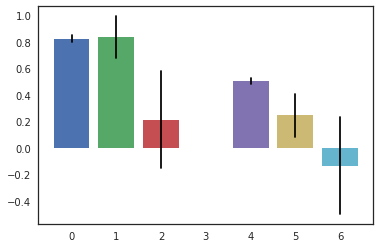

In [2061]:
data = []
for m_set in [insider_hgmd_masks_all, insider_hgmd_masks, viral_hgmd_masks, insider_clinvar_masks_all, insider_clinvar_masks, viral_clinvar_masks]:
    mask1 = np.concatenate(m_set[0])
    mask2 = np.concatenate(m_set[1])
    data.append(my.odds_ratio(mask1, mask2, verbose=True, log_odds=True))
for i in range(len(data)):
    plt.bar(x=i + int(i)/3, height=data[i][0])
    plt.plot([i + int(i)/3, i + int(i)/3], data[i][1:3], color="k")

In [2063]:
a = 3
b = 29
c = 1712
d =20813
exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1
my.odds_ratio(exposure_mask, case_mask, log_odds=True)

(0.33071182984978609,
 2.0470816900191311,
 -1.3856580303195591,
 0.7056922616438337)

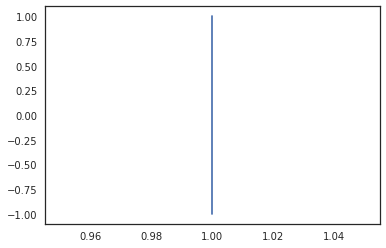

In [1520]:
plt.plot([1, 1], [-1, 1])

In [ ]:
PLD3 (Q8IV08) (LogOR=2.27, p=0.019), FKBP10 (Q96AY3) (LogOR=3.55, p=0.037), NLRX1 (Q86UT6) (LogOR=4.18, p=0.019), SMOC1 (Q9H4F8) (LogOR=6.13, p=1.3e-5), ACAD9 (Q9H845) (LogOR=1.63, p=0.019)

In [1379]:
summary[summary["p_V:H"] <= 0.05].sort_values("OR_V:H")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar    OR_V:H  \
4313   P06280          19.0         128.0   270.0      130.0 -1.970047   
11315  Q8IV08          23.0          31.0    17.0        1.0  2.279047   
15631  Q96AY3          17.0          15.0     4.0       17.0  3.549464   
5223   Q86UT6          27.0         145.0     3.0        8.0  4.185257   
12762  Q9H4F8          12.0          23.0     5.0        4.0  6.129283   

         Up_V:H   Low_V:H     p_V:H    OR_V:C    Up_V:C   Low_V:C     p_V:C  \
4313  -0.544329 -3.395764  0.006764 -1.259064  0.545401 -3.063528  0.171449   
11315  4.190511  0.367582  0.019446       NaN       NaN       NaN       NaN   
15631  6.892307  0.206620  0.037424  1.100662  4.102244 -1.900920  0.472321   
5223   7.693705  0.676808  0.019384       NaN       NaN       NaN       NaN   
12762  8.880707  3.377859  0.000013  3.666412  7.043779  0.289046  0.033362   

         OR_H:H    Up_H:H   Low_H:H     p_H:H    OR_H:C    Up_H:C   Low_H:C  \
4313  -1.116645 -0.506042 -1.727247  0.000338 -0.372608  0.292605 -1.037822   
11315  1.029544  3.226017 -1.166929  0.358260       NaN       NaN       NaN   
15631       NaN       NaN       NaN       NaN  1.298554  4.311995 -1.714888   
5223   3.535357  7.007935  0.062779  0.046000  0.941667  3.264584 -1.381251   
12762  3.695145  6.352822  1.037469  0.006429  4.283640  7.181187  1.386092   

          p_H:C  
4313   0.272274  
11315       NaN  
15631  0.398341  
5223   0.426886  
12762  0.003761

In [1380]:
ires_df[ires_df["P2"] == "Q8IV08"]

P1      P2   Source  P1_Len  P1_N_Ires  \
455  COVID19orf8  Q8IV08  Docking     121         24   

                                               P1_Ires  P2_Len  P2_N_Ires  \
455  9,10,28,41,42,43,44,45,83,84,85,86,94,102,103,...     490         23   

                                               P2_Ires  
455  222,226,228,244,248,251,252,255,256,258,259,26...

In [1469]:
hgmd[hgmd["UNIPROT_ACC"] == "Q86UT6"]

ID CLASS           DB CHROM     POS_HG19   POS_HG38 REF ALT  \
60234   CM124548   DM?  rs759728353    11  119045475.0  119174766   C   T   
60235   CM124347    DP  rs149770693    11  119050849.0  119180140   C   T   
60236  CM1615774   DM?  rs142087333    11  119045378.0  119174669   C   T   

        GENE  ENTREZ_GENE_ID                    DNA CODON_CHANGE  \
60234  NLRX1         79671.0  NM_024618.3:c.1163C-T      ACG-ATG   
60235  NLRX1         79671.0  NM_024618.3:c.2119C-T      CGC-TGC   
60236  NLRX1         79671.0  NM_024618.3:c.1066C-T      CGG-TGG   

                      PROT UNIPROT_ACC  AA_POS AA_CHANGE  \
60234  NP_078894.2:p.T388M      Q86UT6     388        TM   
60235  NP_078894.2:p.R707C      Q86UT6     707        RC   
60236  NP_078894.2:p.R356W      Q86UT6     356        RW   

                                                    PHEN      PMID  
60234                                             Autism  22495306  
60235             Hepatitis B, chronic, association with  22610944  
60236  Haemophilia A, inhibitor development, increase...  27060170

In [1382]:
summary[summary["p_V:C"] <= 0.05].sort_values("OR_V:C")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar    OR_V:H  \
2824   Q9H845          32.0         197.0    31.0       47.0  1.572184   
12762  Q9H4F8          12.0          23.0     5.0        4.0  6.129283   

         Up_V:H   Low_V:H     p_V:H    OR_V:C    Up_V:C   Low_V:C     p_V:C  \
2824   3.183017 -0.038649  0.055756  1.625003  2.985041  0.264965  0.019191   
12762  8.880707  3.377859  0.000013  3.666412  7.043779  0.289046  0.033362   

         OR_H:H    Up_H:H   Low_H:H     p_H:H    OR_H:C    Up_H:C   Low_H:C  \
2824   0.467432  1.539844 -0.604980  0.392945  1.004609  1.870045  0.139174   
12762  3.695145  6.352822  1.037469  0.006429  4.283640  7.181187  1.386092   

          p_H:C  
2824   0.022897  
12762  0.003761

In [1383]:
summary[summary["p_H:H"] <= 0.05].sort_values("OR_H:H")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar  OR_V:H  Up_V:H  \
6089   Q13496           0.0         156.0    64.0       57.0     NaN     NaN   
10072  P00797           0.0         251.0     7.0       10.0     NaN     NaN   
10014  P62854           0.0          91.0     6.0        2.0     NaN     NaN   
6231   P36871           0.0         191.0    17.0       20.0     NaN     NaN   
5088   Q9BSQ5           0.0         149.0    16.0        9.0     NaN     NaN   
1471   P61764           0.0         215.0    40.0       44.0     NaN     NaN   
15252  P51688           0.0         140.0    81.0       44.0     NaN     NaN   
6565   P49675           0.0          91.0    26.0        7.0     NaN     NaN   
16519  P55851           0.0         218.0     7.0        3.0     NaN     NaN   
8707   P05062           0.0         121.0    22.0       15.0     NaN     NaN   
10844  Q15466           0.0         147.0    14.0        3.0     NaN     NaN   
14468  Q13148           0.0         114.0    38.0       16.0     NaN     NaN   
11255  P08123           0.0         169.0   253.0       97.0     NaN     NaN   
10914  Q9UM01           0.0         139.0    25.0       33.0     NaN     NaN   
9397   P28329           0.0         195.0    37.0       31.0     NaN     NaN   
14338  P19971           0.0         148.0    47.0       62.0     NaN     NaN   
11847  Q9Y3Z3           0.0         236.0    21.0       18.0     NaN     NaN   
11182  P00441           0.0         101.0    91.0       28.0     NaN     NaN   
1950   Q01968           0.0         210.0    69.0       42.0     NaN     NaN   
5202   P16615           0.0         379.0   104.0       20.0     NaN     NaN   
14983  P05093           0.0         204.0    53.0       20.0     NaN     NaN   
16696  Q9BY41           0.0         138.0    24.0       13.0     NaN     NaN   
5497   P05107           0.0         391.0    41.0       34.0     NaN     NaN   
89     P29400           0.0          86.0   281.0      225.0     NaN     NaN   
8980   Q03426           0.0         111.0    95.0       61.0     NaN     NaN   
1279   P07686           0.0         161.0    37.0       30.0     NaN     NaN   
5635   P82251           0.0         171.0    56.0       18.0     NaN     NaN   
13752  P16278           0.0         179.0   121.0       55.0     NaN     NaN   
10894  P02452           0.0         151.0   282.0      109.0     NaN     NaN   
12084  P10253           0.0         219.0   204.0      149.0     NaN     NaN   
...       ...           ...           ...     ...        ...     ...     ...   
13072  Q8TCU4           0.0          34.0     6.0       33.0     NaN     NaN   
1038   Q9BXL7           0.0          87.0     3.0       30.0     NaN     NaN   
14671  Q9UL01           0.0          35.0     2.0        9.0     NaN     NaN   
14905  P12035           0.0          65.0     4.0        3.0     NaN     NaN   
2995   P48634           0.0          14.0     7.0        0.0     NaN     NaN   
10566  P48645           0.0           7.0     2.0        0.0     NaN     NaN   
4301   Q719H9           0.0          56.0     8.0        7.0     NaN     NaN   
14816  Q14739           0.0          31.0     7.0       22.0     NaN     NaN   
12862  Q7Z3E5           0.0          20.0     5.0        0.0     NaN     NaN   
15527  P41732           0.0           9.0     2.0        1.0     NaN     NaN   
14748  Q05996           0.0          25.0     2.0        0.0     NaN     NaN   
7181   Q15283           0.0          28.0     2.0        3.0     NaN     NaN   
12372  Q15392           0.0           7.0     8.0       13.0     NaN     NaN   
16523  Q9P0N5           0.0           5.0     2.0       10.0     NaN     NaN   
2511   Q969G3           0.0          24.0     3.0       15.0     NaN     NaN   
6237   P31271           0.0          52.0     6.0        2.0     NaN     NaN   
11291  Q8TEA7           0.0          24.0     2.0        2.0     NaN     NaN   
9568   Q03001           0.0         166.0     2.0       32.0     NaN     NaN   
3262  

In [1384]:
summary[summary["p_H:C"] <= 0.05].sort_values("OR_H:C")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar    OR_V:H  \
1473   P61769           0.0         101.0     2.0        3.0       NaN   
6886   P47897           0.0         311.0     8.0       24.0       NaN   
14983  P05093           0.0         204.0    53.0       20.0       NaN   
3769   P24752           0.0         162.0    40.0       28.0       NaN   
6089   Q13496           0.0         156.0    64.0       57.0       NaN   
4743   P40939           0.0         240.0    24.0       21.0       NaN   
89     P29400           0.0          86.0   281.0      225.0       NaN   
10413  P16930           0.0         119.0    43.0       23.0       NaN   
9627   P61244           0.0          80.0    10.0       17.0       NaN   
1554   Q9UMX1           0.0         162.0     9.0       31.0       NaN   
2531   Q09472           0.0         681.0    15.0       79.0       NaN   
1950   Q01968           0.0         210.0    69.0       42.0       NaN   
11182  P00441           0.0         101.0    91.0       28.0       NaN   
8980   Q03426           0.0         111.0    95.0       61.0       NaN   
13058  P04637           0.0         280.0   152.0      229.0       NaN   
8789   Q08289           0.0         270.0    25.0       59.0       NaN   
15731  P41250           0.0         328.0    28.0       46.0       NaN   
6723   P35557           0.0         126.0   280.0      100.0       NaN   
10249  P15289           0.0         127.0   124.0       97.0       NaN   
14338  P19971           0.0         148.0    47.0       62.0       NaN   
4593   P09493           0.0         179.0    79.0       93.0       NaN   
9686   P13637           0.0         427.0    63.0       60.0       NaN   
14445  P11310          68.0         172.0    99.0       76.0 -0.290834   
1580   P02461           0.0         240.0   251.0      300.0       NaN   
6799   P35555          14.0         414.0   794.0      536.0 -2.320390   
14887  P21359           0.0         217.0   302.0      627.0       NaN   
5086   P11532           0.0         346.0   102.0      371.0       NaN   
7860   P04275           0.0         404.0   419.0      254.0       NaN   
15707  Q8WZ42           0.0        1118.0   203.0     3117.0       NaN   
1329   P35609           0.0         396.0    36.0      136.0       NaN   
...       ...           ...           ...     ...        ...       ...   
10270  Q9NR61           0.0          22.0     8.0        6.0       NaN   
7194   P23508           0.0          17.0     0.0        4.0       NaN   
3896   Q9ULG1           0.0          45.0     6.0        3.0       NaN   
12372  Q15392           0.0           7.0     8.0       13.0       NaN   
8015   Q9H3S5           0.0          12.0     0.0        3.0       NaN   
10716  P05546           0.0          50.0     3.0        3.0       NaN   
7104   O14841           0.0          66.0    20.0        4.0       NaN   
11333  Q8WVX9           0.0          14.0     2.0        3.0       NaN   
12762  Q9H4F8          12.0          23.0     5.0        4.0  6.129283   
10708  P05549           0.0          24.0    22.0        8.0       NaN   
8891   Q9BWT7           0.0          34.0     6.0        5.0       NaN   
5829   Q8NFF5           0.0          27.0     2.0        2.0       NaN   
14880  Q8WXG6           0.0          74.0     4.0        2.0       NaN   
10308  Q9H0W5           0.0          13.0     0.0        3.0       NaN   
13232  P35716           0.0          55.0     5.0        4.0       NaN   
2640   Q99592           0.0          23.0     6.0        4.0       NaN   
4301   Q719H9           0.0          56.0     8.0        7.0       NaN   
2499   P56645           0.0          23.0     5.0        3.0       NaN   
6511   Q9UNQ0           0.0          24.0    19.0        2.0       NaN   
12963  Q9UMN6           0.0          86.0    14.0        2.0       NaN   
10196  Q5K651           0.0          46.0    14.0        2.0       NaN   
10183  Q70Z35           0.0          43.0     3.0        2.0       NaN   
11291  Q8T

In [1459]:
mask1 = np.concatenate(viral_hgmd_masks[0])
mask2 = np.concatenate(viral_hgmd_masks[1])
my.odds_ratio(mask1, mask2, verbose=True, log_odds=True)

               Case  Non-Case
Exposed        63.0    2659.0
Non-Exposed  2164.0  105789.0


(0.21195717525722271,
 0.57759347079826662,
 -0.15367912028382141,
 0.25588148682339606)

In [1460]:
mask1 = np.concatenate(viral_clinvar_masks[0])
mask2 = np.concatenate(viral_clinvar_masks[1])
my.odds_ratio(mask1, mask2, verbose=True, log_odds=True)

               Case  Non-Case
Exposed        64.0    1972.0
Non-Exposed  2611.0   73341.0


(-0.13349826189994285,
 0.23003350238482848,
 -0.49703002618471398,
 0.47167927726029557)

In [1461]:
mask1 = np.concatenate(insider_hgmd_masks[0])
mask2 = np.concatenate(insider_hgmd_masks[1])
my.odds_ratio(mask1, mask2, verbose=True, log_odds=True)

                Case   Non-Case
Exposed      15731.0   563140.0
Non-Exposed  55399.0  3505450.0


(0.82178457178230602, 0.84765092107588891, 0.79591822248872302, 0.0)

In [1462]:
mask1 = np.concatenate(insider_clinvar_masks[0])
mask2 = np.concatenate(insider_clinvar_masks[1])
my.odds_ratio(mask1, mask2, verbose=True, log_odds=True)

                Case   Non-Case
Exposed      16432.0   412043.0
Non-Exposed  71853.0  2557905.0


(0.50555557020453712, 0.53046313258473954, 0.48064800782433487, 0.0)

	HGMD	Non-HGMD		ClinVar	Non-ClinVar
H:V-Interface	63	2659	Interface	64	1972
Non-Interface	2164	105789	Non-Interface	2611	73341

	HGMD	Non-HGMD		ClinVar	Non-ClinVar
H:H-Interface	15731	563140	Interface	16432	412043
Non-Interface	55399	3505450	Non-Interface	71853	2557905


In [ ]:
    63.0    2659.0
Non-Exposed  2164.0  105789.0

In [496]:
disease_dag = pd.read_csv("medgen_dag_from_charles.txt", sep="\t")

In [497]:
medgen_rel = pd.read_csv("MGREL.RRF", sep="|")

In [498]:
all_terms = set(medgen_rel["#CUI1"].to_list() + medgen_rel["CUI2"].to_list())
print len(all_terms)
child_parent_terms = set(medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])]["#CUI1"].to_list() + medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])]["CUI2"].to_list())
print len(child_parent_terms)

194879
71376


In [499]:
clinvar_terms = set(my.flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))
print len(clinvar_terms)

6275


In [500]:
print len(clinvar_terms.intersection(child_parent_terms))

2628


In [501]:
print len(clinvar_terms.intersection(all_terms))

4777


In [505]:
import networkx as nx

In [506]:
dag = nx.DiGraph()
for c1, c2 in tqdm_notebook(medgen_rel[["#CUI1", "CUI2"]].values):
    dag.add_node(c1, **{"a":0, "b":322, "c":0, "d":20350-332, "block":False})
    dag.add_node(c2, **{"a":0, "b":322, "c":0, "d":20350-332, "block":False})
for c1, c2, rel in tqdm_notebook(medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])][["#CUI1", "CUI2", "REL"]].values):
    if(rel == "PAR"):
        dag.add_edge(c2, c1)
    else:
        dag.add_edge(c1, c2)

# Add all extra terms from ClinVar Table
for c in set(my.flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list())):
    dag.add_node(c, **{"a":0, "b":322, "c":0, "d":20350-332, "block":False})

In [1752]:
#node_list = sorted(dag.nodes)
#a = np.zeros(len(node_list))
#b = np.zeros(len(node_list))
#b[:] = 332
#c = np.zeros(len(node_list))
#d = np.zeros(len(node_list))
#d[:] = 20350 - 332
#block = np.zeros(len(node_list))
#
#node2parent_mask = defaultdict(lambda: np.zeros(len(node_list)))
#for i, n in enumerate(tqdm_notebook(node_list)):
#    mask = np.zeros(len(node_list))
#    parents = get_parents(dag, n)
#    for p in parents:
#        mask[node_list.index(p)] = 1

In [1753]:
#get_parents(dag, "C0012634", set())

In [507]:
#def get_parents(g, n, seen=set()):
#    if(n in seen):
#        return seen
#    else:
#        seen.add(n)
#        for p in g.predecessors(n):
#            seen.update(get_parents(g, p, seen))
#    return seen
## FUNCTION END

def propogate_updates(g, n, is_interactor):
    if(not n in g.nodes):
        g.add_node(n, **{"a":0, "b":322, "c":0, "d":20350-332, "block":False})
    #print n
    if(g.node[n]["block"]):
        #print "Already Reached", n
        return
    else:
        if(is_interactor):
            g.node[n]["a"] += 1
            g.node[n]["b"] -= 1
        else:
            g.node[n]["c"] += 1
            g.node[n]["d"] -= 1
        g.node[n]["block"] = True
        for p in g.predecessors(n):
            propogate_updates(g, p, is_interactor)
# FUNCTION END

def unblock_all(g):
    for n in g.nodes:
        g.node[n]["block"] = False
# FUNCTION END

def reset_all(g):
    for n in g.nodes:
        for k, v in {"a":0, "b":332, "c":0, "d":20350-332, "block":False}.iteritems():
            g.node[n][k] = v
# FUNCTION END

In [508]:
reset_all(dag)

In [509]:
[n for n in dag.nodes if dag.node[n]["block"] ==  True]

[]

In [510]:
len([x for x in uni2seq if not "COVID" in x])

332

In [511]:
for uni, g in tqdm_notebook(clinvar[["UNIPROT_ACC", "PHEN_IDS", "PHEN"]].groupby("UNIPROT_ACC")):
    med_gen_terms = set(my.flatten(g["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))
    is_interactor = uni in uni2seq.keys()
    for n in med_gen_terms:
        propogate_updates(dag, n, is_interactor)
    
    unblock_all(dag)

In [512]:
summary = []
for n in tqdm_notebook(dag.nodes):
    summary.append([n, dag.nodes[n]["a"], dag.nodes[n]["b"], dag.nodes[n]["c"], dag.nodes[n]["d"], ",".join(dag.successors(n)), ",".join(dag.predecessors(n))])
summary = pd.DataFrame(summary, columns=["ID", "A", "B", "C", "D", "Children", "Parents"])
summary.to_csv("MedGen_Term_Enrichments.txt", sep="\t", index=None)

In [531]:
summary = summary[(summary["A"] != 0)|(summary["C"] != 0)]
def do(a, b, c, d):
    if([0] in [a, b, c, d]):
        return np.nan, np.nan, np.nan, np.nan
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[a+b:a+b+c] = 1

    OR, up, low, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True, two_sided=False)
    pbar.update()
    return OR, low, up, p
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = summary[["A", "B", "C", "D"]].apply(lambda x: do(*x), axis=1)
summary["LogOR"] = [x[0] for x in tmp]
summary["Low"] = [x[1] for x in tmp]
summary["Up"] = [x[2] for x in tmp]
summary["p-value"] = [x[3] for x in tmp]

In [514]:
summary[summary["p-value"] <= 0.05]

ID   A    B     C      D  \
113     C4022597   1  331     3  20015   
179     C0037090   1  331     6  20012   
243     C4021661   1  331     6  20012   
1456    C4024586   3  329    52  19966   
1467    C4025676   1  331     1  20017   
2469    C0340375   4  328    71  19947   
3947    CN169374  75  257  2760  17258   
4909    C3150099   1  331     1  20017   
5511    C0027960   1  331     5  20013   
6581    C0011848   1  331     3  20015   
6944    C0282577   4  328    32  19986   
8697    CN005712   1  331     2  20016   
8813    C4023165   5  327   117  19901   
8814    C4023164   2  330    25  19993   
9589    C0028738   1  331     5  20013   
9867    C0042790   3  329    30  19988   
10143   C4551584   2  330     4  20014   
10937   C0024796   2  330     6  20012   
11817   C1261175   3  329     8  20010   
13100   C0752109   6  326    92  19926   
13286   C4025846   4  328    32  19986   
14214   C0019618   1  331     6  20012   
14440   C3714517   4  328    82  19936   
14709   CN000609   1  331     2  20016   
15087   C4025596   2  330    27  19991   
16147   CN239852   1  331     1  20017   
16472   C0026697   1  331     3  20015   
16757   C0231246   2  330     6  20012   
18150   C0007001   7  325   103  19915   
18784   C0264879   1  331     1  20017   
...          ...  ..  ...   ...    ...   
172803  C0333068   2  330    12  20006   
174873  C0003706   1  331     1  20017   
176066  CN029864   2  330    13  20005   
177091  C4551464   1  331     2  20016   
179061  C0029131   1  331     5  20013   
179062  C0029132   1  331     3  20015   
179831  C0003886   2  330     2  20016   
181164  C0268350   1  331     2  20016   
181820  C4021817   4  328    81  19937   
181822  C4021815   1  331     4  20014   
181825  C4021812   4  328    80  19938   
182067  C0079504   1  331     7  20011   
182433  C1335025   1  331     7  20011   
183069  C1333520   4  328    34  19984   
183922  C0752135   6  326   130  19888   
184720  C0544755   1  331     1  20017   
185076  C1849510   1  331     2  20016   
185393  C0007302   1  331     1  20017   
185604  C0034951   1  331     2  20016   
186533  CN000552   1  331     3  20015   
187338  C4476872   7  325   132  19886   
187496  C0002940   2  330    14  20004   
187709  CN033664   1  331     1  20017   
188350  C0268634   2  330     7  20011   
188476  C0002986   1  331     1  20017   
188483  C0002985   1  331     1  20017   
192805  CN239451   1  331     7  20011   
193034  CN221809  60  272  2175  17843   
195299  C0243050  11  321   311  19707   
195301  C0243057   2  330    27  19991   

                                                 Children  \
113          C0151611,C0522216,C4021577,C4022687,C3552825   
179     C0008039,C0085383,C0019079,C0242706,C0231835,C...   
243     C0521173,C4022509,C0019618,C0876991,C0036489,C...   
1456    C0235942,C4024573,C4021797,C1846435,C4024585,C...   
1467    C1839512,C0544755,C0159970,C0409959,C1859462,C...   
2469                  C1848978,C3887554,C0012628,C0007194   
3947                                                        
4909                                    C1860042,C2936791   
5511    C0206737,C4552097,C0346099,C0027961,C0235752,C...   
6581         C0043207,C0687720,C0268813,C4329279,C0162283   
6944    C3553230,C3150736,C2931009,C2931011,C2931010,C...   
8697                                                        
8813    C2732838,C4025630,C0016658,C1851612,C0086795,C...   
8814    C1390474,C4023216,C0027543,C0332743,C0151825,C...   
9589    C0700501,C4025788,C0155379,C0240595,C4073130,C...   
9867    C0028077,C0854348,C2717757,C0456909,C0085636,C...   
10143                          C4024898,C0241816,C4024895   
10937                                            C2698016   
11817   C4014354,C3554209,C1843504,C4540164,C1842687,C...   
13100   C0034341,C0034345,C0043459,C0268393,C0751748,C...   
13286   C1842073,C0271185,C4476619,C0028077,C0085635,C...   
14214        C0019613,C0019625,C0019624,C0334126,C0019621   
14440 

In [515]:
medgen_names = pd.read_csv("MGCONSO.RRF", sep="|")

In [516]:
term2name = defaultdict(str)
term2name.update(medgen_names[(medgen_names["TS"] == "P")&(medgen_names["STT"] == "PF")].drop_duplicates("#CUI")[["#CUI", "STR"]].set_index("#CUI")["STR"].to_dict())

In [517]:
summary["Name"] = summary["ID"].map(lambda x: term2name[x])

In [518]:
for id, a, b, c, d, OR, low, up, p, name in summary[["ID", "A", "B", "C", "D", "LogOR", "Low", "Up", "p-value", "Name"]].values:
    dag.node[id]["OR"] = OR
    dag.node[id]["low"] = low
    dag.node[id]["up"] = up
    dag.node[id]["p"] = p
    dag.node[id]["name"] = name

8532/|/100%|| 8532/8532 [02:10<00:00, 76.17it/s]

In [519]:
def add_node_plus_acnestors(g, n, nodes=set(), edges=set()):
    if(n in nodes):
        return
    
    g.add_node(n, **dag.node[n])
    nodes.add(n)
    
    if(len(list(dag.predecessors(n))) == 0):
        g.add_edge("root", n)
        edges.add(("root", n))
    
    for p in dag.predecessors(n):
        if(not (p, n) in edges):
            g.add_edge(p, n)
            edges.add((p, n))
        
        add_node_plus_acnestors(g, p, nodes, edges)
    
    return
# FUNCTION END

In [520]:
sub_dag = nx.DiGraph()
sub_dag.add_node("root", **{"name":"root"})
nodes = set("root")
edges = set()
for n in tqdm_notebook(summary[summary["p-value"] <= 0.05].sort_values("A", ascending=False)["ID"]):
    add_node_plus_acnestors(sub_dag, n, nodes, edges)
    #if(len(list(dag.successors(n))) <= 10):
    #    for c in dag.successors(n):
    #        sub_dag.add_node(c, **dag.node[c])
    #        sub_dag.add_edge(n, c)

In [521]:
len(sub_dag.nodes)

559

In [522]:
len(edges)

954

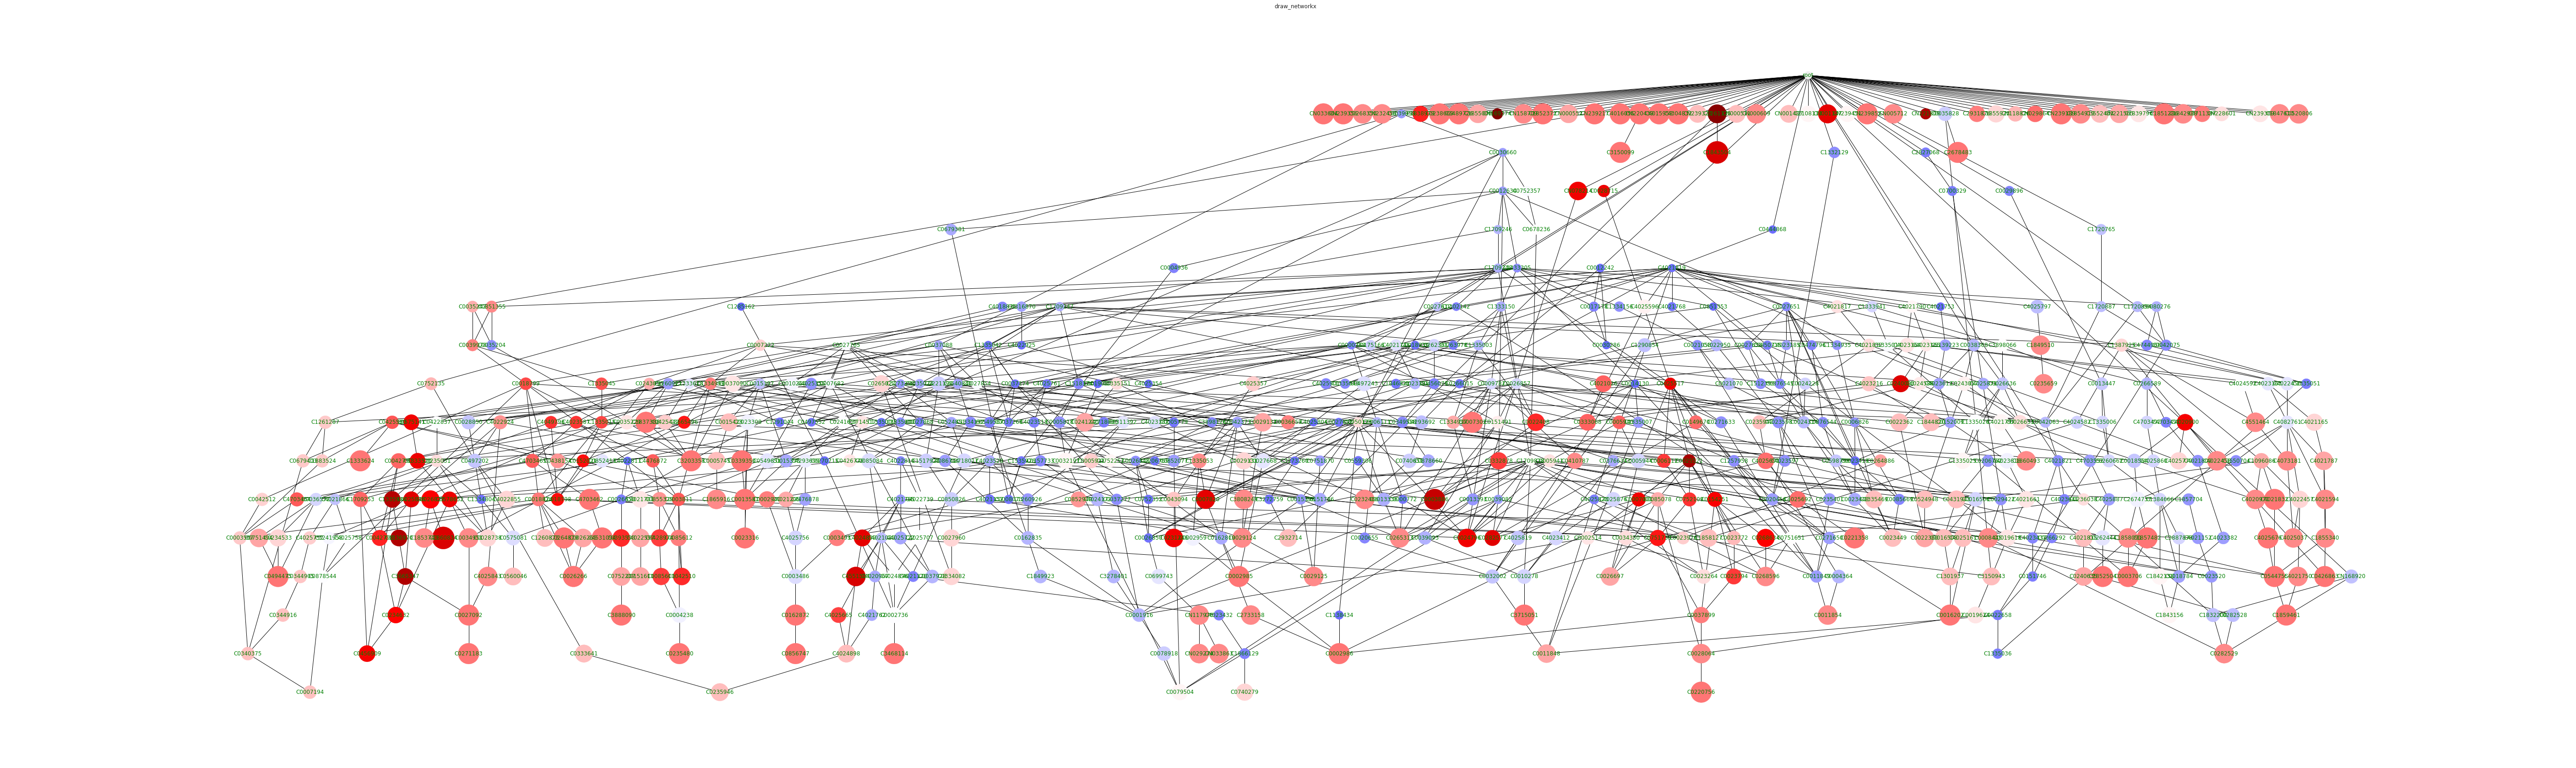

In [2009]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
write_dot(sub_dag,'test.dot')

# same layout using matplotlib with no labels
#plt.figure(figsize=(200*3, 60*3))
plt.figure(figsize=(100, 30))
plt.title('draw_networkx')
pos =graphviz_layout(sub_dag, prog='dot')

vmax = 10
cmap = lambda x: matplotlib.cm.seismic(1 - (float((np.log(x) - np.log(0.05) + vmax)) / (vmax*2.0)))
colors = []
sizes = []
labels = dict()
for n in sub_dag.nodes:
    if("p" in sub_dag.node[n]):
        colors.append(cmap(sub_dag.node[n]["p"]))
        sizes.append(300 + 300*abs(sub_dag.node[n]["OR"]))
        labels[n] = "{0} ({1})\nOR: {2:0.2f} ({3:0.2f}={4:0.2f})\np: {5}\n{6}\t{7}\n{8}\t{9}".format(n, sub_dag.node[n]["name"], sub_dag.node[n]["OR"], sub_dag.node[n]["low"], sub_dag.node[n]["up"], sub_dag.node[n]["p"], sub_dag.node[n]["a"], sub_dag.node[n]["b"], sub_dag.node[n]["c"], sub_dag.node[n]["d"])
    else:
        colors.append("#EEEEEE")
        sizes.append(300)
        labels[n] = n

nx.draw(sub_dag, pos, labels=None, arrows=False, node_color=colors, node_size=sizes, font_color="g")
#plt.savefig('nx_test.svg')
#plt.savefig('nx_test.png')

In [ ]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
write_dot(sub_dag,'test.dot')

# same layout using matplotlib with no labels
#plt.figure(figsize=(200*3, 60*3))
plt.figure(figsize=(100, 30))
plt.title('draw_networkx')
pos =graphviz_layout(sub_dag, prog='dot')

vmax = 10
cmap = lambda x: matplotlib.cm.seismic(1 - (float((np.log(x) - np.log(0.05) + vmax)) / (vmax*2.0)))
colors = []
sizes = []
labels = dict()
for n in sub_dag.nodes:
    if("p" in sub_dag.node[n]):
        colors.append(cmap(sub_dag.node[n]["p"]))
        sizes.append(300 + 300*abs(sub_dag.node[n]["OR"]))
        labels[n] = "{0} ({1})\nOR: {2:0.2f} ({3:0.2f}={4:0.2f})\np: {5}\n{6}\t{7}\n{8}\t{9}".format(n, sub_dag.node[n]["name"], sub_dag.node[n]["OR"], sub_dag.node[n]["low"], sub_dag.node[n]["up"], sub_dag.node[n]["p"], sub_dag.node[n]["a"], sub_dag.node[n]["b"], sub_dag.node[n]["c"], sub_dag.node[n]["d"])
    else:
        colors.append("#EEEEEE")
        sizes.append(300)
        labels[n] = n

nx.draw(sub_dag, pos, labels=None, arrows=False, node_color=colors, node_size=sizes, font_color="g")
#plt.savefig('nx_test.svg')
#plt.savefig('nx_test.png')

In [523]:
summary["Significant Parents"] = summary["Parents"].map(lambda x: ",".join([y for y in x.split(",") if y in dag.nodes and "p" in dag.node[y] and dag.node[y]["p"] <= 0.05]))
summary["Significant Children"] = summary["Children"].map(lambda x: ",".join([y for y in x.split(",") if y in dag.nodes and "p" in dag.node[y] and dag.node[y]["p"] <= 0.05]))

In [524]:
def do(n, sig=set(), seen=set(), first=True):
    if(n in seen):
        return sig, seen
    seen.add(n)
    if(not first and "p" in dag.node[n] and dag.node[n]["p"] <= 0.05):
        sig.add(n)
    
    for p in dag.predecessors(n):
        tmp_sig, tmp_seen = do(p, sig=sig, seen=seen, first=False)
        sig.update(tmp_sig)
        seen.update(seen)
    
    if(first):
        pbar.update()
        return ",".join(sig)
    return sig, seen
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = [do(x, sig=set(), seen=set(), first=True) for x in summary["ID"].to_list()]
summary["Significant Ancestors"] = tmp

def do(n, sig=set(), seen=set(), first=True):
    if(n in seen):
        return sig, seen
    seen.add(n)
    if(not first and "p" in dag.node[n] and dag.node[n]["p"] <= 0.05):
        sig.add(n)
    
    for p in dag.successors(n):
        tmp_sig, tmp_seen = do(p, sig=sig, seen=seen, first=False)
        sig.update(tmp_sig)
        seen.update(seen)
    
    if(first):
        pbar.update()
        return ",".join(sig)
    return sig, seen
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = [do(x, sig=set(), seen=set(), first=True) for x in summary["ID"].to_list()]
summary["Significant Descendants"] = tmp


8532/|/100%|| 8532/8532 [00:14<00:00, 1693.73it/s]

In [525]:
summary

ID  A    B    C      D  \
23      C1837406  0  332    2  20016   
25      C1837404  1  331    0  20018   
99      C4024743  0  332    1  20017   
100     C4024744  0  332    1  20017   
101     C4024745  0  332    9  20009   
102     C4024746  0  332    6  20012   
104     C4024748  0  332    6  20012   
105     C0265677  0  332    1  20017   
110     C3554540  0  332    1  20017   
113     C4022597  1  331    3  20015   
144     C0030312  0  332   42  19976   
179     C0037090  1  331    6  20012   
205     C2751842  0  332    1  20017   
206     C2751843  0  332    1  20017   
243     C4021661  1  331    6  20012   
244     C4021662  0  332    1  20017   
245     C4021663  0  332    1  20017   
302     CN239149  0  332    1  20017   
304     C0393770  0  332    1  20017   
307     C1862839  0  332    9  20009   
404     C1854990  0  332    1  20017   
410     C0152264  0  332    4  20014   
475     C4015420  0  332    1  20017   
524     C0151564  0  332    1  20017   
547     C4531101  0  332    5  20013   
571     C4552100  0  332    7  20011   
615     C1333419  0  332   23  19995   
616     C0038002  0  332    1  20017   
674     C0001163  0  332    1  20017   
686     C1836255  0  332    1  20017   
...          ... ..  ...  ...    ...   
195586  C1832926  0  332    2  20016   
195659  C1847501  0  332    1  20017   
195664  C0342482  0  332    1  20017   
195702  C3553587  0  332    1  20017   
195716  C3501611  0  332   10  20008   
195723  C0796068  0  332    1  20017   
195740  C1835905  0  332    1  20017   
195792  C0424731  0  332    2  20016   
195809  C1842028  0  332    1  20017   
195816  C0747078  0  332    1  20017   
195859  C4022810  8  324  400  19618   
195860  C4022811  4  328  261  19757   
195866  CN003017  0  332    1  20017   
195889  C0156543  0  332    1  20017   
195917  C3539494  0  332    1  20017   
195918  C3539495  0  332    1  20017   
195972  C1865614  0  332    1  20017   
196020  C4520679  1  331   16  20002   
196022  C4015395  0  332    1  20017   
196064  C1519719  0  332    4  20014   
196108  C0431109  0  332    1  20017   
196123  C1848097  0  332    1  20017   
196135  C2919341  0  332    1  20017   
196177  C1858656  0  332    2  20016   
196206  CN168921  0  332    1  20017   
196207  CN168920  1  331   15  20003   
196227  C1865616  0  332    1  20017   
196228  C0750394  0  332    2  20016   
196337  C0036341  0  332   16  20002   
196359  C0001080  0  332    1  20017   

                                                 Children  \
23                                               C1855299   
25                                                          
99                             C4021084,C1298695,C0338502   
100                                     C4024740,C4024743   
101          C4024744,C0026010,C4024739,C4024746,C0003119   
102                                     C4024748,C1836890   
104                                     C0003076,C0344539   
105                            C0432152,C0432149,C0432155   
110                                                         
113          C0151611,C0522216,C4021577,C4022687,C3552825   
144                            C1368107,C2986691,C0002874   
179     C0008039,C0085383,C0019079,C0242706,C0231835,C...   
205                                                         
206                                                         
243     C0521173,C4022509,C0019618,C0876991,C0036489,C...   
244                            C0014118,C0553980,C0014117   
245     C1853934,C1850848,C0544966,C1854387,C1853932,C...   
302                                                         
304                                                         
307     C3887531,C4476808,C0009691,C2981140,C0344559,C...   
404                                                         
410                   C1853286,C2673187,C4551637,C1837915   
475                                                         
524                                                         
547     

In [532]:
summary[(summary["p-value"] <= 0.05)&(summary["Significant Ancestors"] == "")&(summary["A"] > 1)].sort_values("LogOR", ascending=False)[["Name", "ID", "A", "B", "C", "D", "LogOR", "p-value"]]

Name        ID   A    B  \
36366                                                      CN001147   2  330   
11817                       Pontoneocerebellar hypoplasia  C1261175   3  329   
95738                                 Familial aortopathy  CN078214   2  330   
58208                                  Dystonia Disorders  C0393593   2  330   
88057   Atrophy/Degeneration affecting the central ner...  C4024899   3  329   
176066                                                     CN029864   2  330   
122498                             Hirschsprung disease 1  C2931876   2  330   
28121            Primary autosomal recessive microcephaly  C3711387   2  330   
30361               Hereditary connective tissue disorder  C0410787   2  330   
110586  Mitochondrial complex I deficiency, nuclear ty...  C1838979   3  329   
19494   Aplasia/Hypoplasia involving the central nervo...  C4025665   3  329   
33769                     Finding of head and neck region  C0575141   4  328   
56670                                                      CN118826   2  330   
171131                         Abnormality of body weight  C4025357   2  330   
120896                                Body Weight Changes  C0005911   2  330   
19022                          Respiratory System Finding  C0425442   2  330   
43484       Combined oxidative phosphorylation deficiency  CN228601   2  330   
195301                Stomatognathic System Abnormalities  C0243057   2  330   
15087                    Abnormality of connective tissue  C4025596   2  330   
121136                                Sensation Disorders  C0036659   4  328   
126083                            Abnormal eye physiology  C4022924   4  328   
2742                             Cranial nerve neuropathy  C0010266   2  330   
29657                                        Bone disease  C0005940   6  326   
116327                               Abnormal muscle tone  C0852413   2  330   
71934                              Cardiovascular finding  C0425560   7  325   
26180                        Neuromuscular Manifestations  C0752252   3  329   
48466                        Non-Neoplastic Bone Disorder  C1334997   5  327   
160295                               Abnormality of limbs  C1387925   4  328   
163960              Non-Neoplastic Head and Neck Disorder  C1335014   3  329   
181820                        Abnormality of head or neck  C4021817   4  328   
14440                  Connective and Soft Tissue Finding  C3714517   4  328   
18957                                Congenital anomalies  C0151491   4  328   
183922                Pathological Conditions, Anatomical  C0752135   6  326   
187296                                                     C4020875   3  329   
156083                                Neurologic Symptoms  C0235031   5  327   
24282                                                      C0311392   3  329   
14392                            Otolaryngologic Disorder  C3898066   4  328   
164205                 Abnormality of the skeletal system  C4021790   5  327   
40087                                       Other Finding  C1335151   6  326   
132346               Hereditary hearing loss and deafness  C0236038   6  326   
46118                    Nutritional or metabolic disease  C0028715  18  314   
117479                          Neurological observations  C0422837   5  327   
67611                                                      C0851355  12  320   
52154                          Respiratory Tract Diseases  C0035242  12  320   
153985                          Neurologic Manifestations  C0027854   7  325   
84615                   Disorder of cardiovascular system  C0007222  11  321   
3947                                        not specified  CN169374  75  257   
193034                                                     CN221809  60  272   
140409                                                     C0007682  13  319   
61883                             Inborn genetic dise

In [527]:
summary[summary["Name"].map(lambda x: "mito" in x.lower())].sort_values("p-value")

ID  A    B   C      D  \
110586  C1838979  3  329  23  19995   
29721   C1852372  1  331   1  20017   
135445  C0751651  3  329  58  19960   
3521    C4015513  0  332   1  20017   
10160   C4225163  0  332   1  20017   
21587   C1838951  0  332   6  20012   
22804   C1838103  0  332   2  20016   
23552   C4225348  0  332   1  20017   
24629   C0162666  0  332   3  20015   
32820   C3149750  0  332   1  20017   
35533   C0342790  0  332   1  20017   
35890   C1833508  0  332   1  20017   
36001   C4016851  1  331   0  20018   
39013   C0162670  0  332   4  20014   
43157   C2751320  1  331   0  20018   
50372   C2751532  0  332   1  20017   
52370   C0268237  0  332  12  20006   
53918   C1833518  0  332   1  20017   
53919   C1833511  0  332   1  20017   
56747   C1835845  0  332   1  20017   
61481   C3151513  0  332   2  20016   
70582   C1849096  0  332   1  20017   
70751   C3150172  0  332   1  20017   
76699   C1836439  0  332   1  20017   
77239   C4021734  0  332   1  20017   
85629   C0342789  0  332   1  20017   
97580   C1855008  0  332   3  20015   
101827  C3808899  0  332   1  20017   
103734  C3280660  0  332   2  20016   
110233  C2749864  0  332   1  20017   
...          ... ..  ...  ..    ...   
112623  C3151476  0  332   1  20017   
114687  C4225391  0  332   1  20017   
116535  C3553607  0  332   1  20017   
131697  CN239153  0  332   2  20016   
132211  C3279708  0  332   1  20017   
132733  C2700431  0  332   1  20017   
133661  C3809443  0  332   1  20017   
136976  C3809165  0  332   1  20017   
138295  C1864668  0  332   1  20017   
138666  C3554607  0  332   1  20017   
138675  C3554608  0  332   1  20017   
140874  C1868097  0  332   2  20016   
142480  C1838867  0  332   1  20017   
143107  CN043632  0  332  11  20007   
143730  C4707428  0  332   4  20014   
144178  C3532243  0  332   1  20017   
144745  C3554462  0  332   1  20017   
152376  C3809553  0  332   1  20017   
156815  C4025566  0  332   5  20013   
158721  CN239267  0  332   4  20014   
164948  C4225312  0  332   1  20017   
165834  CN069134  0  332   4  20014   
167271  C1850598  1  331   0  20018   
169314  C4014440  0  332   1  20017   
174294  C3809592  0  332   1  20017   
175683  C4023042  0  332   1  20017   
176854  C4015253  0  332   1  20017   
178987  CN187502  0  332   1  20017   
189572  C3150914  0  332   1  20017   
193198  C1834846  0  332   1  20017   

                                                 Children  \
110586                                                      
29721                                                       
135445  C0917796,C0162670,C1855034,C0034341,C1839022,C...   
3521                                                        
10160                                                       
21587                                                       
22804                                   C3150802,C4551958   
23552                                                       
24629                                   C0162671,C0162672   
32820                                                       
35533                                                       
35890                                                       
36001                                                       
39013                          C1838876,C0162674,C0162666   
43157                                                       
50372                                                       
52370                                                       
53918                                                       
53919                                                       
56747                                                       
61481                                                       
70582                                                       
70751                                                       
76699                                                       
77239   C1844390,C3151556,C4025634,C4022659,C4025586,C...   
85629    

In [528]:
term2name["C1838979"]

'Mitochondrial complex I deficiency, nuclear type 1'

             Case  Non-Case
Exposed       3.0     329.0
Non-Exposed  23.0   19995.0
             Case  Non-Case
Exposed       3.0     329.0
Non-Exposed  30.0   19988.0
              Case  Non-Case
Exposed        6.0     326.0
Non-Exposed  104.0   19914.0
             Case  Non-Case
Exposed       3.0     329.0
Non-Exposed  56.0   19962.0
             Case  Non-Case
Exposed       4.0     328.0
Non-Exposed  85.0   19933.0
              Case  Non-Case
Exposed       11.0     321.0
Non-Exposed  258.0   19760.0
              Case  Non-Case
Exposed       18.0     314.0
Non-Exposed  458.0   19560.0
              Case  Non-Case
Exposed       12.0     320.0
Non-Exposed  352.0   19666.0


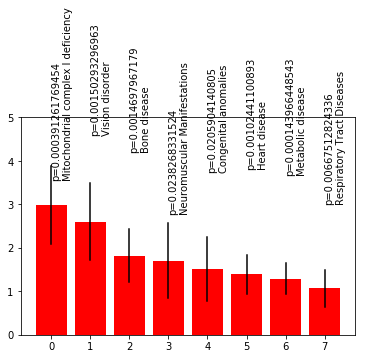

ID   A    B    C      D  \
110586  C1838979   3  329   23  19995   
9867    C0042790   3  329   30  19988   
29657   C0005940   6  326  104  19914   
26180   C0752252   3  329   56  19962   
18957   C0151491   4  328   85  19933   
99426   C0018799  11  321  258  19760   
117422  C0025517  18  314  458  19560   
52154   C0035242  12  320  352  19666   

                                                 Children  \
110586                                                      
9867    C0028077,C0854348,C2717757,C0456909,C0085636,C...   
29657   C0576093,C0029412,C0029411,C0005967,C0014461,C...   
26180   C0039621,C0027125,C0026827,C0026826,C0026821,C...   
18957   C0039093,C0340231,C0264303,C1861922,C0206762,C...   
99426   C1335015,C0032805,C0878544,C0035439,C0007177,C...   
117422  C3714509,C0018099,C0032708,C0235950,C0023787,C...   
52154   C0039978,C0018200,C0035244,C0035243,C0035238,C...   

                           Parents     LogOR       Low        Up   p-value  \
110586                              2.986808  1.524170  4.449447  0.000391   
9867    C0015397,C1333305,C0036659  2.602975  1.159997  4.045952  0.001503   
29657                     C0026857  1.817290  0.812182  2.822398  0.001470   
26180                     C0027854  1.700632  0.288176  3.113089  0.023827   
18957   C0026857,C3273258,C0000768  1.515928  0.294655  2.737202  0.020590   
99426            C0039978,C0007222  1.392070  0.649383  2.134758  0.001024   
117422           C0028715,C1709248  1.291719  0.705747  1.877691  0.000144   
52154                               1.067019  0.357687  1.776350  0.006675   

                                                     Name Significant Parents  \
110586  Mitochondrial complex I deficiency, nuclear ty...                       
9867                                      Vision disorder            C0036659   
29657                                        Bone disease                       
26180                        Neuromuscular Manifestations                       
18957                                Congenital anomalies                       
99426                                       Heart disease   C0039978,C0007222   
117422                                  Metabolic disease            C0028715   
52154                          Respiratory Tract Diseases                       

                                     Significant Children  \
110586                                                      
9867                           C0456909,C1709253,C0042798   
29657                                   C0005941,C0544755   
26180                                            C0026827   
18957                                            C0003886   
99426   C1335015,C0018824,C0018798,C0042512,C0003811,C...   
117422                C0006112,C0025521,C0149670,C0154251   
52154                                            C0039978   

                      Significant Ancestors  \
110586                                        
9867                               C0036659   
29657                                         
26180                                         
18957                                         
99426   C0039978,C0007222,C0035242,C0851355   
117422                             C0028715   
52154                                         

                                  Significant Descendants  
110586                                                     
9867                  C0456909,C0042798,C1709253,C0234632  
29657   C0282529,C1859461,C0544755,C0008445,C0265313,C...  
26180                 C0026827,C1853743,C1858127,C1860834  
18957   C1301937,C0022360,C0016508,C0003706,C0524948,C...  
99426   C1335015,C0235480,C0003811,C1260873,C0085612,C...  
117422  C0011854,C0028064,C0006112,C0002514,C0026697,C...  
52154   C1335015,C0235480,C0003811,C1260873,C0085612,C...

In [536]:
keep = ["Metabolic disease",
"Respiratory Tract Diseases",
"Heart disease",
"Bone disease",
"Vision disorder",
"Mitochondrial complex I deficiency, nuclear type 1",
"Congenital anomalies",
"Neuromuscular Manifestations"]

i = 0
for name, a, b, c, d in summary[summary["Name"].isin(keep)].sort_values("LogOR", ascending=False)[["Name", "A", "B", "C", "D"]].values:
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[a+b:a+b+c] = 1
    
    OR, low, up, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False, error="SE")
    
    plt.bar(i, height=OR, color="r")
    plt.plot([i, i], [low, up], color="k")
    plt.text(i, up + 5, "p={0}\n{1}".format(p, name.split(",")[0]), rotation=90)
    i += 1
plt.ylim(0, 5)
plt.savefig("Figures/Figure_3/Disease_Term_Enrichment.svg")
plt.show()
summary[summary["Name"].isin(keep)].sort_values("LogOR", ascending=False)


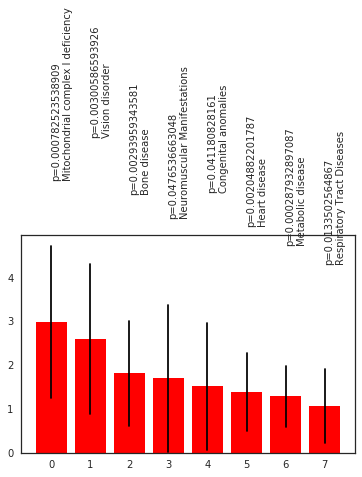

ID   A    B    C      D  \
110586  C1838979   3  329   23  19995   
9867    C0042790   3  329   30  19988   
29657   C0005940   6  326  104  19914   
26180   C0752252   3  329   56  19962   
18957   C0151491   4  328   85  19933   
99426   C0018799  11  321  258  19760   
117422  C0025517  18  314  458  19560   
52154   C0035242  12  320  352  19666   

                                                 Children  \
110586                                                      
9867    C0028077,C0854348,C2717757,C0456909,C0085636,C...   
29657   C0576093,C0029412,C0029411,C0005967,C0014461,C...   
26180   C0039621,C0027125,C0026827,C0026826,C0026821,C...   
18957   C0039093,C0340231,C0264303,C1861922,C0206762,C...   
99426   C1335015,C0032805,C0878544,C0035439,C0007177,C...   
117422  C3714509,C0018099,C0032708,C0235950,C0023787,C...   
52154   C0039978,C0018200,C0035244,C0035243,C0035238,C...   

                           Parents     LogOR       Low        Up   p-value  \
110586                              2.986808  1.243967  4.729650  0.000783   
9867    C0015397,C1333305,C0036659  2.602975  0.883561  4.322388  0.003006   
29657                     C0026857  1.817290  0.619630  3.014950  0.002940   
26180                     C0027854  1.700632  0.017586  3.383679  0.047654   
18957   C0026857,C3273258,C0000768  1.515928  0.060691  2.971166  0.041181   
99426            C0039978,C0007222  1.392070  0.507104  2.277037  0.002049   
117422           C0028715,C1709248  1.291719  0.593490  1.989948  0.000288   
52154                               1.067019  0.221798  1.912239  0.013350   

                                                     Name Significant Parents  \
110586  Mitochondrial complex I deficiency, nuclear ty...                       
9867                                      Vision disorder            C0036659   
29657                                        Bone disease                       
26180                        Neuromuscular Manifestations                       
18957                                Congenital anomalies                       
99426                                       Heart disease   C0039978,C0007222   
117422                                  Metabolic disease            C0028715   
52154                          Respiratory Tract Diseases                       

                                     Significant Children  \
110586                                                      
9867                           C0456909,C1709253,C0042798   
29657                                   C0005941,C0544755   
26180                                            C0026827   
18957                                            C0003886   
99426   C1335015,C0018824,C0018798,C0042512,C0003811,C...   
117422                C0006112,C0025521,C0149670,C0154251   
52154                                            C0039978   

                      Significant Ancestors  \
110586                                        
9867                               C0036659   
29657                                         
26180                                         
18957                                         
99426   C0039978,C0007222,C0035242,C0851355   
117422                             C0028715   
52154                                         

                                  Significant Descendants  
110586                                                     
9867                  C0456909,C0042798,C1709253,C0234632  
29657   C0282529,C1859461,C0544755,C0008445,C0265313,C...  
26180                 C0026827,C1853743,C1858127,C1860834  
18957   C1301937,C0022360,C0016508,C0003706,C0524948,C...  
99426   C1335015,C0235480,C0003811,C1260873,C0085612,C...  
117422  C0011854,C0028064,C0006112,C0002514,C0026697,C...  
52154   C1335015,C0235480,C0003811,C1260873,C0085612,C...

In [2059]:
keep = ["Metabolic disease",
"Respiratory Tract Diseases",
"Heart disease",
"Bone disease",
"Vision disorder",
"Mitochondrial complex I deficiency, nuclear type 1",
"Congenital anomalies",
"Neuromuscular Manifestations"]

i = 0
for name, OR, low, up, p in summary[summary["Name"].isin(keep)].sort_values("LogOR", ascending=False)[["Name", "LogOR", "Low", "Up", "p-value"]].values:
    plt.bar(i, height=OR, color="r")
    plt.plot([i, i], [low, up], color="k")
    plt.text(i, up + 5, "p={0}\n{1}".format(p, name.split(",")[0]), rotation=90)
    i += 1
plt.savefig("Figures/Figure_3/Disease_Term_Enrichment.svg")
plt.show()
summary[summary["Name"].isin(keep)].sort_values("LogOR", ascending=False)


In [535]:
summary.to_csv("MedGen_Term_Enrichments.txt", sep="\t", index=None)

In [2008]:
summary[summary["ID"] == "C0851355"]

ID   A    B    C      D           Children   Parents     LogOR  \
67611  C0851355  12  310  329  19689  C0039978,C0035204  C1333305  1.211997   

            Low        Up  p-value Name Significant Parents  \
67611  0.365361  2.058632  0.00502                            

      Significant Children Significant Ancestors  \
67611             C0039978                         

                                 Significant Descendants  
67611  C1335015,C0235480,C0003811,C1260873,C0085612,C...

In [1943]:
"p" in sub_dag.node[n]

False

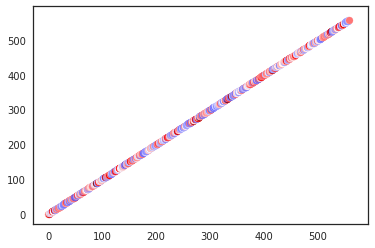

In [1939]:
for i, c in enumerate(colors):
    plt.scatter(i, i, c=c)

In [1921]:
sub_dag.node[n]

{'name': 'root'}

In [1642]:
disease_dag.head(5)

MedGen  Count                            PreferredName  Layer Layer 13  \
0  C0745103    664          Familial hypercholesterolemia 1      5      NaN   
1  C0950123    583                  Inborn genetic diseases      1      NaN   
2  C0024796    524                          Marfan syndrome      2      NaN   
3  C0027672    512  Hereditary cancer-predisposing syndrome      2      NaN   
4  C4746986    357    Alport syndrome 1, X-linked recessive      3      NaN   

  Layer 12 Layer 11 Layer 10 Layer 9 Layer 8 Layer 7   Layer 6  \
0      NaN      NaN      NaN     NaN     NaN     NaN  C0020473   
1      NaN      NaN      NaN     NaN     NaN     NaN       NaN   
2      NaN      NaN      NaN     NaN     NaN     NaN       NaN   
3      NaN      NaN      NaN     NaN     NaN     NaN       NaN   
4      NaN      NaN      NaN     NaN     NaN     NaN       NaN   

                               Layer 5  \
0  C0020445,C0023772,C0242339,C0745103   
1                                  NaN   
2  C0000772,C0005941,C0152021,C3273258   
3                                  NaN   
4                                  NaN   

                                             Layer 4  \
0                         C0020476,C0025521,C0154251   
1                                                NaN   
2  C0000768,C0005940,C0018798,C0410787,C1334997,C...   
3                                                NaN   
4                                                NaN   

                                             Layer 3  \
0                                           C0025517   
1                                                NaN   
2  C0009782,C0018799,C0026857,C0039978,C0243050,C...   
3                                                NaN   
4                                           C4746986   

                                             Layer 2  \
0                                           C1709248   
1                                                NaN   
2  C0007222,C0024796,C0851355,C1333150,C1709247,C...   
3                                  C0027672,C1882062   
4                                           C1567741   

                               Layer 1   Layer 0  
0                             C1709246  C0012634  
1                    C0019247,C0950123  C0012634  
2  C0039082,C0678236,C1333305,C1709246  C0012634  
3           C0019247,C0027651,C0039082  C0012634  
4                             C0039082  C0012634

In [1653]:
list(dag.successors("C1709246"))

[]

In [1564]:
medgen_rel.head()

#CUI1      AUI1 STYPE1  REL      CUI2       AUI2              RELA  \
0  C0000039  A0016515    AUI   SY  C0000039  A12080359   sort_version_of   
1  C0000039  A0016515    AUI   SY  C0000039  A12091182  entry_version_of   
2  C0000039  A0016515    AUI   SY  C0000039   A1317708  permuted_term_of   
3  C0000039  A0016515   SDUI  SIB  C0012456   A0049151               NaN   
4  C0000039  A0016515   SDUI  SIB  C0031617  A12995624               NaN   

         RUI  SAB   SL SUPPRESS  Unnamed: 11  
0  R64565540  MSH  MSH        N          NaN  
1  R64592881  MSH  MSH        N          NaN  
2  R28482432  MSH  MSH        N          NaN  
3  R71241360  MSH  MSH        N          NaN  
4  R71104054  MSH  MSH        N          NaN

In [1565]:
medgen_rel["REL"].value_counts()

RO     715482
SIB    228114
SY     158998
CHD    115989
PAR    115989
RN      83441
RB      83441
RQ      17420
AQ       6927
QB       6927
Name: REL, dtype: int64

In [1533]:
s1 = set(disease_dag["MedGen"].values)

In [1547]:
s2 = set(my.flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))

In [1550]:
print len(s1)
print len(s2)
print len(s1.intersection(s2))

2607
6275
1915
